In [4]:
experiment=None

In [1]:
#Imports
from comet_ml import Experiment
experiment = Experiment(api_key="YkPEmantOag1R1VOJmXz11hmt", parse_args=False, project_name='SegNet_Recognition_Joint')

COMET INFO: old comet version (1.0.44) detected. current: 2.0.4 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/yikeqicn/segnet-recognition-joint/d8605c90b1bc4e5d9c6052cd2a015ea8



In [5]:
#from datasets import IRSPRT#RecgArtPrintNoIntsectHVBW
import pytesseract as pyt
from os.path import join, basename, dirname
import tensorflow as tf
import shutil
import os
import sys
import argparse
from glob import glob
import cv2
import numpy as np
import os
import time
from PIL import Image
import editdistance

from torch.utils.data import DataLoader, ConcatDataset, random_split#, SequentialSampler #yike: add SequentialSampler
import torch
import torchvision
import torchvision.transforms as transforms
#from datasets import IRS #ArtPrintNoIntsectLBW,ArtPrintNoIntsectLBW_biameyd_siameyd,ArtPrintNoIntsectLBW_bpr_spr,ArtPrintNoIntsectLBW_biameyd_sprt
############from Model_Unet_github import *
from utils_seg import *
import utils_recg

############from recognition.Model import RecgModel, DecoderType
#from recognition.utils import log_image

home = os.environ['HOME']

In [19]:
# Unet
from __future__ import print_function, division, absolute_import, unicode_literals
import tensorflow as tf

import cv2

import os, sys
import numpy as np
import math
from datetime import datetime
import time
from PIL import Image
from math import ceil
from collections import OrderedDict
import logging
from utils_seg import get_image_summary, log_images, _variable_with_weight_decay, _variable_on_cpu, _add_loss_summaries, \
    _activation_summary, print_hist_summery, get_hist, per_class_acc, writeImage

# Recognition
from glob import glob
import numpy as np
import sys
import tensorflow as tf
from os.path import join
from Densenet4htr import Densenet4htr
import utils_recg  # dangerous


# model layers
def weight_variable(shape, stddev=0.1, name="weight"):
    shape = np.array(shape)
    # print(shape)
    # print(stddev)
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial, name=name)


def weight_variable_devonc(shape, stddev=0.1, name="weight_devonc"):
    shape = np.array(shape)
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev), name=name)


def bias_variable(shape, name="bias"):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)


def conv2d(x, W, b, keep_prob_):
    with tf.name_scope("conv2d"):
        conv_2d = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')  # 'VALID'
        conv_2d_b = tf.nn.bias_add(conv_2d, b)
        return tf.nn.dropout(conv_2d_b, keep_prob_)


def deconv2d(x, W, stride):
    with tf.name_scope("deconv2d"):
        x_shape = tf.shape(x)
        output_shape = tf.stack([x_shape[0], x_shape[1] * 2, x_shape[2] * 2, x_shape[3] // 2])
        return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding='SAME',
                                      name="conv2d_transpose")  # 'VALID'


def max_pool(x, n):
    return tf.nn.max_pool(x, ksize=[1, n, n, 1], strides=[1, n, n, 1], padding='SAME')  # 'VALID'


def crop_and_concat(x1, x2):
    with tf.name_scope("crop_and_concat"):
        x1_shape = tf.shape(x1)
        x2_shape = tf.shape(x2)
        # offsets for the top left corner of the crop
        offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
        size = [-1, x2_shape[1], x2_shape[2], -1]
        x1_crop = tf.slice(x1, offsets, size)
        return tf.concat([x1_crop, x2], 3)


def pixel_wise_softmax(output_map):
    with tf.name_scope("pixel_wise_softmax"):
        max_axis = tf.reduce_max(output_map, axis=3, keepdims=True)
        exponential_map = tf.exp(output_map - max_axis)
        normalize = tf.reduce_sum(exponential_map, axis=3, keepdims=True)
        return exponential_map / normalize


def cross_entropy(y_, output_map):
    return -tf.reduce_mean(y_ * tf.log(tf.clip_by_value(output_map, 1e-10, 1.0)), name="cross_entropy")


# unet setting
def create_conv_net(x, keep_prob, channels, n_class, layers=3, features_root=16, filter_size=3, pool_size=2,
                    summaries=True):
    """
    Creates a new convolutional unet for the given parametrization.
    :param x: input tensor, shape [?,nx,ny,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """

    logging.info(
        "Layers {layers}, features {features}, filter size {filter_size}x{filter_size}, pool size: {pool_size}x{pool_size}".format(
            layers=layers,
            features=features_root,
            filter_size=filter_size,
            pool_size=pool_size))

    # Placeholder for the input image
    with tf.name_scope("preprocessing"):
        nx = tf.shape(x)[1]
        ny = tf.shape(x)[2]
        # nx=32
        # ny=128
        # channels=1
        x_image = tf.reshape(x, tf.stack([-1, nx, ny, channels]))
        in_node = x_image
        batch_size = tf.shape(x_image)[0]

    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()

    in_size = 1000  # ?????????????????????
    size = in_size
    # down layers
    for layer in range(0, layers):
        with tf.name_scope("down_conv_{}".format(str(layer))):
            features = 2 ** layer * features_root
            stddev = np.sqrt(2 / (filter_size ** 2 * features))
            if layer == 0:
                w1 = weight_variable([filter_size, filter_size, channels, features], stddev, name="w1")
            else:
                w1 = weight_variable([filter_size, filter_size, features // 2, features], stddev, name="w1")

            w2 = weight_variable([filter_size, filter_size, features, features], stddev, name="w2")
            b1 = bias_variable([features], name="b1")
            b2 = bias_variable([features], name="b2")

            conv1 = conv2d(in_node, w1, b1, keep_prob)
            print(str(layer) + ' conv1: ' + str(conv1.get_shape()))
            tmp_h_conv = tf.nn.relu(conv1)
            conv2 = conv2d(tmp_h_conv, w2, b2, keep_prob)
            print(str(layer) + ' conv2: ' + str(conv2.get_shape()))
            dw_h_convs[layer] = tf.nn.relu(conv2)

            weights.append((w1, w2))
            biases.append((b1, b2))
            convs.append((conv1, conv2))

            size -= 2 * 2 * (filter_size // 2)  # valid conv
            if layer < layers - 1:
                pools[layer] = max_pool(dw_h_convs[layer], pool_size)
                in_node = pools[layer]
                size /= pool_size

    in_node = dw_h_convs[layers - 1]

    # up layers
    for layer in range(layers - 2, -1, -1):
        with tf.name_scope("up_conv_{}".format(str(layer))):
            features = 2 ** (layer + 1) * features_root
            stddev = np.sqrt(2 / (filter_size ** 2 * features))

            wd = weight_variable_devonc([pool_size, pool_size, features // 2, features], stddev, name="wd")
            bd = bias_variable([features // 2], name="bd")
            h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
            print(str(layer) + ' h_deconv: ' + str(h_deconv.get_shape()))
            h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)
            print(str(layer) + ' h_deconv_concat: ' + str(h_deconv_concat.get_shape()))
            deconv[layer] = h_deconv_concat

            w1 = weight_variable([filter_size, filter_size, features, features // 2], stddev, name="w1")
            w2 = weight_variable([filter_size, filter_size, features // 2, features // 2], stddev, name="w2")
            b1 = bias_variable([features // 2], name="b1")
            b2 = bias_variable([features // 2], name="b2")

            conv1 = conv2d(h_deconv_concat, w1, b1, keep_prob)
            h_conv = tf.nn.relu(conv1)
            print(str(layer) + ' h_conv1_post_deconv: ' + str(h_conv.get_shape()))
            conv2 = conv2d(h_conv, w2, b2, keep_prob)
            in_node = tf.nn.relu(conv2)
            up_h_convs[layer] = in_node
            print(str(layer) + ' h_conv2_post_deconv: ' + str(in_node.get_shape()))

            weights.append((w1, w2))
            biases.append((b1, b2))
            convs.append((conv1, conv2))

            size *= pool_size
            size -= 2 * 2 * (filter_size // 2)  # valid conv

    # Output Map
    with tf.name_scope("output_map"):
        weight = weight_variable([1, 1, features_root, n_class], stddev)
        bias = bias_variable([n_class], name="bias")
        conv = conv2d(in_node, weight, bias, tf.constant(1.0))
        print(str(layer) + ' outmap: ' + str(conv.get_shape()))

        # output_map = tf.nn.relu(conv)
        output_map = conv  # no activation, to be consistant with other models and leverage previous loss/prediction structures yike !!!!
        up_h_convs["out"] = output_map

    if summaries:
        with tf.name_scope("summaries"):
            for i, (c1, c2) in enumerate(convs):
                tf.summary.image('summary_conv_%02d_01' % i, get_image_summary(c1))
                tf.summary.image('summary_conv_%02d_02' % i, get_image_summary(c2))

            for k in pools.keys():
                tf.summary.image('summary_pool_%02d' % k, get_image_summary(pools[k]))

            for k in deconv.keys():
                tf.summary.image('summary_deconv_concat_%02d' % k, get_image_summary(deconv[k]))

            for k in dw_h_convs.keys():
                tf.summary.histogram("dw_convolution_%02d" % k + '/activations', dw_h_convs[k])

            for k in up_h_convs.keys():
                tf.summary.histogram("up_convolution_%s" % k + '/activations', up_h_convs[k])

    variables = []
    for w1, w2 in weights:
        variables.append(w1)
        variables.append(w2)

    for b1, b2 in biases:
        variables.append(b1)
        variables.append(b2)

    return output_map, variables, int(in_size - size)


class DecoderType:
    BestPath = 0
    BeamSearch = 1
    WordBeamSearch = 2


class Model:
    # model constants
    # batchSize = 50 #qyk
    # imgSize = (128, 32)
    # imgSize = (192, 48) #qyk
    maxTextLen = 32  # qyk?
    MOVING_AVERAGE_DECAY = 0.9999  # The decay to use for the moving average.
    NUM_EPOCHS_PER_DECAY = 350.0  # Epochs after which learning rate decays.
    LEARNING_RATE_DECAY_FACTOR = 0.1  # Learning rate decay factor.

    def __init__(self, args, charList, loss_beta, loss_weight, decoderType=DecoderType.BestPath, experiment=None,
                 mustRestore_seg=False, mustRestore_recg=False, joint=False):  # !!!!!!!!!!!!!!!!!!!!!!!!
        '''
        loss_betaxsegloss+(1-loss_beta)xrecgloss
        loss_weight: used in segnet training
        joint: False -> train recognition only, True -> train segmentation with recognition frozen
        '''
        self.loss_beta = loss_beta  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!
        self.args = args
        self.experiment = experiment
        self.lrInit = args.lrInit
        # self.mustRestore_recg= mustRestore_recg
        ###################################
        "init segnet model parameters:"
        ###################################
        self.mustRestore_seg = mustRestore_seg
        ###model hyperparameters###
        self.num_classes = args.num_class
        # self.FilePaths = FilePaths
        self.batch_size_seg = args.batch_size_seg  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        self.loss_weight = loss_weight

        ###########################################################################
        "init recognition model parameters: add CNN, RNN and CTC and initialize TF"
        ###########################################################################
        self.charList = charList
        self.decoderType = decoderType
        self.mustRestore_recg = mustRestore_recg
        # self.FilePaths = FilePaths
        self.batchsize_recg = args.batchsize_recg  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # self.lrInit = args.lrInit #!!!!!!!!!!!!!!!!!!!!!!!!
        # self.args = args #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

        ############################################################################
        """Graph Set Up"""
        ############################################################################
        tf.reset_default_graph()  # yike reset default graph  #!!!!!!!!!!!!!!!!!!!!!还要吗？????????
        with tf.name_scope('graph_segmentation'):
            # self.loss_segmentation, output = YIKE_FUNCTION_HERE()

            ###input### -- try to only set up graph once, combine train and test, by yike
            # tf.reset_default_graph() # yike reset default graph
            self.input_images_seg = tf.placeholder(tf.float32, shape=[None, self.args.image_h, self.args.image_w,
                                                                      self.args.image_c])  # try my best to make runtime batch_size flexible #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            self.input_labels_seg = tf.placeholder(tf.int64, shape=[None, self.args.image_h, self.args.image_w,
                                                                    1])  # !!!!!!!!!!!!!!!!!!!!!
            self.phase_train = tf.placeholder(tf.bool, name='phase_train')

            ###graph### -- combine
            self.logit_seg = self.setup_graph(self.input_images_seg,
                                              self.phase_train)  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            self.loss_seg = self.cal_loss(self.logit_seg, self.input_labels_seg)*500 # make it to same level as recg loss
            self.pred_seg = tf.argmax(self.logit_seg, axis=3)

            input_images_2d_seg = tf.squeeze(self.input_images_seg, [3])  # to 2d images, channel=1
            self.output_clean_seg = tf.to_float(self.pred_seg) * (255 - input_images_2d_seg) + input_images_2d_seg

            print('clean output from seg: ' + str(self.output_clean_seg.get_shape()))

        with tf.name_scope('graph_recognition'):
            # assume the input has been resized to 32x128
            if joint:
                self.input_images_recg = tf.transpose(self.output_clean_seg, perm=(0, 2, 1))
            else:
                self.input_images_recg = tf.placeholder(tf.float32, shape=(None, args.image_w, args.image_h))
            #self.input_images_recg = tf.transpose(self.output_clean_seg, perm=(0, 2, 1))
            #self.input_images_recg = tf.placeholder(tf.float32, shape=(None, args.image_w, args.image_h))
            print('recg input: ' + str(self.input_images_recg.get_shape()))
            # CNN
            if args.nondensenet:
                cnnOut4d = self.setupCNN(self.input_images_recg)
            else:  # use densenet by default
                cnnOut4d = self.setupCNNdensenet(self.input_images_recg, args)

            # RNN
            rnnOut3d = self.setupRNN(cnnOut4d)

            # CTC
            (self.ctcloss, self.decoder) = self.setupCTC(rnnOut3d)

            # Explicit regularizers
            self.loss_recg = self.ctcloss + args.wdec * self.setupWdec(args)

        # combine losses
        self.loss_total = (1 - loss_beta) * self.loss_recg + loss_beta * self.loss_seg
        print(self.loss_total)
        # optimizer for NN parameters
        self.batchesTrained = args.batchesTrained  # only for recognition training
        self.learning_rate = tf.placeholder(tf.float32, shape=[])  # for recognition and segmentation
        self.global_step = tf.Variable(0, trainable=False)  # for segmentation training

        self.var_list_train_seg = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "graph_segmentation") #TRAINABLE_
        self.obj_list_savable_seg= tf.get_collection(tf.GraphKeys.VARIABLES, "graph_segmentation")
        self.train_op_seg = self.train_op_seg_prepare(total_loss=self.loss_total, lr=self.learning_rate,
                                                      global_step=self.global_step, var_list=self.var_list_train_seg)
        # self.learning_rate self.loss_total
        ## optimizer for recognition only

        self.var_list_train_recg = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "graph_recognition")#TRAINABLE_
        self.obj_list_savable_recg= tf.get_collection(tf.GraphKeys.VARIABLES, "graph_recognition")
        if args.optimizer == 'rmsprop':
            self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss_recg,
                                                                                    var_list=self.var_list_train_recg)
        elif args.optimizer == 'adam':
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss_recg,
                                                                                 var_list=self.var_list_train_recg)
        elif args.optimizer == 'momentum':
            self.optimizer = tf.train.MomentumOptimizer(self.learning_rate, .9).minimize(self.loss_recg,
                                                                                         var_list=self.var_list_train_recg)

        # self.global_step,var_list=self.var_list_train_seg)  # !!!!!!!!!!!!!!!!!!!!!!!!!!
        # above: loss need to change to total loss
        ###session and saver###
        (self.sess, self.saver_seg, self.saver_recg) = self.initTF()  # tobe changed!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    ############################################################
    #####               Segnet Functions             ###########
    ############################################################ Not Adjusted !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    ### 1. loss factory ###

    def weighted_loss(self, logits, labels):  # num_classes, head=None):
        """ median-frequency re-weighting """
        with tf.name_scope('loss'):
            # print('w_llll')
            logits = tf.reshape(logits, (-1, self.num_classes))
            # print(logits.get_shape())
            epsilon = tf.constant(value=1e-10)

            logits = logits + epsilon

            # consturct one-hot label array
            label_flat = tf.reshape(labels, (-1, 1))
            # print(label_flat.get_shape())

            # should be [batch ,num_classes]
            labels = tf.reshape(tf.one_hot(label_flat, depth=self.num_classes), (-1, self.num_classes))
            # print(labels.get_shape())

            softmax = tf.nn.softmax(logits)
            # print(softmax.get_shape())
            #        print(epsilon.get_shape())

            #        print((labels * tf.log(softmax + epsilon)).get_shape())
            #        print(head.shape)
            #        print(tf.multiply(labels * tf.log(softmax + epsilon), head))

            cross_entropy = -tf.reduce_sum(tf.multiply(labels * tf.log(softmax + epsilon), self.loss_weight),
                                           axis=[1])
            #        print(cross_entropy.get_shape()) # yike head -> self.loss_weight

            cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
            #        print(cross_entropy_mean.get_shape())
            tf.add_to_collection('losses', cross_entropy_mean)

            loss = tf.add_n(tf.get_collection('losses'), name='total_loss_seg')
            print('loss_seg: ' + str(loss.get_shape()))

        return loss

    def cal_loss(self, logits, labels):
        labels = tf.cast(labels, tf.int32)
        return self.weighted_loss(logits, labels)

        # self.weighted_loss(logits, labels, num_classes=NUM_CLASSES, head=loss_weight)

        ###2. train optimizer factory ##

    def train_op_seg_prepare(self, total_loss, lr, global_step, var_list):
        # all of them are tensor
        # total_sample = 274 yike: ok to comment out?
        # num_batches_per_epoch = 274/1 yike: ok to comment out?

        loss_averages_op = _add_loss_summaries(total_loss)
        # Compute gradients.
        with tf.control_dependencies([loss_averages_op]):
            # print('try...')
            opt = tf.train.AdamOptimizer(lr)
            print('toto_loss_shape: ' + str(total_loss))
            opt.compute_gradients(total_loss, var_list=var_list)  # add list of variables
            grads = opt.compute_gradients(total_loss, var_list=var_list)  # !!!!!!!
            # print(grads)
            apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

            # Add histograms for trainable variables.
            #######for var in tf.trainable_variables():
            ######tf.summary.histogram(var.op.name, var)

            # Add histograms for gradients.
            #####for grad, var in grads:
            #####if grad is not None:
            #####tf.summary.histogram(var.op.name + '/gradients', grad)

            # Track the moving averages of all trainable variables.
            variable_averages = tf.train.ExponentialMovingAverage(Model.MOVING_AVERAGE_DECAY, global_step)
            variables_averages_op = variable_averages.apply(var_list=var_list)  # tf.trainable_variables()

            with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
                train_op_seg = tf.no_op(name='train_op_seg_prepare')

        return train_op_seg

        ###3. graph factory ###

    def setup_graph(self, images, phase_train):
        # previous inference() labels,inference, batch_size -- in order to get batch_size at running time
        # rather than using fixed batch_size in graph set up, revise it in inference:
        # batchsize=tf.shape(images)[0] # yike !!!
        print('GGG')
        input_shape = images.get_shape().as_list()
        print(input_shape)

        #       create_conv_net(x, keep_prob, channels, n_class, layers=3, features_root=16, filter_size=3, pool_size=2,
        #                    summaries=True)

        logit, _, __ = create_conv_net(x=images, keep_prob=0.8, channels=input_shape[3], n_class=self.num_classes,
                                       layers=3, features_root=32, filter_size=3)
        print(logit.get_shape())
        """
         Start Classify 

        # output predicted class number (6)
        with tf.variable_scope('conv_classifier') as scope:
          kernel = _variable_with_weight_decay('weights',
                                            shape=[1, 1, 64, self.num_classes],
                                            initializer=msra_initializer(1, 64),
                                            wd=0.0005)
          conv = tf.nn.conv2d(conv_decode1, kernel, [1, 1, 1, 1], padding='SAME')
          print('cv')
          print(conv.get_shape())
          biases = _variable_on_cpu('biases', [self.num_classes], tf.constant_initializer(0.0))
          print(biases.get_shape())
          logit= tf.nn.bias_add(conv, biases, name=scope.name)
          #conv_classifier = tf.nn.bias_add(conv, biases, name=scope.name)
          #print(conv_classifier.get_shape())
          #logit = conv_classifier
          #print('LLL')
          #print(labels)
          #print(conv_classifier)

          #loss = cal_loss(conv_classifier, labels)
          print(logit.get_shape())
          """
        return logit  # loss

    ############################################################################
    ###                 Recognition Functions                                ###
    ############################################################################
    def setupCNN(self, cnnIn3d):
        "vanilla cnn from original github repo"
        cnnIn4d = tf.expand_dims(input=cnnIn3d, axis=3)

        # list of parameters for the layers
        kernelVals = [5, 5, 3, 3, 3]
        featureVals = [1, 32, 64, 128, 128, 256]
        strideVals = poolVals = [(2, 2), (2, 2), (1, 2), (1, 2), (1, 2)]
        numLayers = len(strideVals)

        # create layers
        pool = cnnIn4d  # input to first CNN layer
        for i in range(numLayers):
            kernel = tf.Variable(
                tf.truncated_normal([kernelVals[i], kernelVals[i], featureVals[i], featureVals[i + 1]], stddev=0.1))
            conv = tf.nn.conv2d(pool, kernel, padding='SAME', strides=(1, 1, 1, 1))
            relu = tf.nn.relu(conv)
            pool = tf.nn.max_pool(relu, (1, poolVals[i][0], poolVals[i][1], 1),
                                  (1, strideVals[i][0], strideVals[i][1], 1),
                                  'VALID')

        self.is_training = tf.placeholder(tf.bool, shape=[])  # dummy placeholder to prevent error, no effect
        return pool

    def setupCNNdensenet(self, cnnIn3d, args):
        "ADDED BY RONNY: densenet cnn"
        print('shape of cnn input: ' + str(cnnIn3d.get_shape().as_list()))
        cnnIn4d = tf.expand_dims(input=cnnIn3d, axis=3)
        net = Densenet4htr(cnnIn4d, **vars(args))
        self.is_training = net.is_training
        print('shape of cnn output: ' + str(net.output.get_shape().as_list()))
        return net.output

    def setupRNN(self, rnnIn4d):
        "create RNN layers and return output of these layers"
        rnnIn3d = tf.squeeze(rnnIn4d, axis=[2])

        # basic cells which is used to build RNN
        numHidden = self.args.rnndim
        cells = [tf.contrib.rnn.LSTMCell(num_units=numHidden, state_is_tuple=True) for _ in range(2)]  # 2 layers

        # stack basic cells
        stacked = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=True)

        # bidirectional RNN
        # BxTxF -> BxTx2H
        ((fw, bw), _) = tf.nn.bidirectional_dynamic_rnn(cell_fw=stacked, cell_bw=stacked, inputs=rnnIn3d,
                                                        dtype=rnnIn3d.dtype, scope="graph_recognition/bidirectional_rnn")

        # BxTxH + BxTxH -> BxTx2H -> BxTx1X2H
        concat = tf.expand_dims(tf.concat([fw, bw], 2), 2)

        # project output to chars (including blank): BxTx1x2H -> BxTx1xC -> BxTxC
        kernel = tf.Variable(tf.truncated_normal([1, 1, numHidden * 2, len(self.charList) + 1], stddev=0.1))
        logits = tf.squeeze(tf.nn.atrous_conv2d(value=concat, filters=kernel, rate=1, padding='SAME'), axis=[2])
        # with tf.variable_scope('logits'):
        #   logits = tf.squeeze(tf.layers.conv2d(concat, len(self.charList)+1, 1, use_bias=True), axis=[2]) # FIXED BY RONNY
        return logits

    def setupCTC(self, ctcIn3d):
        "create CTC loss and decoder and return them"
        # BxTxC -> TxBxC
        ctcIn3dTBC = tf.transpose(ctcIn3d, [1, 0, 2])
        # ground truth text as sparse tensor
        self.gtTexts = tf.SparseTensor(tf.placeholder(tf.int64, shape=[None, 2]),
                                       tf.placeholder(tf.int32, [None]),
                                       tf.placeholder(tf.int64, [2]))
        # calc loss for batch
        self.seqLen = tf.placeholder(tf.int32, [None])

        loss = tf.nn.ctc_loss(labels=self.gtTexts, inputs=ctcIn3dTBC, sequence_length=self.seqLen,
                              ctc_merge_repeated=True)  # , ignore_longer_outputs_than_inputs=True) #qyk

        # decoder: either best path decoding or beam search decoding
        if self.decoderType == DecoderType.BestPath:
            decoder = tf.nn.ctc_greedy_decoder(inputs=ctcIn3dTBC, sequence_length=self.seqLen)
        elif self.decoderType == DecoderType.BeamSearch:
            decoder = tf.nn.ctc_beam_search_decoder(inputs=ctcIn3dTBC, sequence_length=self.seqLen, beam_width=50,
                                                    merge_repeated=False)
        elif self.decoderType == DecoderType.WordBeamSearch:
            # import compiled word beam search operation (see https://github.com/githubharald/CTCWordBeamSearch)
            word_beam_search_module = tf.load_op_library('TFWordBeamSearch.so')

            # prepare information about language (dictionary, characters in dataset, characters forming words)
            chars = str().join(self.charList)
            wordChars = open('wordCharList.txt').read().splitlines()[0]
            corpus = open(self.FilePaths.fnCorpus).read()

            # decode using the "Words" mode of word beam search
            decoder = word_beam_search_module.word_beam_search(tf.nn.softmax(ctcIn3dTBC, dim=2), 50, 'Words', 0.0,
                                                               corpus.encode('utf8'), chars.encode('utf8'),
                                                               wordChars.encode('utf8'))

        # return a CTC operation to compute the loss and a CTC operation to decode the RNN output
        return (tf.reduce_mean(loss), decoder)

    def setupWdec(self, args):
        """L2 weight decay loss."""
        costs = []
        for var in tf.trainable_variables():  # all weights count toward weight decay except batchnorm and biases
            if var.op.name.find(r'BatchNorm') == -1 & var.op.name.find(r'bias:0') == -1:
                costs.append(tf.nn.l2_loss(var))
        return tf.add_n(costs)

    def toSparse(self, texts):
        "put ground truth texts into sparse tensor for ctc_loss"
        indices = []
        values = []
        shape = [len(texts), 0]  # last entry must be max(labelList[i])

        # go over all texts
        for (batchElement, text) in enumerate(texts):
            # convert to string of label (i.e. class-ids)
            labelStr = [self.charList.index(c) for c in text]
            # sparse tensor must have size of max. label-string
            if len(labelStr) > shape[1]:
                shape[1] = len(labelStr)
            # put each label into sparse tensor
            for (i, label) in enumerate(labelStr):
                indices.append([batchElement, i])
                values.append(label)

        return (indices, values, shape)

    def decoderOutputToText(self, ctcOutput):
        "extract texts from output of CTC decoder"
        bt_size = ctcOutput[1].shape[0]  # yike !!!!!!
        # contains string of labels for each batch element
        encodedLabelStrs = [[] for i in range(bt_size)]  # yike self.batchsize !!!!!!!

        # word beam search: label strings terminated by blank
        if self.decoderType == DecoderType.WordBeamSearch:
            blank = len(self.charList)
            for b in range(bt_size):  # yike self.batchsize !!!!!!!
                for label in ctcOutput[b]:
                    if label == blank:
                        break
                    encodedLabelStrs[b].append(label)

        # TF decoders: label strings are contained in sparse tensor
        else:
            # ctc returns tuple, first element is SparseTensor
            decoded = ctcOutput[0][0]

            # go over all indices and save mapping: batch -> values
            idxDict = {b: [] for b in range(bt_size)}  # yike self.batchsize !!!!!
            for (idx, idx2d) in enumerate(decoded.indices):
                label = decoded.values[idx]
                batchElement = idx2d[0]  # index according to [b,t]
                encodedLabelStrs[batchElement].append(label)

        # map labels to chars for all batch elements
        return [str().join([self.charList[c] for c in labelStr]) for labelStr in encodedLabelStrs]

    #########################################################
    ####             Initialize TF (Both)                ####
    #########################################################

    def initTF(self):
        "initialize TF"
        print('Python: ' + sys.version)
        print('Tensorflow: ' + tf.__version__)

        sess = tf.Session(
            config=tf.ConfigProto(allow_soft_placement=True, gpu_options=tf.GPUOptions(allow_growth=True)))

        #####################################
        ##        SegNet Initiation        ##
        #####################################

        saver_seg = tf.train.Saver(var_list=self.obj_list_savable_seg, max_to_keep=1)  # saver saves model to file

        sess.run(tf.global_variables_initializer())
        print('Ran global_variables_initializer first')
        # Restore from saved model in current checkpoint directory
        latestSnapshot_seg = tf.train.latest_checkpoint(self.args.ckptpath_seg)  # is there a saved model?
        if self.mustRestore_seg and not latestSnapshot_seg:  # if model must be restored (for inference), there must be a snapshot
            raise Exception('No saved model found in: ' + self.args.ckptpath_seg)

        if latestSnapshot_seg:  # load saved model if available
            saver_seg.restore(sess, latestSnapshot_seg)
            print('Init with stored values from ' + latestSnapshot_seg)
        else:
            # sess.run(tf.global_variables_initializer())
            # print('Ran global_variables_initializer')
            sess.run(tf.initializers.variables(var_list=self.var_list_train_seg, name='init_seg'))
            print('Ran initializers.variables on segnet trainable variables')

        '''
            # initialize params from other model (transfer learning)
        if self.args.transfer:
            utils.maybe_download(source_url=self.args.urlTransferFrom,
                                 filename=join(self.args.ckptpath_seg, 'transferFrom'),
                                 target_directory=None,
                                 filetype='folder',
                                 force=True)
            saverTransfer = tf.train.Saver(
                tf.trainable_variables()[:-1])  # load all variables except from logit (classification) layer
            saverTransfer.restore(sess, glob(join(self.args.ckptpath_seg, 'transferFrom', 'model*'))[0].split('.')[0])
            print('Loaded variable values (except logit layer) from ' + self.args.urlTransferFrom)
        '''
        #############################################
        ###         Recognition Initialization    ###
        #############################################
        saver_recg = tf.train.Saver(var_list=self.obj_list_savable_recg, max_to_keep=1)

        latestSnapshot_recg = tf.train.latest_checkpoint(self.args.ckptpath_recg)  # is there a saved model?
        if self.mustRestore_recg and not latestSnapshot_recg:  # if model must be restored (for inference), there must be a snapshot
            raise Exception('No saved model found in: ' + self.args.ckptpath_recg)

        if latestSnapshot_recg:  # load saved model if available
            saver_recg.restore(sess, latestSnapshot_recg)
            print('Init with stored values from ' + latestSnapshot_recg)
        else:
            sess.run(tf.initializers.variables(var_list=self.var_list_train_recg, name='init_recg'))
            print('Ran initializers.variables on recognition trainable variables')
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # initialize params from other model (transfer learning)
        """
        if self.args.transfer:
            utils.maybe_download(source_url=self.args.urlTransferFrom,
                                 filename=join(self.args.ckptpath_recg, 'transferFrom'),
                                 target_directory=None,
                                 filetype='folder',
                                 force=True)
            saverTransfer = tf.train.Saver(
                tf.trainable_variables()[:-1])  # load all variables except from logit (classification) layer
            saverTransfer.restore(sess, glob(join(self.args.ckptpath_recg, 'transferFrom', 'model*'))[0].split('.')[0])
            print('Loaded variable values (except logit layer) from ' + self.args.urlTransferFrom)
        """

        return (sess, saver_seg, saver_recg)
    #######################################################
    #####         Training, Inference and Save        #####
    #######################################################

    #######################SegNet##########################
    def saveSeg(self, epoch):
       "save model to file"
       self.saver_seg.save(self.sess, join(self.args.ckptpath_seg, 'model'), global_step=epoch)
    def trainBatchSeg(self, images, labels, labels_recg): # added labels_recg!!!!!!!!!!!!!!!!
        "feed a batch into the NN to train it"

        # sparse = self.toSparse(labels)
        # lrnrate = self.lrInit if self.batchesTrained < self.args.lrDrop1 else (
        # self.lrInit*1e-1 if self.batchesTrained < self.args.lrDrop2 else self.lrInit*1e-2)  # decay learning rate
        bt_size=len(images)
        train_step = self.global_step.eval(session=self.sess)
        sparse = self.toSparse(labels_recg) # added !!!!!!!!!!!!!!!!!!!!!!!!!!!!
        """ fix lr """  ## To Ronny, change the schedule?
        # lr = self.lrInit
        lr = self.lrInit if train_step < self.args.lrDrop1 else (
            self.lrInit * 1e-1 if train_step < self.args.lrDrop2 else self.lrInit * 1e-2)  # yike
        (_, lossValTotal,lossValSeg) = self.sess.run([self.train_op_seg, self.loss_total,self.loss_seg],
                                     {self.input_images_seg: images,
                                      #self.input_images_recg: images, # added !!!!!!!!!!!!!!!
                                      self.input_labels_seg: labels,
                                      self.gtTexts:sparse, # added !!!!!!!!!!!!!!!!!!!!!!!!!!!
                                      self.seqLen: [Model.maxTextLen]*bt_size, #* self.batchsize_seg, #added!!!!!!!!!!!!!!!!!!!!!!
                                      self.learning_rate: lr,
                                      self.phase_train: True,
                                      self.is_training: False})
        # self.batchesTrained += 1
        return lossValTotal,lossValSeg

    def inferBatchSeg(self, imgs):  # modify to compatible to torch. previous def inferBatch(self, batch)
        "feed a batch into the NN to recngnize the texts"

        bt_size = len(imgs)  # yike !!!!!!!!

        pred = self.sess.run(self.pred_seg, feed_dict=
        {self.input_images_seg: imgs,  # check in, comment out in formal run
         # self.input_labels: labels,
         self.phase_train: False,
         self.is_training: False})  # yike self.batchsize!!!!!!!!!
        return pred
    def imageCleanSeg(self, imgs):
        bt_size = len(imgs)
        cleaneds=self.sess.run(self.output_clean_seg, feed_dict={self.input_images_seg: imgs, self.phase_train: False, self.is_training:False})
        return cleaneds.astype('uint8')
    def trainSeg(self, loader, validateloader=None, testloader=None):
        "train NN"
        epoch = 0  # number of training epochs since start
        best_accuracy = 0.0
        step = 0
        while True:
            epoch += 1;
            print('Epoch:', epoch, ' Training...')
            # train
            counter = 0
            # step = 0
            for idx, (images, labels, labels_recg) in enumerate(loader):
                images = images.numpy()
                labels = labels.numpy()
                #labels_recg=labels_recg.numpy()
                loss_value_total,loss_value_seg = self.trainBatchSeg(images, labels, labels_recg)
                assert not np.isnan(loss_value_total), 'Model diverged with loss = NaN'
                step += 1

                if idx % 100 == 0:
                    print('TRAIN: Batch:', idx / len(loader), 'Loss_Total:', loss_value_total)
                    print('TRAIN: Batch:', idx / len(loader), 'Loss_Seg:', loss_value_seg)
                    self.experiment.log_metric('train/loss_total', loss_value_total, step)
                    self.experiment.log_metric('train/loss_seg', loss_value_seg, step)#!!!!!!!!!!!!!!!!!!!!!!!
                    
                    logits = self.sess.run(self.logit_seg,
                                           feed_dict={self.input_images_seg: images,  # check in, comment out in formal run
                                                      # self.input_labels: labels,
                                                      # self.learning_rate: lr,
                                                      self.phase_train: False,
                                                      self.is_training:False})
                    train_acc, train_acc_classes = per_class_acc(logits, labels)  # check in, comment out in formal run

            # train log:
            if self.experiment is not None:
                self.experiment.log_metric('train/acc', train_acc, step)
                self.experiment.log_metric('train/cap_0', train_acc_classes[0], step)
                self.experiment.log_metric('train/cap_1', train_acc_classes[1], step)

            # validate:
            if validateloader != None:
                avg_batch_loss_seg,avg_batch_loss_total, acc_total, cap_0, cap_1,charErrorRate, wordAccuracy = self.validateSeg(validateloader, epoch)
            else:
                avg_batch_loss_seg,avg_batch_loss_total, acc_total, cap_0, cap_1,charErrorRate, wordAccuracy = self.validateSeg(loader, epoch)
            if self.experiment is not None:
                self.experiment.log_metric('valid/acc', acc_total, step)
                self.experiment.log_metric('valid/cap_0', cap_0, step)
                self.experiment.log_metric('valid/cap_1', cap_1, step)
                self.experiment.log_metric('valid/loss_seg', avg_batch_loss_seg, step)
                self.experiment.log_metric('valid/loss_total', avg_batch_loss_total, step)
                
                self.experiment.log_metric('valid/cer', charErrorRate, step)
                self.experiment.log_metric('valid/wer', 1 - wordAccuracy, step)
                
            # test:
            if testloader != None:
                acc_total, cap_0, cap_1 = self.validateSeg(testloader, epoch, is_testing=True)
                if self.experiment is not None:
                    self.experiment.log_metric('test/acc', acc_total, step)
                    self.experiment.log_metric('test/cap_0', cap_0, step)
                    self.experiment.log_metric('test/cap_1', cap_1, step)
                    self.experiment.log_metric('valid/loss_seg', avg_batch_loss_seg, step)
                    self.experiment.log_metric('valid/loss_total', avg_batch_loss_total, step)
                
                    self.experiment.log_metric('valid/cer', charErrorRate, step)
                    self.experiment.log_metric('valid/wer', 1 - wordAccuracy, step)

            # log best metrics
            if acc_total > best_accuracy:  # if best validation accuracy so far, save model parameters
                print('Character error rate improved, save model')
                best_accuracy = acc_total
                noImprovementSince = 0
                self.saveSeg(epoch)
                open(join(self.args.ckptpath_seg, 'accuracy.txt'), 'w').write(
                    'Validation accuracy, class 0, class 1 capture rates of saved model: %f%%, %f%% and %f%% ' % (
                    acc_total * 100.0, cap_0 * 100.0, cap_1 * 100.0))
                if self.experiment is not None:
                    self.experiment.log_metric('best/acc', acc_total, step)
                    self.experiment.log_metric('best/cap_0', cap_0, step)
                    self.experiment.log_metric('best/cap_1', cap_1, step)
            else:
                print('Character error rate not improved')
                noImprovementSince += 1

            # stop training
            if epoch >= self.args.max_epoch: print('Done with training at epoch', epoch,'sigoptObservation=' + str(best_accuracy)); break

    def validateSeg(self, loader, epoch, is_testing=False):
        "validate NN"
        if not is_testing:
            print('Validating NN')
        else:
            print('Testing NN')
        total_val_loss_seg = 0.0
        total_val_loss_total= 0.0
        # num_batches=len(loader)
        hist = np.zeros((self.num_classes, self.num_classes))
        numCharErr, numCharTotal, numWordOK, numWordTotal = 0, 0, 0, 0
        image_upload_count = 0
        for idx, (images, labels, labels_recg) in enumerate(loader):
            
            images = images.numpy()
            labels = labels.numpy()
            bt_size=len(images)            
            sparse=self.toSparse(labels_recg) #added!!!!!!!!!!!!!!!!!!!!!!!!
            #labels_recg=labels_recg.numpy() #added!!!!!!!!!!!!!!!!!!!!!!!!
            #sparse=self.toSparse()
            val_loss_total, val_loss_seg, val_logit,val_images_clean,val_decoded = self.sess.run([self.loss_total,self.loss_seg, self.logit_seg,self.output_clean_seg,self.decoder], feed_dict=
            {self.input_images_seg: images,  # check in, comment out in formal run !!!!!!!!!!!!+++++++val_decoder
             self.input_labels_seg: labels,
             self.gtTexts:sparse,
             self.seqLen: [Model.maxTextLen] * bt_size,#self.batchsize_recg, #changed!!!!!!!!!!!!!!!!!!!
             self.phase_train: False,
             self.is_training:False})  # self.loss,val_loss,

            total_val_loss_seg += val_loss_seg
            total_val_loss_total += val_loss_total#!!!!!!!!!!!!!!!!!!!!!!!
            
            hist += get_hist(val_logit, labels)
            # val_loss=total_val_loss / len(validateloader)*batch_size
            
            #############new text impact record#################
            recognized=self.decoderOutputToText(val_decoded)
            for i in range(len(recognized)):
                numWordOK += 1 if labels_recg[i] == recognized[i] else 0 #batch.gtTexts[i]
                numWordTotal += 1
                dist = editdistance.eval(recognized[i], labels_recg[i])# batch.gtTexts[i])
                numCharErr += dist
                numCharTotal += len(labels_recg[i]) #batch.gtTexts[i]
                ######################################################
                #print(images[i].shape)
                #print(val_images_clean[i].shape)
                if epoch == self.args.max_epoch and image_upload_count < 1000 and self.experiment is not None:
                    text = ' '.join(['[OK]' if dist == 0 else '[ERR:%d]' % dist, '"' + labels_recg[i] + '"', '->', '"' + recognized[i] + '"'])
                    im_orig=images[i].astype(int)
                    im_clean=val_images_clean[i].astype(int)
                    im_save=np.transpose(np.concatenate((np.squeeze(im_orig,axis=2),im_clean),axis=1))
                    utils_recg.log_image(self.experiment, im_save, text, 'test-'+('ok' if dist==0 else 'err'), self.args.ckptpath_seg, image_upload_count, epoch)
                    image_upload_count+=1
                    
            '''
            if epoch == self.args.max_epoch and image_upload_count < 1000 and self.experiment is not None:  # decide how many images to upload
                pred = val_logit.argmax(3)
                images = np.squeeze(images, axis=3)
                image_upload_count = log_images_seg_recg(images, pred,labels_recg,recognized, image_upload_count, self.experiment,
                                                self.args.ckptpath_seg)
            '''
        avg_batch_loss_seg = total_val_loss_seg / idx
        avg_batch_loss_total = total_val_loss_total / idx
        
        cls_sample_nums = hist.sum(1).astype(float)
        capture_array = np.diag(hist)
        acc_total = capture_array.sum() / hist.sum()
        capture_rate_ls = []
        for cls in range(self.num_classes):
            if cls_sample_nums[cls] == 0:
                capture_rate = 0.0
            else:
                capture_rate = capture_array[cls] / cls_sample_nums[cls]
            capture_rate_ls.append(capture_rate)
        # iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
        # mean_iu=np.nanmean(iu)
        print('VALID: Total accuracy: %f%%. Class 0 capture: %f%%. Class 1 capture: %f%%' % (
            acc_total * 100.0, capture_rate_ls[0] * 100.0, capture_rate_ls[1] * 100.0))
        
        #############new text impact record#################
        charErrorRate = numCharErr / numCharTotal
        wordAccuracy = numWordOK / numWordTotal
        print('VALID: Character error rate: %f%%. Word accuracy: %f%%.' % (charErrorRate * 100.0, wordAccuracy * 100.0))

        ####################################################
        return avg_batch_loss_seg,avg_batch_loss_total, acc_total, capture_rate_ls[0], capture_rate_ls[1],charErrorRate,wordAccuracy

            ##################Recognition##########################

    def trainBatchRecg(self, images, labels): #!!!!!!!!!!!!!!!!

        "feed a batch into the NN to train it"
        sparse = self.toSparse(labels)
        bt_size=len(images)#!!!!!!!!!!!!!!!!!!!!
        lrnrate = self.lrInit if self.batchesTrained < self.args.lrDrop1 else (self.lrInit * 1e-1 if self.batchesTrained < self.args.lrDrop2 else self.lrInit * 1e-2)  # decay learning rate
        (_, lossVal) = self.sess.run([self.optimizer, self.loss_recg],
                                    {self.input_images_recg: images,
                                     self.gtTexts: sparse,
                                     self.seqLen: [Model.maxTextLen]*bt_size,# * self.batchsize_recg,
                                     self.learning_rate: lrnrate,
                                     self.is_training: True})
        self.batchesTrained += 1
        return lossVal

    def inferBatchRecg(self, imgs):  # modify to compatible to torch. previous def inferBatch(self, batch)
        "feed a batch into the NN to recngnize the texts"
        '''if batch to infer less than args.batchsize, error'''

        bt_size = len(imgs)  # yike !!!!!!!!

        decoded = self.sess.run(self.decoder,
                                {self.input_images_recg: imgs, self.seqLen: [Model.maxTextLen] * bt_size,
                                 self.is_training: False})  # yike self.batchsize!!!!!!!!!
        return self.decoderOutputToText(decoded)  # previous batch.imgs
    
    def inferBatchJoint(self,imgs):
        bt_size = len(imgs)  # yike !!!!!!!!

        decoded = self.sess.run(self.decoder,
                                {self.input_images_seg: imgs,
                                 self.seqLen: [Model.maxTextLen] * bt_size,
                                 self.phase_train: False,
                                 self.is_training: False})  # yike self.batchsize!!!!!!!!!

        return self.decoderOutputToText(decoded)  # previous batch.imgs     
    
    def inferCleanBatchJoint(self,imgs):
        bt_size = len(imgs)  # yike !!!!!!!!

        cleaneds,decoded = self.sess.run([self.output_clean_seg,self.decoder],feed_dict=
                                {self.input_images_seg: imgs,
                                 self.seqLen: [Model.maxTextLen] * bt_size,
                                 self.phase_train: False,
                                 self.is_training: False})  # yike self.batchsize!!!!!!!!!

        return cleaneds.astype('uint8'),self.decoderOutputToText(decoded)  # previous batch.imgs     

    def saveRecg(self, epoch):
        "save model to file"
        self.saver_recg.save(self.sess, join(self.args.ckptpath_recg, 'model'), global_step=epoch)

    def trainRecg(self, loader, validateloader=None, testloader=None):  # model

        "train NN"
        epoch = 0  # number of training epochs since start
        bestCharErrorRate = bestWordErrorRate = float('inf')  # best valdiation character error rate

        while True:
            epoch += 1;
            print('Epoch:', epoch, ' Training...')

            # train
            counter = 0
            step = 0

            for idx, (images, labels) in enumerate(loader):

                # convert torchtensor to numpy
                images = images.numpy()

                # train batch
                # try:
                loss = self.trainBatchRecg(images, labels)
                # except:
                #  print(labels)
                step += 1

                # save training status
                if np.mod(idx, 110) == 0:
                    print('TRAIN: Batch:', idx / len(loader), 'Loss:', loss)
                    if self.experiment is not None:
                        self.experiment.log_metric('train/loss', loss, step)

                # log images
                if epoch == 1 and counter < 5:
                    text = labels[counter]
                    utils_recg.log_image(self.experiment, images[counter], text, 'train', self.args.ckptpath_recg, counter, epoch)
                    counter += 1
                # for debug
                # if idx >2:
                #  break

            # validate
            if validateloader != None:
                charErrorRate, wordAccuracy = self.validateRecg(validateloader, epoch)  # yike !!!!!!!!!!!!
            else:  # yike !!!!!!!!!!!!!
                charErrorRate, wordAccuracy = self.validateRecg(loader, epoch)
            if self.experiment is not None:
                self.experiment.log_metric('valid/cer', charErrorRate, step)
                self.experiment.log_metric('valid/wer', 1 - wordAccuracy, step)

            # test
            if testloader != None:
                charErrorRate, wordAccuracy = self.validateRecg(testloader, epoch, is_testing=True)
                if self.experiment is not None:
                    self.experiment.log_metric('test/cer', charErrorRate, step)
                    self.experiment.log_metric('test/wer', 1 - wordAccuracy, step)

            # log best metrics
            if charErrorRate < bestCharErrorRate:  # if best validation accuracy so far, save model parameters
                print('Character error rate improved, save model')
                bestCharErrorRate = charErrorRate
                noImprovementSince = 0
                self.saveRecg(epoch)
                open(join(args.ckptpath_recg, 'accuracy.txt'), 'w').write(
                    'Validation character error rate of saved model: %f%%' % (charErrorRate * 100.0))
            else:
                print('Character error rate not improved')
                noImprovementSince += 1
            if 1 - wordAccuracy < bestWordErrorRate:
                bestWordErrorRate = 1 - wordAccuracy
            if self.experiment is not None:
                self.experiment.log_metric('best/cer', bestCharErrorRate, step)
                self.experiment.log_metric('best/wer', bestWordErrorRate, step)

            # stop training
            if epoch >= args.epochEnd: print('Done with training at epoch', epoch,
                                         'sigoptObservation=' + str(bestCharErrorRate)); break

    def validateRecg(self, loader, epoch, is_testing=False):
        "validate NN"
        if not is_testing: print('Validating NN')
        else: print('Testing NN')
        #loader.validationSet() # comment out by yike. see row 141
        numCharErr, numCharTotal, numWordOK, numWordTotal = 0, 0, 0, 0
        plt.figure(figsize=(6,2))
        counter = 0
        '''
        yike: convert to troch dataloader, test
        '''
        for idx, (images, labels) in enumerate(loader):
            if np.mod(idx,10)==0:
                print(str(idx*50*8))
            images=images.numpy()
            recognized=self.inferBatchRecg(images)

            for i in range(len(recognized)):
                numWordOK += 1 if labels[i] == recognized[i] else 0 #batch.gtTexts[i]
                numWordTotal += 1
                dist = editdistance.eval(recognized[i], labels[i])# batch.gtTexts[i])
                numCharErr += dist
                numCharTotal += len(labels[i]) #batch.gtTexts[i]

                if is_testing and epoch==self.args.epochEnd and self.experiment is not None: #batch.gtTexts[i]
                    text = ' '.join(['[OK]' if dist == 0 else '[ERR:%d]' % dist, '"' + labels[i] + '"', '->', '"' + recognized[i] + '"'])
                    utils_recg.log_image(self.experiment, images[i], text, 'test-'+('ok' if dist==0 else 'err'), self.args.ckptpath_recg, counter, epoch)
                    counter += 1 # previous batch.imgs[i]

            if epoch==1 and counter<5 and not is_testing and self.experiment is not None: # log images
                text = ' '.join(['[OK]' if dist == 0 else '[ERR:%d]' % dist, '"' + labels[i] + '"', '->', '"' + recognized[i] + '"'])
                utils_recg.log_image(self.experiment, images[i], text, 'valid', args.ckptpath_recg, counter, epoch) #batch.gtTexts[i]
                counter += 1 #batch.imgs[i]


        # print validation result
        charErrorRate = numCharErr / numCharTotal
        wordAccuracy = numWordOK / numWordTotal
        print('VALID: Character error rate: %f%%. Word accuracy: %f%%.' % (charErrorRate * 100.0, wordAccuracy * 100.0))
        return charErrorRate, wordAccuracy


In [20]:
#model=Model(args, charList="", loss_beta=0.6,loss_weight=[.5,.5], decoderType=DecoderType.BestPath,experiment=None,mustRestore_seg=False,mustRestore_recg=False)

# Segment Parameters

In [21]:
#General Settings
parser = argparse.ArgumentParser()

# system basics
#parser.add_argument("-name", default='segnet_unet_hvbw_all_combine_100_epoches', type=str, help="name of the log") #debug model_intersect # segnet_no_intersect_1conv_64_channels_30epoch_unet_github
parser.add_argument("-name_seg", default='new_segnet_joint', type=str, help="name of the log") #debug model_intersect # segnet_no_intersect_1conv_64_channels_30epoch_unet_github
#segnet_binary_100epoch_unet_github
parser.add_argument("-gpu", default='-1', type=str, help="gpu numbers")

parser.add_argument("-train", default=True, help="train the NN", action="store_true")
parser.add_argument("-validate", help="validate the NN", action="store_true")

parser.add_argument("-transfer",default=False, help="test the NN", action="store_true")

parser.add_argument("-test",default=False, help="test the NN", action="store_true")

# image and logistic parameters 
parser.add_argument("-image_h", default=32, type=int, help='image height') #('image_h', "360", """ image height """) 32
parser.add_argument("-image_w", default=128, type=int, help='image width')#('image_w', "480", """ image width """)128
#parser.add_argument("-image_h", default=360, type=int, help='image height') 
#parser.add_argument("-image_w", default=480, type=int, help='image width')

parser.add_argument("-image_c", default=1, type=int, help='image channel')#('image_c', "3", """ image channel (RGB) """)
parser.add_argument("-num_class", default=2, type=int, help='total class number')

# training hyperparam
parser.add_argument("-batch_size_seg", default=10, type=int, help='batch_size')
parser.add_argument("-lrInit", default=1e-3, type=int, help='initial lr')
parser.add_argument("-lrDrop1", default=10, type=int, help='step to drop lr by 10 first time') # not sure
parser.add_argument("-lrDrop2", default=1000, type=int, help='step to drop lr by 10 sexond time') # not sure
parser.add_argument('-max_epoch',default=100, type=int,help='max epoch numbers')



# file paths
parser.add_argument('-ckpt_root', default="/root/ckpt", type=str,help= "dir to store ckpt") # log_dir !!!!!
parser.add_argument('-data_root', default="/root/datasets", type=str, help=" root to any data folder ")
parser.add_argument('-urlTranferFrom', default="", type=str, help=" archived model url ")


#args = parser.parse_args()



_StoreAction(option_strings=['-urlTranferFrom'], dest='urlTranferFrom', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help=' archived model url ', metavar=None)

# Recognition Parameters

In [8]:
# Recognition Model
# basic operations
parser.add_argument("-name_recg", default="recg_new_five_datasets", type=str, help="name of the log") #'dense_128_32_noartifact_beamsearch_5_datasets'
#parser.add_argument("-gpu", default='-1', type=str, help="gpu numbers")
#parser.add_argument("-train", help="train the NN", action="store_true")
#parser.add_argument("-validate", help="validate the NN", action="store_true")
#parser.add_argument("-transfer", action="store_true")
#actually not effective:
parser.add_argument("-batchesTrained", default=0, type=int, help='number of batches already trained (for lr schedule)') 
# beam search
parser.add_argument("-beamsearch", help="use beam search instead of best path decoding",default=True, action="store_true")
parser.add_argument("-wordbeamsearch", help="use word beam search instead of best path decoding", action="store_true")
# training hyperparam
parser.add_argument("-batchsize_recg", default=10, type=int, help='batch size') # actually not effective in infrerence
#parser.add_argument("-lrInit", default=1e-2, type=float, help='initial learning rate') # actually not effective
parser.add_argument("-optimizer", default='rmsprop', help="adam, rmsprop, momentum") # actually not effective
parser.add_argument("-wdec", default=1e-4, type=float, help='weight decay') # acctually not effective
#parser.add_argument("-lrDrop1", default=10, type=int, help='step to drop lr by 10 first time')
#parser.add_argument("-lrDrop2", default=1000, type=int, help='step to drop lr by 10 sexond time')
parser.add_argument("-epochEnd", default=40, type=int, help='end after this many epochs')
# trainset hyperparam
#parser.add_argument("-noncustom", help="noncustom (original) augmentation technique", action="store_true")
#parser.add_argument("-noartifact", help="dont insert artifcats", action="store_true")
#parser.add_argument("-iam", help='use iam dataset', action='store_true')
# densenet hyperparam
parser.add_argument("-nondensenet", help="use noncustom (original) vanilla cnn", action="store_true")
parser.add_argument("-growth_rate", default=12, type=int, help='growth rate (k)')
parser.add_argument("-layers_per_block", default=18, type=int, help='number of layers per block')
parser.add_argument("-total_blocks", default=5, type=int, help='nuber of densenet blocks')
parser.add_argument("-keep_prob", default=1, type=float, help='keep probability in dropout')
parser.add_argument("-reduction", default=0.4, type=float, help='reduction factor in 1x1 conv in transition layers')
parser.add_argument("-bc_mode", default=True, type=bool, help="bottleneck and compresssion mode")
# rnn,  hyperparams
parser.add_argument("-rnndim", default=256, type=int, help='rnn dimenstionality') #256
parser.add_argument("-rnnsteps", default=32, type=int, help='number of desired time steps (image slices) to feed rnn')
# img size
parser.add_argument("-imgsize", default=[128,32], type=int, nargs='+') #qyk default 128,32 // use segnet definition
# testset crop
#parser.add_argument("-crop_r1", default=3, type=int)
#parser.add_argument("-crop_r2", default=28, type=int)
#parser.add_argument("-crop_c1", default=10, type=int)
#parser.add_argument("-crop_c2", default=115, type=int)
# filepaths
parser.add_argument("-dataroot", default='/root/datasets', type=str)
#######parser.add_argument("-ckptroot", default='/root/ckpt', type=str)##############
#parser.add_argument("-urlTransferFrom", default=None, type=str)

args = parser.parse_known_args()[0]

### SegNet
home = os.environ['HOME']
#name = args.name
#ckptroot = join(home, 'ckpt')
#args.ckptpath = join(ckptroot, name)
#os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

####args = parser.parse_known_args()[0]

name_seg = args.name_seg
name_recg=args.name_recg

os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

ckptroot = args.ckpt_root
args.ckptpath_seg = join(ckptroot, name_seg)
args.ckptpath_recg = join(ckptroot, name_recg)
if args.name_seg=='debug_seg_': shutil.rmtree(args.ckptpath_seg, ignore_errors=True)
if args.name_recg=='debug_recg_': shutil.rmtree(args.ckptpath_recg, ignore_errors=True)

os.makedirs(args.ckptpath_seg, exist_ok=True)
os.makedirs(args.ckptpath_recg, exist_ok=True)

#recg_name=args.recg_name
#args.regckptpath=join(ckptroot,recg_name)

# Train Recognition

In [21]:
experiment.set_name('debug_recg_100')
experiment.log_parameters(vars(args))

In [22]:
from datasets_recg import *

In [23]:
decoderType = DecoderType.BestPath
if args.beamsearch:
    decoderType = DecoderType.BeamSearch
elif args.wordbeamsearch:
    decoderType = DecoderType.WordBeamSearch
if args.train or args.validate:

    # load training data, create TF model
    # loader = DataLoader(FilePaths.fnTrain, args.batchsize, args.imgsize, Model.maxTextLen, args)
    # testloader = DataLoader(FilePaths.fnTest, args.batchsize, args.imgsize, Model.maxTextLen, args, is_test=True)

    # tnansforms#
    transform_train = transforms.Compose([
        # lambda img: (np.zeros([args.imgsize[1], args.imgsize[0]]) if img is None or np.min(img.shape) <= 1 else cv2.resize(img, (args.imgsize[1],args.imgsize[0]), interpolation=cv2.INTER_CUBIC)),
        # lambda img: np.zeros([args.imgsize[1], args.imgsize[0]]) if (img is None or np.min(img.shape) <= 1) else cv2.resize(img, (args.imgsize[1],args.imgsize[0]), interpolation=cv2.INTER_CUBIC)
        transforms.Lambda(
            lambda img: cv2.resize(img, (args.imgsize[0], args.imgsize[1]), interpolation=cv2.INTER_CUBIC)),
        # (img, (32,128), interpolation=cv2.INTER_CUBIC),
        #transforms.Lambda(lambda img: add_artifacts(img, args)),
        # transforms.Lambda(lambda img: img_normalize(img)),
        transforms.Lambda(lambda img: cv2.transpose(img))
        # lambda img: cv2.resize(img, (args.imgsize[1], args.imgsize[0]), interpolation=cv2.INTER_CUBIC),
    ])

    # yike: to use torch.transform.classes, please convert numpy to PIL first. i.e.transforms.Resize(size=(args.imgsize[1], args.imgsize[0]), interpolation=PIL.Image.BICUBIC)

    # instantiate datasets
    # iam = IAM(args.dataroot, transform=transform_train)
    #eydigits = EyDigitStrings(args.dataroot, transform=transform_train)
    #printed = PRT(args.dataroot, transform=transform_train)  # yike todo
    printed =PRT_WORD(args.dataroot,transform=transform_train)
    # irs = IRS(args.dataroot,transform=transform_train) #yike todo
    # freal=REAL(args.dataroot,transform=transform_train)

    # tst=irs.__getitem__(1)
    # print(type(tst[0]))
    # print(tst[0].shape)
    # cv2.imshow('tst',tst[0])
    # cv2.imwrite('/root/Engagements/test/tst1.jpg', tst[0])
    # concatenate datasets
    concat = printed;  # ConcatDataset([iam, eydigits,irs,printed,freal]) # concatenate the multiple datasets yike notice!!!!
    print(len(concat))
    # concat= printed
    # concat=eydigits
    idxTrain = int(.9 * len(concat))
    trainset, testset = random_split(concat, [idxTrain, len(concat) - idxTrain])
    print(str(len(trainset) / 50))
    print(str(len(testset) / 50))
    trainloader = DataLoader(trainset, batch_size=args.batchsize_recg, shuffle=True, drop_last=True, num_workers=4)
    validateloader = DataLoader(trainset, batch_size=args.batchsize_recg * 8, shuffle=False, drop_last=False, num_workers=2)
    testloader = DataLoader(testset, batch_size=args.batchsize_recg * 8, shuffle=False, drop_last=False,
                            num_workers=2)  # yike: feel not right
    # testloader=DataLoader(testset, batch_size=args.batchsize,shuffle=False, num_workers=2) # yike: all test data included, no sampling. validation is not training. , sampler=SequentialSampler

    # save characters of model for inference mode
    # charlist = list(set.union(set(iam.charList),set(eydigits.charList),set(irs.charList),set(printed.charList),set(freal.charList))) # yike notice !!!!
    charlist = list(set(printed.charList))
    charlist.sort()
    # charlist=eydigits.charList
    open(join(args.ckptpath_recg, 'charList.txt'), 'w').write(str().join(charlist))

    # # save words contained in dataset into file
    # open(FilePaths.fnCorpus, 'w').write(str(' ').join(loader.trainWords + loader.validationWords))

    # execute training or validation
    if args.train:
        model = Model(args, charList=charlist, loss_beta=0.6,loss_weight=[.5,.5], decoderType=DecoderType.BeamSearch,experiment=experiment,mustRestore_seg=False,mustRestore_recg=False, joint=False)  # yike: pay notice here, add mustRestore if wanna continue with pretrained model !!!!!!!!!
        model.trainRecg(trainloader, validateloader, testloader)  # yike added validateloader !!!!!!!!!!
    elif args.validate:
        #model = Model(args, charlist, decoderType, mustRestore=True)
        model = Model(args, charList=charlist, loss_beta=0.6,loss_weight=[.5,.5], decoderType=DecoderType.BeamSearch,experiment=experiment,mustRestore_seg=False,mustRestore_recg=True, joint=False)
        model.validateRecg(testloader)

# infer text on test image
else:
    print(open(join(args.ckptpath_recg, 'accuracy.txt')).read())
    #model = Model(args, open(join(args.ckptpath, 'charList.txt')).read(), decoderType, mustRestore=True)
    model = Model(args, charList=open(join(args.ckptpath_recg, 'charList.txt')).read(), loss_beta=0.6,loss_weight=[.5,.5], decoderType=DecoderType.BeamSearch,experiment=experiment,mustRestore_seg=False,mustRestore_recg=True, joint=False)
    infer(model, FilePaths.fnInfer)


/root/datasets/img_print_single already exists, skipping download
284246
5116.42
568.5
GGG
[None, 32, 128, 1]
0 conv1: (?, ?, ?, 32)
0 conv2: (?, ?, ?, 32)
1 conv1: (?, ?, ?, 64)
1 conv2: (?, ?, ?, 64)
2 conv1: (?, ?, ?, 128)
2 conv2: (?, ?, ?, 128)
1 h_deconv: (?, ?, ?, 64)
1 h_deconv_concat: (?, ?, ?, ?)
1 h_conv1_post_deconv: (?, ?, ?, 64)
1 h_conv2_post_deconv: (?, ?, ?, 64)
0 h_deconv: (?, ?, ?, 32)
0 h_deconv_concat: (?, ?, ?, ?)
0 h_conv1_post_deconv: (?, ?, ?, 32)
0 h_conv2_post_deconv: (?, ?, ?, 32)
0 outmap: (?, ?, ?, 2)
(?, ?, ?, 2)
loss_seg: ()
clean output from seg: (?, 32, 128)
recg input: (?, 128, 32)
shape of cnn input: [None, 128, 32]
Build Densenet4htr model with 5 blocks, 9 bottleneck layers and 9 composite layers each.
Depth: 96
Reduction at transition layers: 0.4


KeyboardInterrupt: 

# Train Segmentation

In [6]:
experiment.set_name('new_seg_joint')
experiment.log_parameters(vars(args))

In [9]:
from datasets_seg import *

In [8]:
def checkArgs():
    if args.test:
        print('The model is set to Testing')
        print("Check point file: %s"%args.ckptpath_seg)
        #print("CamVid testing dir: %s"%FLAGS.test_dir)
    elif args.transfer:
        print('The model is set to transfer learn from ckpt')
        print("Check point file: %s"%args.ckptpath_seg)
        #print("CamVid Image dir: %s"%FLAGS.image_dir)
        #print("CamVid Val dir: %s"%FLAGS.val_dir)
    else:
        print('The model is set to Training')
        print("Max training Iteration: %d"%args.max_epoch)
        print("Initial lr: %f"%args.lrInit)
        print("First Drop Steps: %i"%args.lrDrop1)
        print("Second Drop Steps: %i"%args.lrDrop2)
        print("Data root: %s"%args.data_root)
        print("Check point file: %s"%args.ckptpath_seg)
        #print("CamVid Val dir: %s"%FLAGS.val_dir)

    print("Batch Size: %d"%args.batch_size_seg)

In [ ]:
checkArgs()
if args.train:
    transform_train = transforms.Compose([
        transforms.Lambda(lambda img: cv2.resize(img, (args.image_w, args.image_h), interpolation=cv2.INTER_CUBIC)),
        transforms.Lambda(lambda img: np.expand_dims(img, 3)),
        # transforms.Lambda(lambda img: add_artifacts(img,args)),
        # transforms.Lambda(lambda img: cv2.transpose(img))
    ])
    # arprint=ArtPrint(args.data_root, transform=transform_train)
    arprint = ArtPrintNoIntsectBinary(args.data_root, transform=transform_train)
    concat = arprint
    idxTrain = int(len(arprint) * 0.9)
    trainset, testset = random_split(concat, [idxTrain, len(concat) - idxTrain])
    trainloader = DataLoader(trainset, batch_size=args.batch_size_seg, shuffle=True, drop_last=True, num_workers=4)
    testloader = DataLoader(testset, batch_size=args.batch_size_seg, shuffle=False, drop_last=False, num_workers=2)

    # weight gen
    pos_perc = sum(map(lambda x: np.sum(cv2.imread(x[1], cv2.IMREAD_GRAYSCALE)), trainset.dataset.samples)) / (
                args.image_h * args.image_w * len(trainset.dataset.samples))
    neg_perc = 1 - pos_perc
    weight = np.array([pos_perc, neg_perc])  # just reverse
    ##weight=np.array([0.1,0.9])
    print(weight)
    #model = Model(args, experiment, loss_weight=weight, mustRestore=False)
    model = Model(args, charList=open(join(args.ckptpath_recg, 'charList.txt')).read(), loss_beta=0.5,loss_weight=weight, decoderType=DecoderType.BeamSearch,experiment=experiment,mustRestore_seg=False,mustRestore_recg=True,joint=True)
    model.trainSeg(loader=trainloader, validateloader=testloader)

else:
    pass  # for no

The model is set to Training
Max training Iteration: 100
Initial lr: 0.001000
First Drop Steps: 10
Second Drop Steps: 1000
Data root: /root/datasets
Check point file: /root/ckpt/new_segnet_joint
Batch Size: 10
/root/datasets/artifact_images_no_intersect already exists, skipping download
[0.05999042 0.94000958]
GGG
[None, 32, 128, 1]
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


0 conv1: (?, ?, ?, 32)
0 conv2: (?, ?, ?, 32)
1 conv1: (?, ?, ?, 64)
1 conv2: (?, ?, ?, 64)
2 conv1: (?, ?, ?, 128)
2 conv2: (?, ?, ?, 128)
1 h_deconv: (?, ?, ?, 64)
1 h_deconv_concat: (?, ?, ?, ?)
1 h_conv1_post_deconv: (?, ?, ?, 64)
1 h_conv2_post_deconv: (?, ?, ?, 64)
0 h_deconv: (?, ?, ?, 32)
0 h_deconv_concat: (?, ?, ?, ?)
0 h_conv1_post_deconv: (?, ?, ?, 32)
0 h_conv2_post_deconv: (?, ?, ?, 32)
0 outmap: (?, ?, ?, 2)
(?, ?, ?, 2)
loss_seg: ()
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


clean output from seg: (?, 32, 128)
recg input: (?, 128, 32)
shape of cnn input: [None, 128, 32]
Build Densenet4htr model with 5 blocks, 9 bottleneck layers and 9 composite layers each.
Depth: 96
Reduction at transition layers: 0.4
densenet feature extractor graph built in (sec): 7.281428337097168
Total training params: 1.0M
shape of cnn output: [None, 32, 1, 178]
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Tensor("add:0", shape=(), dtype=float32)
Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.


Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.


INFO:tensorflow:Summary name graph_segmentation/loss/cross_entropy (raw) is illegal; using graph_segmentation/loss/cross_entropy__raw_ instead.


INFO:tensorflow:Summary name graph_segmentation/loss/cross_entropy (raw) is illegal; using graph_segmentation/loss/cross_entropy__raw_ instead.


INFO:tensorflow:Summary name add (raw) is illegal; using add__raw_ instead.


INFO:tensorflow:Summary name add (raw) is illegal; using add__raw_ instead.
COMET ERROR: Failed to extract parameters from Estimator.init()


toto_loss_shape: Tensor("add:0", shape=(), dtype=float32)
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.
COMET ERROR: Failed to extract parameters from Estimator.init()


Python: 3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
Tensorflow: 1.12.0-rc0
Ran global_variables_initializer first
Ran initializers.variables on segnet trainable variables
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /root/ckpt/recg_new_five_datasets/model-9


INFO:tensorflow:Restoring parameters from /root/ckpt/recg_new_five_datasets/model-9


Init with stored values from /root/ckpt/recg_new_five_datasets/model-9
Epoch: 1  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 47.565422
TRAIN: Batch: 0.0 Loss_Seg: 78.76811
accuracy = 0.410284
mean IU  = 0.223412
    class # 0 capture rate = 0.392062 
    class # 1 capture rate = 0.768804 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 13.532831
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 17.852833
accuracy = 0.837484
mean IU  = 0.529166
    class # 0 capture rate = 0.834698 
    class # 1 capture rate = 0.885804 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 13.226992
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 19.888847
accuracy = 0.869793
mean IU  = 0.584562
    class # 0 capture rate = 0.873719 
    class # 1 capture rate = 0.818119 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 15.900778
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 16.938105
accuracy = 0.857310
mean IU  = 0.560850
    class # 0 capture rate = 0.854991 
    class # 1 capture rate = 0.893791 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 10.882318
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 15.706275
acc

TRAIN: Batch: 0.14463294503948088 Loss_Total: 6.189966
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 9.905783
accuracy = 0.925310
mean IU  = 0.655438
    class # 0 capture rate = 0.924753 
    class # 1 capture rate = 0.935701 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 8.184158
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 11.886331
accuracy = 0.902493
mean IU  = 0.619412
    class # 0 capture rate = 0.899497 
    class # 1 capture rate = 0.956140 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 8.920025
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 11.775942
accuracy = 0.919873
mean IU  = 0.653144
    class # 0 capture rate = 0.919650 
    class # 1 capture rate = 0.923651 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 7.47807
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 10.888313
accuracy = 0.918142
mean IU  = 0.681241
    class # 0 capture rate = 0.915135 
    class # 1 capture rate = 0.958115 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 7.115554
TRAIN: Batch: 0.16026893909780315 Loss_

TRAIN: Batch: 0.28926589007896175 Loss_Total: 5.176454
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 8.338936
accuracy = 0.935827
mean IU  = 0.684800
    class # 0 capture rate = 0.935177 
    class # 1 capture rate = 0.947539 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 8.097506
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 10.621699
accuracy = 0.925823
mean IU  = 0.660086
    class # 0 capture rate = 0.926204 
    class # 1 capture rate = 0.919067 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 11.609609
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 19.291794
accuracy = 0.927540
mean IU  = 0.698754
    class # 0 capture rate = 0.934967 
    class # 1 capture rate = 0.839850 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.920555
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 7.365203
accuracy = 0.933324
mean IU  = 0.719842
    class # 0 capture rate = 0.929884 
    class # 1 capture rate = 0.978097 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 8.185023
TRAIN: Batch: 0.30490188413728403 Loss_Seg

TRAIN: Batch: 0.4338988351184426 Loss_Total: 8.003246
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 9.313105
accuracy = 0.934097
mean IU  = 0.700133
    class # 0 capture rate = 0.932202 
    class # 1 capture rate = 0.963410 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 8.995681
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 11.299675
accuracy = 0.904065
mean IU  = 0.637308
    class # 0 capture rate = 0.901509 
    class # 1 capture rate = 0.943141 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 9.941042
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 14.572221
accuracy = 0.923734
mean IU  = 0.683274
    class # 0 capture rate = 0.925233 
    class # 1 capture rate = 0.903352 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 11.656702
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 14.042879
accuracy = 0.915584
mean IU  = 0.673631
    class # 0 capture rate = 0.916017 
    class # 1 capture rate = 0.910014 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 6.9053802
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 6.4028373
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 8.244091
accuracy = 0.922799
mean IU  = 0.670838
    class # 0 capture rate = 0.919323 
    class # 1 capture rate = 0.979342 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 6.3723783
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.7993374
accuracy = 0.928784
mean IU  = 0.662820
    class # 0 capture rate = 0.927201 
    class # 1 capture rate = 0.959133 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.5556154
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.989622
accuracy = 0.943042
mean IU  = 0.682742
    class # 0 capture rate = 0.942317 
    class # 1 capture rate = 0.958843 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 10.372444
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 13.415249
accuracy = 0.896366
mean IU  = 0.653932
    class # 0 capture rate = 0.892107 
    class # 1 capture rate = 0.945813 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 8.840096
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 1

TRAIN: Batch: 0.7231647251974044 Loss_Total: 6.523716
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 9.795243
accuracy = 0.905018
mean IU  = 0.637724
    class # 0 capture rate = 0.901418 
    class # 1 capture rate = 0.961870 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.6424356
TRAIN: Batch: 0.727073723711985 Loss_Seg: 7.217088
accuracy = 0.929728
mean IU  = 0.664078
    class # 0 capture rate = 0.927981 
    class # 1 capture rate = 0.963627 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 7.027398
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 9.122026
accuracy = 0.925043
mean IU  = 0.688179
    class # 0 capture rate = 0.921884 
    class # 1 capture rate = 0.970621 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 5.339258
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 8.235285
accuracy = 0.943325
mean IU  = 0.713531
    class # 0 capture rate = 0.943024 
    class # 1 capture rate = 0.948343 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 7.693084
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 11.27347

TRAIN: Batch: 0.8677976702368853 Loss_Total: 5.8227844
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 7.6190667
accuracy = 0.938275
mean IU  = 0.692828
    class # 0 capture rate = 0.936187 
    class # 1 capture rate = 0.976460 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 5.1653123
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 6.8090634
accuracy = 0.949559
mean IU  = 0.737212
    class # 0 capture rate = 0.948729 
    class # 1 capture rate = 0.962901 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 7.010325
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 9.413043
accuracy = 0.913335
mean IU  = 0.648868
    class # 0 capture rate = 0.910240 
    class # 1 capture rate = 0.964225 
TRAIN: Batch: 0.879524665780627 Loss_Total: 5.203887
TRAIN: Batch: 0.879524665780627 Loss_Seg: 7.2616076
accuracy = 0.939588
mean IU  = 0.700146
    class # 0 capture rate = 0.938187 
    class # 1 capture rate = 0.963996 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 6.0476007
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 8.3

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 93.201081%. Class 0 capture: 93.055343%. Class 1 capture: 95.483885%
VALID: Character error rate: 22.730450%. Word accuracy: 59.873351%.
Character error rate improved, save model
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than editing the Checkpoint proto manually.


Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than editing the Checkpoint proto manually.


Epoch: 2  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 10.099055
TRAIN: Batch: 0.0 Loss_Seg: 17.144833
accuracy = 0.899871
mean IU  = 0.642024
    class # 0 capture rate = 0.901198 
    class # 1 capture rate = 0.882964 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 5.5467873
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 8.768007
accuracy = 0.940789
mean IU  = 0.716588
    class # 0 capture rate = 0.939829 
    class # 1 capture rate = 0.955564 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.5470963
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 7.171312
accuracy = 0.947953
mean IU  = 0.711587
    class # 0 capture rate = 0.947830 
    class # 1 capture rate = 0.950292 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.536829
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 7.270131
accuracy = 0.928088
mean IU  = 0.667297
    class # 0 capture rate = 0.925371 
    class # 1 capture rate = 0.978510 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 6.3496065
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 10.4171915
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 6.8861647
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 11.104778
accuracy = 0.910998
mean IU  = 0.645230
    class # 0 capture rate = 0.909492 
    class # 1 capture rate = 0.934783 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.563362
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 6.297737
accuracy = 0.937120
mean IU  = 0.681211
    class # 0 capture rate = 0.934489 
    class # 1 capture rate = 0.989744 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 6.6017213
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 10.141363
accuracy = 0.909442
mean IU  = 0.657252
    class # 0 capture rate = 0.905310 
    class # 1 capture rate = 0.968586 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 9.07449
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 9.948633
accuracy = 0.916205
mean IU  = 0.648580
    class # 0 capture rate = 0.913790 
    class # 1 capture rate = 0.957759 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.8188696
TRAIN: Batch: 0.16026893909780315 Los

TRAIN: Batch: 0.28926589007896175 Loss_Total: 7.217334
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 11.75733
accuracy = 0.919546
mean IU  = 0.690097
    class # 0 capture rate = 0.917597 
    class # 1 capture rate = 0.943717 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 5.778555
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 7.7205234
accuracy = 0.927342
mean IU  = 0.664708
    class # 0 capture rate = 0.924878 
    class # 1 capture rate = 0.973193 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 6.586083
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 9.031491
accuracy = 0.932044
mean IU  = 0.710698
    class # 0 capture rate = 0.930448 
    class # 1 capture rate = 0.953366 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 5.1412077
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 7.977558
accuracy = 0.941817
mean IU  = 0.704487
    class # 0 capture rate = 0.940973 
    class # 1 capture rate = 0.956600 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 10.163027
TRAIN: Batch: 0.30490188413728403 Loss_Seg

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.6365607
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.7019377
accuracy = 0.955370
mean IU  = 0.723832
    class # 0 capture rate = 0.954943 
    class # 1 capture rate = 0.964382 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 8.7146015
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 11.759011
accuracy = 0.905769
mean IU  = 0.674041
    class # 0 capture rate = 0.901374 
    class # 1 capture rate = 0.955825 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.8593082
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 7.9075813
accuracy = 0.943059
mean IU  = 0.712408
    class # 0 capture rate = 0.942435 
    class # 1 capture rate = 0.953539 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 7.294875
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 7.967307
accuracy = 0.925458
mean IU  = 0.655208
    class # 0 capture rate = 0.923407 
    class # 1 capture rate = 0.965191 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 6.3910675
TRAIN: Batch: 0.4495348291767649 Loss_S

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.2274714
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.0501404
accuracy = 0.952533
mean IU  = 0.749186
    class # 0 capture rate = 0.951228 
    class # 1 capture rate = 0.973240 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 5.021532
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.152726
accuracy = 0.934541
mean IU  = 0.679340
    class # 0 capture rate = 0.932278 
    class # 1 capture rate = 0.977539 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.0658655
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.6335497
accuracy = 0.956269
mean IU  = 0.745095
    class # 0 capture rate = 0.956202 
    class # 1 capture rate = 0.957466 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 5.1542277
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 7.976057
accuracy = 0.939836
mean IU  = 0.707365
    class # 0 capture rate = 0.938749 
    class # 1 capture rate = 0.957627 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.4664617
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.3174047
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 7.396394
accuracy = 0.937158
mean IU  = 0.698428
    class # 0 capture rate = 0.935437 
    class # 1 capture rate = 0.966087 
TRAIN: Batch: 0.727073723711985 Loss_Total: 6.2941723
TRAIN: Batch: 0.727073723711985 Loss_Seg: 9.2469425
accuracy = 0.923890
mean IU  = 0.679423
    class # 0 capture rate = 0.921423 
    class # 1 capture rate = 0.961115 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 8.4406185
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 12.222072
accuracy = 0.910336
mean IU  = 0.674552
    class # 0 capture rate = 0.907764 
    class # 1 capture rate = 0.941345 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 6.0195875
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 9.356434
accuracy = 0.920132
mean IU  = 0.664013
    class # 0 capture rate = 0.917639 
    class # 1 capture rate = 0.960301 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 5.466746
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6.6

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.8400536
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 7.6788573
accuracy = 0.939925
mean IU  = 0.694514
    class # 0 capture rate = 0.939131 
    class # 1 capture rate = 0.954417 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.379462
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 7.3482094
accuracy = 0.936229
mean IU  = 0.673588
    class # 0 capture rate = 0.935062 
    class # 1 capture rate = 0.959938 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 6.8955865
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 10.852834
accuracy = 0.907521
mean IU  = 0.652758
    class # 0 capture rate = 0.904678 
    class # 1 capture rate = 0.947621 
TRAIN: Batch: 0.879524665780627 Loss_Total: 5.8786383
TRAIN: Batch: 0.879524665780627 Loss_Seg: 8.255227
accuracy = 0.939200
mean IU  = 0.727751
    class # 0 capture rate = 0.937107 
    class # 1 capture rate = 0.967788 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.4418526
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 93.948657%. Class 0 capture: 93.835020%. Class 1 capture: 95.728647%
VALID: Character error rate: 19.124028%. Word accuracy: 64.847845%.
Character error rate improved, save model
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Epoch: 3  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 5.0702868
TRAIN: Batch: 0.0 Loss_Seg: 7.0552874
accuracy = 0.935739
mean IU  = 0.690550
    class # 0 capture rate = 0.933464 
    class # 1 capture rate = 0.975876 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.5995884
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 8.11919
accuracy = 0.938982
mean IU  = 0.698691
    class # 0 capture rate = 0.937979 
    class # 1 capture rate = 0.956289 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 5.770796
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 7.5309424
accuracy = 0.947249
mean IU  = 0.715943
    class # 0 capture rate = 0.947191 
    class # 1 capture rate = 0.948292 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.8976603
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.655444
accuracy = 0.953582
mean IU  = 0.731820
    class # 0 capture rate = 0.952546 
    class # 1 capture rate = 0.973210 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 7.315293
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 7.862691
accuracy

TRAIN: Batch: 0.14463294503948088 Loss_Total: 6.9711137
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 9.44912
accuracy = 0.920425
mean IU  = 0.673229
    class # 0 capture rate = 0.917750 
    class # 1 capture rate = 0.960342 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.3931413
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 6.3097463
accuracy = 0.946480
mean IU  = 0.698546
    class # 0 capture rate = 0.945011 
    class # 1 capture rate = 0.977395 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.866105
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 8.419408
accuracy = 0.927140
mean IU  = 0.642991
    class # 0 capture rate = 0.925837 
    class # 1 capture rate = 0.955957 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 7.444464
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 9.4165745
accuracy = 0.933148
mean IU  = 0.702649
    class # 0 capture rate = 0.931553 
    class # 1 capture rate = 0.956622 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 6.4523096
TRAIN: Batch: 0.16026893909780315 Los

TRAIN: Batch: 0.28926589007896175 Loss_Total: 6.37879
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 8.279846
accuracy = 0.937250
mean IU  = 0.678159
    class # 0 capture rate = 0.936633 
    class # 1 capture rate = 0.949418 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.788229
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.9267077
accuracy = 0.941540
mean IU  = 0.693442
    class # 0 capture rate = 0.940651 
    class # 1 capture rate = 0.958600 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.5580025
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 6.5260453
accuracy = 0.953612
mean IU  = 0.759195
    class # 0 capture rate = 0.952459 
    class # 1 capture rate = 0.970828 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.92512
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.5291524
accuracy = 0.936175
mean IU  = 0.706094
    class # 0 capture rate = 0.933172 
    class # 1 capture rate = 0.983293 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 8.337714
TRAIN: Batch: 0.30490188413728403 Loss_Seg:

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.9513712
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.6453524
accuracy = 0.957051
mean IU  = 0.724638
    class # 0 capture rate = 0.956561 
    class # 1 capture rate = 0.967887 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.0831888
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 4.9284067
accuracy = 0.958071
mean IU  = 0.716228
    class # 0 capture rate = 0.957334 
    class # 1 capture rate = 0.976220 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.8232875
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 6.0939074
accuracy = 0.953243
mean IU  = 0.735280
    class # 0 capture rate = 0.952415 
    class # 1 capture rate = 0.968239 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.266048
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 7.036364
accuracy = 0.940282
mean IU  = 0.712479
    class # 0 capture rate = 0.938763 
    class # 1 capture rate = 0.964463 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 10.504552
TRAIN: Batch: 0.4495348291767649 Loss_S

TRAIN: Batch: 0.5785317801579235 Loss_Total: 6.1173596
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 8.764891
accuracy = 0.920233
mean IU  = 0.669635
    class # 0 capture rate = 0.916922 
    class # 1 capture rate = 0.971717 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.4057055
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 6.111478
accuracy = 0.946255
mean IU  = 0.726813
    class # 0 capture rate = 0.944211 
    class # 1 capture rate = 0.979940 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.9026465
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.293685
accuracy = 0.944038
mean IU  = 0.700653
    class # 0 capture rate = 0.942661 
    class # 1 capture rate = 0.970676 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.0242486
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.4486103
accuracy = 0.944472
mean IU  = 0.728623
    class # 0 capture rate = 0.942956 
    class # 1 capture rate = 0.967703 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 5.3532543
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 8

TRAIN: Batch: 0.7231647251974044 Loss_Total: 7.4203634
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 10.717907
accuracy = 0.912247
mean IU  = 0.660219
    class # 0 capture rate = 0.908742 
    class # 1 capture rate = 0.963202 
TRAIN: Batch: 0.727073723711985 Loss_Total: 5.291486
TRAIN: Batch: 0.727073723711985 Loss_Seg: 7.8276806
accuracy = 0.925968
mean IU  = 0.709056
    class # 0 capture rate = 0.921362 
    class # 1 capture rate = 0.983007 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 6.5961866
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 9.987989
accuracy = 0.914129
mean IU  = 0.680994
    class # 0 capture rate = 0.909978 
    class # 1 capture rate = 0.966040 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.9756305
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.155889
accuracy = 0.950630
mean IU  = 0.739015
    class # 0 capture rate = 0.949360 
    class # 1 capture rate = 0.971489 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.972786
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 8.09

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.519026
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.799334
accuracy = 0.947548
mean IU  = 0.739125
    class # 0 capture rate = 0.946234 
    class # 1 capture rate = 0.967387 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 5.2640395
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 6.924322
accuracy = 0.941396
mean IU  = 0.674899
    class # 0 capture rate = 0.940407 
    class # 1 capture rate = 0.963731 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 5.85677
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 9.803211
accuracy = 0.930094
mean IU  = 0.703338
    class # 0 capture rate = 0.929295 
    class # 1 capture rate = 0.940885 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.6080189
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.6434493
accuracy = 0.949434
mean IU  = 0.747218
    class # 0 capture rate = 0.947309 
    class # 1 capture rate = 0.981265 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.505681
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.37199

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 93.796458%. Class 0 capture: 93.620678%. Class 1 capture: 96.549834%
VALID: Character error rate: 19.400335%. Word accuracy: 64.337731%.
Character error rate not improved
Epoch: 4  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 5.8773417
TRAIN: Batch: 0.0 Loss_Seg: 7.130434
accuracy = 0.938666
mean IU  = 0.690662
    class # 0 capture rate = 0.937095 
    class # 1 capture rate = 0.967912 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 5.8027964
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 8.020808
accuracy = 0.947918
mean IU  = 0.709604
    class # 0 capture rate = 0.948197 
    class # 1 capture rate = 0.942591 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.3790607
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.489704
accuracy = 0.952637
mean IU  = 0.717170
    class # 0 capture rate = 0.952163 
    class # 1 capture rate = 0.962434 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 5.3853173
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.912095
accuracy = 0.944522
mean IU  = 0.694492
    class # 0 capture rate = 0.943532 
    class # 1 capture rate = 0.964811 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 10.522245
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 13.605798
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 5.026367
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 8.560574
accuracy = 0.941155
mean IU  = 0.714213
    class # 0 capture rate = 0.941173 
    class # 1 capture rate = 0.940867 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.3169208
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.86151
accuracy = 0.953700
mean IU  = 0.753872
    class # 0 capture rate = 0.951900 
    class # 1 capture rate = 0.982275 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.610235
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 6.198864
accuracy = 0.946259
mean IU  = 0.722107
    class # 0 capture rate = 0.944633 
    class # 1 capture rate = 0.973997 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.0914106
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.894824
accuracy = 0.955361
mean IU  = 0.756882
    class # 0 capture rate = 0.954588 
    class # 1 capture rate = 0.967702 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 7.8155665
TRAIN: Batch: 0.16026893909780315 Loss_

TRAIN: Batch: 0.28926589007896175 Loss_Total: 5.4364796
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 6.989628
accuracy = 0.935397
mean IU  = 0.700241
    class # 0 capture rate = 0.932091 
    class # 1 capture rate = 0.989416 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.7282224
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 7.5286045
accuracy = 0.949702
mean IU  = 0.749323
    class # 0 capture rate = 0.948350 
    class # 1 capture rate = 0.969477 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.676388
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 7.360535
accuracy = 0.930903
mean IU  = 0.705678
    class # 0 capture rate = 0.927348 
    class # 1 capture rate = 0.980882 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.749909
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 7.814179
accuracy = 0.935415
mean IU  = 0.688400
    class # 0 capture rate = 0.934078 
    class # 1 capture rate = 0.958842 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.805462
TRAIN: Batch: 0.30490188413728403 Loss_Seg

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.9259725
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.026271
accuracy = 0.950946
mean IU  = 0.707153
    class # 0 capture rate = 0.950599 
    class # 1 capture rate = 0.958379 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.1158075
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.0409336
accuracy = 0.959839
mean IU  = 0.765250
    class # 0 capture rate = 0.959037 
    class # 1 capture rate = 0.973533 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 5.7952337
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 8.040656
accuracy = 0.933273
mean IU  = 0.676386
    class # 0 capture rate = 0.931947 
    class # 1 capture rate = 0.957915 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.891889
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 7.701232
accuracy = 0.934465
mean IU  = 0.698077
    class # 0 capture rate = 0.932451 
    class # 1 capture rate = 0.966529 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 5.172202
TRAIN: Batch: 0.4495348291767649 Loss_Seg:

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.275483
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.4177485
accuracy = 0.957128
mean IU  = 0.751045
    class # 0 capture rate = 0.956607 
    class # 1 capture rate = 0.966318 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 6.2588854
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.6969614
accuracy = 0.932567
mean IU  = 0.690663
    class # 0 capture rate = 0.929809 
    class # 1 capture rate = 0.978168 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 5.4102955
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.835817
accuracy = 0.945260
mean IU  = 0.740708
    class # 0 capture rate = 0.943027 
    class # 1 capture rate = 0.976977 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.3621945
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.1769943
accuracy = 0.948640
mean IU  = 0.731543
    class # 0 capture rate = 0.946111 
    class # 1 capture rate = 0.991645 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 5.9000006
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 

TRAIN: Batch: 0.7231647251974044 Loss_Total: 7.0488286
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 9.447744
accuracy = 0.928407
mean IU  = 0.701424
    class # 0 capture rate = 0.925603 
    class # 1 capture rate = 0.966714 
TRAIN: Batch: 0.727073723711985 Loss_Total: 9.579605
TRAIN: Batch: 0.727073723711985 Loss_Seg: 12.51996
accuracy = 0.923695
mean IU  = 0.693409
    class # 0 capture rate = 0.922828 
    class # 1 capture rate = 0.934871 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 5.2265086
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 7.012272
accuracy = 0.941893
mean IU  = 0.686329
    class # 0 capture rate = 0.940969 
    class # 1 capture rate = 0.960950 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.218884
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 7.012044
accuracy = 0.936369
mean IU  = 0.684685
    class # 0 capture rate = 0.934970 
    class # 1 capture rate = 0.962309 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.071806
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.05690

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.1727815
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.5824585
accuracy = 0.948895
mean IU  = 0.732927
    class # 0 capture rate = 0.948131 
    class # 1 capture rate = 0.961408 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.2065043
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.9867463
accuracy = 0.961274
mean IU  = 0.777375
    class # 0 capture rate = 0.960521 
    class # 1 capture rate = 0.973356 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 6.764127
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 8.992315
accuracy = 0.935174
mean IU  = 0.671317
    class # 0 capture rate = 0.935434 
    class # 1 capture rate = 0.930080 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.959773
TRAIN: Batch: 0.879524665780627 Loss_Seg: 6.364379
accuracy = 0.945960
mean IU  = 0.707839
    class # 0 capture rate = 0.944399 
    class # 1 capture rate = 0.975874 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.0789075
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.54

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.355929%. Class 0 capture: 94.225909%. Class 1 capture: 96.392533%
VALID: Character error rate: 17.267552%. Word accuracy: 67.303430%.
Character error rate improved, save model
Epoch: 5  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.2772927
TRAIN: Batch: 0.0 Loss_Seg: 5.742763
accuracy = 0.950918
mean IU  = 0.715528
    class # 0 capture rate = 0.949828 
    class # 1 capture rate = 0.973001 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.0900884
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 6.196049
accuracy = 0.950383
mean IU  = 0.741510
    class # 0 capture rate = 0.948255 
    class # 1 capture rate = 0.984874 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 5.372124
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 8.769254
accuracy = 0.938710
mean IU  = 0.731239
    class # 0 capture rate = 0.936526 
    class # 1 capture rate = 0.967309 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 7.2960567
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 8.446522
accuracy = 0.944622
mean IU  = 0.746696
    class # 0 capture rate = 0.942207 
    class # 1 capture rate = 0.976663 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 5.4143996
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 7.6819196
accurac

TRAIN: Batch: 0.14463294503948088 Loss_Total: 8.259957
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 11.445407
accuracy = 0.916508
mean IU  = 0.685369
    class # 0 capture rate = 0.913195 
    class # 1 capture rate = 0.957691 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 5.3915043
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 6.633957
accuracy = 0.944039
mean IU  = 0.712190
    class # 0 capture rate = 0.942695 
    class # 1 capture rate = 0.967524 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 7.881668
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 9.950444
accuracy = 0.912169
mean IU  = 0.675695
    class # 0 capture rate = 0.907589 
    class # 1 capture rate = 0.970480 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.561447
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.4674215
accuracy = 0.952123
mean IU  = 0.755920
    class # 0 capture rate = 0.950585 
    class # 1 capture rate = 0.974903 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.6814806
TRAIN: Batch: 0.16026893909780315 Los

TRAIN: Batch: 0.28926589007896175 Loss_Total: 5.8118696
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 10.499468
accuracy = 0.931020
mean IU  = 0.687000
    class # 0 capture rate = 0.930362 
    class # 1 capture rate = 0.941467 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 5.1536627
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 7.7892222
accuracy = 0.938761
mean IU  = 0.686370
    class # 0 capture rate = 0.937555 
    class # 1 capture rate = 0.961957 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 5.3242073
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.837302
accuracy = 0.956510
mean IU  = 0.768155
    class # 0 capture rate = 0.954394 
    class # 1 capture rate = 0.988862 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 5.649394
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.524672
accuracy = 0.941645
mean IU  = 0.708032
    class # 0 capture rate = 0.939736 
    class # 1 capture rate = 0.974588 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.903446
TRAIN: Batch: 0.30490188413728403 Loss_S

TRAIN: Batch: 0.4338988351184426 Loss_Total: 6.0767403
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 9.203039
accuracy = 0.923169
mean IU  = 0.701138
    class # 0 capture rate = 0.919960 
    class # 1 capture rate = 0.962638 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.966598
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.3094287
accuracy = 0.947336
mean IU  = 0.732351
    class # 0 capture rate = 0.945513 
    class # 1 capture rate = 0.976647 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.2201781
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.4817076
accuracy = 0.950142
mean IU  = 0.736174
    class # 0 capture rate = 0.948360 
    class # 1 capture rate = 0.980035 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 6.4517593
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 8.305053
accuracy = 0.945368
mean IU  = 0.750894
    class # 0 capture rate = 0.944226 
    class # 1 capture rate = 0.959960 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.5221233
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 6.293621
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.8514576
accuracy = 0.952508
mean IU  = 0.755584
    class # 0 capture rate = 0.950690 
    class # 1 capture rate = 0.979953 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 6.1527777
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 9.507688
accuracy = 0.928999
mean IU  = 0.731774
    class # 0 capture rate = 0.925745 
    class # 1 capture rate = 0.963192 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.93611
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.8411703
accuracy = 0.943921
mean IU  = 0.748161
    class # 0 capture rate = 0.941454 
    class # 1 capture rate = 0.975643 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.0318832
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.526391
accuracy = 0.948529
mean IU  = 0.702280
    class # 0 capture rate = 0.948000 
    class # 1 capture rate = 0.959656 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 10.646909
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 15.

TRAIN: Batch: 0.7231647251974044 Loss_Total: 6.0540085
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 7.063589
accuracy = 0.942643
mean IU  = 0.751789
    class # 0 capture rate = 0.939775 
    class # 1 capture rate = 0.977309 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.7502594
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.8737254
accuracy = 0.949719
mean IU  = 0.740455
    class # 0 capture rate = 0.948559 
    class # 1 capture rate = 0.968033 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.9968162
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.4907765
accuracy = 0.953461
mean IU  = 0.761506
    class # 0 capture rate = 0.951158 
    class # 1 capture rate = 0.987626 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.9688215
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.0633335
accuracy = 0.957444
mean IU  = 0.728486
    class # 0 capture rate = 0.957030 
    class # 1 capture rate = 0.966373 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 5.1078424
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 7

TRAIN: Batch: 0.8677976702368853 Loss_Total: 6.4393706
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.6829853
accuracy = 0.943872
mean IU  = 0.743918
    class # 0 capture rate = 0.940660 
    class # 1 capture rate = 0.987252 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.7596273
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 6.5379653
accuracy = 0.951508
mean IU  = 0.731242
    class # 0 capture rate = 0.951094 
    class # 1 capture rate = 0.958848 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 5.2153187
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 7.630004
accuracy = 0.941564
mean IU  = 0.685953
    class # 0 capture rate = 0.940854 
    class # 1 capture rate = 0.956067 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.499854
TRAIN: Batch: 0.879524665780627 Loss_Seg: 7.1683984
accuracy = 0.948600
mean IU  = 0.741098
    class # 0 capture rate = 0.947533 
    class # 1 capture rate = 0.964808 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 6.456027
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 9.1

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.210682%. Class 0 capture: 94.038957%. Class 1 capture: 96.900536%
VALID: Character error rate: 17.652607%. Word accuracy: 66.740545%.
Character error rate not improved
Epoch: 6  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.848135
TRAIN: Batch: 0.0 Loss_Seg: 7.275416
accuracy = 0.941916
mean IU  = 0.705559
    class # 0 capture rate = 0.940838 
    class # 1 capture rate = 0.960758 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 6.2103863
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 6.655184
accuracy = 0.950946
mean IU  = 0.736763
    class # 0 capture rate = 0.949478 
    class # 1 capture rate = 0.975867 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.8413336
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.559767
accuracy = 0.943380
mean IU  = 0.722149
    class # 0 capture rate = 0.941576 
    class # 1 capture rate = 0.971993 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 6.0362835
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 8.78189
accuracy = 0.938055
mean IU  = 0.744082
    class # 0 capture rate = 0.936132 
    class # 1 capture rate = 0.960000 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.265626
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.3193393
accuracy 

TRAIN: Batch: 0.14463294503948088 Loss_Total: 9.610233
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 12.747007
accuracy = 0.901910
mean IU  = 0.675436
    class # 0 capture rate = 0.897496 
    class # 1 capture rate = 0.948016 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.453677
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 7.4661474
accuracy = 0.947767
mean IU  = 0.725747
    class # 0 capture rate = 0.947250 
    class # 1 capture rate = 0.956465 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.643495
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.126285
accuracy = 0.961881
mean IU  = 0.780316
    class # 0 capture rate = 0.960878 
    class # 1 capture rate = 0.977963 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.518878
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.778936
accuracy = 0.948386
mean IU  = 0.738682
    class # 0 capture rate = 0.946689 
    class # 1 capture rate = 0.974868 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 7.632289
TRAIN: Batch: 0.16026893909780315 Loss_

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.1504555
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.276165
accuracy = 0.948772
mean IU  = 0.707803
    class # 0 capture rate = 0.946801 
    class # 1 capture rate = 0.989861 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.0749073
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.4191494
accuracy = 0.943856
mean IU  = 0.720204
    class # 0 capture rate = 0.941833 
    class # 1 capture rate = 0.977041 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 6.6622496
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 9.901738
accuracy = 0.933104
mean IU  = 0.701549
    class # 0 capture rate = 0.932320 
    class # 1 capture rate = 0.944593 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.3227024
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 5.9396987
accuracy = 0.952287
mean IU  = 0.771278
    class # 0 capture rate = 0.950155 
    class # 1 capture rate = 0.980103 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 6.2463474
TRAIN: Batch: 0.30490188413728403 Loss

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.739934
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.335036
accuracy = 0.950044
mean IU  = 0.733787
    class # 0 capture rate = 0.949067 
    class # 1 capture rate = 0.966478 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.4791765
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.7767887
accuracy = 0.939153
mean IU  = 0.659814
    class # 0 capture rate = 0.938194 
    class # 1 capture rate = 0.962640 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 5.004037
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 6.6475606
accuracy = 0.941961
mean IU  = 0.702355
    class # 0 capture rate = 0.939906 
    class # 1 capture rate = 0.979679 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.8625355
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 7.812404
accuracy = 0.943183
mean IU  = 0.719615
    class # 0 capture rate = 0.941743 
    class # 1 capture rate = 0.966292 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.4299445
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 5.208212
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 7.328135
accuracy = 0.939424
mean IU  = 0.714495
    class # 0 capture rate = 0.937159 
    class # 1 capture rate = 0.974587 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.647604
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.922853
accuracy = 0.955760
mean IU  = 0.731420
    class # 0 capture rate = 0.954633 
    class # 1 capture rate = 0.978657 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.459224
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.074611
accuracy = 0.957830
mean IU  = 0.746881
    class # 0 capture rate = 0.957544 
    class # 1 capture rate = 0.963140 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.5743036
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.461208
accuracy = 0.948946
mean IU  = 0.732802
    class # 0 capture rate = 0.948167 
    class # 1 capture rate = 0.961735 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.374709
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 6.4210

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.4785953
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.751271
accuracy = 0.959007
mean IU  = 0.789740
    class # 0 capture rate = 0.957326 
    class # 1 capture rate = 0.981638 
TRAIN: Batch: 0.727073723711985 Loss_Total: 8.364616
TRAIN: Batch: 0.727073723711985 Loss_Seg: 11.724355
accuracy = 0.915950
mean IU  = 0.699611
    class # 0 capture rate = 0.911889 
    class # 1 capture rate = 0.960046 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 4.550201
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 7.7390175
accuracy = 0.934706
mean IU  = 0.705640
    class # 0 capture rate = 0.931884 
    class # 1 capture rate = 0.977497 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 5.8483844
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 8.247087
accuracy = 0.925483
mean IU  = 0.691756
    class # 0 capture rate = 0.922819 
    class # 1 capture rate = 0.962706 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 6.6641893
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 9.39

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.7980704
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.3501625
accuracy = 0.954187
mean IU  = 0.746611
    class # 0 capture rate = 0.953682 
    class # 1 capture rate = 0.962657 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 2.9577246
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.5079656
accuracy = 0.962612
mean IU  = 0.788257
    class # 0 capture rate = 0.961648 
    class # 1 capture rate = 0.977345 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.6924236
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.4028773
accuracy = 0.949143
mean IU  = 0.737347
    class # 0 capture rate = 0.947957 
    class # 1 capture rate = 0.968090 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.6468759
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.299504
accuracy = 0.958959
mean IU  = 0.746532
    class # 0 capture rate = 0.957823 
    class # 1 capture rate = 0.981313 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.014537
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.265653%. Class 0 capture: 94.087159%. Class 1 capture: 97.061545%
VALID: Character error rate: 17.064483%. Word accuracy: 67.468777%.
Character error rate not improved
Epoch: 7  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 5.5946493
TRAIN: Batch: 0.0 Loss_Seg: 8.083407
accuracy = 0.935337
mean IU  = 0.713755
    class # 0 capture rate = 0.933074 
    class # 1 capture rate = 0.967407 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.936272
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 8.172579
accuracy = 0.944381
mean IU  = 0.725171
    class # 0 capture rate = 0.943834 
    class # 1 capture rate = 0.952861 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 6.4274006
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 9.29222
accuracy = 0.927376
mean IU  = 0.694352
    class # 0 capture rate = 0.924482 
    class # 1 capture rate = 0.968668 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.8756566
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 7.9515038
accuracy = 0.938761
mean IU  = 0.722325
    class # 0 capture rate = 0.937059 
    class # 1 capture rate = 0.962758 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 6.5734806
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 7.9232035
accurac

TRAIN: Batch: 0.14463294503948088 Loss_Total: 5.618451
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 7.1374226
accuracy = 0.938170
mean IU  = 0.730511
    class # 0 capture rate = 0.935206 
    class # 1 capture rate = 0.977178 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.5472813
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 7.2742424
accuracy = 0.943599
mean IU  = 0.697554
    class # 0 capture rate = 0.943213 
    class # 1 capture rate = 0.951039 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.8699808
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 6.2768283
accuracy = 0.948602
mean IU  = 0.738611
    class # 0 capture rate = 0.946766 
    class # 1 capture rate = 0.977514 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.035219
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.6129
accuracy = 0.939081
mean IU  = 0.697390
    class # 0 capture rate = 0.936822 
    class # 1 capture rate = 0.979639 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.132888
TRAIN: Batch: 0.16026893909780315 Loss

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.4274526
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 7.4371605
accuracy = 0.947707
mean IU  = 0.728922
    class # 0 capture rate = 0.947693 
    class # 1 capture rate = 0.947921 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 5.187985
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 7.5567827
accuracy = 0.943715
mean IU  = 0.726631
    class # 0 capture rate = 0.941681 
    class # 1 capture rate = 0.975110 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 5.7023687
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 10.106668
accuracy = 0.932681
mean IU  = 0.727792
    class # 0 capture rate = 0.930630 
    class # 1 capture rate = 0.956643 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.9860144
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.4512014
accuracy = 0.945892
mean IU  = 0.723002
    class # 0 capture rate = 0.943705 
    class # 1 capture rate = 0.982925 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.9348845
TRAIN: Batch: 0.30490188413728403 Los

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.8428164
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.602308
accuracy = 0.952477
mean IU  = 0.720453
    class # 0 capture rate = 0.951439 
    class # 1 capture rate = 0.973520 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 6.1077366
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 9.089026
accuracy = 0.937013
mean IU  = 0.688099
    class # 0 capture rate = 0.938354 
    class # 1 capture rate = 0.913839 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 6.1491756
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 9.167464
accuracy = 0.931870
mean IU  = 0.713225
    class # 0 capture rate = 0.929773 
    class # 1 capture rate = 0.959352 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 5.383298
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 8.559237
accuracy = 0.924431
mean IU  = 0.698830
    class # 0 capture rate = 0.920749 
    class # 1 capture rate = 0.972308 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 8.008667
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 

TRAIN: Batch: 0.5785317801579235 Loss_Total: 5.1628413
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 7.6041007
accuracy = 0.941280
mean IU  = 0.703001
    class # 0 capture rate = 0.941525 
    class # 1 capture rate = 0.937085 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 5.4887686
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 6.2463946
accuracy = 0.951115
mean IU  = 0.740992
    class # 0 capture rate = 0.950602 
    class # 1 capture rate = 0.959397 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.2671866
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.706147
accuracy = 0.945324
mean IU  = 0.752150
    class # 0 capture rate = 0.943260 
    class # 1 capture rate = 0.971717 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.8585863
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.2965803
accuracy = 0.946554
mean IU  = 0.736292
    class # 0 capture rate = 0.944262 
    class # 1 capture rate = 0.981666 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 5.7091293
TRAIN: Batch: 0.5941677742162458 Loss_Seg:

TRAIN: Batch: 0.7231647251974044 Loss_Total: 6.2614026
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 10.530638
accuracy = 0.929774
mean IU  = 0.726491
    class # 0 capture rate = 0.927913 
    class # 1 capture rate = 0.950309 
TRAIN: Batch: 0.727073723711985 Loss_Total: 5.2194195
TRAIN: Batch: 0.727073723711985 Loss_Seg: 8.85536
accuracy = 0.925530
mean IU  = 0.702739
    class # 0 capture rate = 0.922176 
    class # 1 capture rate = 0.968382 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.887936
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.450374
accuracy = 0.952167
mean IU  = 0.727753
    class # 0 capture rate = 0.950803 
    class # 1 capture rate = 0.978049 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 6.101169
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 9.042032
accuracy = 0.923988
mean IU  = 0.708005
    class # 0 capture rate = 0.919628 
    class # 1 capture rate = 0.976003 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.8330665
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.9469

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.4856265
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.413842
accuracy = 0.966011
mean IU  = 0.764518
    class # 0 capture rate = 0.966171 
    class # 1 capture rate = 0.962667 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.6610446
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.6675572
accuracy = 0.957026
mean IU  = 0.730334
    class # 0 capture rate = 0.956590 
    class # 1 capture rate = 0.966184 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 2.8999524
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.1033998
accuracy = 0.953246
mean IU  = 0.717672
    class # 0 capture rate = 0.951683 
    class # 1 capture rate = 0.986828 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.0564394
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.006759
accuracy = 0.954979
mean IU  = 0.686703
    class # 0 capture rate = 0.955416 
    class # 1 capture rate = 0.942797 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.217602
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.4

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.481987%. Class 0 capture: 94.319283%. Class 1 capture: 97.030554%
VALID: Character error rate: 16.636151%. Word accuracy: 68.038698%.
Character error rate improved, save model
Epoch: 8  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 2.886407
TRAIN: Batch: 0.0 Loss_Seg: 5.1601505
accuracy = 0.956051
mean IU  = 0.759199
    class # 0 capture rate = 0.954058 
    class # 1 capture rate = 0.988584 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.5474334
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 8.20947
accuracy = 0.928292
mean IU  = 0.718159
    class # 0 capture rate = 0.924022 
    class # 1 capture rate = 0.979180 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 5.7871904
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 7.814345
accuracy = 0.942665
mean IU  = 0.735421
    class # 0 capture rate = 0.940113 
    class # 1 capture rate = 0.978388 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 5.6225286
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 8.1337
accuracy = 0.939603
mean IU  = 0.719195
    class # 0 capture rate = 0.937652 
    class # 1 capture rate = 0.968617 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.7074485
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 7.2047796
accuracy 

TRAIN: Batch: 0.14463294503948088 Loss_Total: 8.453052
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 9.451565
accuracy = 0.928491
mean IU  = 0.690542
    class # 0 capture rate = 0.926750 
    class # 1 capture rate = 0.954334 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 2.7969022
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.381234
accuracy = 0.965745
mean IU  = 0.743033
    class # 0 capture rate = 0.965664 
    class # 1 capture rate = 0.967742 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 8.718592
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 12.442504
accuracy = 0.928019
mean IU  = 0.700130
    class # 0 capture rate = 0.928340 
    class # 1 capture rate = 0.923816 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 5.894764
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 7.0948973
accuracy = 0.939600
mean IU  = 0.691274
    class # 0 capture rate = 0.938463 
    class # 1 capture rate = 0.960926 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.8885345
TRAIN: Batch: 0.16026893909780315 Los

TRAIN: Batch: 0.28926589007896175 Loss_Total: 2.2208757
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 3.7585876
accuracy = 0.968381
mean IU  = 0.790415
    class # 0 capture rate = 0.967427 
    class # 1 capture rate = 0.986124 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.3001337
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.9822507
accuracy = 0.946688
mean IU  = 0.731089
    class # 0 capture rate = 0.944662 
    class # 1 capture rate = 0.979193 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.7467957
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 7.6324134
accuracy = 0.937152
mean IU  = 0.723685
    class # 0 capture rate = 0.934350 
    class # 1 capture rate = 0.975348 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 6.3696613
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 9.725975
accuracy = 0.915729
mean IU  = 0.682087
    class # 0 capture rate = 0.910983 
    class # 1 capture rate = 0.976926 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.8605843
TRAIN: Batch: 0.30490188413728403 Los

TRAIN: Batch: 0.4338988351184426 Loss_Total: 5.7707443
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 9.713833
accuracy = 0.914058
mean IU  = 0.668038
    class # 0 capture rate = 0.911388 
    class # 1 capture rate = 0.950885 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 5.485921
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 8.868903
accuracy = 0.929013
mean IU  = 0.680754
    class # 0 capture rate = 0.926892 
    class # 1 capture rate = 0.964056 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 5.728658
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 8.789747
accuracy = 0.949896
mean IU  = 0.733898
    class # 0 capture rate = 0.950546 
    class # 1 capture rate = 0.939343 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.790839
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 7.5291605
accuracy = 0.929257
mean IU  = 0.686258
    class # 0 capture rate = 0.925987 
    class # 1 capture rate = 0.982008 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 5.4499006
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.898838
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 8.044198
accuracy = 0.939154
mean IU  = 0.742657
    class # 0 capture rate = 0.936318 
    class # 1 capture rate = 0.973274 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.3163745
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.290211
accuracy = 0.962567
mean IU  = 0.786689
    class # 0 capture rate = 0.961653 
    class # 1 capture rate = 0.976688 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.7976365
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.8811417
accuracy = 0.950454
mean IU  = 0.731265
    class # 0 capture rate = 0.949075 
    class # 1 capture rate = 0.974649 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.6042323
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.712548
accuracy = 0.949893
mean IU  = 0.733564
    class # 0 capture rate = 0.948288 
    class # 1 capture rate = 0.977153 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 5.337331
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 7.0

TRAIN: Batch: 0.7231647251974044 Loss_Total: 6.9283676
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.3964314
accuracy = 0.946166
mean IU  = 0.702355
    class # 0 capture rate = 0.944218 
    class # 1 capture rate = 0.985893 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.3447385
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.5918207
accuracy = 0.958105
mean IU  = 0.728858
    class # 0 capture rate = 0.958192 
    class # 1 capture rate = 0.956233 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 6.87091
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 8.893457
accuracy = 0.922395
mean IU  = 0.690045
    class # 0 capture rate = 0.919037 
    class # 1 capture rate = 0.967549 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 5.190664
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 7.61162
accuracy = 0.945087
mean IU  = 0.723766
    class # 0 capture rate = 0.943870 
    class # 1 capture rate = 0.964780 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.4647207
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6.1660

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.7100775
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.359206
accuracy = 0.951755
mean IU  = 0.759352
    class # 0 capture rate = 0.949818 
    class # 1 capture rate = 0.979455 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 6.9080763
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 10.008274
accuracy = 0.912552
mean IU  = 0.664317
    class # 0 capture rate = 0.908293 
    class # 1 capture rate = 0.973204 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 5.870942
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.890929
accuracy = 0.936487
mean IU  = 0.694556
    class # 0 capture rate = 0.934141 
    class # 1 capture rate = 0.977161 
TRAIN: Batch: 0.879524665780627 Loss_Total: 6.1315317
TRAIN: Batch: 0.879524665780627 Loss_Seg: 10.092624
accuracy = 0.925676
mean IU  = 0.685503
    class # 0 capture rate = 0.923888 
    class # 1 capture rate = 0.951872 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.3132677
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.2

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.316907%. Class 0 capture: 94.122586%. Class 1 capture: 97.360715%
VALID: Character error rate: 16.649467%. Word accuracy: 67.954266%.
Character error rate not improved
Epoch: 9  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 5.310897
TRAIN: Batch: 0.0 Loss_Seg: 6.612816
accuracy = 0.945211
mean IU  = 0.696186
    class # 0 capture rate = 0.944695 
    class # 1 capture rate = 0.955706 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 7.173024
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 9.252675
accuracy = 0.921679
mean IU  = 0.707814
    class # 0 capture rate = 0.917876 
    class # 1 capture rate = 0.964596 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.583008
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 7.3507476
accuracy = 0.945990
mean IU  = 0.731812
    class # 0 capture rate = 0.945119 
    class # 1 capture rate = 0.959330 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.620414
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 7.3597364
accuracy = 0.941175
mean IU  = 0.690774
    class # 0 capture rate = 0.940091 
    class # 1 capture rate = 0.962368 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.924899
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 7.675593
accuracy =

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.970278
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 7.5116453
accuracy = 0.929660
mean IU  = 0.715017
    class # 0 capture rate = 0.925249 
    class # 1 capture rate = 0.985628 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.6446958
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.4719834
accuracy = 0.947992
mean IU  = 0.711032
    class # 0 capture rate = 0.946254 
    class # 1 capture rate = 0.982278 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.182951
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.1230884
accuracy = 0.955046
mean IU  = 0.740965
    class # 0 capture rate = 0.953904 
    class # 1 capture rate = 0.975955 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 6.055707
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 7.83558
accuracy = 0.923900
mean IU  = 0.644566
    class # 0 capture rate = 0.922267 
    class # 1 capture rate = 0.957413 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 6.2119875
TRAIN: Batch: 0.16026893909780315 Los

TRAIN: Batch: 0.28926589007896175 Loss_Total: 2.8165812
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 4.4788656
accuracy = 0.965598
mean IU  = 0.790401
    class # 0 capture rate = 0.964375 
    class # 1 capture rate = 0.986111 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.728395
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.5618277
accuracy = 0.952511
mean IU  = 0.748228
    class # 0 capture rate = 0.951127 
    class # 1 capture rate = 0.974668 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.790383
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.1377826
accuracy = 0.958198
mean IU  = 0.768418
    class # 0 capture rate = 0.956491 
    class # 1 capture rate = 0.985483 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.640519
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.734046
accuracy = 0.950779
mean IU  = 0.755164
    class # 0 capture rate = 0.949155 
    class # 1 capture rate = 0.974109 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.469351
TRAIN: Batch: 0.30490188413728403 Loss_Se

TRAIN: Batch: 0.4338988351184426 Loss_Total: 5.073221
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.796275
accuracy = 0.948242
mean IU  = 0.720593
    class # 0 capture rate = 0.947442 
    class # 1 capture rate = 0.962587 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.4128795
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 7.33684
accuracy = 0.929431
mean IU  = 0.716025
    class # 0 capture rate = 0.925270 
    class # 1 capture rate = 0.981268 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 7.3545246
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 8.176243
accuracy = 0.928357
mean IU  = 0.694151
    class # 0 capture rate = 0.925654 
    class # 1 capture rate = 0.967705 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 5.477252
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 7.700555
accuracy = 0.937054
mean IU  = 0.711109
    class # 0 capture rate = 0.935301 
    class # 1 capture rate = 0.963324 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 5.455752
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 7.

TRAIN: Batch: 0.5785317801579235 Loss_Total: 5.565314
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 7.5255475
accuracy = 0.932685
mean IU  = 0.711763
    class # 0 capture rate = 0.929425 
    class # 1 capture rate = 0.977617 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 5.327692
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.505314
accuracy = 0.936566
mean IU  = 0.730854
    class # 0 capture rate = 0.933323 
    class # 1 capture rate = 0.977644 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.999999
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.119645
accuracy = 0.948308
mean IU  = 0.737644
    class # 0 capture rate = 0.946849 
    class # 1 capture rate = 0.971138 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.6982183
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.740411
accuracy = 0.952466
mean IU  = 0.744634
    class # 0 capture rate = 0.951038 
    class # 1 capture rate = 0.976048 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.601845
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5.229

TRAIN: Batch: 0.7231647251974044 Loss_Total: 7.0393944
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 10.625313
accuracy = 0.907885
mean IU  = 0.678587
    class # 0 capture rate = 0.902844 
    class # 1 capture rate = 0.965633 
TRAIN: Batch: 0.727073723711985 Loss_Total: 5.3340893
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.573434
accuracy = 0.950143
mean IU  = 0.737800
    class # 0 capture rate = 0.949452 
    class # 1 capture rate = 0.961345 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.026422
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.605447
accuracy = 0.955074
mean IU  = 0.726682
    class # 0 capture rate = 0.953444 
    class # 1 capture rate = 0.989265 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 6.8718877
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 10.737536
accuracy = 0.905034
mean IU  = 0.683641
    class # 0 capture rate = 0.898371 
    class # 1 capture rate = 0.975211 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.0639567
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.6

TRAIN: Batch: 0.8677976702368853 Loss_Total: 6.7905173
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 8.81411
accuracy = 0.936224
mean IU  = 0.709179
    class # 0 capture rate = 0.934848 
    class # 1 capture rate = 0.956656 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.1620946
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 6.305603
accuracy = 0.945310
mean IU  = 0.737546
    class # 0 capture rate = 0.943407 
    class # 1 capture rate = 0.973024 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.6560407
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.358086
accuracy = 0.954834
mean IU  = 0.750549
    class # 0 capture rate = 0.953291 
    class # 1 capture rate = 0.980828 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.658142
TRAIN: Batch: 0.879524665780627 Loss_Seg: 7.181279
accuracy = 0.939006
mean IU  = 0.753138
    class # 0 capture rate = 0.934844 
    class # 1 capture rate = 0.984996 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.753455
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 8.01253

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.658843%. Class 0 capture: 94.499302%. Class 1 capture: 97.157866%
VALID: Character error rate: 15.869370%. Word accuracy: 69.090589%.
Character error rate improved, save model
Epoch: 10  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.0873146
TRAIN: Batch: 0.0 Loss_Seg: 6.665349
accuracy = 0.949094
mean IU  = 0.729980
    class # 0 capture rate = 0.948011 
    class # 1 capture rate = 0.967501 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 6.0602217
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 6.7692266
accuracy = 0.949386
mean IU  = 0.729049
    class # 0 capture rate = 0.948313 
    class # 1 capture rate = 0.967900 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 5.0183973
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.004474
accuracy = 0.948602
mean IU  = 0.748579
    class # 0 capture rate = 0.946138 
    class # 1 capture rate = 0.984440 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.1747365
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.3298926
accuracy = 0.952067
mean IU  = 0.717290
    class # 0 capture rate = 0.950313 
    class # 1 capture rate = 0.988758 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.6841726
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.898471
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 6.5331407
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 11.115381
accuracy = 0.931336
mean IU  = 0.748731
    class # 0 capture rate = 0.928409 
    class # 1 capture rate = 0.958852 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 5.0336037
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 7.040112
accuracy = 0.956316
mean IU  = 0.768803
    class # 0 capture rate = 0.955847 
    class # 1 capture rate = 0.963204 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.6856008
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 7.294393
accuracy = 0.939919
mean IU  = 0.699934
    class # 0 capture rate = 0.938447 
    class # 1 capture rate = 0.965878 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.8472192
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.722198
accuracy = 0.954238
mean IU  = 0.763042
    class # 0 capture rate = 0.953901 
    class # 1 capture rate = 0.959122 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.2225735
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.1774788
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.530608
accuracy = 0.953997
mean IU  = 0.750060
    class # 0 capture rate = 0.952526 
    class # 1 capture rate = 0.978233 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.1050673
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.934852
accuracy = 0.948906
mean IU  = 0.743428
    class # 0 capture rate = 0.947722 
    class # 1 capture rate = 0.966706 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 2.7552972
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.343491
accuracy = 0.958565
mean IU  = 0.763589
    class # 0 capture rate = 0.956517 
    class # 1 capture rate = 0.993404 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 5.6176677
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 8.023508
accuracy = 0.933929
mean IU  = 0.706338
    class # 0 capture rate = 0.932152 
    class # 1 capture rate = 0.959772 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 6.097848
TRAIN: Batch: 0.30490188413728403 Loss_Se

TRAIN: Batch: 0.4338988351184426 Loss_Total: 5.3085794
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 9.093599
accuracy = 0.942406
mean IU  = 0.727223
    class # 0 capture rate = 0.941580 
    class # 1 capture rate = 0.954425 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.6775546
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.241862
accuracy = 0.942916
mean IU  = 0.710771
    class # 0 capture rate = 0.941075 
    class # 1 capture rate = 0.974888 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.370437
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.934205
accuracy = 0.957783
mean IU  = 0.727889
    class # 0 capture rate = 0.956728 
    class # 1 capture rate = 0.981261 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.1810853
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.8061147
accuracy = 0.946752
mean IU  = 0.705319
    class # 0 capture rate = 0.945410 
    class # 1 capture rate = 0.973456 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.090108
TRAIN: Batch: 0.4495348291767649 Loss_Seg:

TRAIN: Batch: 0.5785317801579235 Loss_Total: 5.1173577
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 7.0820613
accuracy = 0.943648
mean IU  = 0.708856
    class # 0 capture rate = 0.942607 
    class # 1 capture rate = 0.962083 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.3559263
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.7257223
accuracy = 0.958642
mean IU  = 0.771743
    class # 0 capture rate = 0.957295 
    class # 1 capture rate = 0.979691 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.1326866
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.0863357
accuracy = 0.964060
mean IU  = 0.784081
    class # 0 capture rate = 0.964698 
    class # 1 capture rate = 0.953704 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 6.92155
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 9.514807
accuracy = 0.931711
mean IU  = 0.695190
    class # 0 capture rate = 0.929803 
    class # 1 capture rate = 0.960941 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 5.2829895
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 7

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.6832414
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 7.1751437
accuracy = 0.939545
mean IU  = 0.724255
    class # 0 capture rate = 0.936751 
    class # 1 capture rate = 0.979722 
TRAIN: Batch: 0.727073723711985 Loss_Total: 5.531913
TRAIN: Batch: 0.727073723711985 Loss_Seg: 7.77719
accuracy = 0.940302
mean IU  = 0.696191
    class # 0 capture rate = 0.939195 
    class # 1 capture rate = 0.960508 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 6.6689377
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 7.7134757
accuracy = 0.933543
mean IU  = 0.705348
    class # 0 capture rate = 0.930819 
    class # 1 capture rate = 0.973806 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.7871933
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.149647
accuracy = 0.945134
mean IU  = 0.722230
    class # 0 capture rate = 0.943084 
    class # 1 capture rate = 0.979292 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 6.0460653
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 9.40

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.059818
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.724658
accuracy = 0.945018
mean IU  = 0.690270
    class # 0 capture rate = 0.943761 
    class # 1 capture rate = 0.972299 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.453687
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 7.610469
accuracy = 0.937125
mean IU  = 0.724337
    class # 0 capture rate = 0.934268 
    class # 1 capture rate = 0.975835 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.6024098
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.20853
accuracy = 0.954337
mean IU  = 0.744399
    class # 0 capture rate = 0.953356 
    class # 1 capture rate = 0.971339 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.8980217
TRAIN: Batch: 0.879524665780627 Loss_Seg: 8.001545
accuracy = 0.938593
mean IU  = 0.715764
    class # 0 capture rate = 0.936649 
    class # 1 capture rate = 0.967667 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 5.5319285
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 9.30855

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.861431%. Class 0 capture: 94.721334%. Class 1 capture: 97.055876%
VALID: Character error rate: 15.060421%. Word accuracy: 70.392260%.
Character error rate improved, save model
Epoch: 11  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 6.420658
TRAIN: Batch: 0.0 Loss_Seg: 8.823482
accuracy = 0.929597
mean IU  = 0.723084
    class # 0 capture rate = 0.925878 
    class # 1 capture rate = 0.972856 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.3517616
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.0156426
accuracy = 0.951923
mean IU  = 0.702393
    class # 0 capture rate = 0.950808 
    class # 1 capture rate = 0.977976 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.042652
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.252446
accuracy = 0.958349
mean IU  = 0.732064
    class # 0 capture rate = 0.959122 
    class # 1 capture rate = 0.942153 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 9.988591
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 14.050309
accuracy = 0.872042
mean IU  = 0.641413
    class # 0 capture rate = 0.860982 
    class # 1 capture rate = 0.975474 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.773773
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.611818
accuracy 

TRAIN: Batch: 0.14463294503948088 Loss_Total: 5.8977365
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 7.141419
accuracy = 0.943304
mean IU  = 0.728791
    class # 0 capture rate = 0.941314 
    class # 1 capture rate = 0.973089 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 6.064768
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 7.5431542
accuracy = 0.946248
mean IU  = 0.749571
    class # 0 capture rate = 0.944681 
    class # 1 capture rate = 0.967121 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.4679546
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 7.5642123
accuracy = 0.945524
mean IU  = 0.760511
    class # 0 capture rate = 0.943536 
    class # 1 capture rate = 0.969163 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.8643053
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.0679584
accuracy = 0.955607
mean IU  = 0.737713
    class # 0 capture rate = 0.953834 
    class # 1 capture rate = 0.990030 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 5.773674
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.4533603
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.953962
accuracy = 0.949282
mean IU  = 0.740741
    class # 0 capture rate = 0.947166 
    class # 1 capture rate = 0.982752 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 6.833888
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.4834595
accuracy = 0.939102
mean IU  = 0.724841
    class # 0 capture rate = 0.936216 
    class # 1 capture rate = 0.980000 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.7998729
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.6006484
accuracy = 0.957760
mean IU  = 0.767317
    class # 0 capture rate = 0.956786 
    class # 1 capture rate = 0.973061 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 6.006085
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 8.555347
accuracy = 0.943232
mean IU  = 0.735428
    class # 0 capture rate = 0.942966 
    class # 1 capture rate = 0.946877 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.41639
TRAIN: Batch: 0.30490188413728403 Loss_Seg

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.673671
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.809905
accuracy = 0.949633
mean IU  = 0.743396
    class # 0 capture rate = 0.947840 
    class # 1 capture rate = 0.977428 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.4266405
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 7.071458
accuracy = 0.953060
mean IU  = 0.773225
    class # 0 capture rate = 0.951902 
    class # 1 capture rate = 0.968027 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.1790218
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.752755
accuracy = 0.960031
mean IU  = 0.773660
    class # 0 capture rate = 0.958638 
    class # 1 capture rate = 0.982463 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.7272863
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.406459
accuracy = 0.962840
mean IU  = 0.774811
    class # 0 capture rate = 0.962116 
    class # 1 capture rate = 0.975391 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 5.245021
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 

TRAIN: Batch: 0.5785317801579235 Loss_Total: 5.177059
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 8.387615
accuracy = 0.941112
mean IU  = 0.703994
    class # 0 capture rate = 0.940336 
    class # 1 capture rate = 0.954505 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 2.331517
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 3.781469
accuracy = 0.964324
mean IU  = 0.746150
    class # 0 capture rate = 0.963616 
    class # 1 capture rate = 0.980907 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 5.3375854
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 8.472698
accuracy = 0.932227
mean IU  = 0.690865
    class # 0 capture rate = 0.930401 
    class # 1 capture rate = 0.961603 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.8990235
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.9279103
accuracy = 0.946615
mean IU  = 0.742841
    class # 0 capture rate = 0.943472 
    class # 1 capture rate = 0.992729 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.5816607
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5.9

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.4909954
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.814546
accuracy = 0.954565
mean IU  = 0.728182
    class # 0 capture rate = 0.953782 
    class # 1 capture rate = 0.970241 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.387844
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.8896217
accuracy = 0.950893
mean IU  = 0.758839
    class # 0 capture rate = 0.949007 
    class # 1 capture rate = 0.977289 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 4.2070513
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.501454
accuracy = 0.955027
mean IU  = 0.734206
    class # 0 capture rate = 0.954062 
    class # 1 capture rate = 0.973684 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 8.285408
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 8.288523
accuracy = 0.931967
mean IU  = 0.708112
    class # 0 capture rate = 0.929512 
    class # 1 capture rate = 0.965942 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.58005
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 3.76084

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.3886075
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.2382464
accuracy = 0.959711
mean IU  = 0.758767
    class # 0 capture rate = 0.958693 
    class # 1 capture rate = 0.978109 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.4391475
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.9230747
accuracy = 0.948602
mean IU  = 0.709538
    class # 0 capture rate = 0.947014 
    class # 1 capture rate = 0.980789 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.330543
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.431447
accuracy = 0.945945
mean IU  = 0.695741
    class # 0 capture rate = 0.944236 
    class # 1 capture rate = 0.982504 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.74423
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.699455
accuracy = 0.946505
mean IU  = 0.720210
    class # 0 capture rate = 0.943959 
    class # 1 capture rate = 0.991751 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 5.65886
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 7.95092

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.827818%. Class 0 capture: 94.676422%. Class 1 capture: 97.199263%
VALID: Character error rate: 15.418844%. Word accuracy: 69.699208%.
Character error rate not improved
Epoch: 12  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 5.0502996
TRAIN: Batch: 0.0 Loss_Seg: 6.803588
accuracy = 0.955047
mean IU  = 0.771318
    class # 0 capture rate = 0.953996 
    class # 1 capture rate = 0.969708 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.7237642
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.6327076
accuracy = 0.956197
mean IU  = 0.766132
    class # 0 capture rate = 0.955053 
    class # 1 capture rate = 0.973549 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.0489306
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.031819
accuracy = 0.961809
mean IU  = 0.781251
    class # 0 capture rate = 0.962426 
    class # 1 capture rate = 0.952305 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.610056
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.995383
accuracy = 0.947309
mean IU  = 0.723328
    class # 0 capture rate = 0.945691 
    class # 1 capture rate = 0.975369 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.7204013
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.230795
accurac

TRAIN: Batch: 0.14463294503948088 Loss_Total: 5.4832373
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 8.496261
accuracy = 0.920190
mean IU  = 0.669524
    class # 0 capture rate = 0.916400 
    class # 1 capture rate = 0.979625 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 9.150492
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 11.719936
accuracy = 0.913636
mean IU  = 0.681245
    class # 0 capture rate = 0.910841 
    class # 1 capture rate = 0.947486 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.2846003
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 6.073686
accuracy = 0.942695
mean IU  = 0.703847
    class # 0 capture rate = 0.940450 
    class # 1 capture rate = 0.984271 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.8221374
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.7913074
accuracy = 0.963838
mean IU  = 0.799111
    class # 0 capture rate = 0.963399 
    class # 1 capture rate = 0.970116 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.2626834
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.8242545
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.0473137
accuracy = 0.954509
mean IU  = 0.703194
    class # 0 capture rate = 0.953667 
    class # 1 capture rate = 0.975410 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 5.630399
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 9.782294
accuracy = 0.915411
mean IU  = 0.686979
    class # 0 capture rate = 0.910371 
    class # 1 capture rate = 0.977302 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.2061741
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.072851
accuracy = 0.965319
mean IU  = 0.792878
    class # 0 capture rate = 0.964565 
    class # 1 capture rate = 0.977462 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.642462
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.1304355
accuracy = 0.937407
mean IU  = 0.682995
    class # 0 capture rate = 0.935385 
    class # 1 capture rate = 0.976919 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.8444853
TRAIN: Batch: 0.30490188413728403 Loss_S

TRAIN: Batch: 0.4338988351184426 Loss_Total: 6.453711
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 8.196929
accuracy = 0.939180
mean IU  = 0.732177
    class # 0 capture rate = 0.937633 
    class # 1 capture rate = 0.959302 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.1508133
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 4.5951586
accuracy = 0.958408
mean IU  = 0.755510
    class # 0 capture rate = 0.956922 
    class # 1 capture rate = 0.985151 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 7.600618
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.7739553
accuracy = 0.948276
mean IU  = 0.724407
    class # 0 capture rate = 0.947538 
    class # 1 capture rate = 0.961056 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.3465977
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.236245
accuracy = 0.946276
mean IU  = 0.744567
    class # 0 capture rate = 0.943788 
    class # 1 capture rate = 0.981495 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.7424097
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.8576798
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.0486917
accuracy = 0.954318
mean IU  = 0.761602
    class # 0 capture rate = 0.953010 
    class # 1 capture rate = 0.973889 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.064017
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 6.839157
accuracy = 0.942916
mean IU  = 0.708773
    class # 0 capture rate = 0.941857 
    class # 1 capture rate = 0.961348 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 5.335721
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 9.272466
accuracy = 0.932459
mean IU  = 0.697983
    class # 0 capture rate = 0.930249 
    class # 1 capture rate = 0.966216 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.403958
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.374675
accuracy = 0.949390
mean IU  = 0.721302
    class # 0 capture rate = 0.947615 
    class # 1 capture rate = 0.982651 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.116118
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5.322

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.5713913
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.2173266
accuracy = 0.962838
mean IU  = 0.773815
    class # 0 capture rate = 0.961933 
    class # 1 capture rate = 0.978723 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.7442088
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.070605
accuracy = 0.950335
mean IU  = 0.764532
    class # 0 capture rate = 0.948380 
    class # 1 capture rate = 0.975920 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.0957246
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.5615206
accuracy = 0.948925
mean IU  = 0.741032
    class # 0 capture rate = 0.946356 
    class # 1 capture rate = 0.989370 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 5.9808197
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 10.22196
accuracy = 0.918539
mean IU  = 0.673227
    class # 0 capture rate = 0.914938 
    class # 1 capture rate = 0.971070 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.644311
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6.8

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.6455164
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 7.505875
accuracy = 0.939093
mean IU  = 0.721498
    class # 0 capture rate = 0.936715 
    class # 1 capture rate = 0.973535 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.669853
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.550503
accuracy = 0.954583
mean IU  = 0.730336
    class # 0 capture rate = 0.953763 
    class # 1 capture rate = 0.970722 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.313754
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 7.0199804
accuracy = 0.942372
mean IU  = 0.744446
    class # 0 capture rate = 0.940484 
    class # 1 capture rate = 0.966288 
TRAIN: Batch: 0.879524665780627 Loss_Total: 8.018595
TRAIN: Batch: 0.879524665780627 Loss_Seg: 9.816391
accuracy = 0.918496
mean IU  = 0.712290
    class # 0 capture rate = 0.913304 
    class # 1 capture rate = 0.971893 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.5624502
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.4365

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.768819%. Class 0 capture: 94.604567%. Class 1 capture: 97.341620%
VALID: Character error rate: 15.625243%. Word accuracy: 69.326297%.
Character error rate not improved
Epoch: 13  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.977062
TRAIN: Batch: 0.0 Loss_Seg: 7.491149
accuracy = 0.942025
mean IU  = 0.740896
    class # 0 capture rate = 0.939417 
    class # 1 capture rate = 0.976223 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.050493
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.1944532
accuracy = 0.956048
mean IU  = 0.761764
    class # 0 capture rate = 0.954217 
    class # 1 capture rate = 0.985149 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 6.0305133
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 7.981497
accuracy = 0.937436
mean IU  = 0.688303
    class # 0 capture rate = 0.936429 
    class # 1 capture rate = 0.955806 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 5.2226167
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 6.712833
accuracy = 0.948480
mean IU  = 0.719638
    class # 0 capture rate = 0.947242 
    class # 1 capture rate = 0.971186 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 2.7143614
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.1674113
accurac

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.389051
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 7.336663
accuracy = 0.939318
mean IU  = 0.738898
    class # 0 capture rate = 0.936225 
    class # 1 capture rate = 0.978153 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.364156
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.2084246
accuracy = 0.963200
mean IU  = 0.773527
    class # 0 capture rate = 0.962667 
    class # 1 capture rate = 0.972628 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.6855497
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 8.420022
accuracy = 0.918511
mean IU  = 0.687580
    class # 0 capture rate = 0.913510 
    class # 1 capture rate = 0.983573 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.870172
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.792906
accuracy = 0.956907
mean IU  = 0.757400
    class # 0 capture rate = 0.955909 
    class # 1 capture rate = 0.973605 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.935566
TRAIN: Batch: 0.16026893909780315 Loss_

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.2417417
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 6.107563
accuracy = 0.947231
mean IU  = 0.725136
    class # 0 capture rate = 0.945998 
    class # 1 capture rate = 0.968080 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 5.7569003
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 8.829679
accuracy = 0.947216
mean IU  = 0.717006
    class # 0 capture rate = 0.948425 
    class # 1 capture rate = 0.926306 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.159111
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.763891
accuracy = 0.958740
mean IU  = 0.759585
    class # 0 capture rate = 0.957093 
    class # 1 capture rate = 0.987738 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 5.386241
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.2218885
accuracy = 0.955905
mean IU  = 0.777434
    class # 0 capture rate = 0.954525 
    class # 1 capture rate = 0.974679 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.3065386
TRAIN: Batch: 0.30490188413728403 Loss_Se

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.0848856
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.472041
accuracy = 0.951294
mean IU  = 0.742750
    class # 0 capture rate = 0.949605 
    class # 1 capture rate = 0.978858 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 5.8720417
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 8.818552
accuracy = 0.929979
mean IU  = 0.694595
    class # 0 capture rate = 0.928216 
    class # 1 capture rate = 0.956052 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.857235
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 6.168281
accuracy = 0.956661
mean IU  = 0.775368
    class # 0 capture rate = 0.955732 
    class # 1 capture rate = 0.969764 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 2.415452
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 3.538976
accuracy = 0.970531
mean IU  = 0.791299
    class # 0 capture rate = 0.969954 
    class # 1 capture rate = 0.982060 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.308107
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 4

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.9391418
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 7.419415
accuracy = 0.935127
mean IU  = 0.686769
    class # 0 capture rate = 0.933151 
    class # 1 capture rate = 0.970480 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 6.2710075
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.069497
accuracy = 0.934277
mean IU  = 0.684593
    class # 0 capture rate = 0.932642 
    class # 1 capture rate = 0.963336 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 5.636389
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 9.158406
accuracy = 0.927337
mean IU  = 0.710616
    class # 0 capture rate = 0.924354 
    class # 1 capture rate = 0.963984 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.68303
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.203496
accuracy = 0.948432
mean IU  = 0.725590
    class # 0 capture rate = 0.946928 
    class # 1 capture rate = 0.974729 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.1752102
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5.512

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.3248425
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 6.654539
accuracy = 0.952218
mean IU  = 0.736534
    class # 0 capture rate = 0.951115 
    class # 1 capture rate = 0.971532 
TRAIN: Batch: 0.727073723711985 Loss_Total: 5.182746
TRAIN: Batch: 0.727073723711985 Loss_Seg: 8.211354
accuracy = 0.931655
mean IU  = 0.711160
    class # 0 capture rate = 0.928826 
    class # 1 capture rate = 0.969676 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.3189402
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 6.1102576
accuracy = 0.954440
mean IU  = 0.757803
    class # 0 capture rate = 0.953467 
    class # 1 capture rate = 0.969478 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.2915297
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.245214
accuracy = 0.965106
mean IU  = 0.795154
    class # 0 capture rate = 0.963653 
    class # 1 capture rate = 0.988090 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 9.627369
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 10.67

TRAIN: Batch: 0.8677976702368853 Loss_Total: 5.014877
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.944201
accuracy = 0.955013
mean IU  = 0.746743
    class # 0 capture rate = 0.955105 
    class # 1 capture rate = 0.953448 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 5.308094
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.3052545
accuracy = 0.965527
mean IU  = 0.764257
    class # 0 capture rate = 0.965296 
    class # 1 capture rate = 0.970323 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.5782363
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.405862
accuracy = 0.959202
mean IU  = 0.780029
    class # 0 capture rate = 0.957522 
    class # 1 capture rate = 0.984139 
TRAIN: Batch: 0.879524665780627 Loss_Total: 5.6398544
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.9901924
accuracy = 0.956028
mean IU  = 0.724921
    class # 0 capture rate = 0.954674 
    class # 1 capture rate = 0.985531 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.3278446
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.23

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.919062%. Class 0 capture: 94.768337%. Class 1 capture: 97.279982%
VALID: Character error rate: 14.926152%. Word accuracy: 70.367634%.
Character error rate improved, save model
Epoch: 14  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.814006
TRAIN: Batch: 0.0 Loss_Seg: 6.0150146
accuracy = 0.954370
mean IU  = 0.760251
    class # 0 capture rate = 0.952707 
    class # 1 capture rate = 0.979754 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.0460582
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.55746
accuracy = 0.953037
mean IU  = 0.764320
    class # 0 capture rate = 0.950839 
    class # 1 capture rate = 0.984358 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.87623
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.0689464
accuracy = 0.964032
mean IU  = 0.799134
    class # 0 capture rate = 0.963622 
    class # 1 capture rate = 0.969936 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 5.4773736
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 8.938196
accuracy = 0.934521
mean IU  = 0.731155
    class # 0 capture rate = 0.931665 
    class # 1 capture rate = 0.968681 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 5.9783
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.30452
accuracy = 0.

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.485426
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 7.8343406
accuracy = 0.946762
mean IU  = 0.748680
    class # 0 capture rate = 0.945855 
    class # 1 capture rate = 0.958982 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 6.180004
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.3302746
accuracy = 0.961498
mean IU  = 0.779343
    class # 0 capture rate = 0.960213 
    class # 1 capture rate = 0.982113 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.030666
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 6.5025253
accuracy = 0.936439
mean IU  = 0.719547
    class # 0 capture rate = 0.933065 
    class # 1 capture rate = 0.983835 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.425415
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.784688
accuracy = 0.951367
mean IU  = 0.750162
    class # 0 capture rate = 0.949475 
    class # 1 capture rate = 0.980431 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.783551
TRAIN: Batch: 0.16026893909780315 Loss

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.781699
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 7.1146607
accuracy = 0.947314
mean IU  = 0.705832
    class # 0 capture rate = 0.947506 
    class # 1 capture rate = 0.943585 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.565064
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.9194183
accuracy = 0.943869
mean IU  = 0.722127
    class # 0 capture rate = 0.941916 
    class # 1 capture rate = 0.975345 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.0511923
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.741769
accuracy = 0.950973
mean IU  = 0.723047
    class # 0 capture rate = 0.949031 
    class # 1 capture rate = 0.988569 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 5.4289255
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 7.345397
accuracy = 0.947821
mean IU  = 0.727455
    class # 0 capture rate = 0.947981 
    class # 1 capture rate = 0.945200 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 7.8570547
TRAIN: Batch: 0.30490188413728403 Loss_S

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.4267316
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.9868236
accuracy = 0.946438
mean IU  = 0.753870
    class # 0 capture rate = 0.943269 
    class # 1 capture rate = 0.988219 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 2.4647214
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 4.097113
accuracy = 0.961815
mean IU  = 0.767424
    class # 0 capture rate = 0.960154 
    class # 1 capture rate = 0.992034 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 2.9764895
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.726189
accuracy = 0.956099
mean IU  = 0.724464
    class # 0 capture rate = 0.955004 
    class # 1 capture rate = 0.979967 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.167183
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 7.016158
accuracy = 0.945866
mean IU  = 0.731260
    class # 0 capture rate = 0.945141 
    class # 1 capture rate = 0.956972 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.3703723
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 6.3777122
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 7.3169894
accuracy = 0.930434
mean IU  = 0.703301
    class # 0 capture rate = 0.927141 
    class # 1 capture rate = 0.977054 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.6024427
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.930842
accuracy = 0.951700
mean IU  = 0.708846
    class # 0 capture rate = 0.950962 
    class # 1 capture rate = 0.967760 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 6.8508286
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.7252874
accuracy = 0.942442
mean IU  = 0.732931
    class # 0 capture rate = 0.939767 
    class # 1 capture rate = 0.980611 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 5.934677
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 8.539428
accuracy = 0.928142
mean IU  = 0.680853
    class # 0 capture rate = 0.927072 
    class # 1 capture rate = 0.945155 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.0088005
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 6

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.6355085
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.251526
accuracy = 0.969798
mean IU  = 0.816949
    class # 0 capture rate = 0.969398 
    class # 1 capture rate = 0.975870 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.481762
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.056604
accuracy = 0.951511
mean IU  = 0.727535
    class # 0 capture rate = 0.949562 
    class # 1 capture rate = 0.988344 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.6436448
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.796712
accuracy = 0.949669
mean IU  = 0.694749
    class # 0 capture rate = 0.949149 
    class # 1 capture rate = 0.961697 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 6.090317
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 7.99152
accuracy = 0.934146
mean IU  = 0.709790
    class # 0 capture rate = 0.932934 
    class # 1 capture rate = 0.951157 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.4286423
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 7.60760

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.302267
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.1261454
accuracy = 0.949700
mean IU  = 0.748697
    class # 0 capture rate = 0.947747 
    class # 1 capture rate = 0.978707 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 6.059738
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 6.0969605
accuracy = 0.953734
mean IU  = 0.767292
    class # 0 capture rate = 0.952061 
    class # 1 capture rate = 0.977231 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.6423874
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.3846564
accuracy = 0.954296
mean IU  = 0.756675
    class # 0 capture rate = 0.952166 
    class # 1 capture rate = 0.988066 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.6614757
TRAIN: Batch: 0.879524665780627 Loss_Seg: 7.783152
accuracy = 0.931782
mean IU  = 0.711541
    class # 0 capture rate = 0.928740 
    class # 1 capture rate = 0.972782 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.783177
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.91

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.484199%. Class 0 capture: 94.273432%. Class 1 capture: 97.785594%
VALID: Character error rate: 16.140129%. Word accuracy: 68.555849%.
Character error rate not improved
Epoch: 15  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.059252
TRAIN: Batch: 0.0 Loss_Seg: 5.4681635
accuracy = 0.950209
mean IU  = 0.738125
    class # 0 capture rate = 0.948634 
    class # 1 capture rate = 0.976130 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.359867
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 7.002205
accuracy = 0.943447
mean IU  = 0.743777
    class # 0 capture rate = 0.940858 
    class # 1 capture rate = 0.977739 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.938974
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.698678
accuracy = 0.953149
mean IU  = 0.721757
    class # 0 capture rate = 0.952110 
    class # 1 capture rate = 0.974372 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.868203
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 8.044576
accuracy = 0.934338
mean IU  = 0.726851
    class # 0 capture rate = 0.931491 
    class # 1 capture rate = 0.969598 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.6073904
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.508642
accuracy =

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.2799153
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.0427523
accuracy = 0.956291
mean IU  = 0.751364
    class # 0 capture rate = 0.954895 
    class # 1 capture rate = 0.980639 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 5.7617297
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 8.193288
accuracy = 0.932628
mean IU  = 0.676145
    class # 0 capture rate = 0.930847 
    class # 1 capture rate = 0.965649 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.114146
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.8568993
accuracy = 0.956824
mean IU  = 0.743923
    class # 0 capture rate = 0.956771 
    class # 1 capture rate = 0.957800 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.9250388
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.929146
accuracy = 0.948264
mean IU  = 0.719950
    class # 0 capture rate = 0.947774 
    class # 1 capture rate = 0.957044 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.2380543
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 5.4389067
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 8.663024
accuracy = 0.939252
mean IU  = 0.731842
    class # 0 capture rate = 0.937484 
    class # 1 capture rate = 0.962440 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.1181223
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.9135365
accuracy = 0.954905
mean IU  = 0.744639
    class # 0 capture rate = 0.953130 
    class # 1 capture rate = 0.986636 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.2133007
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 6.9616375
accuracy = 0.952902
mean IU  = 0.747301
    class # 0 capture rate = 0.951840 
    class # 1 capture rate = 0.970130 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.9185963
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 5.1839895
accuracy = 0.959561
mean IU  = 0.749468
    class # 0 capture rate = 0.958690 
    class # 1 capture rate = 0.976523 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 2.6484501
TRAIN: Batch: 0.30490188413728403 Los

TRAIN: Batch: 0.4338988351184426 Loss_Total: 7.4901524
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 10.68924
accuracy = 0.916449
mean IU  = 0.684441
    class # 0 capture rate = 0.912790 
    class # 1 capture rate = 0.962508 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.462451
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.9952025
accuracy = 0.943111
mean IU  = 0.739376
    class # 0 capture rate = 0.940029 
    class # 1 capture rate = 0.985570 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.4122424
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 6.2725
accuracy = 0.950576
mean IU  = 0.762094
    class # 0 capture rate = 0.949013 
    class # 1 capture rate = 0.971519 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.7885113
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 7.6696177
accuracy = 0.960149
mean IU  = 0.777883
    class # 0 capture rate = 0.960779 
    class # 1 capture rate = 0.950685 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.0654263
TRAIN: Batch: 0.4495348291767649 Loss_Seg:

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.9783053
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 8.473443
accuracy = 0.922701
mean IU  = 0.700343
    class # 0 capture rate = 0.918108 
    class # 1 capture rate = 0.980198 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.1781845
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.669494
accuracy = 0.961742
mean IU  = 0.745981
    class # 0 capture rate = 0.960911 
    class # 1 capture rate = 0.979648 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.447072
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.56385
accuracy = 0.949188
mean IU  = 0.717770
    class # 0 capture rate = 0.948344 
    class # 1 capture rate = 0.965099 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.4027586
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 7.522171
accuracy = 0.936925
mean IU  = 0.720311
    class # 0 capture rate = 0.934164 
    class # 1 capture rate = 0.975503 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.741804
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 7.299

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.4972954
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.4586225
accuracy = 0.951655
mean IU  = 0.745771
    class # 0 capture rate = 0.949671 
    class # 1 capture rate = 0.983682 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.3989954
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.768221
accuracy = 0.953189
mean IU  = 0.743064
    class # 0 capture rate = 0.952312 
    class # 1 capture rate = 0.968039 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 5.3415747
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 6.837608
accuracy = 0.944260
mean IU  = 0.717035
    class # 0 capture rate = 0.942501 
    class # 1 capture rate = 0.974111 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.2937355
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.662746
accuracy = 0.950316
mean IU  = 0.724707
    class # 0 capture rate = 0.949188 
    class # 1 capture rate = 0.971090 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.0730743
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6.8

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.383044
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.3392515
accuracy = 0.950386
mean IU  = 0.738163
    class # 0 capture rate = 0.948563 
    class # 1 capture rate = 0.980653 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 6.828558
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 7.5921125
accuracy = 0.930139
mean IU  = 0.693799
    class # 0 capture rate = 0.926862 
    class # 1 capture rate = 0.980439 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.586549
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 4.8712254
accuracy = 0.958152
mean IU  = 0.743943
    class # 0 capture rate = 0.957241 
    class # 1 capture rate = 0.975940 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.963992
TRAIN: Batch: 0.879524665780627 Loss_Seg: 7.5421796
accuracy = 0.939745
mean IU  = 0.688052
    class # 0 capture rate = 0.938900 
    class # 1 capture rate = 0.956006 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 7.8806114
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 9.17

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.663865%. Class 0 capture: 94.469716%. Class 1 capture: 97.704976%
VALID: Character error rate: 15.473218%. Word accuracy: 69.572559%.
Character error rate not improved
Epoch: 16  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.0854342
TRAIN: Batch: 0.0 Loss_Seg: 4.6418877
accuracy = 0.962517
mean IU  = 0.782058
    class # 0 capture rate = 0.961416 
    class # 1 capture rate = 0.980310 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.8502283
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 6.662159
accuracy = 0.939205
mean IU  = 0.697009
    class # 0 capture rate = 0.937237 
    class # 1 capture rate = 0.974537 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.7765584
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.5356383
accuracy = 0.955751
mean IU  = 0.769125
    class # 0 capture rate = 0.954119 
    class # 1 capture rate = 0.979709 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.096964
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 6.2276225
accuracy = 0.952097
mean IU  = 0.739376
    class # 0 capture rate = 0.950448 
    class # 1 capture rate = 0.980453 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.716905
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.8049965
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.2897525
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 3.7666504
accuracy = 0.966087
mean IU  = 0.759486
    class # 0 capture rate = 0.965135 
    class # 1 capture rate = 0.987429 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 5.0096273
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 6.678599
accuracy = 0.939034
mean IU  = 0.741789
    class # 0 capture rate = 0.935469 
    class # 1 capture rate = 0.982575 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.317049
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 7.8510995
accuracy = 0.935148
mean IU  = 0.729033
    class # 0 capture rate = 0.932752 
    class # 1 capture rate = 0.964610 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.918929
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.73401
accuracy = 0.957661
mean IU  = 0.774248
    class # 0 capture rate = 0.955715 
    class # 1 capture rate = 0.986755 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.694003
TRAIN: Batch: 0.16026893909780315 Loss

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.1815808
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 3.835649
accuracy = 0.967307
mean IU  = 0.759277
    class # 0 capture rate = 0.966522 
    class # 1 capture rate = 0.985697 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.920681
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 7.3853955
accuracy = 0.941816
mean IU  = 0.717812
    class # 0 capture rate = 0.940332 
    class # 1 capture rate = 0.965207 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 5.085108
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 7.4408975
accuracy = 0.948360
mean IU  = 0.737635
    class # 0 capture rate = 0.947327 
    class # 1 capture rate = 0.964430 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.216493
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.672278
accuracy = 0.951482
mean IU  = 0.762681
    class # 0 capture rate = 0.949628 
    class # 1 capture rate = 0.976962 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.9871807
TRAIN: Batch: 0.30490188413728403 Loss_Se

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.76053
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.041055
accuracy = 0.951624
mean IU  = 0.736803
    class # 0 capture rate = 0.950145 
    class # 1 capture rate = 0.977212 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.84329
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 8.223553
accuracy = 0.948706
mean IU  = 0.712479
    class # 0 capture rate = 0.949454 
    class # 1 capture rate = 0.934625 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.2639089
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.4802237
accuracy = 0.953630
mean IU  = 0.731729
    class # 0 capture rate = 0.952038 
    class # 1 capture rate = 0.984205 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.3122218
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 4.9671884
accuracy = 0.965201
mean IU  = 0.802689
    class # 0 capture rate = 0.964135 
    class # 1 capture rate = 0.980850 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 5.429932
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 7

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.321356
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.936601
accuracy = 0.957536
mean IU  = 0.756377
    class # 0 capture rate = 0.955800 
    class # 1 capture rate = 0.987832 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 6.2913284
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 9.215203
accuracy = 0.924146
mean IU  = 0.684082
    class # 0 capture rate = 0.922051 
    class # 1 capture rate = 0.954391 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 5.4699154
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.4103837
accuracy = 0.946109
mean IU  = 0.740817
    class # 0 capture rate = 0.943934 
    class # 1 capture rate = 0.977660 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 5.765806
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 7.2804737
accuracy = 0.938468
mean IU  = 0.731652
    class # 0 capture rate = 0.935831 
    class # 1 capture rate = 0.972889 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 5.3783464
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 8.

TRAIN: Batch: 0.7231647251974044 Loss_Total: 6.3953495
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 6.119014
accuracy = 0.950287
mean IU  = 0.721699
    class # 0 capture rate = 0.949513 
    class # 1 capture rate = 0.964802 
TRAIN: Batch: 0.727073723711985 Loss_Total: 5.291734
TRAIN: Batch: 0.727073723711985 Loss_Seg: 8.008734
accuracy = 0.934509
mean IU  = 0.704766
    class # 0 capture rate = 0.932247 
    class # 1 capture rate = 0.968603 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 8.396617
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 10.034568
accuracy = 0.928720
mean IU  = 0.722058
    class # 0 capture rate = 0.925979 
    class # 1 capture rate = 0.959855 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 6.3888574
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 9.074951
accuracy = 0.915099
mean IU  = 0.694481
    class # 0 capture rate = 0.909895 
    class # 1 capture rate = 0.974305 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.7491212
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6.397

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.1671314
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.932083
accuracy = 0.954190
mean IU  = 0.737389
    class # 0 capture rate = 0.952674 
    class # 1 capture rate = 0.982330 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.648538
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.5485563
accuracy = 0.958047
mean IU  = 0.795335
    class # 0 capture rate = 0.955838 
    class # 1 capture rate = 0.985550 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.737735
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.993002
accuracy = 0.947282
mean IU  = 0.764556
    class # 0 capture rate = 0.945025 
    class # 1 capture rate = 0.974498 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.8087697
TRAIN: Batch: 0.879524665780627 Loss_Seg: 6.2891665
accuracy = 0.950548
mean IU  = 0.771155
    class # 0 capture rate = 0.948211 
    class # 1 capture rate = 0.979639 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.0741696
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.31

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.038063%. Class 0 capture: 94.890961%. Class 1 capture: 97.342235%
VALID: Character error rate: 14.490052%. Word accuracy: 70.905893%.
Character error rate improved, save model
Epoch: 17  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.311924
TRAIN: Batch: 0.0 Loss_Seg: 5.6827216
accuracy = 0.954679
mean IU  = 0.749027
    class # 0 capture rate = 0.953396 
    class # 1 capture rate = 0.976378 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.7136178
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.4227386
accuracy = 0.963644
mean IU  = 0.771316
    class # 0 capture rate = 0.962804 
    class # 1 capture rate = 0.979127 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 7.494378
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 7.692259
accuracy = 0.934898
mean IU  = 0.724336
    class # 0 capture rate = 0.931625 
    class # 1 capture rate = 0.977211 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.0024943
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.2529564
accuracy = 0.956291
mean IU  = 0.752594
    class # 0 capture rate = 0.955314 
    class # 1 capture rate = 0.973021 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 6.318613
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.8736105
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.8564615
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 6.300597
accuracy = 0.952504
mean IU  = 0.752869
    class # 0 capture rate = 0.951424 
    class # 1 capture rate = 0.968998 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 5.219131
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 6.97908
accuracy = 0.936560
mean IU  = 0.708178
    class # 0 capture rate = 0.933616 
    class # 1 capture rate = 0.982251 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.4453597
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.4555836
accuracy = 0.951362
mean IU  = 0.736481
    class # 0 capture rate = 0.949709 
    class # 1 capture rate = 0.979920 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 5.7470474
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 9.257383
accuracy = 0.949940
mean IU  = 0.757860
    class # 0 capture rate = 0.949845 
    class # 1 capture rate = 0.951211 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 5.693618
TRAIN: Batch: 0.16026893909780315 Loss

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.5153644
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 3.986882
accuracy = 0.962517
mean IU  = 0.752097
    class # 0 capture rate = 0.961676 
    class # 1 capture rate = 0.980150 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 2.831319
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.5508475
accuracy = 0.962912
mean IU  = 0.740711
    class # 0 capture rate = 0.962069 
    class # 1 capture rate = 0.982687 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.489466
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.349626
accuracy = 0.956561
mean IU  = 0.746085
    class # 0 capture rate = 0.955230 
    class # 1 capture rate = 0.981052 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 5.397926
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 7.4347157
accuracy = 0.944375
mean IU  = 0.719189
    class # 0 capture rate = 0.942916 
    class # 1 capture rate = 0.968616 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.9353466
TRAIN: Batch: 0.30490188413728403 Loss_Se

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.1419835
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.345237
accuracy = 0.959200
mean IU  = 0.770574
    class # 0 capture rate = 0.957436 
    class # 1 capture rate = 0.987810 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.3361673
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.329427
accuracy = 0.957245
mean IU  = 0.784678
    class # 0 capture rate = 0.955484 
    class # 1 capture rate = 0.980736 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.4055557
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 7.0678954
accuracy = 0.936027
mean IU  = 0.714509
    class # 0 capture rate = 0.932994 
    class # 1 capture rate = 0.979962 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.7059698
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.21247
accuracy = 0.955289
mean IU  = 0.743133
    class # 0 capture rate = 0.954601 
    class # 1 capture rate = 0.967638 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 5.2888145
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.327848
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.199221
accuracy = 0.952241
mean IU  = 0.748476
    class # 0 capture rate = 0.950271 
    class # 1 capture rate = 0.983797 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.4232135
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.5826783
accuracy = 0.957003
mean IU  = 0.789812
    class # 0 capture rate = 0.954925 
    class # 1 capture rate = 0.983317 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.170416
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.6325293
accuracy = 0.960786
mean IU  = 0.773541
    class # 0 capture rate = 0.959572 
    class # 1 capture rate = 0.980794 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.4983273
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.5164514
accuracy = 0.942666
mean IU  = 0.721875
    class # 0 capture rate = 0.939938 
    class # 1 capture rate = 0.985985 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.3182552
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.4203088
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.583511
accuracy = 0.959249
mean IU  = 0.771306
    class # 0 capture rate = 0.958022 
    class # 1 capture rate = 0.978856 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.3845282
TRAIN: Batch: 0.727073723711985 Loss_Seg: 4.740932
accuracy = 0.963544
mean IU  = 0.781379
    class # 0 capture rate = 0.963114 
    class # 1 capture rate = 0.970690 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.063415
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.730924
accuracy = 0.960715
mean IU  = 0.757894
    class # 0 capture rate = 0.959708 
    class # 1 capture rate = 0.979671 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 2.8271995
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.7828712
accuracy = 0.959251
mean IU  = 0.739225
    class # 0 capture rate = 0.958046 
    class # 1 capture rate = 0.984816 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.8349643
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.33

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.1243043
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.853464
accuracy = 0.952408
mean IU  = 0.773176
    class # 0 capture rate = 0.950487 
    class # 1 capture rate = 0.977043 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 5.754631
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 7.9420404
accuracy = 0.942182
mean IU  = 0.725152
    class # 0 capture rate = 0.941092 
    class # 1 capture rate = 0.958317 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.572214
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 7.870812
accuracy = 0.942202
mean IU  = 0.731668
    class # 0 capture rate = 0.940784 
    class # 1 capture rate = 0.962132 
TRAIN: Batch: 0.879524665780627 Loss_Total: 5.3575506
TRAIN: Batch: 0.879524665780627 Loss_Seg: 6.3083806
accuracy = 0.955186
mean IU  = 0.776300
    class # 0 capture rate = 0.953320 
    class # 1 capture rate = 0.980462 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.7268333
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.58

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.831822%. Class 0 capture: 94.652857%. Class 1 capture: 97.635093%
VALID: Character error rate: 15.455463%. Word accuracy: 69.572559%.
Character error rate not improved
Epoch: 18  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.401027
TRAIN: Batch: 0.0 Loss_Seg: 5.7072463
accuracy = 0.950380
mean IU  = 0.736530
    class # 0 capture rate = 0.948278 
    class # 1 capture rate = 0.985983 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.2118092
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.4763303
accuracy = 0.955590
mean IU  = 0.725324
    class # 0 capture rate = 0.955429 
    class # 1 capture rate = 0.958933 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 2.9159276
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 3.378255
accuracy = 0.965381
mean IU  = 0.733552
    class # 0 capture rate = 0.964588 
    class # 1 capture rate = 0.986933 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.1968656
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.781387
accuracy = 0.964058
mean IU  = 0.805219
    class # 0 capture rate = 0.962558 
    class # 1 capture rate = 0.984799 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.9523015
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.0119457
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.6242356
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.5815372
accuracy = 0.960520
mean IU  = 0.760161
    class # 0 capture rate = 0.959821 
    class # 1 capture rate = 0.973252 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.7018318
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.736277
accuracy = 0.951437
mean IU  = 0.759250
    class # 0 capture rate = 0.949328 
    class # 1 capture rate = 0.981420 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.4895673
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.3656607
accuracy = 0.950073
mean IU  = 0.769635
    class # 0 capture rate = 0.946952 
    class # 1 capture rate = 0.989379 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.534552
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.1112733
accuracy = 0.944892
mean IU  = 0.730441
    class # 0 capture rate = 0.942380 
    class # 1 capture rate = 0.983871 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.979085
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.808445
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 6.833437
accuracy = 0.939074
mean IU  = 0.726797
    class # 0 capture rate = 0.936013 
    class # 1 capture rate = 0.981752 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.1659353
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.5605636
accuracy = 0.958765
mean IU  = 0.768167
    class # 0 capture rate = 0.956869 
    class # 1 capture rate = 0.989818 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.8263407
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.673252
accuracy = 0.958293
mean IU  = 0.759436
    class # 0 capture rate = 0.957432 
    class # 1 capture rate = 0.973021 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.311101
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 5.5390306
accuracy = 0.958664
mean IU  = 0.769007
    class # 0 capture rate = 0.957356 
    class # 1 capture rate = 0.979626 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.891571
TRAIN: Batch: 0.30490188413728403 Loss_Se

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.074663
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.4715843
accuracy = 0.949556
mean IU  = 0.727786
    class # 0 capture rate = 0.948118 
    class # 1 capture rate = 0.974943 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.1866207
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.113412
accuracy = 0.957056
mean IU  = 0.756097
    class # 0 capture rate = 0.955091 
    class # 1 capture rate = 0.991059 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 6.5417724
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 8.084518
accuracy = 0.924841
mean IU  = 0.691872
    class # 0 capture rate = 0.921340 
    class # 1 capture rate = 0.973703 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 5.575754
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 7.809594
accuracy = 0.929641
mean IU  = 0.724038
    class # 0 capture rate = 0.925440 
    class # 1 capture rate = 0.978435 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.193206
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.2940454
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.872667
accuracy = 0.961493
mean IU  = 0.770616
    class # 0 capture rate = 0.960056 
    class # 1 capture rate = 0.986517 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.9910207
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.3569984
accuracy = 0.946040
mean IU  = 0.737830
    class # 0 capture rate = 0.944486 
    class # 1 capture rate = 0.968906 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 2.7858045
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.6748037
accuracy = 0.959712
mean IU  = 0.723394
    class # 0 capture rate = 0.959097 
    class # 1 capture rate = 0.974660 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.526507
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.7223587
accuracy = 0.949193
mean IU  = 0.740454
    class # 0 capture rate = 0.947958 
    class # 1 capture rate = 0.968434 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.008029
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.3348765
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 6.33184
accuracy = 0.951755
mean IU  = 0.743385
    class # 0 capture rate = 0.949647 
    class # 1 capture rate = 0.986701 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.8011422
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.549602
accuracy = 0.955069
mean IU  = 0.762293
    class # 0 capture rate = 0.953334 
    class # 1 capture rate = 0.981666 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 5.462005
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 6.133258
accuracy = 0.950189
mean IU  = 0.762437
    class # 0 capture rate = 0.948401 
    class # 1 capture rate = 0.973895 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 6.390911
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 9.020465
accuracy = 0.930635
mean IU  = 0.708440
    class # 0 capture rate = 0.927646 
    class # 1 capture rate = 0.970973 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 5.56556
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 7.337331


TRAIN: Batch: 0.8677976702368853 Loss_Total: 2.5493662
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.273591
accuracy = 0.967550
mean IU  = 0.796391
    class # 0 capture rate = 0.966276 
    class # 1 capture rate = 0.989376 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.9958043
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.8744984
accuracy = 0.949237
mean IU  = 0.742932
    class # 0 capture rate = 0.947400 
    class # 1 capture rate = 0.977555 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.0858018
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.2331495
accuracy = 0.958637
mean IU  = 0.774194
    class # 0 capture rate = 0.957359 
    class # 1 capture rate = 0.978149 
TRAIN: Batch: 0.879524665780627 Loss_Total: 2.2827806
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.058925
accuracy = 0.963892
mean IU  = 0.785594
    class # 0 capture rate = 0.962657 
    class # 1 capture rate = 0.984222 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 2.738319
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.931950%. Class 0 capture: 94.762387%. Class 1 capture: 97.587941%
VALID: Character error rate: 14.753043%. Word accuracy: 70.860158%.
Character error rate not improved
Epoch: 19  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.919014
TRAIN: Batch: 0.0 Loss_Seg: 5.3392653
accuracy = 0.957662
mean IU  = 0.790954
    class # 0 capture rate = 0.955616 
    class # 1 capture rate = 0.983833 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.3008766
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 6.701446
accuracy = 0.949944
mean IU  = 0.737904
    class # 0 capture rate = 0.948707 
    class # 1 capture rate = 0.970067 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.1115952
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.8774767
accuracy = 0.959537
mean IU  = 0.759367
    class # 0 capture rate = 0.958487 
    class # 1 capture rate = 0.978321 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 2.8049326
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.8144054
accuracy = 0.959591
mean IU  = 0.780922
    class # 0 capture rate = 0.957948 
    class # 1 capture rate = 0.984078 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 2.9455552
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.1341753
accu

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.4978304
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.494842
accuracy = 0.955562
mean IU  = 0.768771
    class # 0 capture rate = 0.953736 
    class # 1 capture rate = 0.982382 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 2.968237
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.7025003
accuracy = 0.955783
mean IU  = 0.731238
    class # 0 capture rate = 0.954589 
    class # 1 capture rate = 0.980146 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.110431
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 8.883967
accuracy = 0.933047
mean IU  = 0.702413
    class # 0 capture rate = 0.931348 
    class # 1 capture rate = 0.958093 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.9113998
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.1251082
accuracy = 0.944575
mean IU  = 0.745254
    class # 0 capture rate = 0.942127 
    class # 1 capture rate = 0.977449 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.853235
TRAIN: Batch: 0.16026893909780315 Los

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.7827759
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 4.782361
accuracy = 0.957564
mean IU  = 0.743852
    class # 0 capture rate = 0.956490 
    class # 1 capture rate = 0.978239 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.9473667
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.832279
accuracy = 0.947955
mean IU  = 0.750502
    class # 0 capture rate = 0.945155 
    class # 1 capture rate = 0.987454 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 5.505063
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.1758423
accuracy = 0.958462
mean IU  = 0.769595
    class # 0 capture rate = 0.956939 
    class # 1 capture rate = 0.982666 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.5710876
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 3.841743
accuracy = 0.971113
mean IU  = 0.818930
    class # 0 capture rate = 0.969904 
    class # 1 capture rate = 0.990452 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.7818246
TRAIN: Batch: 0.30490188413728403 Loss_S

TRAIN: Batch: 0.4338988351184426 Loss_Total: 5.2704268
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 7.8719826
accuracy = 0.948992
mean IU  = 0.756985
    class # 0 capture rate = 0.948094 
    class # 1 capture rate = 0.960921 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.8898916
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.804655
accuracy = 0.952094
mean IU  = 0.736436
    class # 0 capture rate = 0.950756 
    class # 1 capture rate = 0.975555 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.752102
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.970775
accuracy = 0.954609
mean IU  = 0.756682
    class # 0 capture rate = 0.952696 
    class # 1 capture rate = 0.985106 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.786041
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 7.0542197
accuracy = 0.942369
mean IU  = 0.767160
    class # 0 capture rate = 0.938359 
    class # 1 capture rate = 0.984533 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 7.1163006
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.881236
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 7.5589166
accuracy = 0.956804
mean IU  = 0.752079
    class # 0 capture rate = 0.957063 
    class # 1 capture rate = 0.952381 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 5.058112
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 8.463708
accuracy = 0.929547
mean IU  = 0.688671
    class # 0 capture rate = 0.927795 
    class # 1 capture rate = 0.956609 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.5808752
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.0924687
accuracy = 0.960339
mean IU  = 0.750074
    class # 0 capture rate = 0.959445 
    class # 1 capture rate = 0.978095 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.152737
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.8867393
accuracy = 0.959128
mean IU  = 0.775791
    class # 0 capture rate = 0.957337 
    class # 1 capture rate = 0.986763 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.8534799
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 6.

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.9816494
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 7.5420156
accuracy = 0.928435
mean IU  = 0.683188
    class # 0 capture rate = 0.925304 
    class # 1 capture rate = 0.979351 
TRAIN: Batch: 0.727073723711985 Loss_Total: 7.7218533
TRAIN: Batch: 0.727073723711985 Loss_Seg: 9.484388
accuracy = 0.921644
mean IU  = 0.708583
    class # 0 capture rate = 0.917300 
    class # 1 capture rate = 0.970624 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.6678638
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.9540725
accuracy = 0.947163
mean IU  = 0.677351
    class # 0 capture rate = 0.945464 
    class # 1 capture rate = 0.991413 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 2.5960307
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.359197
accuracy = 0.963963
mean IU  = 0.770486
    class # 0 capture rate = 0.963173 
    class # 1 capture rate = 0.978775 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.4906907
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 3.

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.0435658
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.5618052
accuracy = 0.946605
mean IU  = 0.739385
    class # 0 capture rate = 0.944009 
    class # 1 capture rate = 0.985547 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 2.5019753
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.05627
accuracy = 0.965111
mean IU  = 0.773531
    class # 0 capture rate = 0.964083 
    class # 1 capture rate = 0.984767 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.6876616
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 7.389456
accuracy = 0.936097
mean IU  = 0.732041
    class # 0 capture rate = 0.932445 
    class # 1 capture rate = 0.981597 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.7351153
TRAIN: Batch: 0.879524665780627 Loss_Seg: 6.2403216
accuracy = 0.950436
mean IU  = 0.734473
    class # 0 capture rate = 0.949175 
    class # 1 capture rate = 0.971868 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.065028
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.67

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.877590%. Class 0 capture: 94.698034%. Class 1 capture: 97.690117%
VALID: Character error rate: 14.910616%. Word accuracy: 70.434477%.
Character error rate not improved
Epoch: 20  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.7098436
TRAIN: Batch: 0.0 Loss_Seg: 5.8084617
accuracy = 0.950894
mean IU  = 0.744941
    class # 0 capture rate = 0.949020 
    class # 1 capture rate = 0.980635 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 5.259658
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 8.195989
accuracy = 0.930786
mean IU  = 0.691753
    class # 0 capture rate = 0.928672 
    class # 1 capture rate = 0.963651 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.0236526
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.745376
accuracy = 0.954997
mean IU  = 0.762104
    class # 0 capture rate = 0.952834 
    class # 1 capture rate = 0.988367 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 6.7465754
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 7.9538765
accuracy = 0.935931
mean IU  = 0.709931
    class # 0 capture rate = 0.933267 
    class # 1 capture rate = 0.975819 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.6285634
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 7.7774777
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 7.2319975
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.6770306
accuracy = 0.949263
mean IU  = 0.754892
    class # 0 capture rate = 0.946563 
    class # 1 capture rate = 0.987151 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 6.3771605
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 9.254261
accuracy = 0.931357
mean IU  = 0.693008
    class # 0 capture rate = 0.929742 
    class # 1 capture rate = 0.956278 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.4158926
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 7.3571854
accuracy = 0.934074
mean IU  = 0.658378
    class # 0 capture rate = 0.932917 
    class # 1 capture rate = 0.959773 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.9433403
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.1396794
accuracy = 0.968621
mean IU  = 0.802355
    class # 0 capture rate = 0.967860 
    class # 1 capture rate = 0.981361 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 6.45516
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.0665565
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 6.6675434
accuracy = 0.949311
mean IU  = 0.770352
    class # 0 capture rate = 0.947048 
    class # 1 capture rate = 0.976670 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.1501393
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.0923386
accuracy = 0.960638
mean IU  = 0.769237
    class # 0 capture rate = 0.959737 
    class # 1 capture rate = 0.975898 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.728813
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 7.0672956
accuracy = 0.946361
mean IU  = 0.739702
    class # 0 capture rate = 0.944530 
    class # 1 capture rate = 0.973221 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.0402238
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.0537987
accuracy = 0.963816
mean IU  = 0.790773
    class # 0 capture rate = 0.962020 
    class # 1 capture rate = 0.992204 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 7.845448
TRAIN: Batch: 0.30490188413728403 Loss

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.6641316
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 7.6345315
accuracy = 0.942305
mean IU  = 0.717496
    class # 0 capture rate = 0.941486 
    class # 1 capture rate = 0.955255 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.9855323
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.412343
accuracy = 0.942466
mean IU  = 0.723030
    class # 0 capture rate = 0.939723 
    class # 1 capture rate = 0.985372 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 6.7677984
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 9.44387
accuracy = 0.914025
mean IU  = 0.697465
    class # 0 capture rate = 0.907853 
    class # 1 capture rate = 0.981617 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 5.8697176
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 9.315412
accuracy = 0.941326
mean IU  = 0.694364
    class # 0 capture rate = 0.943274 
    class # 1 capture rate = 0.906538 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 2.9939055
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.6350355
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.4426966
accuracy = 0.960251
mean IU  = 0.754494
    class # 0 capture rate = 0.958830 
    class # 1 capture rate = 0.987630 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.9875998
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 6.5987573
accuracy = 0.943575
mean IU  = 0.703039
    class # 0 capture rate = 0.941603 
    class # 1 capture rate = 0.980985 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.405241
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.6747756
accuracy = 0.944295
mean IU  = 0.690176
    class # 0 capture rate = 0.943857 
    class # 1 capture rate = 0.953451 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 5.8829308
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.5738473
accuracy = 0.960294
mean IU  = 0.776825
    class # 0 capture rate = 0.959468 
    class # 1 capture rate = 0.973203 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.8699293
TRAIN: Batch: 0.5941677742162458 Loss_Seg:

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.423015
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.7601686
accuracy = 0.953311
mean IU  = 0.738278
    class # 0 capture rate = 0.951963 
    class # 1 capture rate = 0.977409 
TRAIN: Batch: 0.727073723711985 Loss_Total: 5.444974
TRAIN: Batch: 0.727073723711985 Loss_Seg: 7.62605
accuracy = 0.945520
mean IU  = 0.760237
    class # 0 capture rate = 0.943267 
    class # 1 capture rate = 0.972468 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.8792658
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.51373
accuracy = 0.962155
mean IU  = 0.766391
    class # 0 capture rate = 0.961320 
    class # 1 capture rate = 0.977412 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.8074903
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.569917
accuracy = 0.941786
mean IU  = 0.706091
    class # 0 capture rate = 0.940215 
    class # 1 capture rate = 0.969272 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.2692194
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.93766

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.5630732
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.625059
accuracy = 0.952404
mean IU  = 0.753656
    class # 0 capture rate = 0.950671 
    class # 1 capture rate = 0.978910 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.242977
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.586026
accuracy = 0.953361
mean IU  = 0.746735
    class # 0 capture rate = 0.951857 
    class # 1 capture rate = 0.978430 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.977868
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.3893166
accuracy = 0.953701
mean IU  = 0.723220
    class # 0 capture rate = 0.952353 
    class # 1 capture rate = 0.981511 
TRAIN: Batch: 0.879524665780627 Loss_Total: 9.509344
TRAIN: Batch: 0.879524665780627 Loss_Seg: 8.7647915
accuracy = 0.941199
mean IU  = 0.754457
    class # 0 capture rate = 0.939605 
    class # 1 capture rate = 0.959002 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.5308335
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.757

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 94.889382%. Class 0 capture: 94.707897%. Class 1 capture: 97.732130%
VALID: Character error rate: 14.961661%. Word accuracy: 70.321900%.
Character error rate not improved
Epoch: 21  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 7.1747828
TRAIN: Batch: 0.0 Loss_Seg: 9.31411
accuracy = 0.928817
mean IU  = 0.702097
    class # 0 capture rate = 0.926783 
    class # 1 capture rate = 0.956352 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.1082177
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.287249
accuracy = 0.958196
mean IU  = 0.734608
    class # 0 capture rate = 0.956857 
    class # 1 capture rate = 0.986864 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.2366743
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.0487437
accuracy = 0.947697
mean IU  = 0.707997
    class # 0 capture rate = 0.946211 
    class # 1 capture rate = 0.977436 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.223285
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.988632
accuracy = 0.943938
mean IU  = 0.729297
    class # 0 capture rate = 0.941515 
    class # 1 capture rate = 0.980937 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 6.0532393
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 7.56052
accuracy 

TRAIN: Batch: 0.14463294503948088 Loss_Total: 10.6664505
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 8.159706
accuracy = 0.936093
mean IU  = 0.721540
    class # 0 capture rate = 0.933365 
    class # 1 capture rate = 0.973021 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.214436
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 6.6491113
accuracy = 0.945374
mean IU  = 0.724157
    class # 0 capture rate = 0.943916 
    class # 1 capture rate = 0.969146 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.4497232
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.8898053
accuracy = 0.962473
mean IU  = 0.788006
    class # 0 capture rate = 0.961468 
    class # 1 capture rate = 0.977787 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.614788
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.3670397
accuracy = 0.955728
mean IU  = 0.774953
    class # 0 capture rate = 0.953763 
    class # 1 capture rate = 0.983181 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.216278
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.3290563
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.573223
accuracy = 0.954442
mean IU  = 0.741384
    class # 0 capture rate = 0.952850 
    class # 1 capture rate = 0.983232 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.99808
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.7047563
accuracy = 0.946357
mean IU  = 0.726502
    class # 0 capture rate = 0.944262 
    class # 1 capture rate = 0.981108 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 5.763521
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 9.527117
accuracy = 0.932474
mean IU  = 0.757870
    class # 0 capture rate = 0.928352 
    class # 1 capture rate = 0.969373 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.6908455
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 5.5053906
accuracy = 0.943309
mean IU  = 0.702857
    class # 0 capture rate = 0.941285 
    class # 1 capture rate = 0.981544 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.7949586
TRAIN: Batch: 0.30490188413728403 Loss_Se

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.1498337
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.4483995
accuracy = 0.956099
mean IU  = 0.776371
    class # 0 capture rate = 0.954330 
    class # 1 capture rate = 0.980706 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 2.4142492
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 4.070967
accuracy = 0.965622
mean IU  = 0.797347
    class # 0 capture rate = 0.964324 
    class # 1 capture rate = 0.986088 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.139458
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.290331
accuracy = 0.950525
mean IU  = 0.750565
    class # 0 capture rate = 0.948126 
    class # 1 capture rate = 0.986661 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.116815
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.481881
accuracy = 0.951855
mean IU  = 0.754993
    class # 0 capture rate = 0.950327 
    class # 1 capture rate = 0.974508 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.0177388
TRAIN: Batch: 0.4495348291767649 Loss_Seg:

TRAIN: Batch: 0.5785317801579235 Loss_Total: 2.7395465
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.139
accuracy = 0.968161
mean IU  = 0.806922
    class # 0 capture rate = 0.967813 
    class # 1 capture rate = 0.973599 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.4163265
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.3872905
accuracy = 0.947885
mean IU  = 0.749104
    class # 0 capture rate = 0.946429 
    class # 1 capture rate = 0.968213 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.284218
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 7.716871
accuracy = 0.930154
mean IU  = 0.700286
    class # 0 capture rate = 0.926986 
    class # 1 capture rate = 0.975876 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.7929664
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.163287
accuracy = 0.947871
mean IU  = 0.739202
    class # 0 capture rate = 0.945593 
    class # 1 capture rate = 0.983112 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.630728
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 7.8433

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.3196254
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.020582
accuracy = 0.957094
mean IU  = 0.691865
    class # 0 capture rate = 0.956032 
    class # 1 capture rate = 0.988722 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.429943
TRAIN: Batch: 0.727073723711985 Loss_Seg: 7.3501954
accuracy = 0.940546
mean IU  = 0.731664
    class # 0 capture rate = 0.938586 
    class # 1 capture rate = 0.967201 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.1522171
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.1230497
accuracy = 0.961006
mean IU  = 0.766881
    class # 0 capture rate = 0.959775 
    class # 1 capture rate = 0.982712 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 5.192591
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 7.509075
accuracy = 0.939742
mean IU  = 0.728513
    class # 0 capture rate = 0.936779 
    class # 1 capture rate = 0.981036 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.4016304
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.27

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.9567754
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.078997
accuracy = 0.948755
mean IU  = 0.722581
    class # 0 capture rate = 0.947288 
    class # 1 capture rate = 0.975291 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 5.953209
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 6.003182
accuracy = 0.954309
mean IU  = 0.741272
    class # 0 capture rate = 0.952899 
    class # 1 capture rate = 0.979630 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.483023
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 7.200153
accuracy = 0.948552
mean IU  = 0.736706
    class # 0 capture rate = 0.948334 
    class # 1 capture rate = 0.951939 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.635285
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.7638464
accuracy = 0.948458
mean IU  = 0.708585
    class # 0 capture rate = 0.946365 
    class # 1 capture rate = 0.991566 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.6976275
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.4286

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.010373%. Class 0 capture: 94.841839%. Class 1 capture: 97.650252%
VALID: Character error rate: 14.642076%. Word accuracy: 70.768690%.
Character error rate not improved
Epoch: 22  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.6344066
TRAIN: Batch: 0.0 Loss_Seg: 5.9752584
accuracy = 0.958811
mean IU  = 0.765244
    class # 0 capture rate = 0.959316 
    class # 1 capture rate = 0.950669 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 5.962474
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 8.276621
accuracy = 0.947431
mean IU  = 0.752704
    class # 0 capture rate = 0.946955 
    class # 1 capture rate = 0.953697 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.522803
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.0717883
accuracy = 0.961933
mean IU  = 0.759863
    class # 0 capture rate = 0.960367 
    class # 1 capture rate = 0.992489 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.708557
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 7.572533
accuracy = 0.950239
mean IU  = 0.765500
    class # 0 capture rate = 0.949035 
    class # 1 capture rate = 0.965645 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 2.6766598
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.7824106
accurac

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.0778146
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 6.7032537
accuracy = 0.940981
mean IU  = 0.743315
    class # 0 capture rate = 0.937745 
    class # 1 capture rate = 0.981740 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.0250196
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.517471
accuracy = 0.966380
mean IU  = 0.783529
    class # 0 capture rate = 0.965917 
    class # 1 capture rate = 0.974778 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.6535075
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 6.4234796
accuracy = 0.955142
mean IU  = 0.746581
    class # 0 capture rate = 0.954020 
    class # 1 capture rate = 0.974741 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.9650369
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.139146
accuracy = 0.955221
mean IU  = 0.742481
    class # 0 capture rate = 0.953972 
    class # 1 capture rate = 0.977965 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.495492
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.5056694
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.294052
accuracy = 0.956880
mean IU  = 0.753961
    class # 0 capture rate = 0.955406 
    class # 1 capture rate = 0.982496 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.044178
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.9670105
accuracy = 0.957811
mean IU  = 0.781465
    class # 0 capture rate = 0.956055 
    class # 1 capture rate = 0.982411 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.6475153
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.0817356
accuracy = 0.956248
mean IU  = 0.768993
    class # 0 capture rate = 0.954718 
    class # 1 capture rate = 0.979037 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 5.4024787
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 8.890971
accuracy = 0.934833
mean IU  = 0.725807
    class # 0 capture rate = 0.932541 
    class # 1 capture rate = 0.963600 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.2048244
TRAIN: Batch: 0.30490188413728403 Loss_

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.0792189
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.648727
accuracy = 0.964013
mean IU  = 0.756481
    class # 0 capture rate = 0.963781 
    class # 1 capture rate = 0.968884 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.9559107
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.6464033
accuracy = 0.950921
mean IU  = 0.770653
    class # 0 capture rate = 0.948843 
    class # 1 capture rate = 0.977092 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.2721148
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.1543646
accuracy = 0.964642
mean IU  = 0.806198
    class # 0 capture rate = 0.964195 
    class # 1 capture rate = 0.970790 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.034658
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 4.843754
accuracy = 0.956467
mean IU  = 0.763703
    class # 0 capture rate = 0.954649 
    class # 1 capture rate = 0.985216 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.5948734
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.1029346
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.643836
accuracy = 0.960323
mean IU  = 0.761835
    class # 0 capture rate = 0.959151 
    class # 1 capture rate = 0.981439 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.3994346
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.6958036
accuracy = 0.952798
mean IU  = 0.750545
    class # 0 capture rate = 0.950732 
    class # 1 capture rate = 0.985880 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.0020087
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.0989094
accuracy = 0.954365
mean IU  = 0.724222
    class # 0 capture rate = 0.953313 
    class # 1 capture rate = 0.976140 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 8.578881
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 11.266017
accuracy = 0.905849
mean IU  = 0.690962
    class # 0 capture rate = 0.899960 
    class # 1 capture rate = 0.963926 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.803443
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 6

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.028794
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.5391245
accuracy = 0.952390
mean IU  = 0.730404
    class # 0 capture rate = 0.951414 
    class # 1 capture rate = 0.970462 
TRAIN: Batch: 0.727073723711985 Loss_Total: 5.448814
TRAIN: Batch: 0.727073723711985 Loss_Seg: 7.233903
accuracy = 0.944938
mean IU  = 0.739864
    class # 0 capture rate = 0.943199 
    class # 1 capture rate = 0.969429 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 5.748267
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 6.9046197
accuracy = 0.942033
mean IU  = 0.738511
    class # 0 capture rate = 0.939069 
    class # 1 capture rate = 0.981972 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.300359
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.691723
accuracy = 0.955904
mean IU  = 0.771142
    class # 0 capture rate = 0.953944 
    class # 1 capture rate = 0.984428 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.7857594
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.4265

TRAIN: Batch: 0.8677976702368853 Loss_Total: 2.7635808
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.490202
accuracy = 0.963176
mean IU  = 0.760538
    class # 0 capture rate = 0.962205 
    class # 1 capture rate = 0.982573 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.2566538
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.8221326
accuracy = 0.959102
mean IU  = 0.771250
    class # 0 capture rate = 0.957310 
    class # 1 capture rate = 0.987912 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.5192041
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.1858387
accuracy = 0.953906
mean IU  = 0.735963
    class # 0 capture rate = 0.952458 
    class # 1 capture rate = 0.980852 
TRAIN: Batch: 0.879524665780627 Loss_Total: 2.2627628
TRAIN: Batch: 0.879524665780627 Loss_Seg: 3.6682389
accuracy = 0.970481
mean IU  = 0.797265
    class # 0 capture rate = 0.969846 
    class # 1 capture rate = 0.982490 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.1871176
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.088315%. Class 0 capture: 94.927833%. Class 1 capture: 97.602070%
VALID: Character error rate: 14.486723%. Word accuracy: 70.888303%.
Character error rate improved, save model
Epoch: 23  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.44802
TRAIN: Batch: 0.0 Loss_Seg: 6.5955234
accuracy = 0.935637
mean IU  = 0.672234
    class # 0 capture rate = 0.933745 
    class # 1 capture rate = 0.974657 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.8272161
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.763984
accuracy = 0.945576
mean IU  = 0.709566
    class # 0 capture rate = 0.943346 
    class # 1 capture rate = 0.987823 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 5.4552507
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.146152
accuracy = 0.947213
mean IU  = 0.740700
    class # 0 capture rate = 0.945064 
    class # 1 capture rate = 0.979353 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.5568132
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.115538
accuracy = 0.962717
mean IU  = 0.764172
    class # 0 capture rate = 0.961194 
    class # 1 capture rate = 0.992079 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 5.2280874
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 7.8238416
accurac

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.9710135
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.9300284
accuracy = 0.958664
mean IU  = 0.786214
    class # 0 capture rate = 0.956945 
    class # 1 capture rate = 0.982330 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.5510836
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.8755155
accuracy = 0.947474
mean IU  = 0.734596
    class # 0 capture rate = 0.945168 
    class # 1 capture rate = 0.984265 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.2868648
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.485579
accuracy = 0.965478
mean IU  = 0.755097
    class # 0 capture rate = 0.965013 
    class # 1 capture rate = 0.975917 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 7.3660407
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 10.274228
accuracy = 0.920334
mean IU  = 0.713854
    class # 0 capture rate = 0.916035 
    class # 1 capture rate = 0.965132 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 5.2230706
TRAIN: Batch: 0.16026893909780315

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.7753105
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 7.4478936
accuracy = 0.936870
mean IU  = 0.724427
    class # 0 capture rate = 0.933966 
    class # 1 capture rate = 0.975972 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.4206343
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.3153496
accuracy = 0.957420
mean IU  = 0.763852
    class # 0 capture rate = 0.956252 
    class # 1 capture rate = 0.976210 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.5547295
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.777461
accuracy = 0.955148
mean IU  = 0.749448
    class # 0 capture rate = 0.953991 
    class # 1 capture rate = 0.974879 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.1436288
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 5.322132
accuracy = 0.961863
mean IU  = 0.748505
    class # 0 capture rate = 0.961819 
    class # 1 capture rate = 0.962786 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.9869068
TRAIN: Batch: 0.30490188413728403 Loss

TRAIN: Batch: 0.4338988351184426 Loss_Total: 2.9354913
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.9138904
accuracy = 0.960493
mean IU  = 0.772275
    class # 0 capture rate = 0.959539 
    class # 1 capture rate = 0.976170 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.1899405
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 7.2875977
accuracy = 0.950190
mean IU  = 0.740447
    class # 0 capture rate = 0.949441 
    class # 1 capture rate = 0.962093 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.459627
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.7510376
accuracy = 0.954026
mean IU  = 0.744894
    class # 0 capture rate = 0.952601 
    class # 1 capture rate = 0.978610 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.8896475
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.233439
accuracy = 0.953518
mean IU  = 0.736744
    class # 0 capture rate = 0.952106 
    class # 1 capture rate = 0.979304 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.5174637
TRAIN: Batch: 0.4495348291767649 Loss_S

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.3478208
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.0507216
accuracy = 0.950922
mean IU  = 0.741249
    class # 0 capture rate = 0.948555 
    class # 1 capture rate = 0.990133 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 5.253915
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 6.3940287
accuracy = 0.937511
mean IU  = 0.722158
    class # 0 capture rate = 0.934240 
    class # 1 capture rate = 0.983462 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.9461646
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.782048
accuracy = 0.949647
mean IU  = 0.735350
    class # 0 capture rate = 0.947599 
    class # 1 capture rate = 0.983962 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.2283237
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.887323
accuracy = 0.948062
mean IU  = 0.736721
    class # 0 capture rate = 0.946249 
    class # 1 capture rate = 0.976658 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.562042
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 6.

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.6645494
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.4252214
accuracy = 0.960083
mean IU  = 0.746178
    class # 0 capture rate = 0.959223 
    class # 1 capture rate = 0.977581 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.5560837
TRAIN: Batch: 0.727073723711985 Loss_Seg: 7.3773146
accuracy = 0.939309
mean IU  = 0.731143
    class # 0 capture rate = 0.936667 
    class # 1 capture rate = 0.974692 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 5.450653
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.6083193
accuracy = 0.959300
mean IU  = 0.773241
    class # 0 capture rate = 0.958088 
    class # 1 capture rate = 0.978359 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.7481313
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.5173273
accuracy = 0.956709
mean IU  = 0.761039
    class # 0 capture rate = 0.955556 
    class # 1 capture rate = 0.975314 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.186132
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.1311946
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 7.0736156
accuracy = 0.947212
mean IU  = 0.732154
    class # 0 capture rate = 0.946039 
    class # 1 capture rate = 0.965815 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.8442197
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.350103
accuracy = 0.955315
mean IU  = 0.755729
    class # 0 capture rate = 0.954091 
    class # 1 capture rate = 0.975179 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 5.3414564
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 8.05072
accuracy = 0.936135
mean IU  = 0.747662
    class # 0 capture rate = 0.932520 
    class # 1 capture rate = 0.975022 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.364845
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.96574
accuracy = 0.945794
mean IU  = 0.727570
    class # 0 capture rate = 0.943592 
    class # 1 capture rate = 0.981505 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.1786594
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.0554

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.187949%. Class 0 capture: 95.038880%. Class 1 capture: 97.522926%
VALID: Character error rate: 14.130519%. Word accuracy: 71.500440%.
Character error rate improved, save model
Epoch: 24  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 6.472596
TRAIN: Batch: 0.0 Loss_Seg: 8.137866
accuracy = 0.929131
mean IU  = 0.728016
    class # 0 capture rate = 0.924882 
    class # 1 capture rate = 0.976141 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.4323113
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.647201
accuracy = 0.955416
mean IU  = 0.767354
    class # 0 capture rate = 0.953802 
    class # 1 capture rate = 0.979223 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.2799902
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.277461
accuracy = 0.960399
mean IU  = 0.790340
    class # 0 capture rate = 0.958427 
    class # 1 capture rate = 0.988205 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 5.182452
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 7.2824087
accuracy = 0.930208
mean IU  = 0.707019
    class # 0 capture rate = 0.926939 
    class # 1 capture rate = 0.974679 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.688047
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.8081975
accuracy

TRAIN: Batch: 0.14463294503948088 Loss_Total: 2.9643803
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.1285024
accuracy = 0.955631
mean IU  = 0.738415
    class # 0 capture rate = 0.955000 
    class # 1 capture rate = 0.967523 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 2.5119846
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.4162717
accuracy = 0.961301
mean IU  = 0.776852
    class # 0 capture rate = 0.959816 
    class # 1 capture rate = 0.985593 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.0044184
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 7.5117826
accuracy = 0.936327
mean IU  = 0.704462
    class # 0 capture rate = 0.934565 
    class # 1 capture rate = 0.963865 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.2300537
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.48229
accuracy = 0.962838
mean IU  = 0.798801
    class # 0 capture rate = 0.961673 
    class # 1 capture rate = 0.979136 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.13381
TRAIN: Batch: 0.16026893909780315 Lo

TRAIN: Batch: 0.28926589007896175 Loss_Total: 2.9103787
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 4.9281173
accuracy = 0.956681
mean IU  = 0.765488
    class # 0 capture rate = 0.954679 
    class # 1 capture rate = 0.988158 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.9776506
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.6369615
accuracy = 0.941832
mean IU  = 0.733459
    class # 0 capture rate = 0.939088 
    class # 1 capture rate = 0.980227 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.000178
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.5890474
accuracy = 0.957684
mean IU  = 0.751226
    class # 0 capture rate = 0.956266 
    class # 1 capture rate = 0.983553 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.8349533
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 7.423055
accuracy = 0.942673
mean IU  = 0.744102
    class # 0 capture rate = 0.939565 
    class # 1 capture rate = 0.983202 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.5029259
TRAIN: Batch: 0.30490188413728403 Loss

TRAIN: Batch: 0.4338988351184426 Loss_Total: 2.722546
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.892632
accuracy = 0.959736
mean IU  = 0.787082
    class # 0 capture rate = 0.958142 
    class # 1 capture rate = 0.982268 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.127225
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.9127326
accuracy = 0.958297
mean IU  = 0.770263
    class # 0 capture rate = 0.958030 
    class # 1 capture rate = 0.962400 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.6246247
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 6.1476364
accuracy = 0.951116
mean IU  = 0.735838
    class # 0 capture rate = 0.949716 
    class # 1 capture rate = 0.975155 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.990646
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.6956215
accuracy = 0.940007
mean IU  = 0.723376
    class # 0 capture rate = 0.937195 
    class # 1 capture rate = 0.981255 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.2942395
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.1104827
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.824703
accuracy = 0.949718
mean IU  = 0.743682
    class # 0 capture rate = 0.947709 
    class # 1 capture rate = 0.980987 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.4781854
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.463248
accuracy = 0.955875
mean IU  = 0.778511
    class # 0 capture rate = 0.953660 
    class # 1 capture rate = 0.986066 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 6.187044
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 9.055984
accuracy = 0.920812
mean IU  = 0.680627
    class # 0 capture rate = 0.917817 
    class # 1 capture rate = 0.963086 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 2.6579256
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.5530844
accuracy = 0.957026
mean IU  = 0.770304
    class # 0 capture rate = 0.954884 
    class # 1 capture rate = 0.989687 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 2.152195
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 3.7

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.1580362
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 4.818739
accuracy = 0.957004
mean IU  = 0.737273
    class # 0 capture rate = 0.956032 
    class # 1 capture rate = 0.976422 
TRAIN: Batch: 0.727073723711985 Loss_Total: 7.271581
TRAIN: Batch: 0.727073723711985 Loss_Seg: 11.035814
accuracy = 0.906011
mean IU  = 0.694627
    class # 0 capture rate = 0.898115 
    class # 1 capture rate = 0.983162 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.2843995
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.857299
accuracy = 0.955783
mean IU  = 0.742862
    class # 0 capture rate = 0.954200 
    class # 1 capture rate = 0.985182 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 5.3126917
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 8.089514
accuracy = 0.928723
mean IU  = 0.716018
    class # 0 capture rate = 0.924035 
    class # 1 capture rate = 0.986632 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.6933367
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6.56

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.188833
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.1180086
accuracy = 0.961862
mean IU  = 0.792698
    class # 0 capture rate = 0.960236 
    class # 1 capture rate = 0.985311 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 6.543118
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 8.912709
accuracy = 0.922639
mean IU  = 0.713252
    class # 0 capture rate = 0.917894 
    class # 1 capture rate = 0.975221 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.136291
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.0273514
accuracy = 0.960852
mean IU  = 0.754928
    class # 0 capture rate = 0.959787 
    class # 1 capture rate = 0.981537 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.6607175
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.292528
accuracy = 0.957291
mean IU  = 0.765025
    class # 0 capture rate = 0.955956 
    class # 1 capture rate = 0.978530 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.0504913
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.504

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.070427%. Class 0 capture: 94.903182%. Class 1 capture: 97.690117%
VALID: Character error rate: 14.416814%. Word accuracy: 70.934037%.
Character error rate not improved
Epoch: 25  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.5737677
TRAIN: Batch: 0.0 Loss_Seg: 7.448739
accuracy = 0.941281
mean IU  = 0.707901
    class # 0 capture rate = 0.940130 
    class # 1 capture rate = 0.960716 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 2.46733
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.225751
accuracy = 0.963159
mean IU  = 0.777435
    class # 0 capture rate = 0.961484 
    class # 1 capture rate = 0.992353 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.3396707
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 7.679897
accuracy = 0.934566
mean IU  = 0.720138
    class # 0 capture rate = 0.931628 
    class # 1 capture rate = 0.973528 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.927558
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.4767456
accuracy = 0.952411
mean IU  = 0.760509
    class # 0 capture rate = 0.950346 
    class # 1 capture rate = 0.982264 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.2396622
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.111998
accuracy 

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.6395667
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.281261
accuracy = 0.960440
mean IU  = 0.780570
    class # 0 capture rate = 0.959154 
    class # 1 capture rate = 0.980103 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.635227
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.6574807
accuracy = 0.959588
mean IU  = 0.772355
    class # 0 capture rate = 0.957739 
    class # 1 capture rate = 0.989509 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.6135645
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 9.292868
accuracy = 0.929819
mean IU  = 0.737276
    class # 0 capture rate = 0.925990 
    class # 1 capture rate = 0.968999 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.1672664
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 7.086322
accuracy = 0.947334
mean IU  = 0.722489
    class # 0 capture rate = 0.946399 
    class # 1 capture rate = 0.963458 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 2.8934002
TRAIN: Batch: 0.16026893909780315 Lo

TRAIN: Batch: 0.28926589007896175 Loss_Total: 2.7084165
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 3.955588
accuracy = 0.963813
mean IU  = 0.748468
    class # 0 capture rate = 0.962807 
    class # 1 capture rate = 0.986674 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.1101315
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.045112
accuracy = 0.965035
mean IU  = 0.787927
    class # 0 capture rate = 0.964582 
    class # 1 capture rate = 0.972544 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.9402878
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.9026785
accuracy = 0.951901
mean IU  = 0.761853
    class # 0 capture rate = 0.949766 
    class # 1 capture rate = 0.981959 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.6654315
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.2518687
accuracy = 0.951504
mean IU  = 0.727105
    class # 0 capture rate = 0.950027 
    class # 1 capture rate = 0.979237 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.4279404
TRAIN: Batch: 0.30490188413728403 Loss

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.024544
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.155092
accuracy = 0.959466
mean IU  = 0.773388
    class # 0 capture rate = 0.958822 
    class # 1 capture rate = 0.969537 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 6.605054
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 8.994494
accuracy = 0.918368
mean IU  = 0.700865
    class # 0 capture rate = 0.913444 
    class # 1 capture rate = 0.974545 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.1849368
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.2499447
accuracy = 0.953634
mean IU  = 0.729604
    class # 0 capture rate = 0.951841 
    class # 1 capture rate = 0.988900 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.356169
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.345281
accuracy = 0.947362
mean IU  = 0.711019
    class # 0 capture rate = 0.945868 
    class # 1 capture rate = 0.976202 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.677827
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 5

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.715796
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.380357
accuracy = 0.950728
mean IU  = 0.733456
    class # 0 capture rate = 0.948940 
    class # 1 capture rate = 0.981958 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.067579
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.4766064
accuracy = 0.953394
mean IU  = 0.735691
    class # 0 capture rate = 0.952257 
    class # 1 capture rate = 0.974142 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.0256565
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.4906054
accuracy = 0.963620
mean IU  = 0.765202
    class # 0 capture rate = 0.962899 
    class # 1 capture rate = 0.977601 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.8434362
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.1793613
accuracy = 0.939205
mean IU  = 0.700508
    class # 0 capture rate = 0.936389 
    class # 1 capture rate = 0.989041 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.3556204
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5

TRAIN: Batch: 0.7231647251974044 Loss_Total: 5.097497
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 7.650806
accuracy = 0.950098
mean IU  = 0.762021
    class # 0 capture rate = 0.948730 
    class # 1 capture rate = 0.968133 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.2073717
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.254807
accuracy = 0.956467
mean IU  = 0.723358
    class # 0 capture rate = 0.956231 
    class # 1 capture rate = 0.961603 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.3419569
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.266881
accuracy = 0.959643
mean IU  = 0.799540
    class # 0 capture rate = 0.958099 
    class # 1 capture rate = 0.978920 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.956881
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.517282
accuracy = 0.953596
mean IU  = 0.770044
    class # 0 capture rate = 0.951998 
    class # 1 capture rate = 0.975366 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.4961991
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.0537

TRAIN: Batch: 0.8677976702368853 Loss_Total: 6.36966
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.703428
accuracy = 0.946653
mean IU  = 0.750557
    class # 0 capture rate = 0.944278 
    class # 1 capture rate = 0.978738 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.9490724
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.0340185
accuracy = 0.960983
mean IU  = 0.754570
    class # 0 capture rate = 0.960209 
    class # 1 capture rate = 0.976024 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.6616368
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.427367
accuracy = 0.942426
mean IU  = 0.717507
    class # 0 capture rate = 0.940720 
    class # 1 capture rate = 0.969912 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.5419347
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.803236
accuracy = 0.955041
mean IU  = 0.745973
    class # 0 capture rate = 0.954732 
    class # 1 capture rate = 0.960356 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.9549384
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.256

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.080273%. Class 0 capture: 94.911754%. Class 1 capture: 97.719920%
VALID: Character error rate: 14.199319%. Word accuracy: 71.306948%.
Character error rate not improved
Epoch: 26  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.639773
TRAIN: Batch: 0.0 Loss_Seg: 7.169058
accuracy = 0.950994
mean IU  = 0.759137
    class # 0 capture rate = 0.950658 
    class # 1 capture rate = 0.955587 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 2.767282
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.7810345
accuracy = 0.965081
mean IU  = 0.784633
    class # 0 capture rate = 0.964816 
    class # 1 capture rate = 0.969604 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 2.5361147
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 3.994841
accuracy = 0.964889
mean IU  = 0.771926
    class # 0 capture rate = 0.963539 
    class # 1 capture rate = 0.991045 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.1362565
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.7667713
accuracy = 0.961011
mean IU  = 0.731106
    class # 0 capture rate = 0.961610 
    class # 1 capture rate = 0.947214 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.4238055
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.4309864
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 5.1186275
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.567819
accuracy = 0.959227
mean IU  = 0.759272
    class # 0 capture rate = 0.957695 
    class # 1 capture rate = 0.986624 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.478063
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.8865376
accuracy = 0.952457
mean IU  = 0.744144
    class # 0 capture rate = 0.950597 
    class # 1 capture rate = 0.983557 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.539096
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 7.350574
accuracy = 0.935393
mean IU  = 0.703804
    class # 0 capture rate = 0.933103 
    class # 1 capture rate = 0.970944 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.1511412
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.7029347
accuracy = 0.965744
mean IU  = 0.769336
    class # 0 capture rate = 0.964675 
    class # 1 capture rate = 0.987493 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 2.9088795
TRAIN: Batch: 0.16026893909780315 Lo

TRAIN: Batch: 0.28926589007896175 Loss_Total: 2.5942023
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 4.4760346
accuracy = 0.959410
mean IU  = 0.770314
    class # 0 capture rate = 0.957705 
    class # 1 capture rate = 0.987288 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.4631217
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.3773417
accuracy = 0.946718
mean IU  = 0.713251
    class # 0 capture rate = 0.944587 
    class # 1 capture rate = 0.986906 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 7.1358757
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 8.467616
accuracy = 0.941010
mean IU  = 0.748857
    class # 0 capture rate = 0.939042 
    class # 1 capture rate = 0.964163 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.8167248
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.5605936
accuracy = 0.946166
mean IU  = 0.739674
    class # 0 capture rate = 0.944429 
    class # 1 capture rate = 0.971483 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.2638326
TRAIN: Batch: 0.30490188413728403 Los

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.7193303
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.441059
accuracy = 0.955686
mean IU  = 0.756096
    class # 0 capture rate = 0.955222 
    class # 1 capture rate = 0.963180 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.8450274
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 7.5465455
accuracy = 0.937511
mean IU  = 0.730722
    class # 0 capture rate = 0.935306 
    class # 1 capture rate = 0.965680 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 6.4606495
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 10.215532
accuracy = 0.917472
mean IU  = 0.689164
    class # 0 capture rate = 0.914039 
    class # 1 capture rate = 0.959547 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.7752757
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.4987373
accuracy = 0.956768
mean IU  = 0.786264
    class # 0 capture rate = 0.954731 
    class # 1 capture rate = 0.983248 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.380361
TRAIN: Batch: 0.4495348291767649 Loss_S

TRAIN: Batch: 0.5785317801579235 Loss_Total: 6.3600507
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 8.545264
accuracy = 0.927781
mean IU  = 0.714895
    class # 0 capture rate = 0.924186 
    class # 1 capture rate = 0.971038 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 2.6928427
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.7722054
accuracy = 0.962759
mean IU  = 0.795313
    class # 0 capture rate = 0.961185 
    class # 1 capture rate = 0.985601 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.600823
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.207898
accuracy = 0.954414
mean IU  = 0.732200
    class # 0 capture rate = 0.953002 
    class # 1 capture rate = 0.981973 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 2.7316256
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.1452103
accuracy = 0.965819
mean IU  = 0.766453
    class # 0 capture rate = 0.965020 
    class # 1 capture rate = 0.982437 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.4319777
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5

TRAIN: Batch: 0.7231647251974044 Loss_Total: 5.819071
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 6.744154
accuracy = 0.951731
mean IU  = 0.754084
    class # 0 capture rate = 0.949812 
    class # 1 capture rate = 0.980484 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.1795223
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.58218
accuracy = 0.961255
mean IU  = 0.772753
    class # 0 capture rate = 0.960242 
    class # 1 capture rate = 0.978270 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 4.000263
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.7215514
accuracy = 0.952343
mean IU  = 0.736689
    class # 0 capture rate = 0.950982 
    class # 1 capture rate = 0.976342 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.1762795
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.709308
accuracy = 0.960072
mean IU  = 0.775343
    class # 0 capture rate = 0.958500 
    class # 1 capture rate = 0.985118 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 5.1936436
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6.3182

TRAIN: Batch: 0.8677976702368853 Loss_Total: 2.59432
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 3.6365533
accuracy = 0.975703
mean IU  = 0.839738
    class # 0 capture rate = 0.975088 
    class # 1 capture rate = 0.985513 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.9075785
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.1506834
accuracy = 0.958616
mean IU  = 0.719934
    class # 0 capture rate = 0.957293 
    class # 1 capture rate = 0.991234 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.394083
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 4.4624386
accuracy = 0.959716
mean IU  = 0.761069
    class # 0 capture rate = 0.958260 
    class # 1 capture rate = 0.985721 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.5148954
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.8998013
accuracy = 0.954733
mean IU  = 0.726026
    class # 0 capture rate = 0.954055 
    class # 1 capture rate = 0.968586 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.6893601
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.8

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.056113%. Class 0 capture: 94.882542%. Class 1 capture: 97.774887%
VALID: Character error rate: 14.325821%. Word accuracy: 71.173263%.
Character error rate not improved
Epoch: 27  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.2873807
TRAIN: Batch: 0.0 Loss_Seg: 7.0613103
accuracy = 0.934198
mean IU  = 0.722736
    class # 0 capture rate = 0.930474 
    class # 1 capture rate = 0.982576 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 2.8166842
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.5436597
accuracy = 0.957686
mean IU  = 0.763153
    class # 0 capture rate = 0.955802 
    class # 1 capture rate = 0.988860 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.3582077
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.908118
accuracy = 0.947410
mean IU  = 0.722188
    class # 0 capture rate = 0.946003 
    class # 1 capture rate = 0.972009 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.638726
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 6.1762786
accuracy = 0.956511
mean IU  = 0.766941
    class # 0 capture rate = 0.955220 
    class # 1 capture rate = 0.976200 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.3145466
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.2070637
accu

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.5437446
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.190933
accuracy = 0.954210
mean IU  = 0.696896
    class # 0 capture rate = 0.953265 
    class # 1 capture rate = 0.978850 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.2300124
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.376406
accuracy = 0.955948
mean IU  = 0.724321
    class # 0 capture rate = 0.954743 
    class # 1 capture rate = 0.982202 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.946957
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.3495502
accuracy = 0.948363
mean IU  = 0.704711
    class # 0 capture rate = 0.946605 
    class # 1 capture rate = 0.985437 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.9911442
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.6499424
accuracy = 0.954949
mean IU  = 0.727748
    class # 0 capture rate = 0.954020 
    class # 1 capture rate = 0.973890 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.7958114
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.960324
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 7.063039
accuracy = 0.935615
mean IU  = 0.653560
    class # 0 capture rate = 0.934486 
    class # 1 capture rate = 0.962737 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.35376
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 7.2017846
accuracy = 0.945798
mean IU  = 0.740960
    class # 0 capture rate = 0.944359 
    class # 1 capture rate = 0.966234 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.630471
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 7.2027245
accuracy = 0.953781
mean IU  = 0.765446
    class # 0 capture rate = 0.953611 
    class # 1 capture rate = 0.956156 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 5.86065
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.7663107
accuracy = 0.932534
mean IU  = 0.695619
    class # 0 capture rate = 0.928996 
    class # 1 capture rate = 0.989198 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.0836873
TRAIN: Batch: 0.30490188413728403 Loss_Seg:

TRAIN: Batch: 0.4338988351184426 Loss_Total: 2.8672104
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.5188193
accuracy = 0.967376
mean IU  = 0.784966
    class # 0 capture rate = 0.966809 
    class # 1 capture rate = 0.977948 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.7307692
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.8825207
accuracy = 0.952044
mean IU  = 0.726441
    class # 0 capture rate = 0.950863 
    class # 1 capture rate = 0.974535 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.8792992
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.2184954
accuracy = 0.961131
mean IU  = 0.766373
    class # 0 capture rate = 0.960073 
    class # 1 capture rate = 0.979881 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 2.8905103
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 4.636124
accuracy = 0.965372
mean IU  = 0.806521
    class # 0 capture rate = 0.964477 
    class # 1 capture rate = 0.978091 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.4292464
TRAIN: Batch: 0.4495348291767649 Loss_

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.385412
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.832482
accuracy = 0.943848
mean IU  = 0.704931
    class # 0 capture rate = 0.942468 
    class # 1 capture rate = 0.969451 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.7315845
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.479231
accuracy = 0.936242
mean IU  = 0.714770
    class # 0 capture rate = 0.933819 
    class # 1 capture rate = 0.971085 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 2.8789866
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.9871736
accuracy = 0.961691
mean IU  = 0.782781
    class # 0 capture rate = 0.960585 
    class # 1 capture rate = 0.978930 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.7956557
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.322268
accuracy = 0.958880
mean IU  = 0.770633
    class # 0 capture rate = 0.957293 
    class # 1 capture rate = 0.984239 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.122932
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5.7

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.2558575
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.886916
accuracy = 0.953149
mean IU  = 0.693408
    class # 0 capture rate = 0.952430 
    class # 1 capture rate = 0.971766 
TRAIN: Batch: 0.727073723711985 Loss_Total: 2.5343108
TRAIN: Batch: 0.727073723711985 Loss_Seg: 4.30929
accuracy = 0.964110
mean IU  = 0.760085
    class # 0 capture rate = 0.962950 
    class # 1 capture rate = 0.988273 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 4.3991184
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 7.2830105
accuracy = 0.944447
mean IU  = 0.737383
    class # 0 capture rate = 0.943227 
    class # 1 capture rate = 0.961652 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.8640733
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.6514626
accuracy = 0.962835
mean IU  = 0.755651
    class # 0 capture rate = 0.962222 
    class # 1 capture rate = 0.975380 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.086564
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6.03

TRAIN: Batch: 0.8677976702368853 Loss_Total: 2.802887
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.523403
accuracy = 0.961667
mean IU  = 0.775808
    class # 0 capture rate = 0.960575 
    class # 1 capture rate = 0.979802 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.2477417
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.242663
accuracy = 0.952354
mean IU  = 0.750391
    class # 0 capture rate = 0.950500 
    class # 1 capture rate = 0.981580 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.695464
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.95959
accuracy = 0.951991
mean IU  = 0.731993
    class # 0 capture rate = 0.952284 
    class # 1 capture rate = 0.946842 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.7704325
TRAIN: Batch: 0.879524665780627 Loss_Seg: 8.03673
accuracy = 0.927683
mean IU  = 0.692652
    class # 0 capture rate = 0.925393 
    class # 1 capture rate = 0.960770 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.426713
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.674671


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.149593%. Class 0 capture: 94.986714%. Class 1 capture: 97.700896%
VALID: Character error rate: 14.328040%. Word accuracy: 71.029024%.
Character error rate not improved
Epoch: 28  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.703599
TRAIN: Batch: 0.0 Loss_Seg: 5.640048
accuracy = 0.947967
mean IU  = 0.730462
    class # 0 capture rate = 0.945767 
    class # 1 capture rate = 0.984829 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.228108
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 7.0766296
accuracy = 0.949161
mean IU  = 0.731254
    class # 0 capture rate = 0.948130 
    class # 1 capture rate = 0.966507 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.239819
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 7.533256
accuracy = 0.950893
mean IU  = 0.750364
    class # 0 capture rate = 0.950236 
    class # 1 capture rate = 0.960618 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 2.8803713
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.406483
accuracy = 0.962889
mean IU  = 0.754848
    class # 0 capture rate = 0.961825 
    class # 1 capture rate = 0.985067 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 2.752638
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.6986732
accuracy 

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.505408
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.123359
accuracy = 0.958269
mean IU  = 0.766158
    class # 0 capture rate = 0.956944 
    class # 1 capture rate = 0.979789 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.793623
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 7.778692
accuracy = 0.938547
mean IU  = 0.734355
    class # 0 capture rate = 0.935472 
    class # 1 capture rate = 0.978033 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.5060444
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.115156
accuracy = 0.960250
mean IU  = 0.765857
    class # 0 capture rate = 0.959191 
    class # 1 capture rate = 0.978562 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.9714932
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.3586054
accuracy = 0.965987
mean IU  = 0.786124
    class # 0 capture rate = 0.964838 
    class # 1 capture rate = 0.986314 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 5.4849415
TRAIN: Batch: 0.16026893909780315 Los

TRAIN: Batch: 0.28926589007896175 Loss_Total: 8.755264
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 10.081814
accuracy = 0.913619
mean IU  = 0.695416
    class # 0 capture rate = 0.908340 
    class # 1 capture rate = 0.971412 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.5942717
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.6048746
accuracy = 0.952368
mean IU  = 0.744005
    class # 0 capture rate = 0.950942 
    class # 1 capture rate = 0.975986 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.8134937
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.7370396
accuracy = 0.958494
mean IU  = 0.738023
    class # 0 capture rate = 0.957523 
    class # 1 capture rate = 0.978701 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.9395838
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.076756
accuracy = 0.949532
mean IU  = 0.775156
    class # 0 capture rate = 0.946707 
    class # 1 capture rate = 0.982619 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.5951743
TRAIN: Batch: 0.30490188413728403 Loss

TRAIN: Batch: 0.4338988351184426 Loss_Total: 2.9085822
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.7035904
accuracy = 0.965257
mean IU  = 0.788169
    class # 0 capture rate = 0.964504 
    class # 1 capture rate = 0.977884 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.3425384
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.1368446
accuracy = 0.955783
mean IU  = 0.722054
    class # 0 capture rate = 0.955353 
    class # 1 capture rate = 0.965097 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 6.8128347
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 9.481649
accuracy = 0.908627
mean IU  = 0.701121
    class # 0 capture rate = 0.900507 
    class # 1 capture rate = 0.987220 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 5.1062937
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 7.0808053
accuracy = 0.937051
mean IU  = 0.717501
    class # 0 capture rate = 0.934390 
    class # 1 capture rate = 0.975253 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.2150993
TRAIN: Batch: 0.4495348291767649 Loss_

TRAIN: Batch: 0.5785317801579235 Loss_Total: 6.7222795
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 9.845625
accuracy = 0.930312
mean IU  = 0.717329
    class # 0 capture rate = 0.928141 
    class # 1 capture rate = 0.956802 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 2.8444638
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.0509415
accuracy = 0.966355
mean IU  = 0.791349
    class # 0 capture rate = 0.964839 
    class # 1 capture rate = 0.992441 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.0053368
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.9204216
accuracy = 0.952781
mean IU  = 0.731031
    class # 0 capture rate = 0.951129 
    class # 1 capture rate = 0.983981 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.340056
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.3946595
accuracy = 0.957300
mean IU  = 0.759966
    class # 0 capture rate = 0.955804 
    class # 1 capture rate = 0.982282 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.54167
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 6.

TRAIN: Batch: 0.7231647251974044 Loss_Total: 5.4886975
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 8.113094
accuracy = 0.940274
mean IU  = 0.753804
    class # 0 capture rate = 0.936797 
    class # 1 capture rate = 0.979372 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.3878007
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.0533657
accuracy = 0.956705
mean IU  = 0.741850
    class # 0 capture rate = 0.955717 
    class # 1 capture rate = 0.975526 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 2.7647748
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.061476
accuracy = 0.961227
mean IU  = 0.773140
    class # 0 capture rate = 0.959632 
    class # 1 capture rate = 0.988194 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.0007524
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.900582
accuracy = 0.954760
mean IU  = 0.771938
    class # 0 capture rate = 0.953121 
    class # 1 capture rate = 0.977487 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.8032138
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.5

TRAIN: Batch: 0.8677976702368853 Loss_Total: 5.3129354
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 7.7706375
accuracy = 0.942789
mean IU  = 0.732407
    class # 0 capture rate = 0.941072 
    class # 1 capture rate = 0.967250 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 2.6268265
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.1532655
accuracy = 0.960425
mean IU  = 0.711664
    class # 0 capture rate = 0.959796 
    class # 1 capture rate = 0.977731 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.5426173
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.2055197
accuracy = 0.945235
mean IU  = 0.742573
    class # 0 capture rate = 0.943161 
    class # 1 capture rate = 0.974125 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.1635706
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.5148096
accuracy = 0.964544
mean IU  = 0.776522
    class # 0 capture rate = 0.963527 
    class # 1 capture rate = 0.983091 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.879698
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 7

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.204530%. Class 0 capture: 95.046067%. Class 1 capture: 97.686668%
VALID: Character error rate: 14.006236%. Word accuracy: 71.658751%.
Character error rate improved, save model
Epoch: 29  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.902379
TRAIN: Batch: 0.0 Loss_Seg: 4.9249945
accuracy = 0.959438
mean IU  = 0.792963
    class # 0 capture rate = 0.957566 
    class # 1 capture rate = 0.984304 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.0264893
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.978204
accuracy = 0.943309
mean IU  = 0.709434
    class # 0 capture rate = 0.940948 
    class # 1 capture rate = 0.985668 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.2675118
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.3502674
accuracy = 0.964380
mean IU  = 0.773416
    class # 0 capture rate = 0.963443 
    class # 1 capture rate = 0.981809 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.124155
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.6090007
accuracy = 0.956469
mean IU  = 0.735961
    class # 0 capture rate = 0.955658 
    class # 1 capture rate = 0.972547 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 5.029235
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 7.3375998
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.0149097
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.968113
accuracy = 0.957952
mean IU  = 0.778701
    class # 0 capture rate = 0.955815 
    class # 1 capture rate = 0.989003 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.4083307
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.4528832
accuracy = 0.955947
mean IU  = 0.771068
    class # 0 capture rate = 0.954171 
    class # 1 capture rate = 0.981784 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.4112434
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.8577847
accuracy = 0.953344
mean IU  = 0.730978
    class # 0 capture rate = 0.951661 
    class # 1 capture rate = 0.985686 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.9833813
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.400141
accuracy = 0.951265
mean IU  = 0.755712
    class # 0 capture rate = 0.949751 
    class # 1 capture rate = 0.973177 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 5.3188033
TRAIN: Batch: 0.16026893909780315 

TRAIN: Batch: 0.28926589007896175 Loss_Total: 5.5513606
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 7.638092
accuracy = 0.931925
mean IU  = 0.695147
    class # 0 capture rate = 0.928868 
    class # 1 capture rate = 0.979992 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.1975203
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.323082
accuracy = 0.950850
mean IU  = 0.749580
    class # 0 capture rate = 0.948305 
    class # 1 capture rate = 0.990000 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.6944683
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.067891
accuracy = 0.958608
mean IU  = 0.776549
    class # 0 capture rate = 0.957022 
    class # 1 capture rate = 0.982408 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 2.9860911
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.876084
accuracy = 0.964111
mean IU  = 0.762049
    class # 0 capture rate = 0.963836 
    class # 1 capture rate = 0.969635 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.1493945
TRAIN: Batch: 0.30490188413728403 Loss_S

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.6696138
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.3311176
accuracy = 0.961049
mean IU  = 0.776472
    class # 0 capture rate = 0.960409 
    class # 1 capture rate = 0.971310 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.8341675
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.6921425
accuracy = 0.944450
mean IU  = 0.736205
    class # 0 capture rate = 0.942922 
    class # 1 capture rate = 0.966330 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.7885392
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 6.4538927
accuracy = 0.955907
mean IU  = 0.752012
    class # 0 capture rate = 0.955782 
    class # 1 capture rate = 0.958009 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.0945535
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.5843716
accuracy = 0.947150
mean IU  = 0.739186
    class # 0 capture rate = 0.945283 
    class # 1 capture rate = 0.975275 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 7.337203
TRAIN: Batch: 0.4495348291767649 Loss_

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.8482084
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.8159127
accuracy = 0.938351
mean IU  = 0.716370
    class # 0 capture rate = 0.936130 
    class # 1 capture rate = 0.971351 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.2652497
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.63581
accuracy = 0.948158
mean IU  = 0.728232
    class # 0 capture rate = 0.946382 
    class # 1 capture rate = 0.978414 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.7913027
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.544949
accuracy = 0.945795
mean IU  = 0.713900
    class # 0 capture rate = 0.943731 
    class # 1 capture rate = 0.983529 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.4172482
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.274142
accuracy = 0.959245
mean IU  = 0.742515
    class # 0 capture rate = 0.958502 
    class # 1 capture rate = 0.974399 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.665802
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 6.5

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.0602636
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.0199366
accuracy = 0.959642
mean IU  = 0.772631
    class # 0 capture rate = 0.958465 
    class # 1 capture rate = 0.978441 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.5867262
TRAIN: Batch: 0.727073723711985 Loss_Seg: 4.514108
accuracy = 0.964158
mean IU  = 0.786317
    class # 0 capture rate = 0.962695 
    class # 1 capture rate = 0.988407 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.242434
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.7855053
accuracy = 0.953781
mean IU  = 0.772917
    class # 0 capture rate = 0.951105 
    class # 1 capture rate = 0.990050 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.9180093
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.7270722
accuracy = 0.951586
mean IU  = 0.742749
    class # 0 capture rate = 0.950010 
    class # 1 capture rate = 0.977456 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.6000578
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.867347
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 7.730961
accuracy = 0.946213
mean IU  = 0.742510
    class # 0 capture rate = 0.945113 
    class # 1 capture rate = 0.961708 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.752324
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.992291
accuracy = 0.956982
mean IU  = 0.761531
    class # 0 capture rate = 0.955360 
    class # 1 capture rate = 0.983489 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.3605886
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.5534797
accuracy = 0.944771
mean IU  = 0.722342
    class # 0 capture rate = 0.942596 
    class # 1 capture rate = 0.980736 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.250376
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.1969204
accuracy = 0.952362
mean IU  = 0.715776
    class # 0 capture rate = 0.951082 
    class # 1 capture rate = 0.979448 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.1956196
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.866

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.134700%. Class 0 capture: 94.965109%. Class 1 capture: 97.791148%
VALID: Character error rate: 14.390182%. Word accuracy: 71.004398%.
Character error rate not improved
Epoch: 30  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.886819
TRAIN: Batch: 0.0 Loss_Seg: 4.5110035
accuracy = 0.963254
mean IU  = 0.781107
    class # 0 capture rate = 0.962394 
    class # 1 capture rate = 0.977586 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.1160069
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.8733444
accuracy = 0.959495
mean IU  = 0.782429
    class # 0 capture rate = 0.957902 
    class # 1 capture rate = 0.982818 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.264832
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 7.272929
accuracy = 0.943526
mean IU  = 0.729935
    class # 0 capture rate = 0.942173 
    class # 1 capture rate = 0.963476 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 5.9868946
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 8.243004
accuracy = 0.927966
mean IU  = 0.725010
    class # 0 capture rate = 0.923089 
    class # 1 capture rate = 0.982461 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.3367174
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.6863847
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.317811
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.299017
accuracy = 0.953022
mean IU  = 0.756706
    class # 0 capture rate = 0.950780 
    class # 1 capture rate = 0.987276 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.700987
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 8.514779
accuracy = 0.931510
mean IU  = 0.710056
    class # 0 capture rate = 0.928581 
    class # 1 capture rate = 0.971215 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.3527746
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.002781
accuracy = 0.956075
mean IU  = 0.754063
    class # 0 capture rate = 0.955038 
    class # 1 capture rate = 0.973490 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.2441134
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.5421305
accuracy = 0.952773
mean IU  = 0.760295
    class # 0 capture rate = 0.951241 
    class # 1 capture rate = 0.975000 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 2.4706478
TRAIN: Batch: 0.16026893909780315 Los

TRAIN: Batch: 0.28926589007896175 Loss_Total: 5.9543934
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 6.373071
accuracy = 0.938979
mean IU  = 0.730134
    class # 0 capture rate = 0.935508 
    class # 1 capture rate = 0.986116 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 2.9308834
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.9702888
accuracy = 0.954512
mean IU  = 0.724970
    class # 0 capture rate = 0.952975 
    class # 1 capture rate = 0.986631 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.488096
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 6.1905737
accuracy = 0.955021
mean IU  = 0.747761
    class # 0 capture rate = 0.954130 
    class # 1 capture rate = 0.970301 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 5.3334303
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 5.782797
accuracy = 0.954489
mean IU  = 0.753230
    class # 0 capture rate = 0.952962 
    class # 1 capture rate = 0.979334 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.485514
TRAIN: Batch: 0.30490188413728403 Loss_S

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.330221
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.6640587
accuracy = 0.947633
mean IU  = 0.762429
    class # 0 capture rate = 0.944746 
    class # 1 capture rate = 0.983807 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 5.0591307
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 7.5348144
accuracy = 0.931216
mean IU  = 0.705545
    class # 0 capture rate = 0.928228 
    class # 1 capture rate = 0.973181 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.4793372
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.421481
accuracy = 0.965575
mean IU  = 0.796917
    class # 0 capture rate = 0.964654 
    class # 1 capture rate = 0.980033 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.564374
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.8953958
accuracy = 0.953967
mean IU  = 0.757207
    class # 0 capture rate = 0.952346 
    class # 1 capture rate = 0.979066 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 5.7080297
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 2.8763065
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.5078015
accuracy = 0.960521
mean IU  = 0.768418
    class # 0 capture rate = 0.959051 
    class # 1 capture rate = 0.985790 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 2.5075884
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 3.7202742
accuracy = 0.968064
mean IU  = 0.788432
    class # 0 capture rate = 0.966854 
    class # 1 capture rate = 0.990817 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 5.153928
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 8.257587
accuracy = 0.938667
mean IU  = 0.755397
    class # 0 capture rate = 0.935993 
    class # 1 capture rate = 0.966807 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.7238677
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.005886
accuracy = 0.955632
mean IU  = 0.782188
    class # 0 capture rate = 0.953143 
    class # 1 capture rate = 0.988280 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.4734993
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.1575735
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 4.8655663
accuracy = 0.955698
mean IU  = 0.757850
    class # 0 capture rate = 0.953983 
    class # 1 capture rate = 0.983565 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.978129
TRAIN: Batch: 0.727073723711985 Loss_Seg: 4.08362
accuracy = 0.964500
mean IU  = 0.790502
    class # 0 capture rate = 0.962954 
    class # 1 capture rate = 0.989513 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 6.63453
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.9142213
accuracy = 0.948871
mean IU  = 0.731047
    class # 0 capture rate = 0.947193 
    class # 1 capture rate = 0.977253 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.719076
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.0850763
accuracy = 0.952855
mean IU  = 0.754891
    class # 0 capture rate = 0.951577 
    class # 1 capture rate = 0.972299 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.1221743
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.9705

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.3776236
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.5635304
accuracy = 0.951041
mean IU  = 0.756860
    class # 0 capture rate = 0.949709 
    class # 1 capture rate = 0.969955 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 7.077331
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 10.611285
accuracy = 0.911191
mean IU  = 0.699098
    class # 0 capture rate = 0.906268 
    class # 1 capture rate = 0.960473 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.7447777
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.2793756
accuracy = 0.946824
mean IU  = 0.750339
    class # 0 capture rate = 0.944807 
    class # 1 capture rate = 0.974104 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.2766325
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.5183396
accuracy = 0.955293
mean IU  = 0.750372
    class # 0 capture rate = 0.953544 
    class # 1 capture rate = 0.985353 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.8861897
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.046646%. Class 0 capture: 94.865460%. Class 1 capture: 97.884707%
VALID: Character error rate: 14.354672%. Word accuracy: 71.159191%.
Character error rate not improved
Epoch: 31  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.495812
TRAIN: Batch: 0.0 Loss_Seg: 6.0436196
accuracy = 0.945988
mean IU  = 0.738513
    class # 0 capture rate = 0.943865 
    class # 1 capture rate = 0.977308 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.3618436
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.5962296
accuracy = 0.959177
mean IU  = 0.758183
    class # 0 capture rate = 0.958352 
    class # 1 capture rate = 0.973853 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.4987347
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.5015206
accuracy = 0.949996
mean IU  = 0.727309
    class # 0 capture rate = 0.948234 
    class # 1 capture rate = 0.981844 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 5.456993
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 7.1518235
accuracy = 0.942517
mean IU  = 0.736578
    class # 0 capture rate = 0.940001 
    class # 1 capture rate = 0.977232 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.206313
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.325583
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.657781
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.999093
accuracy = 0.950411
mean IU  = 0.711704
    class # 0 capture rate = 0.949171 
    class # 1 capture rate = 0.976127 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.0146651
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.0636544
accuracy = 0.959568
mean IU  = 0.749786
    class # 0 capture rate = 0.958766 
    class # 1 capture rate = 0.975124 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.5743575
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 6.617892
accuracy = 0.939838
mean IU  = 0.717343
    class # 0 capture rate = 0.937079 
    class # 1 capture rate = 0.982365 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.6980636
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.2995253
accuracy = 0.954823
mean IU  = 0.761252
    class # 0 capture rate = 0.953921 
    class # 1 capture rate = 0.968479 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.2018287
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 5.3024907
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 7.2964563
accuracy = 0.944349
mean IU  = 0.740396
    class # 0 capture rate = 0.942621 
    class # 1 capture rate = 0.968197 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.7638443
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.142539
accuracy = 0.949115
mean IU  = 0.740592
    class # 0 capture rate = 0.947373 
    class # 1 capture rate = 0.976404 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.0681365
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.470787
accuracy = 0.964126
mean IU  = 0.772629
    class # 0 capture rate = 0.963967 
    class # 1 capture rate = 0.967043 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.4489927
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.3304167
accuracy = 0.949231
mean IU  = 0.721582
    class # 0 capture rate = 0.948016 
    class # 1 capture rate = 0.971577 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.8833804
TRAIN: Batch: 0.30490188413728403 Loss

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.526509
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.9018335
accuracy = 0.946650
mean IU  = 0.718443
    class # 0 capture rate = 0.945409 
    class # 1 capture rate = 0.968565 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.7208657
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.242158
accuracy = 0.952159
mean IU  = 0.758016
    class # 0 capture rate = 0.949728 
    class # 1 capture rate = 0.988063 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.413955
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.623204
accuracy = 0.959979
mean IU  = 0.775099
    class # 0 capture rate = 0.959196 
    class # 1 capture rate = 0.972279 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 2.9762115
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 4.348591
accuracy = 0.960737
mean IU  = 0.753858
    class # 0 capture rate = 0.959628 
    class # 1 capture rate = 0.982430 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 5.6903596
TRAIN: Batch: 0.4495348291767649 Loss_Seg:

TRAIN: Batch: 0.5785317801579235 Loss_Total: 2.559771
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.2367854
accuracy = 0.964953
mean IU  = 0.799411
    class # 0 capture rate = 0.963467 
    class # 1 capture rate = 0.987407 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.2600935
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.1825404
accuracy = 0.959422
mean IU  = 0.736732
    class # 0 capture rate = 0.958493 
    class # 1 capture rate = 0.979535 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.197653
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.1118164
accuracy = 0.958295
mean IU  = 0.767583
    class # 0 capture rate = 0.956793 
    class # 1 capture rate = 0.982463 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.142779
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.6840434
accuracy = 0.954755
mean IU  = 0.757565
    class # 0 capture rate = 0.953188 
    class # 1 capture rate = 0.979500 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 5.946442
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 9.

TRAIN: Batch: 0.7231647251974044 Loss_Total: 6.1457953
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 9.833991
accuracy = 0.922848
mean IU  = 0.712799
    class # 0 capture rate = 0.918884 
    class # 1 capture rate = 0.966706 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.1695304
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.475924
accuracy = 0.945451
mean IU  = 0.713932
    class # 0 capture rate = 0.943221 
    class # 1 capture rate = 0.985962 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.713075
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.649045
accuracy = 0.956561
mean IU  = 0.758496
    class # 0 capture rate = 0.954850 
    class # 1 capture rate = 0.984959 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.836161
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.212409
accuracy = 0.949064
mean IU  = 0.744660
    class # 0 capture rate = 0.947203 
    class # 1 capture rate = 0.977183 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 6.407224
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 9.40999

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.4405107
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.5417314
accuracy = 0.938960
mean IU  = 0.699654
    class # 0 capture rate = 0.936911 
    class # 1 capture rate = 0.974752 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 2.7450686
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.643663
accuracy = 0.966374
mean IU  = 0.798988
    class # 0 capture rate = 0.965374 
    class # 1 capture rate = 0.982268 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.4943986
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.5887933
accuracy = 0.962321
mean IU  = 0.806695
    class # 0 capture rate = 0.960872 
    class # 1 capture rate = 0.980827 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.7200603
TRAIN: Batch: 0.879524665780627 Loss_Seg: 7.3111863
accuracy = 0.928423
mean IU  = 0.682240
    class # 0 capture rate = 0.925541 
    class # 1 capture rate = 0.975465 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 2.773365
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.196260%. Class 0 capture: 95.031228%. Class 1 capture: 97.781271%
VALID: Character error rate: 14.234828%. Word accuracy: 70.983289%.
Character error rate not improved
Epoch: 32  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.8223794
TRAIN: Batch: 0.0 Loss_Seg: 6.3278384
accuracy = 0.952069
mean IU  = 0.754606
    class # 0 capture rate = 0.950831 
    class # 1 capture rate = 0.970508 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.8877172
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.6225314
accuracy = 0.953874
mean IU  = 0.757793
    class # 0 capture rate = 0.952621 
    class # 1 capture rate = 0.972994 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.6576085
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.9185066
accuracy = 0.953140
mean IU  = 0.721885
    class # 0 capture rate = 0.951757 
    class # 1 capture rate = 0.981579 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 6.399877
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 10.499719
accuracy = 0.916579
mean IU  = 0.719487
    class # 0 capture rate = 0.910404 
    class # 1 capture rate = 0.974062 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.9342415
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.742755
accu

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.7196856
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 6.9212046
accuracy = 0.941941
mean IU  = 0.718558
    class # 0 capture rate = 0.939623 
    class # 1 capture rate = 0.978899 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.4316726
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.460867
accuracy = 0.957195
mean IU  = 0.732766
    class # 0 capture rate = 0.956492 
    class # 1 capture rate = 0.971809 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.514317
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 7.921135
accuracy = 0.935736
mean IU  = 0.697951
    class # 0 capture rate = 0.933206 
    class # 1 capture rate = 0.977682 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.7610025
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.490659
accuracy = 0.949670
mean IU  = 0.728897
    class # 0 capture rate = 0.947879 
    class # 1 capture rate = 0.981313 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.539864
TRAIN: Batch: 0.16026893909780315 Los

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.4473178
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.6925945
accuracy = 0.947421
mean IU  = 0.744544
    class # 0 capture rate = 0.945437 
    class # 1 capture rate = 0.976172 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.8779774
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.405197
accuracy = 0.953536
mean IU  = 0.731355
    class # 0 capture rate = 0.951843 
    class # 1 capture rate = 0.986145 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.2994323
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.8718596
accuracy = 0.948881
mean IU  = 0.721459
    class # 0 capture rate = 0.946847 
    class # 1 capture rate = 0.986628 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.8666477
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 5.345841
accuracy = 0.953197
mean IU  = 0.743734
    class # 0 capture rate = 0.951125 
    class # 1 capture rate = 0.988879 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.334463
TRAIN: Batch: 0.30490188413728403 Loss_

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.9797335
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.094716
accuracy = 0.961105
mean IU  = 0.783600
    class # 0 capture rate = 0.959548 
    class # 1 capture rate = 0.984891 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.0875793
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.080176
accuracy = 0.951265
mean IU  = 0.772202
    class # 0 capture rate = 0.949673 
    class # 1 capture rate = 0.971091 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.5111704
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.3675027
accuracy = 0.954902
mean IU  = 0.743656
    class # 0 capture rate = 0.953442 
    class # 1 capture rate = 0.981062 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.4883084
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 7.322727
accuracy = 0.934505
mean IU  = 0.712884
    class # 0 capture rate = 0.931164 
    class # 1 capture rate = 0.982123 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 2.7632048
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.322846
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.309872
accuracy = 0.954759
mean IU  = 0.767322
    class # 0 capture rate = 0.952449 
    class # 1 capture rate = 0.988550 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 7.792494
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.897107
accuracy = 0.937567
mean IU  = 0.743380
    class # 0 capture rate = 0.934138 
    class # 1 capture rate = 0.977273 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.3026886
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.7537026
accuracy = 0.949116
mean IU  = 0.725193
    class # 0 capture rate = 0.947390 
    class # 1 capture rate = 0.980102 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.2441006
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.965781
accuracy = 0.947502
mean IU  = 0.722354
    class # 0 capture rate = 0.946201 
    class # 1 capture rate = 0.970230 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 2.9136941
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 3.4

TRAIN: Batch: 0.7231647251974044 Loss_Total: 5.212161
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.819696
accuracy = 0.954018
mean IU  = 0.756110
    class # 0 capture rate = 0.952630 
    class # 1 capture rate = 0.975679 
TRAIN: Batch: 0.727073723711985 Loss_Total: 2.6107075
TRAIN: Batch: 0.727073723711985 Loss_Seg: 4.6122313
accuracy = 0.961372
mean IU  = 0.779097
    class # 0 capture rate = 0.959826 
    class # 1 capture rate = 0.986239 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 2.9420946
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 3.9867363
accuracy = 0.965942
mean IU  = 0.769882
    class # 0 capture rate = 0.965331 
    class # 1 capture rate = 0.978272 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.9595075
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 7.163932
accuracy = 0.937560
mean IU  = 0.720389
    class # 0 capture rate = 0.934900 
    class # 1 capture rate = 0.975204 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.939502
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.90

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.7469387
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.448636
accuracy = 0.958612
mean IU  = 0.773380
    class # 0 capture rate = 0.957598 
    class # 1 capture rate = 0.974124 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.192185
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.6140885
accuracy = 0.951388
mean IU  = 0.739985
    class # 0 capture rate = 0.948993 
    class # 1 capture rate = 0.992091 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.6009731
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.6920986
accuracy = 0.953014
mean IU  = 0.730142
    class # 0 capture rate = 0.952116 
    class # 1 capture rate = 0.969932 
TRAIN: Batch: 0.879524665780627 Loss_Total: 2.1935344
TRAIN: Batch: 0.879524665780627 Loss_Seg: 3.6046677
accuracy = 0.967817
mean IU  = 0.773750
    class # 0 capture rate = 0.967177 
    class # 1 capture rate = 0.981223 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.9704094
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 7.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.109171%. Class 0 capture: 94.932895%. Class 1 capture: 97.870321%
VALID: Character error rate: 14.352453%. Word accuracy: 71.282322%.
Character error rate not improved
Epoch: 33  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.5399504
TRAIN: Batch: 0.0 Loss_Seg: 6.798877
accuracy = 0.936906
mean IU  = 0.697039
    class # 0 capture rate = 0.934758 
    class # 1 capture rate = 0.973545 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.5240405
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 6.3455205
accuracy = 0.947700
mean IU  = 0.751665
    class # 0 capture rate = 0.945217 
    class # 1 capture rate = 0.981943 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.6421137
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.5200286
accuracy = 0.956756
mean IU  = 0.767659
    class # 0 capture rate = 0.955210 
    class # 1 capture rate = 0.980463 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.962004
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 8.658467
accuracy = 0.936737
mean IU  = 0.713792
    class # 0 capture rate = 0.935159 
    class # 1 capture rate = 0.959577 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.5190475
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.010425
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.7372572
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.3310423
accuracy = 0.955784
mean IU  = 0.758775
    class # 0 capture rate = 0.954060 
    class # 1 capture rate = 0.983655 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 2.7092292
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 3.494788
accuracy = 0.970432
mean IU  = 0.796177
    class # 0 capture rate = 0.969632 
    class # 1 capture rate = 0.985742 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.098385
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 6.47636
accuracy = 0.946108
mean IU  = 0.740152
    class # 0 capture rate = 0.943953 
    class # 1 capture rate = 0.977541 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.1640892
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.6220827
accuracy = 0.954703
mean IU  = 0.730607
    class # 0 capture rate = 0.953231 
    class # 1 capture rate = 0.984119 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.2671888
TRAIN: Batch: 0.16026893909780315 Lo

TRAIN: Batch: 0.28926589007896175 Loss_Total: 5.002084
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 7.378454
accuracy = 0.936062
mean IU  = 0.738502
    class # 0 capture rate = 0.932136 
    class # 1 capture rate = 0.982237 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 8.926963
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 8.310021
accuracy = 0.928352
mean IU  = 0.713677
    class # 0 capture rate = 0.924781 
    class # 1 capture rate = 0.972349 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.8131907
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.6066093
accuracy = 0.951073
mean IU  = 0.719303
    class # 0 capture rate = 0.949682 
    class # 1 capture rate = 0.978648 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 6.9619403
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 10.34421
accuracy = 0.916950
mean IU  = 0.705846
    class # 0 capture rate = 0.911220 
    class # 1 capture rate = 0.978063 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.7524538
TRAIN: Batch: 0.30490188413728403 Loss_Se

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.4598343
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.125656
accuracy = 0.953925
mean IU  = 0.760687
    class # 0 capture rate = 0.951665 
    class # 1 capture rate = 0.988170 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.113513
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.5311484
accuracy = 0.949680
mean IU  = 0.722120
    class # 0 capture rate = 0.948752 
    class # 1 capture rate = 0.966793 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.7953196
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.918401
accuracy = 0.951360
mean IU  = 0.760432
    class # 0 capture rate = 0.949577 
    class # 1 capture rate = 0.976251 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 6.325678
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 7.578297
accuracy = 0.935461
mean IU  = 0.734668
    class # 0 capture rate = 0.931691 
    class # 1 capture rate = 0.980653 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 8.49037
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 1

TRAIN: Batch: 0.5785317801579235 Loss_Total: 5.6758947
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 10.213513
accuracy = 0.927412
mean IU  = 0.698480
    class # 0 capture rate = 0.925194 
    class # 1 capture rate = 0.957576 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 6.039233
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 8.023678
accuracy = 0.933649
mean IU  = 0.703581
    class # 0 capture rate = 0.931322 
    class # 1 capture rate = 0.968446 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.2347155
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.890912
accuracy = 0.950115
mean IU  = 0.741998
    class # 0 capture rate = 0.947912 
    class # 1 capture rate = 0.985441 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.968389
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.6696515
accuracy = 0.955878
mean IU  = 0.733982
    class # 0 capture rate = 0.954572 
    class # 1 capture rate = 0.982033 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 2.5073662
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 3.

TRAIN: Batch: 0.7231647251974044 Loss_Total: 2.698329
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 4.731103
accuracy = 0.956902
mean IU  = 0.743686
    class # 0 capture rate = 0.955313 
    class # 1 capture rate = 0.987242 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.9495125
TRAIN: Batch: 0.727073723711985 Loss_Seg: 7.679567
accuracy = 0.951778
mean IU  = 0.745836
    class # 0 capture rate = 0.951214 
    class # 1 capture rate = 0.960672 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.0825446
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.899612
accuracy = 0.964301
mean IU  = 0.803186
    class # 0 capture rate = 0.963063 
    class # 1 capture rate = 0.981852 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.4282675
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.878796
accuracy = 0.943196
mean IU  = 0.730666
    class # 0 capture rate = 0.941304 
    class # 1 capture rate = 0.970937 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.4020367
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.818

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.4703712
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.329175
accuracy = 0.951194
mean IU  = 0.748134
    class # 0 capture rate = 0.949280 
    class # 1 capture rate = 0.980987 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.7394562
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.0274625
accuracy = 0.956174
mean IU  = 0.748740
    class # 0 capture rate = 0.954767 
    class # 1 capture rate = 0.981193 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.9176764
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 8.502524
accuracy = 0.924176
mean IU  = 0.713774
    class # 0 capture rate = 0.919878 
    class # 1 capture rate = 0.972892 
TRAIN: Batch: 0.879524665780627 Loss_Total: 5.9329844
TRAIN: Batch: 0.879524665780627 Loss_Seg: 7.0730743
accuracy = 0.945158
mean IU  = 0.727038
    class # 0 capture rate = 0.943787 
    class # 1 capture rate = 0.966803 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.867921
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.8

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.169735%. Class 0 capture: 94.999148%. Class 1 capture: 97.841778%
VALID: Character error rate: 14.212635%. Word accuracy: 71.479332%.
Character error rate not improved
Epoch: 34  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.1396508
TRAIN: Batch: 0.0 Loss_Seg: 4.734295
accuracy = 0.959956
mean IU  = 0.752566
    class # 0 capture rate = 0.958805 
    class # 1 capture rate = 0.982161 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 5.9556856
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 7.2192984
accuracy = 0.943548
mean IU  = 0.719658
    class # 0 capture rate = 0.942255 
    class # 1 capture rate = 0.964420 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.4471855
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.61642
accuracy = 0.943917
mean IU  = 0.725027
    class # 0 capture rate = 0.942156 
    class # 1 capture rate = 0.971510 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.3118954
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 7.088048
accuracy = 0.937480
mean IU  = 0.717943
    class # 0 capture rate = 0.935092 
    class # 1 capture rate = 0.971826 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.938098
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.738313
accuracy

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.1099954
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.434985
accuracy = 0.949851
mean IU  = 0.715840
    class # 0 capture rate = 0.948369 
    class # 1 capture rate = 0.979188 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.1898813
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.37603
accuracy = 0.964937
mean IU  = 0.777321
    class # 0 capture rate = 0.963780 
    class # 1 capture rate = 0.986249 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.116862
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.6563654
accuracy = 0.959930
mean IU  = 0.753156
    class # 0 capture rate = 0.958988 
    class # 1 capture rate = 0.977920 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.6388445
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.2580714
accuracy = 0.957902
mean IU  = 0.748836
    class # 0 capture rate = 0.957393 
    class # 1 capture rate = 0.967283 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 5.770639
TRAIN: Batch: 0.16026893909780315 Los

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.2870417
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.9416823
accuracy = 0.948893
mean IU  = 0.736564
    class # 0 capture rate = 0.946906 
    class # 1 capture rate = 0.981092 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.8283896
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.220763
accuracy = 0.959269
mean IU  = 0.784059
    class # 0 capture rate = 0.959005 
    class # 1 capture rate = 0.962977 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.5224524
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 6.96508
accuracy = 0.944937
mean IU  = 0.747661
    class # 0 capture rate = 0.942715 
    class # 1 capture rate = 0.974306 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.1211333
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.2376842
accuracy = 0.960421
mean IU  = 0.751304
    class # 0 capture rate = 0.958974 
    class # 1 capture rate = 0.989264 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 6.904031
TRAIN: Batch: 0.30490188413728403 Loss_S

TRAIN: Batch: 0.4338988351184426 Loss_Total: 2.577115
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.346511
accuracy = 0.960152
mean IU  = 0.723807
    class # 0 capture rate = 0.958986 
    class # 1 capture rate = 0.989234 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.8085566
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.610121
accuracy = 0.941592
mean IU  = 0.767009
    class # 0 capture rate = 0.937212 
    class # 1 capture rate = 0.986963 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 5.595825
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 7.8922567
accuracy = 0.928303
mean IU  = 0.703259
    class # 0 capture rate = 0.924551 
    class # 1 capture rate = 0.979323 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.410122
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.4181685
accuracy = 0.958274
mean IU  = 0.745254
    class # 0 capture rate = 0.957428 
    class # 1 capture rate = 0.974652 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 5.23561
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 4

TRAIN: Batch: 0.5785317801579235 Loss_Total: 5.737525
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.479339
accuracy = 0.956273
mean IU  = 0.776624
    class # 0 capture rate = 0.955250 
    class # 1 capture rate = 0.970386 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 2.6146114
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.205511
accuracy = 0.964643
mean IU  = 0.803225
    class # 0 capture rate = 0.962903 
    class # 1 capture rate = 0.989807 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.2912703
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.490357
accuracy = 0.963156
mean IU  = 0.793972
    class # 0 capture rate = 0.962199 
    class # 1 capture rate = 0.977290 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 2.617596
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 3.3628166
accuracy = 0.971162
mean IU  = 0.807982
    class # 0 capture rate = 0.969982 
    class # 1 capture rate = 0.992188 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.0475945
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5.2

TRAIN: Batch: 0.7231647251974044 Loss_Total: 5.180105
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.27941
accuracy = 0.954196
mean IU  = 0.732365
    class # 0 capture rate = 0.952437 
    class # 1 capture rate = 0.988488 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.490284
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.0486073
accuracy = 0.959176
mean IU  = 0.796743
    class # 0 capture rate = 0.957605 
    class # 1 capture rate = 0.979021 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.1905618
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.8846927
accuracy = 0.955537
mean IU  = 0.718433
    class # 0 capture rate = 0.954021 
    class # 1 capture rate = 0.990116 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.4606853
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.1443586
accuracy = 0.950013
mean IU  = 0.757005
    class # 0 capture rate = 0.947123 
    class # 1 capture rate = 0.990778 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.50034
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.8834

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.5323555
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.427938
accuracy = 0.955808
mean IU  = 0.763860
    class # 0 capture rate = 0.953571 
    class # 1 capture rate = 0.990684 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.1000648
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 6.40509
accuracy = 0.955142
mean IU  = 0.784192
    class # 0 capture rate = 0.953760 
    class # 1 capture rate = 0.972368 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.5406637
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.490567
accuracy = 0.940656
mean IU  = 0.738931
    class # 0 capture rate = 0.937535 
    class # 1 capture rate = 0.981209 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.6542711
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.198116
accuracy = 0.953019
mean IU  = 0.747791
    class # 0 capture rate = 0.950952 
    class # 1 capture rate = 0.987169 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 5.1876903
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 7.206

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.223171%. Class 0 capture: 95.059239%. Class 1 capture: 97.790962%
VALID: Character error rate: 14.132739%. Word accuracy: 71.605981%.
Character error rate improved, save model
Epoch: 35  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.1267853
TRAIN: Batch: 0.0 Loss_Seg: 6.341872
accuracy = 0.947357
mean IU  = 0.756072
    class # 0 capture rate = 0.945116 
    class # 1 capture rate = 0.976640 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 2.0721555
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 3.1643412
accuracy = 0.971849
mean IU  = 0.791163
    class # 0 capture rate = 0.971162 
    class # 1 capture rate = 0.986428 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.3003254
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.1101007
accuracy = 0.962078
mean IU  = 0.775596
    class # 0 capture rate = 0.960448 
    class # 1 capture rate = 0.989868 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 2.920215
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.0117087
accuracy = 0.962637
mean IU  = 0.784514
    class # 0 capture rate = 0.961504 
    class # 1 capture rate = 0.980635 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.5579436
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.72444
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.242508
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.7703285
accuracy = 0.953290
mean IU  = 0.731806
    class # 0 capture rate = 0.952196 
    class # 1 capture rate = 0.973875 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 2.486197
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.219755
accuracy = 0.961350
mean IU  = 0.780555
    class # 0 capture rate = 0.959595 
    class # 1 capture rate = 0.989265 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.2396383
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 8.172626
accuracy = 0.927342
mean IU  = 0.697725
    class # 0 capture rate = 0.924152 
    class # 1 capture rate = 0.971647 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.158056
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.063641
accuracy = 0.960908
mean IU  = 0.769126
    class # 0 capture rate = 0.959573 
    class # 1 capture rate = 0.983950 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.525569
TRAIN: Batch: 0.16026893909780315 Loss_

TRAIN: Batch: 0.28926589007896175 Loss_Total: 2.0718918
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 3.5860476
accuracy = 0.967651
mean IU  = 0.785047
    class # 0 capture rate = 0.966542 
    class # 1 capture rate = 0.988753 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 2.9792001
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.328554
accuracy = 0.963011
mean IU  = 0.770732
    class # 0 capture rate = 0.962031 
    class # 1 capture rate = 0.980814 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 2.9192657
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.849965
accuracy = 0.958804
mean IU  = 0.772132
    class # 0 capture rate = 0.956951 
    class # 1 capture rate = 0.988100 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.9034753
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 5.9759684
accuracy = 0.956390
mean IU  = 0.770703
    class # 0 capture rate = 0.954939 
    class # 1 capture rate = 0.977744 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.1681156
TRAIN: Batch: 0.30490188413728403 Loss

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.1877859
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.2040987
accuracy = 0.957755
mean IU  = 0.751712
    class # 0 capture rate = 0.956263 
    class # 1 capture rate = 0.984969 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.4015918
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.310593
accuracy = 0.964912
mean IU  = 0.805992
    class # 0 capture rate = 0.963806 
    class # 1 capture rate = 0.980486 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.8544211
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.546256
accuracy = 0.959224
mean IU  = 0.781725
    class # 0 capture rate = 0.957856 
    class # 1 capture rate = 0.979119 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.6189368
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 4.6684594
accuracy = 0.960619
mean IU  = 0.780655
    class # 0 capture rate = 0.958809 
    class # 1 capture rate = 0.988710 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.368072
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.6456223
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.213274
accuracy = 0.953709
mean IU  = 0.745041
    class # 0 capture rate = 0.952978 
    class # 1 capture rate = 0.966013 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 5.2382417
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.621345
accuracy = 0.946820
mean IU  = 0.723605
    class # 0 capture rate = 0.945742 
    class # 1 capture rate = 0.965035 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 2.9887912
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.457255
accuracy = 0.963394
mean IU  = 0.812555
    class # 0 capture rate = 0.961367 
    class # 1 capture rate = 0.989011 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.2843752
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.2245464
accuracy = 0.955023
mean IU  = 0.778419
    class # 0 capture rate = 0.952467 
    class # 1 capture rate = 0.989138 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 5.5875835
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 7

TRAIN: Batch: 0.7231647251974044 Loss_Total: 2.991875
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 4.2920628
accuracy = 0.962857
mean IU  = 0.779575
    class # 0 capture rate = 0.961302 
    class # 1 capture rate = 0.989092 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.2012963
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.8621645
accuracy = 0.947210
mean IU  = 0.734594
    class # 0 capture rate = 0.945652 
    class # 1 capture rate = 0.971568 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 2.9256573
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.266041
accuracy = 0.961050
mean IU  = 0.740245
    class # 0 capture rate = 0.960109 
    class # 1 capture rate = 0.981900 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 2.6965306
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.4485006
accuracy = 0.962595
mean IU  = 0.756222
    class # 0 capture rate = 0.961775 
    class # 1 capture rate = 0.979221 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.4035304
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6.

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.037392
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.5455413
accuracy = 0.953507
mean IU  = 0.760518
    class # 0 capture rate = 0.952254 
    class # 1 capture rate = 0.971955 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.2683654
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 7.5005083
accuracy = 0.936242
mean IU  = 0.713001
    class # 0 capture rate = 0.934200 
    class # 1 capture rate = 0.965896 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 5.024668
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.6655974
accuracy = 0.952093
mean IU  = 0.790521
    class # 0 capture rate = 0.949947 
    class # 1 capture rate = 0.975245 
TRAIN: Batch: 0.879524665780627 Loss_Total: 2.4969006
TRAIN: Batch: 0.879524665780627 Loss_Seg: 3.545253
accuracy = 0.966545
mean IU  = 0.793950
    class # 0 capture rate = 0.965059 
    class # 1 capture rate = 0.991689 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 2.384583
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 3.80

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.141257%. Class 0 capture: 94.963681%. Class 1 capture: 97.922769%
VALID: Character error rate: 14.078365%. Word accuracy: 71.489886%.
Character error rate not improved
Epoch: 36  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.0339766
TRAIN: Batch: 0.0 Loss_Seg: 6.7132726
accuracy = 0.940681
mean IU  = 0.721026
    class # 0 capture rate = 0.937929 
    class # 1 capture rate = 0.982567 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.3608866
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.858789
accuracy = 0.959954
mean IU  = 0.755258
    class # 0 capture rate = 0.958830 
    class # 1 capture rate = 0.981114 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.542718
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.655764
accuracy = 0.946116
mean IU  = 0.729158
    class # 0 capture rate = 0.943596 
    class # 1 capture rate = 0.986969 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.3170307
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.6449003
accuracy = 0.957810
mean IU  = 0.752700
    class # 0 capture rate = 0.956256 
    class # 1 capture rate = 0.985988 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.4814377
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.6442757
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.3629575
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.985283
accuracy = 0.956396
mean IU  = 0.745153
    class # 0 capture rate = 0.954916 
    class # 1 capture rate = 0.983802 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.5400958
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.4544873
accuracy = 0.951325
mean IU  = 0.733327
    class # 0 capture rate = 0.949421 
    class # 1 capture rate = 0.985281 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.0378156
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 6.501471
accuracy = 0.947312
mean IU  = 0.743677
    class # 0 capture rate = 0.945262 
    class # 1 capture rate = 0.977186 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.6302247
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 3.308224
accuracy = 0.972063
mean IU  = 0.803266
    class # 0 capture rate = 0.970980 
    class # 1 capture rate = 0.993042 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.9282722
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 5.945711
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 8.115781
accuracy = 0.932145
mean IU  = 0.715698
    class # 0 capture rate = 0.928844 
    class # 1 capture rate = 0.975500 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.2843566
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.979371
accuracy = 0.956323
mean IU  = 0.764519
    class # 0 capture rate = 0.954218 
    class # 1 capture rate = 0.989392 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.562834
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 6.4312654
accuracy = 0.940866
mean IU  = 0.737617
    class # 0 capture rate = 0.937536 
    class # 1 capture rate = 0.985028 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 2.8800151
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.700523
accuracy = 0.957247
mean IU  = 0.761443
    class # 0 capture rate = 0.955415 
    class # 1 capture rate = 0.987570 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 5.4403467
TRAIN: Batch: 0.30490188413728403 Loss_Se

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.3855653
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 7.55976
accuracy = 0.949725
mean IU  = 0.747850
    class # 0 capture rate = 0.949333 
    class # 1 capture rate = 0.955446 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.497675
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.0852075
accuracy = 0.949386
mean IU  = 0.742268
    class # 0 capture rate = 0.947539 
    class # 1 capture rate = 0.978138 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 2.786933
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.9112015
accuracy = 0.956884
mean IU  = 0.761148
    class # 0 capture rate = 0.955034 
    class # 1 capture rate = 0.987245 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 2.9938807
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.16411
accuracy = 0.957532
mean IU  = 0.767319
    class # 0 capture rate = 0.955384 
    class # 1 capture rate = 0.991732 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.5314565
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 

TRAIN: Batch: 0.5785317801579235 Loss_Total: 5.6885614
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.1323094
accuracy = 0.957757
mean IU  = 0.750950
    class # 0 capture rate = 0.955935 
    class # 1 capture rate = 0.991437 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.3069549
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.1129937
accuracy = 0.964471
mean IU  = 0.808354
    class # 0 capture rate = 0.963039 
    class # 1 capture rate = 0.983957 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.6480932
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.753023
accuracy = 0.958414
mean IU  = 0.773677
    class # 0 capture rate = 0.956693 
    class # 1 capture rate = 0.984830 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 2.775507
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.352632
accuracy = 0.962230
mean IU  = 0.762135
    class # 0 capture rate = 0.960906 
    class # 1 capture rate = 0.987660 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.5438733
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5

TRAIN: Batch: 0.7231647251974044 Loss_Total: 2.4773884
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 4.240443
accuracy = 0.961325
mean IU  = 0.770427
    class # 0 capture rate = 0.960242 
    class # 1 capture rate = 0.979982 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.425008
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.229802
accuracy = 0.960322
mean IU  = 0.765177
    class # 0 capture rate = 0.959682 
    class # 1 capture rate = 0.971403 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.082736
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 3.5929742
accuracy = 0.971699
mean IU  = 0.812677
    class # 0 capture rate = 0.971117 
    class # 1 capture rate = 0.981729 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.6182778
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.7758665
accuracy = 0.950825
mean IU  = 0.699321
    class # 0 capture rate = 0.950070 
    class # 1 capture rate = 0.968254 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.6695266
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.22

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.2541437
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.0650835
accuracy = 0.953068
mean IU  = 0.751548
    class # 0 capture rate = 0.950768 
    class # 1 capture rate = 0.990004 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.619999
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.781282
accuracy = 0.952880
mean IU  = 0.734472
    class # 0 capture rate = 0.952246 
    class # 1 capture rate = 0.964286 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.22043
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.2471957
accuracy = 0.949360
mean IU  = 0.732615
    class # 0 capture rate = 0.947537 
    class # 1 capture rate = 0.980272 
TRAIN: Batch: 0.879524665780627 Loss_Total: 5.7440715
TRAIN: Batch: 0.879524665780627 Loss_Seg: 6.4442024
accuracy = 0.942318
mean IU  = 0.752692
    class # 0 capture rate = 0.938680 
    class # 1 capture rate = 0.986018 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.9371624
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.75

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.327011%. Class 0 capture: 95.174085%. Class 1 capture: 97.722411%
VALID: Character error rate: 13.986262%. Word accuracy: 71.736148%.
Character error rate improved, save model
Epoch: 37  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 6.092158
TRAIN: Batch: 0.0 Loss_Seg: 8.739022
accuracy = 0.922673
mean IU  = 0.702158
    class # 0 capture rate = 0.918099 
    class # 1 capture rate = 0.978903 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.298489
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.9030137
accuracy = 0.956578
mean IU  = 0.734018
    class # 0 capture rate = 0.955568 
    class # 1 capture rate = 0.977095 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 2.5499902
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.4555373
accuracy = 0.963987
mean IU  = 0.787033
    class # 0 capture rate = 0.963013 
    class # 1 capture rate = 0.979806 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 2.8667777
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.1956162
accuracy = 0.961132
mean IU  = 0.773842
    class # 0 capture rate = 0.959535 
    class # 1 capture rate = 0.987868 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 2.8800082
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.0102563
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.2004013
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 7.0589476
accuracy = 0.940952
mean IU  = 0.757314
    class # 0 capture rate = 0.937131 
    class # 1 capture rate = 0.983432 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 5.4519577
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 7.43861
accuracy = 0.942891
mean IU  = 0.758925
    class # 0 capture rate = 0.939973 
    class # 1 capture rate = 0.976111 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 8.239106
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 8.026408
accuracy = 0.939028
mean IU  = 0.723111
    class # 0 capture rate = 0.937415 
    class # 1 capture rate = 0.961722 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.6214502
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.5148664
accuracy = 0.960521
mean IU  = 0.760102
    class # 0 capture rate = 0.958983 
    class # 1 capture rate = 0.989027 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 5.573503
TRAIN: Batch: 0.16026893909780315 Los

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.9816878
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 6.7381234
accuracy = 0.937582
mean IU  = 0.724746
    class # 0 capture rate = 0.934789 
    class # 1 capture rate = 0.975688 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 5.4491415
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 8.850725
accuracy = 0.931083
mean IU  = 0.740698
    class # 0 capture rate = 0.927003 
    class # 1 capture rate = 0.972840 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 2.8647237
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.907536
accuracy = 0.963716
mean IU  = 0.787112
    class # 0 capture rate = 0.962554 
    class # 1 capture rate = 0.982449 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.561028
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.2111955
accuracy = 0.947278
mean IU  = 0.721829
    class # 0 capture rate = 0.945767 
    class # 1 capture rate = 0.973768 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.4218214
TRAIN: Batch: 0.30490188413728403 Loss_

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.6817489
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.68334
accuracy = 0.949675
mean IU  = 0.755942
    class # 0 capture rate = 0.947308 
    class # 1 capture rate = 0.982796 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 2.3813062
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 4.0709667
accuracy = 0.968407
mean IU  = 0.774430
    class # 0 capture rate = 0.967843 
    class # 1 capture rate = 0.980403 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.7173758
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 6.5030575
accuracy = 0.939004
mean IU  = 0.738295
    class # 0 capture rate = 0.935384 
    class # 1 capture rate = 0.984692 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.525381
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.043173
accuracy = 0.962817
mean IU  = 0.790400
    class # 0 capture rate = 0.961912 
    class # 1 capture rate = 0.976461 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 7.169627
TRAIN: Batch: 0.4495348291767649 Loss_Seg:

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.657298
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.827219
accuracy = 0.949255
mean IU  = 0.754753
    class # 0 capture rate = 0.946881 
    class # 1 capture rate = 0.982443 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 5.258711
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.748018
accuracy = 0.939640
mean IU  = 0.726095
    class # 0 capture rate = 0.937752 
    class # 1 capture rate = 0.966009 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.7786987
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.6315784
accuracy = 0.953267
mean IU  = 0.729933
    class # 0 capture rate = 0.952183 
    class # 1 capture rate = 0.973981 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.794663
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 3.3350594
accuracy = 0.970873
mean IU  = 0.777047
    class # 0 capture rate = 0.970123 
    class # 1 capture rate = 0.988221 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.259191
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 4.66

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.7923498
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 4.5192585
accuracy = 0.964012
mean IU  = 0.755524
    class # 0 capture rate = 0.963226 
    class # 1 capture rate = 0.980843 
TRAIN: Batch: 0.727073723711985 Loss_Total: 5.1224346
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.9260464
accuracy = 0.952314
mean IU  = 0.741118
    class # 0 capture rate = 0.950481 
    class # 1 capture rate = 0.983650 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 4.5801864
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 6.9242167
accuracy = 0.955566
mean IU  = 0.764675
    class # 0 capture rate = 0.954738 
    class # 1 capture rate = 0.967981 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.312939
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.265413
accuracy = 0.964989
mean IU  = 0.809462
    class # 0 capture rate = 0.963134 
    class # 1 capture rate = 0.990600 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.8869357
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.081571
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.501668
accuracy = 0.961862
mean IU  = 0.780883
    class # 0 capture rate = 0.960670 
    class # 1 capture rate = 0.980921 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 2.2792733
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 3.733512
accuracy = 0.965869
mean IU  = 0.769325
    class # 0 capture rate = 0.964912 
    class # 1 capture rate = 0.985379 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.34241
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.936626
accuracy = 0.940927
mean IU  = 0.742236
    class # 0 capture rate = 0.937576 
    class # 1 capture rate = 0.983574 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.5176907
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.796182
accuracy = 0.961245
mean IU  = 0.774702
    class # 0 capture rate = 0.959871 
    class # 1 capture rate = 0.984086 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.4772606
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.71937

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.320512%. Class 0 capture: 95.165425%. Class 1 capture: 97.749765%
VALID: Character error rate: 13.820922%. Word accuracy: 71.806508%.
Character error rate not improved
Epoch: 38  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 2.6466112
TRAIN: Batch: 0.0 Loss_Seg: 4.3314667
accuracy = 0.972038
mean IU  = 0.834470
    class # 0 capture rate = 0.971087 
    class # 1 capture rate = 0.985534 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 2.9239197
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.8674507
accuracy = 0.954783
mean IU  = 0.781927
    class # 0 capture rate = 0.952128 
    class # 1 capture rate = 0.988855 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.741441
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.420402
accuracy = 0.950581
mean IU  = 0.743769
    class # 0 capture rate = 0.948915 
    class # 1 capture rate = 0.976974 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.8086743
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 7.2740703
accuracy = 0.941398
mean IU  = 0.737692
    class # 0 capture rate = 0.938626 
    class # 1 capture rate = 0.978322 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.0052667
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.3477244
accu

TRAIN: Batch: 0.14463294503948088 Loss_Total: 2.915395
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.4180946
accuracy = 0.962645
mean IU  = 0.773243
    class # 0 capture rate = 0.961651 
    class # 1 capture rate = 0.980081 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 6.515315
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 7.891408
accuracy = 0.936203
mean IU  = 0.729482
    class # 0 capture rate = 0.933664 
    class # 1 capture rate = 0.968159 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.0192566
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.2913346
accuracy = 0.960171
mean IU  = 0.769336
    class # 0 capture rate = 0.958489 
    class # 1 capture rate = 0.988626 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.438577
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 7.7522306
accuracy = 0.926000
mean IU  = 0.702536
    class # 0 capture rate = 0.921773 
    class # 1 capture rate = 0.981399 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.2061224
TRAIN: Batch: 0.16026893909780315 Lo

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.0946817
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 6.5744267
accuracy = 0.944645
mean IU  = 0.716833
    class # 0 capture rate = 0.942918 
    class # 1 capture rate = 0.974279 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.9102712
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.7107744
accuracy = 0.940758
mean IU  = 0.716572
    class # 0 capture rate = 0.938672 
    class # 1 capture rate = 0.973502 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.7897403
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 6.4304147
accuracy = 0.949701
mean IU  = 0.760555
    class # 0 capture rate = 0.948138 
    class # 1 capture rate = 0.970414 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 2.6436756
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.201437
accuracy = 0.959616
mean IU  = 0.733307
    class # 0 capture rate = 0.958195 
    class # 1 capture rate = 0.991893 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 8.343601
TRAIN: Batch: 0.30490188413728403 Loss

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.1136792
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.6728244
accuracy = 0.964766
mean IU  = 0.768047
    class # 0 capture rate = 0.963808 
    class # 1 capture rate = 0.983748 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.6468077
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.8479652
accuracy = 0.937932
mean IU  = 0.728413
    class # 0 capture rate = 0.934738 
    class # 1 capture rate = 0.980681 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.5963745
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.815503
accuracy = 0.956151
mean IU  = 0.760147
    class # 0 capture rate = 0.954843 
    class # 1 capture rate = 0.977131 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 6.53651
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 9.867455
accuracy = 0.937244
mean IU  = 0.716997
    class # 0 capture rate = 0.936735 
    class # 1 capture rate = 0.944363 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.5433538
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.0471177
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.7744184
accuracy = 0.959152
mean IU  = 0.764132
    class # 0 capture rate = 0.957640 
    class # 1 capture rate = 0.984989 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.350678
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.484424
accuracy = 0.938555
mean IU  = 0.723636
    class # 0 capture rate = 0.935500 
    class # 1 capture rate = 0.981845 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.1136653
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.0514417
accuracy = 0.949803
mean IU  = 0.697421
    class # 0 capture rate = 0.948572 
    class # 1 capture rate = 0.978235 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.7753973
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 7.62461
accuracy = 0.944394
mean IU  = 0.760474
    class # 0 capture rate = 0.942963 
    class # 1 capture rate = 0.960778 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 7.019653
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 7.0

TRAIN: Batch: 0.7231647251974044 Loss_Total: 5.5317774
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 8.77133
accuracy = 0.927049
mean IU  = 0.692659
    class # 0 capture rate = 0.923954 
    class # 1 capture rate = 0.971730 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.5065265
TRAIN: Batch: 0.727073723711985 Loss_Seg: 7.090664
accuracy = 0.941699
mean IU  = 0.731325
    class # 0 capture rate = 0.939253 
    class # 1 capture rate = 0.976323 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 4.1969366
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 6.4600124
accuracy = 0.943967
mean IU  = 0.705749
    class # 0 capture rate = 0.942218 
    class # 1 capture rate = 0.976533 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 5.564149
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.6392765
accuracy = 0.955952
mean IU  = 0.754416
    class # 0 capture rate = 0.954200 
    class # 1 capture rate = 0.985571 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.667176
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 7.733

TRAIN: Batch: 0.8677976702368853 Loss_Total: 2.5709426
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 3.7334673
accuracy = 0.960688
mean IU  = 0.747221
    class # 0 capture rate = 0.959287 
    class # 1 capture rate = 0.989872 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.1081343
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 3.8261433
accuracy = 0.964130
mean IU  = 0.787542
    class # 0 capture rate = 0.962492 
    class # 1 capture rate = 0.991060 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 5.152161
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 7.791017
accuracy = 0.938434
mean IU  = 0.729497
    class # 0 capture rate = 0.936613 
    class # 1 capture rate = 0.962362 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.547927
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.0695763
accuracy = 0.955469
mean IU  = 0.747181
    class # 0 capture rate = 0.953981 
    class # 1 capture rate = 0.981760 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.565002
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.33

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.224401%. Class 0 capture: 95.054727%. Class 1 capture: 97.882131%
VALID: Character error rate: 14.192661%. Word accuracy: 71.197889%.
Character error rate not improved
Epoch: 39  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.1553783
TRAIN: Batch: 0.0 Loss_Seg: 4.660581
accuracy = 0.960522
mean IU  = 0.763748
    class # 0 capture rate = 0.959067 
    class # 1 capture rate = 0.986605 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.674514
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.697704
accuracy = 0.956148
mean IU  = 0.779088
    class # 0 capture rate = 0.953712 
    class # 1 capture rate = 0.989576 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.931706
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.8713717
accuracy = 0.958542
mean IU  = 0.774680
    class # 0 capture rate = 0.957887 
    class # 1 capture rate = 0.968359 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.278569
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 6.345251
accuracy = 0.942236
mean IU  = 0.704315
    class # 0 capture rate = 0.940746 
    class # 1 capture rate = 0.968996 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.2700758
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.156777
accuracy 

TRAIN: Batch: 0.14463294503948088 Loss_Total: 5.14388
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 7.5444775
accuracy = 0.946502
mean IU  = 0.784879
    class # 0 capture rate = 0.943431 
    class # 1 capture rate = 0.976560 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.0383258
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.0982666
accuracy = 0.959706
mean IU  = 0.770990
    class # 0 capture rate = 0.958598 
    class # 1 capture rate = 0.977694 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.655689
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.7392445
accuracy = 0.961496
mean IU  = 0.804582
    class # 0 capture rate = 0.959380 
    class # 1 capture rate = 0.988556 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.3200269
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.5209246
accuracy = 0.957952
mean IU  = 0.782610
    class # 0 capture rate = 0.956439 
    class # 1 capture rate = 0.978940 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.3477063
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 5.500958
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 6.6485806
accuracy = 0.942591
mean IU  = 0.737310
    class # 0 capture rate = 0.939815 
    class # 1 capture rate = 0.980866 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.3264847
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.8105407
accuracy = 0.956101
mean IU  = 0.763188
    class # 0 capture rate = 0.954567 
    class # 1 capture rate = 0.980097 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 5.0477624
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 6.0948224
accuracy = 0.942298
mean IU  = 0.751148
    class # 0 capture rate = 0.939043 
    class # 1 capture rate = 0.981742 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.5442562
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.3337297
accuracy = 0.944455
mean IU  = 0.718021
    class # 0 capture rate = 0.942282 
    class # 1 capture rate = 0.981498 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.1549196
TRAIN: Batch: 0.30490188413728403 Los

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.1281066
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 7.3049765
accuracy = 0.943129
mean IU  = 0.701104
    class # 0 capture rate = 0.941998 
    class # 1 capture rate = 0.964320 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.8643231
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.697847
accuracy = 0.959008
mean IU  = 0.757579
    class # 0 capture rate = 0.958050 
    class # 1 capture rate = 0.976092 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.0495427
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.141771
accuracy = 0.954091
mean IU  = 0.756345
    class # 0 capture rate = 0.952287 
    class # 1 capture rate = 0.982449 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.1882865
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 4.4653955
accuracy = 0.957983
mean IU  = 0.765722
    class # 0 capture rate = 0.955960 
    class # 1 capture rate = 0.991098 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.265978
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 5.1022625
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.7624516
accuracy = 0.938915
mean IU  = 0.719757
    class # 0 capture rate = 0.936885 
    class # 1 capture rate = 0.968465 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.4494634
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 6.6984396
accuracy = 0.946428
mean IU  = 0.718391
    class # 0 capture rate = 0.944843 
    class # 1 capture rate = 0.974453 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.283204
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.381396
accuracy = 0.955682
mean IU  = 0.760755
    class # 0 capture rate = 0.954740 
    class # 1 capture rate = 0.970385 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 2.6528506
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.0386086
accuracy = 0.973283
mean IU  = 0.844687
    class # 0 capture rate = 0.972377 
    class # 1 capture rate = 0.985497 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.4964466
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.934662
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 6.250276
accuracy = 0.945946
mean IU  = 0.745746
    class # 0 capture rate = 0.943810 
    class # 1 capture rate = 0.975425 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.719208
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.368304
accuracy = 0.954927
mean IU  = 0.753658
    class # 0 capture rate = 0.953129 
    class # 1 capture rate = 0.984609 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.6905475
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.028752
accuracy = 0.965712
mean IU  = 0.800825
    class # 0 capture rate = 0.965488 
    class # 1 capture rate = 0.969080 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.3064187
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.802028
accuracy = 0.965816
mean IU  = 0.776747
    class # 0 capture rate = 0.965192 
    class # 1 capture rate = 0.977626 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.619007
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6.46140

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.50591
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.206752
accuracy = 0.958509
mean IU  = 0.744652
    class # 0 capture rate = 0.956792 
    class # 1 capture rate = 0.992828 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.02775
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.3725195
accuracy = 0.961738
mean IU  = 0.797584
    class # 0 capture rate = 0.960025 
    class # 1 capture rate = 0.985257 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.11543
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 4.184435
accuracy = 0.965130
mean IU  = 0.781658
    class # 0 capture rate = 0.963751 
    class # 1 capture rate = 0.989838 
TRAIN: Batch: 0.879524665780627 Loss_Total: 2.6908813
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.0910587
accuracy = 0.967623
mean IU  = 0.795860
    class # 0 capture rate = 0.966417 
    class # 1 capture rate = 0.988419 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 2.7329218
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.127848

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.160890%. Class 0 capture: 94.982040%. Class 1 capture: 97.962348%
VALID: Character error rate: 14.456762%. Word accuracy: 70.958663%.
Character error rate not improved
Epoch: 40  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.1008234
TRAIN: Batch: 0.0 Loss_Seg: 5.356694
accuracy = 0.961791
mean IU  = 0.784690
    class # 0 capture rate = 0.960734 
    class # 1 capture rate = 0.978026 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 2.845285
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.7638083
accuracy = 0.958198
mean IU  = 0.765958
    class # 0 capture rate = 0.956769 
    class # 1 capture rate = 0.981450 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.5521197
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 7.54921
accuracy = 0.934315
mean IU  = 0.732991
    class # 0 capture rate = 0.930175 
    class # 1 capture rate = 0.983612 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 2.1202316
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 3.6665008
accuracy = 0.968725
mean IU  = 0.798739
    class # 0 capture rate = 0.967660 
    class # 1 capture rate = 0.987353 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.0317981
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.8382144
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 5.4066095
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 6.4793105
accuracy = 0.948920
mean IU  = 0.734136
    class # 0 capture rate = 0.947735 
    class # 1 capture rate = 0.968261 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.5019984
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.535239
accuracy = 0.957395
mean IU  = 0.776220
    class # 0 capture rate = 0.955111 
    class # 1 capture rate = 0.990836 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.51193
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 6.6460767
accuracy = 0.939427
mean IU  = 0.715359
    class # 0 capture rate = 0.937061 
    class # 1 capture rate = 0.975933 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.040457
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.6315727
accuracy = 0.942110
mean IU  = 0.747358
    class # 0 capture rate = 0.939964 
    class # 1 capture rate = 0.968506 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 2.6760674
TRAIN: Batch: 0.16026893909780315 Lo

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.4564905
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.3813777
accuracy = 0.956978
mean IU  = 0.752775
    class # 0 capture rate = 0.955936 
    class # 1 capture rate = 0.975192 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 5.4147034
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.347825
accuracy = 0.941126
mean IU  = 0.718159
    class # 0 capture rate = 0.938752 
    class # 1 capture rate = 0.978394 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.0337536
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.8002067
accuracy = 0.961617
mean IU  = 0.788162
    class # 0 capture rate = 0.960335 
    class # 1 capture rate = 0.980658 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.0083456
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.193897
accuracy = 0.956663
mean IU  = 0.745763
    class # 0 capture rate = 0.954638 
    class # 1 capture rate = 0.994689 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.235945
TRAIN: Batch: 0.30490188413728403 Loss_

TRAIN: Batch: 0.4338988351184426 Loss_Total: 2.565671
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 3.614605
accuracy = 0.962082
mean IU  = 0.749949
    class # 0 capture rate = 0.960810 
    class # 1 capture rate = 0.989130 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.4314446
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 4.8704553
accuracy = 0.963573
mean IU  = 0.759351
    class # 0 capture rate = 0.963132 
    class # 1 capture rate = 0.972510 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.8791661
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.6912856
accuracy = 0.958272
mean IU  = 0.777163
    class # 0 capture rate = 0.956821 
    class # 1 capture rate = 0.979647 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 5.2385817
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.6431117
accuracy = 0.958737
mean IU  = 0.748695
    class # 0 capture rate = 0.958919 
    class # 1 capture rate = 0.955353 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 2.2511723
TRAIN: Batch: 0.4495348291767649 Loss_S

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.7169514
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.887567
accuracy = 0.956460
mean IU  = 0.781774
    class # 0 capture rate = 0.954876 
    class # 1 capture rate = 0.977591 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 2.1247616
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 3.4724889
accuracy = 0.972972
mean IU  = 0.821500
    class # 0 capture rate = 0.972068 
    class # 1 capture rate = 0.988215 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.9294505
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.3640776
accuracy = 0.937875
mean IU  = 0.710843
    class # 0 capture rate = 0.935208 
    class # 1 capture rate = 0.979377 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.2892575
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.432301
accuracy = 0.945041
mean IU  = 0.707513
    class # 0 capture rate = 0.943427 
    class # 1 capture rate = 0.975362 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.934015
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 6

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.4198112
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 6.7930756
accuracy = 0.944265
mean IU  = 0.749698
    class # 0 capture rate = 0.941581 
    class # 1 capture rate = 0.978716 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.2234938
TRAIN: Batch: 0.727073723711985 Loss_Seg: 4.8318644
accuracy = 0.957976
mean IU  = 0.779820
    class # 0 capture rate = 0.956064 
    class # 1 capture rate = 0.985393 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 2.1364875
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 3.6540709
accuracy = 0.969430
mean IU  = 0.806527
    class # 0 capture rate = 0.968154 
    class # 1 capture rate = 0.990870 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.3300962
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.6826572
accuracy = 0.953552
mean IU  = 0.761575
    class # 0 capture rate = 0.951882 
    class # 1 capture rate = 0.978127 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.485491
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6

TRAIN: Batch: 0.8677976702368853 Loss_Total: 6.129907
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.663887
accuracy = 0.955457
mean IU  = 0.736223
    class # 0 capture rate = 0.954552 
    class # 1 capture rate = 0.972840 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.0804873
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.541955
accuracy = 0.953996
mean IU  = 0.777157
    class # 0 capture rate = 0.952078 
    class # 1 capture rate = 0.978861 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 2.9273896
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 4.3199005
accuracy = 0.964883
mean IU  = 0.791513
    class # 0 capture rate = 0.963420 
    class # 1 capture rate = 0.988636 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.7936454
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.3967857
accuracy = 0.954436
mean IU  = 0.784027
    class # 0 capture rate = 0.952001 
    class # 1 capture rate = 0.984620 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.8021045
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.9

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.283472%. Class 0 capture: 95.118769%. Class 1 capture: 97.863350%
VALID: Character error rate: 13.956301%. Word accuracy: 71.595427%.
Character error rate not improved
Epoch: 41  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 7.048742
TRAIN: Batch: 0.0 Loss_Seg: 8.650593
accuracy = 0.927143
mean IU  = 0.681485
    class # 0 capture rate = 0.924750 
    class # 1 capture rate = 0.965049 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.2408686
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 6.19296
accuracy = 0.942286
mean IU  = 0.709619
    class # 0 capture rate = 0.940297 
    class # 1 capture rate = 0.976734 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.8827348
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.7341747
accuracy = 0.954072
mean IU  = 0.734875
    class # 0 capture rate = 0.952592 
    class # 1 capture rate = 0.982030 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 5.046583
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 7.116472
accuracy = 0.943720
mean IU  = 0.723711
    class # 0 capture rate = 0.942532 
    class # 1 capture rate = 0.962272 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.2655165
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.545965
accuracy 

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.5725226
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 6.955955
accuracy = 0.943057
mean IU  = 0.723040
    class # 0 capture rate = 0.941597 
    class # 1 capture rate = 0.965712 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 5.7714386
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 7.2080297
accuracy = 0.938007
mean IU  = 0.699916
    class # 0 capture rate = 0.936138 
    class # 1 capture rate = 0.969724 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.1908064
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.1669974
accuracy = 0.954972
mean IU  = 0.779463
    class # 0 capture rate = 0.952676 
    class # 1 capture rate = 0.985147 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.2163186
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.1500955
accuracy = 0.958249
mean IU  = 0.773432
    class # 0 capture rate = 0.956783 
    class # 1 capture rate = 0.980579 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 5.0616126
TRAIN: Batch: 0.16026893909780315

TRAIN: Batch: 0.28926589007896175 Loss_Total: 6.088194
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 9.33781
accuracy = 0.930845
mean IU  = 0.719200
    class # 0 capture rate = 0.927905 
    class # 1 capture rate = 0.966926 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 5.083829
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.508179
accuracy = 0.944721
mean IU  = 0.714028
    class # 0 capture rate = 0.943004 
    class # 1 capture rate = 0.974989 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 2.7531142
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.239587
accuracy = 0.960443
mean IU  = 0.765729
    class # 0 capture rate = 0.959362 
    class # 1 capture rate = 0.979298 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.603681
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.089451
accuracy = 0.945326
mean IU  = 0.742431
    class # 0 capture rate = 0.942630 
    class # 1 capture rate = 0.983389 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 2.6502614
TRAIN: Batch: 0.30490188413728403 Loss_Seg: 

TRAIN: Batch: 0.4338988351184426 Loss_Total: 2.5628183
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.0022564
accuracy = 0.962471
mean IU  = 0.767471
    class # 0 capture rate = 0.960938 
    class # 1 capture rate = 0.990926 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.318093
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.5768557
accuracy = 0.950117
mean IU  = 0.756759
    class # 0 capture rate = 0.947797 
    class # 1 capture rate = 0.982727 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.8078496
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.5286727
accuracy = 0.947435
mean IU  = 0.715360
    class # 0 capture rate = 0.945682 
    class # 1 capture rate = 0.980260 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 5.201999
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.85264
accuracy = 0.963498
mean IU  = 0.786430
    class # 0 capture rate = 0.962519 
    class # 1 capture rate = 0.979201 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.3377366
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.7839775
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.8514986
accuracy = 0.956537
mean IU  = 0.755126
    class # 0 capture rate = 0.956032 
    class # 1 capture rate = 0.964965 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.7205944
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 6.5120964
accuracy = 0.948925
mean IU  = 0.744377
    class # 0 capture rate = 0.947346 
    class # 1 capture rate = 0.972624 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 2.1144018
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 3.532466
accuracy = 0.969405
mean IU  = 0.798073
    class # 0 capture rate = 0.968909 
    class # 1 capture rate = 0.978301 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 5.17144
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 7.7359276
accuracy = 0.934930
mean IU  = 0.706280
    class # 0 capture rate = 0.932412 
    class # 1 capture rate = 0.972909 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.3286543
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.8093386
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 6.2077646
accuracy = 0.939711
mean IU  = 0.726748
    class # 0 capture rate = 0.936709 
    class # 1 capture rate = 0.982229 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.8060756
TRAIN: Batch: 0.727073723711985 Loss_Seg: 7.5551257
accuracy = 0.948725
mean IU  = 0.759350
    class # 0 capture rate = 0.947782 
    class # 1 capture rate = 0.960911 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 2.9758825
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.5267224
accuracy = 0.965301
mean IU  = 0.794607
    class # 0 capture rate = 0.964736 
    class # 1 capture rate = 0.974201 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 2.971931
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.6993146
accuracy = 0.961472
mean IU  = 0.771783
    class # 0 capture rate = 0.960257 
    class # 1 capture rate = 0.982285 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.23849
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.8

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.5461562
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.9021754
accuracy = 0.957005
mean IU  = 0.756314
    class # 0 capture rate = 0.955572 
    class # 1 capture rate = 0.981465 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 2.1771407
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 3.0872245
accuracy = 0.975902
mean IU  = 0.843972
    class # 0 capture rate = 0.975122 
    class # 1 capture rate = 0.987947 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 5.256618
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.6920505
accuracy = 0.943506
mean IU  = 0.737778
    class # 0 capture rate = 0.940987 
    class # 1 capture rate = 0.978762 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.895188
TRAIN: Batch: 0.879524665780627 Loss_Seg: 6.085625
accuracy = 0.942795
mean IU  = 0.738694
    class # 0 capture rate = 0.939831 
    class # 1 capture rate = 0.983465 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 2.7019365
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.5

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.065123%. Class 0 capture: 94.871943%. Class 1 capture: 98.091049%
VALID: Character error rate: 14.594361%. Word accuracy: 70.557608%.
Character error rate not improved
Epoch: 42  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 2.8318818
TRAIN: Batch: 0.0 Loss_Seg: 4.8672705
accuracy = 0.959124
mean IU  = 0.764152
    class # 0 capture rate = 0.957781 
    class # 1 capture rate = 0.981970 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 5.378351
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 7.4643373
accuracy = 0.928284
mean IU  = 0.699690
    class # 0 capture rate = 0.924588 
    class # 1 capture rate = 0.980169 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.4798176
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.2666316
accuracy = 0.953492
mean IU  = 0.746544
    class # 0 capture rate = 0.951468 
    class # 1 capture rate = 0.987741 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.5770628
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.559068
accuracy = 0.954001
mean IU  = 0.755731
    class # 0 capture rate = 0.952322 
    class # 1 capture rate = 0.980400 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.3976111
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.9167395
accu

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.5425527
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.929363
accuracy = 0.956489
mean IU  = 0.745122
    class # 0 capture rate = 0.955217 
    class # 1 capture rate = 0.980010 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.0695963
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 7.433931
accuracy = 0.940119
mean IU  = 0.734296
    class # 0 capture rate = 0.937277 
    class # 1 capture rate = 0.977972 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.199647
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 7.1284223
accuracy = 0.939691
mean IU  = 0.705288
    class # 0 capture rate = 0.937164 
    class # 1 capture rate = 0.982804 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.4316664
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 3.7536561
accuracy = 0.968503
mean IU  = 0.791449
    class # 0 capture rate = 0.967523 
    class # 1 capture rate = 0.986654 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.0262012
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.3595295
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.1536403
accuracy = 0.952187
mean IU  = 0.737538
    class # 0 capture rate = 0.950272 
    class # 1 capture rate = 0.985909 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.6426463
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 7.6370773
accuracy = 0.935686
mean IU  = 0.710107
    class # 0 capture rate = 0.933342 
    class # 1 capture rate = 0.970328 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 6.0091605
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 7.143058
accuracy = 0.946090
mean IU  = 0.751567
    class # 0 capture rate = 0.943957 
    class # 1 capture rate = 0.974111 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 6.078837
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 8.01334
accuracy = 0.934362
mean IU  = 0.746749
    class # 0 capture rate = 0.929752 
    class # 1 capture rate = 0.982846 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 2.7463315
TRAIN: Batch: 0.30490188413728403 Loss_S

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.1842978
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.2691193
accuracy = 0.964471
mean IU  = 0.781099
    class # 0 capture rate = 0.963343 
    class # 1 capture rate = 0.984199 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.1283674
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.34928
accuracy = 0.950479
mean IU  = 0.750176
    class # 0 capture rate = 0.948726 
    class # 1 capture rate = 0.976654 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 2.495719
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 3.9737284
accuracy = 0.963127
mean IU  = 0.771712
    class # 0 capture rate = 0.961673 
    class # 1 capture rate = 0.989657 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.871967
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.9447803
accuracy = 0.942836
mean IU  = 0.715293
    class # 0 capture rate = 0.941079 
    class # 1 capture rate = 0.972031 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.4775643
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 5.6237574
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.520751
accuracy = 0.953755
mean IU  = 0.752643
    class # 0 capture rate = 0.951771 
    class # 1 capture rate = 0.985774 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 7.9383245
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 9.244978
accuracy = 0.910873
mean IU  = 0.665548
    class # 0 capture rate = 0.907417 
    class # 1 capture rate = 0.957334 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.519293
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.624496
accuracy = 0.945910
mean IU  = 0.754165
    class # 0 capture rate = 0.943307 
    class # 1 capture rate = 0.979364 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 6.557266
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.5983796
accuracy = 0.948625
mean IU  = 0.725075
    class # 0 capture rate = 0.947280 
    class # 1 capture rate = 0.972298 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.0737672
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5.1

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.0491576
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.261672
accuracy = 0.960935
mean IU  = 0.770087
    class # 0 capture rate = 0.959833 
    class # 1 capture rate = 0.979727 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.2165737
TRAIN: Batch: 0.727073723711985 Loss_Seg: 4.847416
accuracy = 0.961860
mean IU  = 0.791361
    class # 0 capture rate = 0.960842 
    class # 1 capture rate = 0.976586 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 2.7374506
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.0683856
accuracy = 0.967136
mean IU  = 0.822062
    class # 0 capture rate = 0.965334 
    class # 1 capture rate = 0.990969 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.972642
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.350337
accuracy = 0.955293
mean IU  = 0.756175
    class # 0 capture rate = 0.953735 
    class # 1 capture rate = 0.980623 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 5.567542
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 8.100

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.779623
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.9353356
accuracy = 0.943739
mean IU  = 0.747435
    class # 0 capture rate = 0.941390 
    class # 1 capture rate = 0.973942 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.177822
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.749211
accuracy = 0.945993
mean IU  = 0.710802
    class # 0 capture rate = 0.944076 
    class # 1 capture rate = 0.982091 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.6183696
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.595797
accuracy = 0.938997
mean IU  = 0.722007
    class # 0 capture rate = 0.936464 
    class # 1 capture rate = 0.975527 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.750146
TRAIN: Batch: 0.879524665780627 Loss_Seg: 6.667008
accuracy = 0.944716
mean IU  = 0.727000
    class # 0 capture rate = 0.942866 
    class # 1 capture rate = 0.973835 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.0345173
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.4121

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.327671%. Class 0 capture: 95.166541%. Class 1 capture: 97.851584%
VALID: Character error rate: 13.928560%. Word accuracy: 71.743184%.
Character error rate improved, save model
Epoch: 43  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.007121
TRAIN: Batch: 0.0 Loss_Seg: 5.398599
accuracy = 0.952874
mean IU  = 0.746582
    class # 0 capture rate = 0.950840 
    class # 1 capture rate = 0.986667 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.2620363
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.6300454
accuracy = 0.953489
mean IU  = 0.756551
    class # 0 capture rate = 0.951469 
    class # 1 capture rate = 0.984727 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 2.8157368
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.10125
accuracy = 0.962669
mean IU  = 0.764289
    class # 0 capture rate = 0.961459 
    class # 1 capture rate = 0.985770 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.2391226
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.595085
accuracy = 0.960446
mean IU  = 0.772778
    class # 0 capture rate = 0.958805 
    class # 1 capture rate = 0.987586 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.2606936
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.1615143
accurac

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.1844656
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.938538
accuracy = 0.961057
mean IU  = 0.773205
    class # 0 capture rate = 0.959463 
    class # 1 capture rate = 0.987831 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.751468
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.3397994
accuracy = 0.961787
mean IU  = 0.793751
    class # 0 capture rate = 0.960100 
    class # 1 capture rate = 0.985842 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.300174
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 6.6918592
accuracy = 0.943006
mean IU  = 0.714717
    class # 0 capture rate = 0.941387 
    class # 1 capture rate = 0.970117 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.875677
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.7462716
accuracy = 0.962718
mean IU  = 0.739879
    class # 0 capture rate = 0.962603 
    class # 1 capture rate = 0.965376 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.5872855
TRAIN: Batch: 0.16026893909780315 Lo

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.1746864
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.518735
accuracy = 0.958125
mean IU  = 0.758567
    class # 0 capture rate = 0.957433 
    class # 1 capture rate = 0.969951 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.5126405
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 7.6256766
accuracy = 0.931948
mean IU  = 0.704706
    class # 0 capture rate = 0.928460 
    class # 1 capture rate = 0.982576 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 2.277328
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 3.6990113
accuracy = 0.972378
mean IU  = 0.810365
    class # 0 capture rate = 0.971887 
    class # 1 capture rate = 0.981300 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.9280505
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.2522016
accuracy = 0.960717
mean IU  = 0.755080
    class # 0 capture rate = 0.959487 
    class # 1 capture rate = 0.984569 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.0849
TRAIN: Batch: 0.30490188413728403 Loss_Se

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.2645254
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.2923493
accuracy = 0.953632
mean IU  = 0.759851
    class # 0 capture rate = 0.951895 
    class # 1 capture rate = 0.979688 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.2525234
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 4.632668
accuracy = 0.959202
mean IU  = 0.790113
    class # 0 capture rate = 0.956791 
    class # 1 capture rate = 0.992129 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.5689151
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.76629
accuracy = 0.959466
mean IU  = 0.782387
    class # 0 capture rate = 0.957619 
    class # 1 capture rate = 0.986590 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.232982
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.619808
accuracy = 0.944206
mean IU  = 0.718277
    class # 0 capture rate = 0.942357 
    class # 1 capture rate = 0.975239 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 2.738016
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.0023072
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.854333
accuracy = 0.964790
mean IU  = 0.773161
    class # 0 capture rate = 0.964128 
    class # 1 capture rate = 0.977251 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.7190385
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 6.158661
accuracy = 0.947162
mean IU  = 0.757362
    class # 0 capture rate = 0.944370 
    class # 1 capture rate = 0.983311 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.101333
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.2400947
accuracy = 0.952646
mean IU  = 0.752221
    class # 0 capture rate = 0.950688 
    class # 1 capture rate = 0.983313 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 6.2305803
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 9.498733
accuracy = 0.910043
mean IU  = 0.654091
    class # 0 capture rate = 0.905662 
    class # 1 capture rate = 0.975772 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.2153916
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 4.

TRAIN: Batch: 0.7231647251974044 Loss_Total: 7.7189865
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 10.2346
accuracy = 0.911280
mean IU  = 0.686413
    class # 0 capture rate = 0.905509 
    class # 1 capture rate = 0.977467 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.5705752
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.671636
accuracy = 0.956812
mean IU  = 0.721105
    class # 0 capture rate = 0.956205 
    class # 1 capture rate = 0.970554 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 4.233569
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 6.4690247
accuracy = 0.939782
mean IU  = 0.736889
    class # 0 capture rate = 0.936336 
    class # 1 capture rate = 0.984605 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.054427
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.860563
accuracy = 0.956243
mean IU  = 0.761701
    class # 0 capture rate = 0.955730 
    class # 1 capture rate = 0.964257 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.363771
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 3.52127

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.347716
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.615889
accuracy = 0.959467
mean IU  = 0.756959
    class # 0 capture rate = 0.958798 
    class # 1 capture rate = 0.971562 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 6.294494
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 6.3527985
accuracy = 0.942738
mean IU  = 0.731373
    class # 0 capture rate = 0.939966 
    class # 1 capture rate = 0.983232 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 6.045867
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 7.94074
accuracy = 0.930841
mean IU  = 0.713024
    class # 0 capture rate = 0.926984 
    class # 1 capture rate = 0.981655 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.3157077
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.24673
accuracy = 0.960566
mean IU  = 0.740700
    class # 0 capture rate = 0.959179 
    class # 1 capture rate = 0.991031 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.2594209
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.452412

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.323660%. Class 0 capture: 95.161302%. Class 1 capture: 97.866800%
VALID: Character error rate: 13.960740%. Word accuracy: 71.496922%.
Character error rate not improved
Epoch: 44  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 2.7754126
TRAIN: Batch: 0.0 Loss_Seg: 4.4843993
accuracy = 0.964289
mean IU  = 0.773119
    class # 0 capture rate = 0.963446 
    class # 1 capture rate = 0.979933 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.2846074
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.2598295
accuracy = 0.952131
mean IU  = 0.767442
    class # 0 capture rate = 0.949668 
    class # 1 capture rate = 0.985451 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.8329122
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.511687
accuracy = 0.939693
mean IU  = 0.730417
    class # 0 capture rate = 0.936701 
    class # 1 capture rate = 0.980638 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 2.9074917
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.927727
accuracy = 0.966245
mean IU  = 0.784549
    class # 0 capture rate = 0.965651 
    class # 1 capture rate = 0.976895 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.28326
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.9737124
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.1118114
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 3.8879402
accuracy = 0.967651
mean IU  = 0.807207
    class # 0 capture rate = 0.966196 
    class # 1 capture rate = 0.990291 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.1170588
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.5300245
accuracy = 0.967261
mean IU  = 0.801317
    class # 0 capture rate = 0.966113 
    class # 1 capture rate = 0.985780 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.0173903
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 6.209932
accuracy = 0.949360
mean IU  = 0.720558
    class # 0 capture rate = 0.947720 
    class # 1 capture rate = 0.980184 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.64069
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.7858934
accuracy = 0.946597
mean IU  = 0.742775
    class # 0 capture rate = 0.944340 
    class # 1 capture rate = 0.979237 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.3459837
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.236269
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.683992
accuracy = 0.958275
mean IU  = 0.755581
    class # 0 capture rate = 0.957315 
    class # 1 capture rate = 0.975309 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.969802
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.759236
accuracy = 0.958098
mean IU  = 0.738119
    class # 0 capture rate = 0.956716 
    class # 1 capture rate = 0.986737 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 5.1964884
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 7.2463217
accuracy = 0.940032
mean IU  = 0.732375
    class # 0 capture rate = 0.937713 
    class # 1 capture rate = 0.971137 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.1401424
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.890185
accuracy = 0.953431
mean IU  = 0.718291
    class # 0 capture rate = 0.952095 
    class # 1 capture rate = 0.981977 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 6.217039
TRAIN: Batch: 0.30490188413728403 Loss_Seg

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.21827
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 3.5026119
accuracy = 0.968497
mean IU  = 0.801282
    class # 0 capture rate = 0.967889 
    class # 1 capture rate = 0.978714 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 2.7853
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 4.6806083
accuracy = 0.962108
mean IU  = 0.791573
    class # 0 capture rate = 0.960622 
    class # 1 capture rate = 0.983927 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 2.4735987
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 3.79944
accuracy = 0.967698
mean IU  = 0.805117
    class # 0 capture rate = 0.966440 
    class # 1 capture rate = 0.987649 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.2582173
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.49483
accuracy = 0.958440
mean IU  = 0.773666
    class # 0 capture rate = 0.957395 
    class # 1 capture rate = 0.974308 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.8897648
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 5.4

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.0360236
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 3.7282844
accuracy = 0.967304
mean IU  = 0.799000
    class # 0 capture rate = 0.966178 
    class # 1 capture rate = 0.985891 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.3331215
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.6924043
accuracy = 0.960979
mean IU  = 0.791051
    class # 0 capture rate = 0.958729 
    class # 1 capture rate = 0.993253 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.3522787
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.3428664
accuracy = 0.948254
mean IU  = 0.721603
    class # 0 capture rate = 0.946504 
    class # 1 capture rate = 0.979935 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.5285428
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.3194137
accuracy = 0.943137
mean IU  = 0.730716
    class # 0 capture rate = 0.940669 
    class # 1 capture rate = 0.979592 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.0666494
TRAIN: Batch: 0.5941677742162458 Loss_Seg

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.2477746
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.173719
accuracy = 0.959662
mean IU  = 0.765893
    class # 0 capture rate = 0.958825 
    class # 1 capture rate = 0.973799 
TRAIN: Batch: 0.727073723711985 Loss_Total: 2.729919
TRAIN: Batch: 0.727073723711985 Loss_Seg: 3.8886569
accuracy = 0.972673
mean IU  = 0.831982
    class # 0 capture rate = 0.971836 
    class # 1 capture rate = 0.985185 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 5.902648
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.392488
accuracy = 0.952808
mean IU  = 0.728831
    class # 0 capture rate = 0.951741 
    class # 1 capture rate = 0.973105 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.769661
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.976382
accuracy = 0.951796
mean IU  = 0.744595
    class # 0 capture rate = 0.949319 
    class # 1 capture rate = 0.992726 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.9521754
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.6764

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.8161492
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.5866413
accuracy = 0.952437
mean IU  = 0.733139
    class # 0 capture rate = 0.951042 
    class # 1 capture rate = 0.977903 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.1484354
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.821813
accuracy = 0.963744
mean IU  = 0.801695
    class # 0 capture rate = 0.962352 
    class # 1 capture rate = 0.983395 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.6847715
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.246301
accuracy = 0.946917
mean IU  = 0.730781
    class # 0 capture rate = 0.944588 
    class # 1 capture rate = 0.984817 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.1757445
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.5776076
accuracy = 0.965649
mean IU  = 0.774307
    class # 0 capture rate = 0.965017 
    class # 1 capture rate = 0.977789 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.836783
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.4

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.230905%. Class 0 capture: 95.054907%. Class 1 capture: 97.987699%
VALID: Character error rate: 14.243705%. Word accuracy: 71.430079%.
Character error rate not improved
Epoch: 45  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.1488676
TRAIN: Batch: 0.0 Loss_Seg: 5.6572437
accuracy = 0.953745
mean IU  = 0.780289
    class # 0 capture rate = 0.951157 
    class # 1 capture rate = 0.986374 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.3302402
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.605493
accuracy = 0.955392
mean IU  = 0.741800
    class # 0 capture rate = 0.954300 
    class # 1 capture rate = 0.975437 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 2.8381066
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.240717
accuracy = 0.963402
mean IU  = 0.802333
    class # 0 capture rate = 0.961487 
    class # 1 capture rate = 0.990135 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.9570673
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 6.7721705
accuracy = 0.946966
mean IU  = 0.736179
    class # 0 capture rate = 0.945403 
    class # 1 capture rate = 0.970916 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.6419363
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 7.409996
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.6027286
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.320818
accuracy = 0.960543
mean IU  = 0.773233
    class # 0 capture rate = 0.959253 
    class # 1 capture rate = 0.981718 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.274416
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.248143
accuracy = 0.957629
mean IU  = 0.775190
    class # 0 capture rate = 0.956404 
    class # 1 capture rate = 0.975563 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 8.474146
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 7.858757
accuracy = 0.921546
mean IU  = 0.655104
    class # 0 capture rate = 0.919242 
    class # 1 capture rate = 0.962946 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.012406
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.9677796
accuracy = 0.953334
mean IU  = 0.774270
    class # 0 capture rate = 0.951016 
    class # 1 capture rate = 0.983782 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.4169717
TRAIN: Batch: 0.16026893909780315 Loss

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.0946393
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 6.0568686
accuracy = 0.952873
mean IU  = 0.752106
    class # 0 capture rate = 0.951618 
    class # 1 capture rate = 0.972447 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.03111
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.2964807
accuracy = 0.954043
mean IU  = 0.755020
    class # 0 capture rate = 0.951942 
    class # 1 capture rate = 0.987572 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.8209674
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.954792
accuracy = 0.952829
mean IU  = 0.747916
    class # 0 capture rate = 0.951274 
    class # 1 capture rate = 0.978096 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 2.7276902
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.3334465
accuracy = 0.964478
mean IU  = 0.742371
    class # 0 capture rate = 0.964074 
    class # 1 capture rate = 0.974217 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.417145
TRAIN: Batch: 0.30490188413728403 Loss_S

TRAIN: Batch: 0.4338988351184426 Loss_Total: 2.3674061
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.0816383
accuracy = 0.968352
mean IU  = 0.791555
    class # 0 capture rate = 0.967751 
    class # 1 capture rate = 0.979314 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.6404011
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.5137153
accuracy = 0.957320
mean IU  = 0.781529
    class # 0 capture rate = 0.955533 
    class # 1 capture rate = 0.981949 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.746188
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.4584527
accuracy = 0.950088
mean IU  = 0.737810
    class # 0 capture rate = 0.948381 
    class # 1 capture rate = 0.978224 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.2280326
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.8050227
accuracy = 0.951730
mean IU  = 0.749789
    class # 0 capture rate = 0.950023 
    class # 1 capture rate = 0.978217 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 2.4888954
TRAIN: Batch: 0.4495348291767649 Loss_

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.3374774
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.5458775
accuracy = 0.964233
mean IU  = 0.781938
    class # 0 capture rate = 0.963334 
    class # 1 capture rate = 0.979637 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.875031
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.7073135
accuracy = 0.951384
mean IU  = 0.746441
    class # 0 capture rate = 0.949739 
    class # 1 capture rate = 0.977413 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.8833716
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.686897
accuracy = 0.950780
mean IU  = 0.716852
    class # 0 capture rate = 0.949576 
    class # 1 capture rate = 0.974872 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 2.5444083
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.4799013
accuracy = 0.958616
mean IU  = 0.751496
    class # 0 capture rate = 0.957354 
    class # 1 capture rate = 0.982212 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.3852787
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 

TRAIN: Batch: 0.7231647251974044 Loss_Total: 2.7301223
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 4.777111
accuracy = 0.960008
mean IU  = 0.755799
    class # 0 capture rate = 0.958856 
    class # 1 capture rate = 0.981643 
TRAIN: Batch: 0.727073723711985 Loss_Total: 2.8142846
TRAIN: Batch: 0.727073723711985 Loss_Seg: 4.1166744
accuracy = 0.963375
mean IU  = 0.743945
    class # 0 capture rate = 0.962264 
    class # 1 capture rate = 0.989305 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.6466532
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.120337
accuracy = 0.954584
mean IU  = 0.738605
    class # 0 capture rate = 0.953066 
    class # 1 capture rate = 0.982792 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.2087197
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.7771463
accuracy = 0.948283
mean IU  = 0.756265
    class # 0 capture rate = 0.946295 
    class # 1 capture rate = 0.974799 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.5253901
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.

TRAIN: Batch: 0.8677976702368853 Loss_Total: 5.067557
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 7.2727175
accuracy = 0.938887
mean IU  = 0.712085
    class # 0 capture rate = 0.936961 
    class # 1 capture rate = 0.968864 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.6797192
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.5816135
accuracy = 0.954173
mean IU  = 0.732598
    class # 0 capture rate = 0.952749 
    class # 1 capture rate = 0.981656 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.607894
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 4.799505
accuracy = 0.961268
mean IU  = 0.784779
    class # 0 capture rate = 0.959435 
    class # 1 capture rate = 0.989269 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.6668034
TRAIN: Batch: 0.879524665780627 Loss_Seg: 6.929061
accuracy = 0.938223
mean IU  = 0.714774
    class # 0 capture rate = 0.935574 
    class # 1 capture rate = 0.978329 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.620691
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.107

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.386609%. Class 0 capture: 95.230943%. Class 1 capture: 97.824916%
VALID: Character error rate: 13.991811%. Word accuracy: 71.447669%.
Character error rate improved, save model
Epoch: 46  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 5.2568893
TRAIN: Batch: 0.0 Loss_Seg: 7.409908
accuracy = 0.948623
mean IU  = 0.760078
    class # 0 capture rate = 0.947389 
    class # 1 capture rate = 0.964479 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.6645424
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.6509147
accuracy = 0.956292
mean IU  = 0.774744
    class # 0 capture rate = 0.953900 
    class # 1 capture rate = 0.990630 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 5.505664
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.7318673
accuracy = 0.949504
mean IU  = 0.730770
    class # 0 capture rate = 0.947892 
    class # 1 capture rate = 0.977293 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.4619565
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 6.9075923
accuracy = 0.941151
mean IU  = 0.708352
    class # 0 capture rate = 0.939362 
    class # 1 capture rate = 0.971491 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 2.9437466
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 3.7017093
accu

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.76197
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.292279
accuracy = 0.961810
mean IU  = 0.751211
    class # 0 capture rate = 0.961302 
    class # 1 capture rate = 0.972208 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.367007
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 3.7981403
accuracy = 0.965132
mean IU  = 0.767367
    class # 0 capture rate = 0.963976 
    class # 1 capture rate = 0.988571 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.2037196
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.0556064
accuracy = 0.961469
mean IU  = 0.776909
    class # 0 capture rate = 0.960602 
    class # 1 capture rate = 0.975558 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.555077
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 7.079759
accuracy = 0.941469
mean IU  = 0.703632
    class # 0 capture rate = 0.939682 
    class # 1 capture rate = 0.973333 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.9551125
TRAIN: Batch: 0.16026893909780315 Loss

TRAIN: Batch: 0.28926589007896175 Loss_Total: 5.0117283
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.7167478
accuracy = 0.952165
mean IU  = 0.744355
    class # 0 capture rate = 0.950457 
    class # 1 capture rate = 0.980342 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 2.3362575
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 3.2221222
accuracy = 0.972723
mean IU  = 0.818462
    class # 0 capture rate = 0.971708 
    class # 1 capture rate = 0.990209 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 2.2514613
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 2.9505074
accuracy = 0.976879
mean IU  = 0.852920
    class # 0 capture rate = 0.975893 
    class # 1 capture rate = 0.991503 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.3590655
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.4896307
accuracy = 0.941908
mean IU  = 0.723082
    class # 0 capture rate = 0.939715 
    class # 1 capture rate = 0.975377 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.372796
TRAIN: Batch: 0.30490188413728403 Los

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.037629
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.6570654
accuracy = 0.959122
mean IU  = 0.784399
    class # 0 capture rate = 0.957698 
    class # 1 capture rate = 0.979275 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 5.2506
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 8.95645
accuracy = 0.920883
mean IU  = 0.704047
    class # 0 capture rate = 0.916205 
    class # 1 capture rate = 0.975316 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.898724
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 7.0703588
accuracy = 0.933294
mean IU  = 0.696447
    class # 0 capture rate = 0.930128 
    class # 1 capture rate = 0.984167 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 2.8492937
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 4.9637713
accuracy = 0.957441
mean IU  = 0.782451
    class # 0 capture rate = 0.955074 
    class # 1 capture rate = 0.990214 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 2.5596485
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 4

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.8379648
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 7.0183573
accuracy = 0.945380
mean IU  = 0.720671
    class # 0 capture rate = 0.943406 
    class # 1 capture rate = 0.978920 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 6.162878
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.9276733
accuracy = 0.949066
mean IU  = 0.742071
    class # 0 capture rate = 0.946981 
    class # 1 capture rate = 0.981437 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.2910666
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 7.043437
accuracy = 0.946504
mean IU  = 0.722582
    class # 0 capture rate = 0.945679 
    class # 1 capture rate = 0.960383 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.063054
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.2883363
accuracy = 0.958927
mean IU  = 0.780940
    class # 0 capture rate = 0.957358 
    class # 1 capture rate = 0.981763 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 2.674985
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 4.

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.173773
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.316605
accuracy = 0.951805
mean IU  = 0.748802
    class # 0 capture rate = 0.949716 
    class # 1 capture rate = 0.984824 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.0743055
TRAIN: Batch: 0.727073723711985 Loss_Seg: 4.6687922
accuracy = 0.957224
mean IU  = 0.761414
    class # 0 capture rate = 0.955663 
    class # 1 capture rate = 0.982942 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 2.6470215
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.015253
accuracy = 0.964328
mean IU  = 0.781237
    class # 0 capture rate = 0.962981 
    class # 1 capture rate = 0.987838 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.167768
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.2044735
accuracy = 0.960736
mean IU  = 0.753354
    class # 0 capture rate = 0.959365 
    class # 1 capture rate = 0.987836 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.6042547
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.34

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.4050326
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.0057425
accuracy = 0.947327
mean IU  = 0.715495
    class # 0 capture rate = 0.945680 
    class # 1 capture rate = 0.977980 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 5.4631352
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 6.139844
accuracy = 0.949507
mean IU  = 0.744783
    class # 0 capture rate = 0.947782 
    class # 1 capture rate = 0.975803 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 2.6266427
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 3.9919848
accuracy = 0.962450
mean IU  = 0.738994
    class # 0 capture rate = 0.961684 
    class # 1 capture rate = 0.980357 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.117034
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.4864335
accuracy = 0.952848
mean IU  = 0.759299
    class # 0 capture rate = 0.950933 
    class # 1 capture rate = 0.981132 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.283784
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.7

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.479268%. Class 0 capture: 95.335061%. Class 1 capture: 97.738085%
VALID: Character error rate: 13.541285%. Word accuracy: 72.130167%.
Character error rate improved, save model
Epoch: 47  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.7145357
TRAIN: Batch: 0.0 Loss_Seg: 5.5751524
accuracy = 0.953926
mean IU  = 0.751993
    class # 0 capture rate = 0.951981 
    class # 1 capture rate = 0.985636 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.2630248
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.847751
accuracy = 0.954877
mean IU  = 0.753126
    class # 0 capture rate = 0.953529 
    class # 1 capture rate = 0.977021 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 2.5952675
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.396466
accuracy = 0.959177
mean IU  = 0.725943
    class # 0 capture rate = 0.958235 
    class # 1 capture rate = 0.981393 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.3955464
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 6.1466856
accuracy = 0.950545
mean IU  = 0.733380
    class # 0 capture rate = 0.949471 
    class # 1 capture rate = 0.968958 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.252387
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 7.4767194
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.9128988
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 6.0100555
accuracy = 0.956492
mean IU  = 0.768559
    class # 0 capture rate = 0.956254 
    class # 1 capture rate = 0.960000 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 5.200167
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 6.170614
accuracy = 0.945502
mean IU  = 0.754662
    class # 0 capture rate = 0.942188 
    class # 1 capture rate = 0.987883 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.4787223
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.005853
accuracy = 0.954488
mean IU  = 0.755312
    class # 0 capture rate = 0.952665 
    class # 1 capture rate = 0.983757 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.5207863
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.1990867
accuracy = 0.942201
mean IU  = 0.736392
    class # 0 capture rate = 0.939637 
    class # 1 capture rate = 0.977363 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.2764406
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 5.361564
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 6.4744773
accuracy = 0.953143
mean IU  = 0.752344
    class # 0 capture rate = 0.951574 
    class # 1 capture rate = 0.977887 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 6.271444
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 7.576448
accuracy = 0.940230
mean IU  = 0.739886
    class # 0 capture rate = 0.937684 
    class # 1 capture rate = 0.972379 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.7752066
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 7.237117
accuracy = 0.937473
mean IU  = 0.732418
    class # 0 capture rate = 0.934011 
    class # 1 capture rate = 0.981800 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.3699477
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.7284894
accuracy = 0.956115
mean IU  = 0.783107
    class # 0 capture rate = 0.953632 
    class # 1 capture rate = 0.988900 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.7539544
TRAIN: Batch: 0.30490188413728403 Loss_S

TRAIN: Batch: 0.4338988351184426 Loss_Total: 2.4962482
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.2358885
accuracy = 0.963762
mean IU  = 0.738908
    class # 0 capture rate = 0.963189 
    class # 1 capture rate = 0.977709 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.6718822
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.8471694
accuracy = 0.954196
mean IU  = 0.760919
    class # 0 capture rate = 0.953011 
    class # 1 capture rate = 0.971930 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 5.545603
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 7.6083355
accuracy = 0.938168
mean IU  = 0.747056
    class # 0 capture rate = 0.934468 
    class # 1 capture rate = 0.980327 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 5.6096735
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.9275723
accuracy = 0.935403
mean IU  = 0.732561
    class # 0 capture rate = 0.931595 
    class # 1 capture rate = 0.981924 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.8101196
TRAIN: Batch: 0.4495348291767649 Loss_

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.140513
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.608537
accuracy = 0.966252
mean IU  = 0.791527
    class # 0 capture rate = 0.965718 
    class # 1 capture rate = 0.975217 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.5607643
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.2457776
accuracy = 0.961938
mean IU  = 0.781303
    class # 0 capture rate = 0.960349 
    class # 1 capture rate = 0.987490 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.802404
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.6291356
accuracy = 0.955417
mean IU  = 0.764047
    class # 0 capture rate = 0.954085 
    class # 1 capture rate = 0.975571 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.79324
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.45016
accuracy = 0.946624
mean IU  = 0.717907
    class # 0 capture rate = 0.944662 
    class # 1 capture rate = 0.981919 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 2.8927898
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 3.784

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.3219924
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 4.309675
accuracy = 0.958299
mean IU  = 0.740656
    class # 0 capture rate = 0.956798 
    class # 1 capture rate = 0.988999 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.798442
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.5131583
accuracy = 0.948533
mean IU  = 0.749301
    class # 0 capture rate = 0.946456 
    class # 1 capture rate = 0.978293 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 2.5954566
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 3.986236
accuracy = 0.970481
mean IU  = 0.816916
    class # 0 capture rate = 0.969270 
    class # 1 capture rate = 0.989699 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.3688128
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.950885
accuracy = 0.954903
mean IU  = 0.760455
    class # 0 capture rate = 0.952767 
    class # 1 capture rate = 0.988240 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 6.629441
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 8.164

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.5233185
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.0704594
accuracy = 0.954832
mean IU  = 0.768617
    class # 0 capture rate = 0.953320 
    class # 1 capture rate = 0.976457 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 2.8806057
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.510445
accuracy = 0.959760
mean IU  = 0.779875
    class # 0 capture rate = 0.958241 
    class # 1 capture rate = 0.982698 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.9186974
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 4.940634
accuracy = 0.960220
mean IU  = 0.795605
    class # 0 capture rate = 0.958584 
    class # 1 capture rate = 0.981900 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.10275
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.219739
accuracy = 0.952726
mean IU  = 0.744232
    class # 0 capture rate = 0.951072 
    class # 1 capture rate = 0.980469 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 2.5004616
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.360

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.316569%. Class 0 capture: 95.149589%. Class 1 capture: 97.932116%
VALID: Character error rate: 13.992920%. Word accuracy: 71.563764%.
Character error rate not improved
Epoch: 48  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.0889068
TRAIN: Batch: 0.0 Loss_Seg: 4.614626
accuracy = 0.956981
mean IU  = 0.759687
    class # 0 capture rate = 0.954806 
    class # 1 capture rate = 0.993487 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.414363
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 6.634373
accuracy = 0.948600
mean IU  = 0.746349
    class # 0 capture rate = 0.946818 
    class # 1 capture rate = 0.974742 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.0077453
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.7086134
accuracy = 0.947380
mean IU  = 0.753783
    class # 0 capture rate = 0.945518 
    class # 1 capture rate = 0.972106 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.452664
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.403336
accuracy = 0.957369
mean IU  = 0.777769
    class # 0 capture rate = 0.955215 
    class # 1 capture rate = 0.988355 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.0812583
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 3.745103
accuracy

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.354226
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.5512967
accuracy = 0.949872
mean IU  = 0.735198
    class # 0 capture rate = 0.947882 
    class # 1 capture rate = 0.983428 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.122554
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.701383
accuracy = 0.961371
mean IU  = 0.727612
    class # 0 capture rate = 0.960775 
    class # 1 capture rate = 0.976116 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.8536503
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.1084566
accuracy = 0.966380
mean IU  = 0.792542
    class # 0 capture rate = 0.965871 
    class # 1 capture rate = 0.974903 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 6.613315
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 7.743397
accuracy = 0.937300
mean IU  = 0.720225
    class # 0 capture rate = 0.934653 
    class # 1 capture rate = 0.974586 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.085063
TRAIN: Batch: 0.16026893909780315 Loss

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.812592
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 6.002591
accuracy = 0.942231
mean IU  = 0.728747
    class # 0 capture rate = 0.939318 
    class # 1 capture rate = 0.985340 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.30961
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.9781847
accuracy = 0.953662
mean IU  = 0.764278
    class # 0 capture rate = 0.951141 
    class # 1 capture rate = 0.990476 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.0678425
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.7168403
accuracy = 0.952604
mean IU  = 0.745145
    class # 0 capture rate = 0.950814 
    class # 1 capture rate = 0.982358 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.645996
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 5.9940844
accuracy = 0.953608
mean IU  = 0.738461
    class # 0 capture rate = 0.953029 
    class # 1 capture rate = 0.963861 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 5.637989
TRAIN: Batch: 0.30490188413728403 Loss_Seg

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.0276785
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.4522967
accuracy = 0.966545
mean IU  = 0.785581
    class # 0 capture rate = 0.965596 
    class # 1 capture rate = 0.983691 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.350329
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.676386
accuracy = 0.951243
mean IU  = 0.761407
    class # 0 capture rate = 0.950034 
    class # 1 capture rate = 0.967765 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 2.7736564
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.656445
accuracy = 0.962278
mean IU  = 0.772310
    class # 0 capture rate = 0.961156 
    class # 1 capture rate = 0.981925 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.253737
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.7152886
accuracy = 0.958194
mean IU  = 0.760853
    class # 0 capture rate = 0.957094 
    class # 1 capture rate = 0.976805 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.9671447
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.3838692
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.6359286
accuracy = 0.952804
mean IU  = 0.735067
    class # 0 capture rate = 0.950899 
    class # 1 capture rate = 0.987730 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 5.510584
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 6.3602953
accuracy = 0.948309
mean IU  = 0.754545
    class # 0 capture rate = 0.946033 
    class # 1 capture rate = 0.979300 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 2.7821767
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.09605
accuracy = 0.962372
mean IU  = 0.778009
    class # 0 capture rate = 0.960585 
    class # 1 capture rate = 0.992573 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 8.246242
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 8.754324
accuracy = 0.922299
mean IU  = 0.710070
    class # 0 capture rate = 0.917765 
    class # 1 capture rate = 0.973558 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 2.0953693
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 3.3

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.470014
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 4.5667367
accuracy = 0.964642
mean IU  = 0.787946
    class # 0 capture rate = 0.963214 
    class # 1 capture rate = 0.988382 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.1873195
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.353494
accuracy = 0.960957
mean IU  = 0.783596
    class # 0 capture rate = 0.959480 
    class # 1 capture rate = 0.983399 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.1072521
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.368794
accuracy = 0.953803
mean IU  = 0.702807
    class # 0 capture rate = 0.952710 
    class # 1 capture rate = 0.980649 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 5.474504
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 7.007687
accuracy = 0.940208
mean IU  = 0.742747
    class # 0 capture rate = 0.936753 
    class # 1 capture rate = 0.983240 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.6920652
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.373

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.1629903
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.0562983
accuracy = 0.957897
mean IU  = 0.780685
    class # 0 capture rate = 0.956200 
    class # 1 capture rate = 0.981885 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.6223254
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 6.5624366
accuracy = 0.945831
mean IU  = 0.746180
    class # 0 capture rate = 0.943786 
    class # 1 capture rate = 0.973816 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.8895392
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 4.516528
accuracy = 0.960075
mean IU  = 0.778935
    class # 0 capture rate = 0.958250 
    class # 1 capture rate = 0.988330 
TRAIN: Batch: 0.879524665780627 Loss_Total: 2.1259274
TRAIN: Batch: 0.879524665780627 Loss_Seg: 2.972667
accuracy = 0.974436
mean IU  = 0.847885
    class # 0 capture rate = 0.973014 
    class # 1 capture rate = 0.994184 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.1896143
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.379602%. Class 0 capture: 95.220290%. Class 1 capture: 97.875031%
VALID: Character error rate: 14.061720%. Word accuracy: 71.637643%.
Character error rate not improved
Epoch: 49  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.2018929
TRAIN: Batch: 0.0 Loss_Seg: 4.9329386
accuracy = 0.964494
mean IU  = 0.790399
    class # 0 capture rate = 0.963449 
    class # 1 capture rate = 0.981266 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 2.7228947
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.8548403
accuracy = 0.961830
mean IU  = 0.771383
    class # 0 capture rate = 0.960842 
    class # 1 capture rate = 0.978952 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.5669076
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.2337027
accuracy = 0.950613
mean IU  = 0.741930
    class # 0 capture rate = 0.949097 
    class # 1 capture rate = 0.974979 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.6190634
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.397974
accuracy = 0.952755
mean IU  = 0.749568
    class # 0 capture rate = 0.950904 
    class # 1 capture rate = 0.982500 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 6.525939
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 8.575691
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.5999842
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.7880926
accuracy = 0.955800
mean IU  = 0.749333
    class # 0 capture rate = 0.954704 
    class # 1 capture rate = 0.974854 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.8336396
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.491469
accuracy = 0.952553
mean IU  = 0.762981
    class # 0 capture rate = 0.950565 
    class # 1 capture rate = 0.980734 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.374195
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.8129773
accuracy = 0.952951
mean IU  = 0.729481
    class # 0 capture rate = 0.951130 
    class # 1 capture rate = 0.988101 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.0286155
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.760133
accuracy = 0.962290
mean IU  = 0.788457
    class # 0 capture rate = 0.960725 
    class # 1 capture rate = 0.986128 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.8793955
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.2851043
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 7.115641
accuracy = 0.949823
mean IU  = 0.746723
    class # 0 capture rate = 0.948981 
    class # 1 capture rate = 0.962359 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 2.8559418
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.730039
accuracy = 0.957833
mean IU  = 0.771384
    class # 0 capture rate = 0.956180 
    class # 1 capture rate = 0.983220 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.9393115
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 8.101999
accuracy = 0.923652
mean IU  = 0.673678
    class # 0 capture rate = 0.920139 
    class # 1 capture rate = 0.980335 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.59448
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 5.484841
accuracy = 0.955613
mean IU  = 0.744131
    class # 0 capture rate = 0.954083 
    class # 1 capture rate = 0.983545 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.985701
TRAIN: Batch: 0.30490188413728403 Loss_Seg:

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.362893
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.390006
accuracy = 0.953606
mean IU  = 0.754986
    class # 0 capture rate = 0.952434 
    class # 1 capture rate = 0.971786 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.3271966
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.0368757
accuracy = 0.954532
mean IU  = 0.742281
    class # 0 capture rate = 0.953129 
    class # 1 capture rate = 0.979677 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.98525
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.9465785
accuracy = 0.957201
mean IU  = 0.758125
    class # 0 capture rate = 0.955558 
    class # 1 capture rate = 0.985081 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 5.7268257
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 8.170436
accuracy = 0.937485
mean IU  = 0.752716
    class # 0 capture rate = 0.933959 
    class # 1 capture rate = 0.974816 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.7206326
TRAIN: Batch: 0.4495348291767649 Loss_Seg:

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.093054
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.2132077
accuracy = 0.945017
mean IU  = 0.758159
    class # 0 capture rate = 0.942000 
    class # 1 capture rate = 0.981690 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.1043663
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.519896
accuracy = 0.967649
mean IU  = 0.790800
    class # 0 capture rate = 0.966851 
    class # 1 capture rate = 0.981961 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.5758276
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.9660106
accuracy = 0.956930
mean IU  = 0.785860
    class # 0 capture rate = 0.955183 
    class # 1 capture rate = 0.979746 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.1237535
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.4409056
accuracy = 0.952339
mean IU  = 0.747116
    class # 0 capture rate = 0.950391 
    class # 1 capture rate = 0.983993 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.1859965
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 

TRAIN: Batch: 0.7231647251974044 Loss_Total: 2.7439232
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 4.683231
accuracy = 0.958321
mean IU  = 0.729843
    class # 0 capture rate = 0.956996 
    class # 1 capture rate = 0.988000 
TRAIN: Batch: 0.727073723711985 Loss_Total: 5.2653627
TRAIN: Batch: 0.727073723711985 Loss_Seg: 7.5137215
accuracy = 0.944223
mean IU  = 0.717736
    class # 0 capture rate = 0.943149 
    class # 1 capture rate = 0.962102 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 4.872831
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 7.8940697
accuracy = 0.928217
mean IU  = 0.723386
    class # 0 capture rate = 0.924392 
    class # 1 capture rate = 0.971275 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 5.1128283
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 7.5645566
accuracy = 0.937901
mean IU  = 0.717905
    class # 0 capture rate = 0.935093 
    class # 1 capture rate = 0.979000 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.7867255
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.1911001
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.665795
accuracy = 0.958593
mean IU  = 0.739841
    class # 0 capture rate = 0.957235 
    class # 1 capture rate = 0.986737 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 2.9418101
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.2951756
accuracy = 0.958982
mean IU  = 0.795269
    class # 0 capture rate = 0.957168 
    class # 1 capture rate = 0.982167 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 6.4798126
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 8.0020895
accuracy = 0.934592
mean IU  = 0.731926
    class # 0 capture rate = 0.931492 
    class # 1 capture rate = 0.971582 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.6743453
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.23075
accuracy = 0.958760
mean IU  = 0.777903
    class # 0 capture rate = 0.957289 
    class # 1 capture rate = 0.980628 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.2910867
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.8

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.369912%. Class 0 capture: 95.208094%. Class 1 capture: 97.904604%
VALID: Character error rate: 13.932998%. Word accuracy: 71.897977%.
Character error rate not improved
Epoch: 50  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.0752115
TRAIN: Batch: 0.0 Loss_Seg: 4.743164
accuracy = 0.956857
mean IU  = 0.747851
    class # 0 capture rate = 0.955257 
    class # 1 capture rate = 0.986275 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 2.6886597
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.004941
accuracy = 0.968574
mean IU  = 0.825149
    class # 0 capture rate = 0.967142 
    class # 1 capture rate = 0.987943 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.4233577
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.7599607
accuracy = 0.964050
mean IU  = 0.785782
    class # 0 capture rate = 0.962684 
    class # 1 capture rate = 0.986695 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.2025461
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.0717764
accuracy = 0.964862
mean IU  = 0.746653
    class # 0 capture rate = 0.964345 
    class # 1 capture rate = 0.977108 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.01608
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.232951
accurac

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.743185
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 6.33613
accuracy = 0.951840
mean IU  = 0.779885
    class # 0 capture rate = 0.949866 
    class # 1 capture rate = 0.975220 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.028942
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 6.0510273
accuracy = 0.954509
mean IU  = 0.763524
    class # 0 capture rate = 0.953180 
    class # 1 capture rate = 0.974161 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.12184
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 6.8386316
accuracy = 0.938806
mean IU  = 0.718288
    class # 0 capture rate = 0.936542 
    class # 1 capture rate = 0.972265 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.0586739
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.2320375
accuracy = 0.952611
mean IU  = 0.742923
    class # 0 capture rate = 0.950776 
    class # 1 capture rate = 0.983765 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 5.096731
TRAIN: Batch: 0.16026893909780315 Loss_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TRAIN: Batch: 0.6528027519349543 Loss_Total: 5.6797323
TRAIN: Batch: 0.6528027519349543 Loss_Seg: 6.540896
accuracy = 0.954901
mean IU  = 0.782191
    class # 0 capture rate = 0.953865 
    class # 1 capture rate = 0.967902 
TRAIN: Batch: 0.6567117504495348 Loss_Total: 4.4896374
TRAIN: Batch: 0.6567117504495348 Loss_Seg: 6.0115833
accuracy = 0.955659
mean IU  = 0.748452
    class # 0 capture rate = 0.955007 
    class # 1 capture rate = 0.966935 
TRAIN: Batch: 0.6606207489641154 Loss_Total: 4.148656
TRAIN: Batch: 0.6606207489641154 Loss_Seg: 4.8390636
accuracy = 0.961371
mean IU  = 0.790098
    class # 0 capture rate = 0.960333 
    class # 1 capture rate = 0.976316 
TRAIN: Batch: 0.664529747478696 Loss_Total: 3.0529907
TRAIN: Batch: 0.664529747478696 Loss_Seg: 5.5651636
accuracy = 0.954365
mean IU  = 0.787804
    class # 0 capture rate = 0.951765 
    class # 1 capture rate = 0.985448 
TRAIN: Batch: 0.6684387459932766 Loss_Total: 3.3048475
TRAIN: Batch: 0.6684387459932766 Loss_Seg: 5.

TRAIN: Batch: 0.7974356969744352 Loss_Total: 2.992076
TRAIN: Batch: 0.7974356969744352 Loss_Seg: 4.3449335
accuracy = 0.962937
mean IU  = 0.771655
    class # 0 capture rate = 0.962006 
    class # 1 capture rate = 0.979639 
TRAIN: Batch: 0.8013446954890158 Loss_Total: 4.0461693
TRAIN: Batch: 0.8013446954890158 Loss_Seg: 5.0233445
accuracy = 0.956269
mean IU  = 0.759410
    class # 0 capture rate = 0.954597 
    class # 1 capture rate = 0.983523 
TRAIN: Batch: 0.8052536940035963 Loss_Total: 2.3106804
TRAIN: Batch: 0.8052536940035963 Loss_Seg: 3.2304502
accuracy = 0.968720
mean IU  = 0.775888
    class # 0 capture rate = 0.967725 
    class # 1 capture rate = 0.990110 
TRAIN: Batch: 0.8091626925181769 Loss_Total: 3.1973395
TRAIN: Batch: 0.8091626925181769 Loss_Seg: 5.2948613
accuracy = 0.952461
mean IU  = 0.758885
    class # 0 capture rate = 0.950300 
    class # 1 capture rate = 0.984267 
TRAIN: Batch: 0.8130716910327574 Loss_Total: 3.861383
TRAIN: Batch: 0.8130716910327574 Loss_Seg: 

TRAIN: Batch: 0.942068642013916 Loss_Total: 5.6056256
TRAIN: Batch: 0.942068642013916 Loss_Seg: 7.7597995
accuracy = 0.934564
mean IU  = 0.727556
    class # 0 capture rate = 0.931237 
    class # 1 capture rate = 0.976011 
TRAIN: Batch: 0.9459776405284966 Loss_Total: 2.1094177
TRAIN: Batch: 0.9459776405284966 Loss_Seg: 3.5666611
accuracy = 0.966526
mean IU  = 0.783271
    class # 0 capture rate = 0.964966 
    class # 1 capture rate = 0.995675 
TRAIN: Batch: 0.9498866390430771 Loss_Total: 3.0567362
TRAIN: Batch: 0.9498866390430771 Loss_Seg: 4.541917
accuracy = 0.960472
mean IU  = 0.750847
    class # 0 capture rate = 0.959087 
    class # 1 capture rate = 0.988193 
TRAIN: Batch: 0.9537956375576577 Loss_Total: 3.329935
TRAIN: Batch: 0.9537956375576577 Loss_Seg: 4.0566854
accuracy = 0.959610
mean IU  = 0.740471
    class # 0 capture rate = 0.959183 
    class # 1 capture rate = 0.968517 
TRAIN: Batch: 0.9577046360722383 Loss_Total: 5.5455055
TRAIN: Batch: 0.9577046360722383 Loss_Seg: 8.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.516492%. Class 0 capture: 95.366444%. Class 1 capture: 97.866814%
VALID: Character error rate: 13.792070%. Word accuracy: 71.887423%.
Character error rate not improved
Epoch: 61  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.1192675
TRAIN: Batch: 0.0 Loss_Seg: 5.402916
accuracy = 0.953976
mean IU  = 0.762946
    class # 0 capture rate = 0.952234 
    class # 1 capture rate = 0.979639 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.8392215
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 7.1860075
accuracy = 0.938010
mean IU  = 0.733026
    class # 0 capture rate = 0.934842 
    class # 1 capture rate = 0.978702 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.6377459
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.3902445
accuracy = 0.954558
mean IU  = 0.755186
    class # 0 capture rate = 0.952970 
    class # 1 capture rate = 0.980025 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.385377
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 6.447022
accuracy = 0.945110
mean IU  = 0.728817
    class # 0 capture rate = 0.942653 
    class # 1 capture rate = 0.983984 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.2799716
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.4009256
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 5.5824947
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 7.466173
accuracy = 0.937880
mean IU  = 0.737371
    class # 0 capture rate = 0.934039 
    class # 1 capture rate = 0.985583 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.9553738
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 6.7177615
accuracy = 0.946044
mean IU  = 0.718659
    class # 0 capture rate = 0.944427 
    class # 1 capture rate = 0.974290 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.8793745
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.786936
accuracy = 0.955802
mean IU  = 0.776983
    class # 0 capture rate = 0.954393 
    class # 1 capture rate = 0.975000 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.255951
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 7.2085485
accuracy = 0.944373
mean IU  = 0.752162
    class # 0 capture rate = 0.941789 
    class # 1 capture rate = 0.976821 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.0113654
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.5648947
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.8808265
accuracy = 0.957178
mean IU  = 0.768616
    class # 0 capture rate = 0.955893 
    class # 1 capture rate = 0.976874 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 5.3037233
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 8.402283
accuracy = 0.933281
mean IU  = 0.729492
    class # 0 capture rate = 0.930186 
    class # 1 capture rate = 0.969906 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.168915
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 6.901367
accuracy = 0.942171
mean IU  = 0.751990
    class # 0 capture rate = 0.939328 
    class # 1 capture rate = 0.976033 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 2.4640079
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 3.890451
accuracy = 0.965791
mean IU  = 0.763271
    class # 0 capture rate = 0.964588 
    class # 1 capture rate = 0.991736 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.4950237
TRAIN: Batch: 0.30490188413728403 Loss_S

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.1292276
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.815694
accuracy = 0.950193
mean IU  = 0.721959
    class # 0 capture rate = 0.949036 
    class # 1 capture rate = 0.971954 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.745865
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.653179
accuracy = 0.949526
mean IU  = 0.719965
    class # 0 capture rate = 0.948090 
    class # 1 capture rate = 0.976676 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 2.671841
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.354315
accuracy = 0.970239
mean IU  = 0.810542
    class # 0 capture rate = 0.969480 
    class # 1 capture rate = 0.982833 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.915565
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.4090495
accuracy = 0.956410
mean IU  = 0.766369
    class # 0 capture rate = 0.954671 
    class # 1 capture rate = 0.983187 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.7140687
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.6444
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.041282
accuracy = 0.944431
mean IU  = 0.716897
    class # 0 capture rate = 0.942382 
    class # 1 capture rate = 0.979601 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.106326
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.5048594
accuracy = 0.963076
mean IU  = 0.774015
    class # 0 capture rate = 0.962072 
    class # 1 capture rate = 0.980831 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 2.9110823
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.3449225
accuracy = 0.966379
mean IU  = 0.788790
    class # 0 capture rate = 0.965458 
    class # 1 capture rate = 0.982440 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.5409784
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.7411156
accuracy = 0.951210
mean IU  = 0.754518
    class # 0 capture rate = 0.949225 
    class # 1 capture rate = 0.980422 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.2549512
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 4.9

TRAIN: Batch: 0.7231647251974044 Loss_Total: 6.321223
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 4.5304747
accuracy = 0.963353
mean IU  = 0.801272
    class # 0 capture rate = 0.962085 
    class # 1 capture rate = 0.981029 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.7337694
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.1134715
accuracy = 0.950331
mean IU  = 0.750844
    class # 0 capture rate = 0.948167 
    class # 1 capture rate = 0.982545 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.5473354
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 6.008429
accuracy = 0.947607
mean IU  = 0.715615
    class # 0 capture rate = 0.946770 
    class # 1 capture rate = 0.963033 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.3654108
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.260993
accuracy = 0.959004
mean IU  = 0.779352
    class # 0 capture rate = 0.957610 
    class # 1 capture rate = 0.979592 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.3028097
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.4

TRAIN: Batch: 0.8677976702368853 Loss_Total: 5.113584
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.2229633
accuracy = 0.946234
mean IU  = 0.741968
    class # 0 capture rate = 0.944240 
    class # 1 capture rate = 0.974869 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.7745576
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.714785
accuracy = 0.951167
mean IU  = 0.737162
    class # 0 capture rate = 0.949546 
    class # 1 capture rate = 0.978827 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.0798512
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.287692
accuracy = 0.953345
mean IU  = 0.752827
    class # 0 capture rate = 0.952065 
    class # 1 capture rate = 0.973459 
TRAIN: Batch: 0.879524665780627 Loss_Total: 2.4939063
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.310557
accuracy = 0.964185
mean IU  = 0.804844
    class # 0 capture rate = 0.962688 
    class # 1 capture rate = 0.985047 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 5.127344
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 7.838

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.307833%. Class 0 capture: 95.128481%. Class 1 capture: 98.117158%
VALID: Character error rate: 14.341356%. Word accuracy: 71.081794%.
Character error rate not improved
Epoch: 62  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 2.5859525
TRAIN: Batch: 0.0 Loss_Seg: 3.8205237
accuracy = 0.965765
mean IU  = 0.769945
    class # 0 capture rate = 0.964566 
    class # 1 capture rate = 0.990114 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 2.5899975
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.488988
accuracy = 0.963792
mean IU  = 0.777954
    class # 0 capture rate = 0.962883 
    class # 1 capture rate = 0.979693 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.1870244
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.0907965
accuracy = 0.960278
mean IU  = 0.792305
    class # 0 capture rate = 0.958186 
    class # 1 capture rate = 0.989158 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.5255284
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.1035933
accuracy = 0.957689
mean IU  = 0.747048
    class # 0 capture rate = 0.955958 
    class # 1 capture rate = 0.990695 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.0921638
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.4605412
acc

TRAIN: Batch: 0.14463294503948088 Loss_Total: 2.9460044
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.1126213
accuracy = 0.966865
mean IU  = 0.762555
    class # 0 capture rate = 0.966418 
    class # 1 capture rate = 0.976784 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.975747
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 6.581558
accuracy = 0.941603
mean IU  = 0.740255
    class # 0 capture rate = 0.938525 
    class # 1 capture rate = 0.982044 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 7.610894
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 8.717206
accuracy = 0.920147
mean IU  = 0.720585
    class # 0 capture rate = 0.914270 
    class # 1 capture rate = 0.978412 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.5551994
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.0406427
accuracy = 0.956641
mean IU  = 0.759697
    class # 0 capture rate = 0.955186 
    class # 1 capture rate = 0.980475 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.0757456
TRAIN: Batch: 0.16026893909780315 Lo

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.040239
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.380208
accuracy = 0.950038
mean IU  = 0.749091
    class # 0 capture rate = 0.947928 
    class # 1 capture rate = 0.981655 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 5.201988
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 7.657835
accuracy = 0.935928
mean IU  = 0.743976
    class # 0 capture rate = 0.931957 
    class # 1 capture rate = 0.980148 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.1273494
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 6.7424088
accuracy = 0.950742
mean IU  = 0.744026
    class # 0 capture rate = 0.949216 
    class # 1 capture rate = 0.974918 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.116703
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.786811
accuracy = 0.956880
mean IU  = 0.759248
    class # 0 capture rate = 0.955195 
    class # 1 capture rate = 0.984920 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 2.7983003
TRAIN: Batch: 0.30490188413728403 Loss_Seg

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.185387
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.4994354
accuracy = 0.951505
mean IU  = 0.735464
    class # 0 capture rate = 0.949870 
    class # 1 capture rate = 0.980126 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 5.5662527
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.314283
accuracy = 0.942028
mean IU  = 0.731254
    class # 0 capture rate = 0.939589 
    class # 1 capture rate = 0.976866 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.0328298
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 6.3684683
accuracy = 0.942540
mean IU  = 0.730318
    class # 0 capture rate = 0.939624 
    class # 1 capture rate = 0.985424 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.335762
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.5905404
accuracy = 0.944670
mean IU  = 0.747521
    class # 0 capture rate = 0.941516 
    class # 1 capture rate = 0.986704 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.4298015
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 5.0867615
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 8.131241
accuracy = 0.933359
mean IU  = 0.728680
    class # 0 capture rate = 0.930415 
    class # 1 capture rate = 0.968454 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.168334
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.8797255
accuracy = 0.960566
mean IU  = 0.776689
    class # 0 capture rate = 0.959059 
    class # 1 capture rate = 0.984660 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.0002413
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.792155
accuracy = 0.956049
mean IU  = 0.755980
    class # 0 capture rate = 0.955092 
    class # 1 capture rate = 0.971831 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.6859665
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.873966
accuracy = 0.954562
mean IU  = 0.767708
    class # 0 capture rate = 0.953182 
    class # 1 capture rate = 0.974263 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.476011
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 6.1

TRAIN: Batch: 0.7231647251974044 Loss_Total: 7.20671
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 6.232161
accuracy = 0.947721
mean IU  = 0.750252
    class # 0 capture rate = 0.945459 
    class # 1 capture rate = 0.979220 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.5722775
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.300749
accuracy = 0.951238
mean IU  = 0.747726
    class # 0 capture rate = 0.949712 
    class # 1 capture rate = 0.974960 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 2.9445238
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.3730197
accuracy = 0.962295
mean IU  = 0.746434
    class # 0 capture rate = 0.961464 
    class # 1 capture rate = 0.980469 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.0930707
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.324721
accuracy = 0.956517
mean IU  = 0.753448
    class # 0 capture rate = 0.954934 
    class # 1 capture rate = 0.983914 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.4118023
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.066

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.940931
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.36079
accuracy = 0.954562
mean IU  = 0.737259
    class # 0 capture rate = 0.953141 
    class # 1 capture rate = 0.981196 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.6282015
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.926821
accuracy = 0.957049
mean IU  = 0.754093
    class # 0 capture rate = 0.956286 
    class # 1 capture rate = 0.970196 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 2.573223
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 3.8942726
accuracy = 0.965356
mean IU  = 0.770092
    class # 0 capture rate = 0.963813 
    class # 1 capture rate = 0.996390 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.3255801
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.464722
accuracy = 0.968600
mean IU  = 0.800052
    class # 0 capture rate = 0.967624 
    class # 1 capture rate = 0.985359 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 2.9166584
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.5993

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.316916%. Class 0 capture: 95.139068%. Class 1 capture: 98.102701%
VALID: Character error rate: 14.270337%. Word accuracy: 71.236588%.
Character error rate not improved
Epoch: 63  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.5786986
TRAIN: Batch: 0.0 Loss_Seg: 6.5621634
accuracy = 0.945824
mean IU  = 0.739612
    class # 0 capture rate = 0.943740 
    class # 1 capture rate = 0.976109 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.013947
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.2768555
accuracy = 0.962298
mean IU  = 0.776468
    class # 0 capture rate = 0.960903 
    class # 1 capture rate = 0.985965 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 2.9601731
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.180485
accuracy = 0.959372
mean IU  = 0.750520
    class # 0 capture rate = 0.957969 
    class # 1 capture rate = 0.986567 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.7307858
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.444785
accuracy = 0.958179
mean IU  = 0.786853
    class # 0 capture rate = 0.956765 
    class # 1 capture rate = 0.977137 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.132319
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 7.2546244
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 2.9747493
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 3.7838671
accuracy = 0.970091
mean IU  = 0.788318
    class # 0 capture rate = 0.969629 
    class # 1 capture rate = 0.979381 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.512294
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 6.788729
accuracy = 0.949405
mean IU  = 0.766366
    class # 0 capture rate = 0.947875 
    class # 1 capture rate = 0.968463 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.0423164
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.1040854
accuracy = 0.966866
mean IU  = 0.790995
    class # 0 capture rate = 0.965820 
    class # 1 capture rate = 0.985128 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.9313118
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.6146846
accuracy = 0.956805
mean IU  = 0.762609
    class # 0 capture rate = 0.954937 
    class # 1 capture rate = 0.987008 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.231754
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.8695176
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.6784253
accuracy = 0.957949
mean IU  = 0.779781
    class # 0 capture rate = 0.956708 
    class # 1 capture rate = 0.975537 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.394554
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.424659
accuracy = 0.950510
mean IU  = 0.761748
    class # 0 capture rate = 0.947853 
    class # 1 capture rate = 0.986772 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 2.7474194
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.5303473
accuracy = 0.959712
mean IU  = 0.764812
    class # 0 capture rate = 0.958134 
    class # 1 capture rate = 0.987030 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.579486
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 5.08763
accuracy = 0.957514
mean IU  = 0.750108
    class # 0 capture rate = 0.956196 
    class # 1 capture rate = 0.981630 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.520071
TRAIN: Batch: 0.30490188413728403 Loss_Seg

TRAIN: Batch: 0.4338988351184426 Loss_Total: 5.598754
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.108936
accuracy = 0.946606
mean IU  = 0.736140
    class # 0 capture rate = 0.944475 
    class # 1 capture rate = 0.979266 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 2.269484
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 3.7647095
accuracy = 0.963400
mean IU  = 0.745812
    class # 0 capture rate = 0.962634 
    class # 1 capture rate = 0.980836 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.4824553
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.9641237
accuracy = 0.950192
mean IU  = 0.728777
    class # 0 capture rate = 0.948102 
    class # 1 capture rate = 0.987907 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.157966
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.3928685
accuracy = 0.947363
mean IU  = 0.730942
    class # 0 capture rate = 0.945753 
    class # 1 capture rate = 0.973496 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 2.9035535
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 2.640247
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 3.8892612
accuracy = 0.964843
mean IU  = 0.753084
    class # 0 capture rate = 0.964122 
    class # 1 capture rate = 0.981067 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.1762953
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 3.7573004
accuracy = 0.965012
mean IU  = 0.782884
    class # 0 capture rate = 0.963498 
    class # 1 capture rate = 0.991788 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.5398898
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.239188
accuracy = 0.953318
mean IU  = 0.740357
    class # 0 capture rate = 0.952049 
    class # 1 capture rate = 0.975566 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.1080556
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.8304844
accuracy = 0.961717
mean IU  = 0.766257
    class # 0 capture rate = 0.960560 
    class # 1 capture rate = 0.982710 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.348572
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 4

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.3865604
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.832437
accuracy = 0.948719
mean IU  = 0.759856
    class # 0 capture rate = 0.945668 
    class # 1 capture rate = 0.989199 
TRAIN: Batch: 0.727073723711985 Loss_Total: 5.2248335
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.093788
accuracy = 0.951878
mean IU  = 0.740297
    class # 0 capture rate = 0.950818 
    class # 1 capture rate = 0.969644 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.6772416
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.260432
accuracy = 0.958245
mean IU  = 0.779965
    class # 0 capture rate = 0.956296 
    class # 1 capture rate = 0.986415 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.432018
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.4215436
accuracy = 0.961497
mean IU  = 0.773433
    class # 0 capture rate = 0.960081 
    class # 1 capture rate = 0.985526 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.3525107
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.99

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.0224476
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.8445125
accuracy = 0.962814
mean IU  = 0.800277
    class # 0 capture rate = 0.961031 
    class # 1 capture rate = 0.987618 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.4479218
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.158991
accuracy = 0.961393
mean IU  = 0.730938
    class # 0 capture rate = 0.960244 
    class # 1 capture rate = 0.989448 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.046323
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 4.9518337
accuracy = 0.954468
mean IU  = 0.728516
    class # 0 capture rate = 0.952984 
    class # 1 capture rate = 0.984464 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.2917097
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.2562904
accuracy = 0.954456
mean IU  = 0.755022
    class # 0 capture rate = 0.953031 
    class # 1 capture rate = 0.977207 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.9792414
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.449079%. Class 0 capture: 95.288007%. Class 1 capture: 97.972082%
VALID: Character error rate: 14.131629%. Word accuracy: 71.208443%.
Character error rate not improved
Epoch: 64  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.443388
TRAIN: Batch: 0.0 Loss_Seg: 5.7562675
accuracy = 0.953948
mean IU  = 0.761773
    class # 0 capture rate = 0.951985 
    class # 1 capture rate = 0.983268 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.0767684
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.5169797
accuracy = 0.947206
mean IU  = 0.717120
    class # 0 capture rate = 0.945311 
    class # 1 capture rate = 0.982025 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.5751414
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.9638
accuracy = 0.950874
mean IU  = 0.743990
    class # 0 capture rate = 0.949022 
    class # 1 capture rate = 0.980498 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.59201
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.572703
accuracy = 0.961076
mean IU  = 0.764882
    class # 0 capture rate = 0.959965 
    class # 1 capture rate = 0.981027 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 2.936361
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.271796
accuracy = 

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.4432654
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.381499
accuracy = 0.963133
mean IU  = 0.785648
    class # 0 capture rate = 0.961795 
    class # 1 capture rate = 0.984603 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.3659902
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.02085
accuracy = 0.965889
mean IU  = 0.823730
    class # 0 capture rate = 0.963903 
    class # 1 capture rate = 0.990514 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.2087307
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.9847007
accuracy = 0.957935
mean IU  = 0.755137
    class # 0 capture rate = 0.957088 
    class # 1 capture rate = 0.972801 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.2262464
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.9137387
accuracy = 0.957289
mean IU  = 0.782731
    class # 0 capture rate = 0.954915 
    class # 1 capture rate = 0.989921 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.597249
TRAIN: Batch: 0.16026893909780315 Lo

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.4609225
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.590095
accuracy = 0.964108
mean IU  = 0.803478
    class # 0 capture rate = 0.963815 
    class # 1 capture rate = 0.968151 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 2.3663268
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 3.3487356
accuracy = 0.967578
mean IU  = 0.795660
    class # 0 capture rate = 0.966220 
    class # 1 capture rate = 0.991067 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.1580088
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.1921873
accuracy = 0.963837
mean IU  = 0.783495
    class # 0 capture rate = 0.962360 
    class # 1 capture rate = 0.988681 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.7007504
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.8907943
accuracy = 0.963865
mean IU  = 0.755492
    class # 0 capture rate = 0.963853 
    class # 1 capture rate = 0.964114 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.3135753
TRAIN: Batch: 0.30490188413728403 Los

TRAIN: Batch: 0.4338988351184426 Loss_Total: 5.2905917
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 7.3664684
accuracy = 0.942245
mean IU  = 0.755135
    class # 0 capture rate = 0.938887 
    class # 1 capture rate = 0.981436 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 6.161929
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.371632
accuracy = 0.942952
mean IU  = 0.729176
    class # 0 capture rate = 0.940481 
    class # 1 capture rate = 0.979798 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.682537
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.6158257
accuracy = 0.946453
mean IU  = 0.752000
    class # 0 capture rate = 0.943625 
    class # 1 capture rate = 0.984227 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 2.929034
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 4.435437
accuracy = 0.962594
mean IU  = 0.765513
    class # 0 capture rate = 0.961529 
    class # 1 capture rate = 0.982609 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.7217946
TRAIN: Batch: 0.4495348291767649 Loss_Seg:

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.9824047
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.9347434
accuracy = 0.952246
mean IU  = 0.734119
    class # 0 capture rate = 0.950807 
    class # 1 capture rate = 0.978180 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.8207555
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.7133636
accuracy = 0.952505
mean IU  = 0.723789
    class # 0 capture rate = 0.951748 
    class # 1 capture rate = 0.967337 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.746396
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.0147986
accuracy = 0.955263
mean IU  = 0.758675
    class # 0 capture rate = 0.953196 
    class # 1 capture rate = 0.988362 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 2.9084487
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.3586392
accuracy = 0.964988
mean IU  = 0.757990
    class # 0 capture rate = 0.964217 
    class # 1 capture rate = 0.981707 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 8.130442
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 

TRAIN: Batch: 0.7231647251974044 Loss_Total: 5.469731
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 7.9869423
accuracy = 0.936798
mean IU  = 0.749051
    class # 0 capture rate = 0.932684 
    class # 1 capture rate = 0.981465 
TRAIN: Batch: 0.727073723711985 Loss_Total: 7.0003023
TRAIN: Batch: 0.727073723711985 Loss_Seg: 7.020002
accuracy = 0.944155
mean IU  = 0.738112
    class # 0 capture rate = 0.941732 
    class # 1 capture rate = 0.978511 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.2504723
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.830051
accuracy = 0.959839
mean IU  = 0.752930
    class # 0 capture rate = 0.959951 
    class # 1 capture rate = 0.957753 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.3122942
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.458436
accuracy = 0.958371
mean IU  = 0.757796
    class # 0 capture rate = 0.956836 
    class # 1 capture rate = 0.985441 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.3055258
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 3.82

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.1896992
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.278769
accuracy = 0.954290
mean IU  = 0.761085
    class # 0 capture rate = 0.952173 
    class # 1 capture rate = 0.986529 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.9052877
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.3100634
accuracy = 0.960030
mean IU  = 0.783754
    class # 0 capture rate = 0.958437 
    class # 1 capture rate = 0.983493 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 2.7470264
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 4.4267416
accuracy = 0.960007
mean IU  = 0.789580
    class # 0 capture rate = 0.957866 
    class # 1 capture rate = 0.990081 
TRAIN: Batch: 0.879524665780627 Loss_Total: 2.6129801
TRAIN: Batch: 0.879524665780627 Loss_Seg: 3.790787
accuracy = 0.964890
mean IU  = 0.752775
    class # 0 capture rate = 0.964079 
    class # 1 capture rate = 0.983256 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.6457977
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.465788%. Class 0 capture: 95.306153%. Class 1 capture: 97.966270%
VALID: Character error rate: 13.898598%. Word accuracy: 71.651715%.
Character error rate not improved
Epoch: 65  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.425127
TRAIN: Batch: 0.0 Loss_Seg: 4.4834337
accuracy = 0.956609
mean IU  = 0.757700
    class # 0 capture rate = 0.954601 
    class # 1 capture rate = 0.990418 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 5.97119
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 8.982994
accuracy = 0.923477
mean IU  = 0.723327
    class # 0 capture rate = 0.917856 
    class # 1 capture rate = 0.981697 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 2.9701853
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.5827417
accuracy = 0.963547
mean IU  = 0.781749
    class # 0 capture rate = 0.962414 
    class # 1 capture rate = 0.982601 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.0650334
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.4858737
accuracy = 0.958493
mean IU  = 0.755312
    class # 0 capture rate = 0.957046 
    class # 1 capture rate = 0.984637 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 2.8708644
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.7742105
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 4.1041217
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.4303684
accuracy = 0.957296
mean IU  = 0.743547
    class # 0 capture rate = 0.956418 
    class # 1 capture rate = 0.974032 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 2.9415112
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.7870054
accuracy = 0.962128
mean IU  = 0.755877
    class # 0 capture rate = 0.961485 
    class # 1 capture rate = 0.974949 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.2341905
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.551909
accuracy = 0.947221
mean IU  = 0.758145
    class # 0 capture rate = 0.944015 
    class # 1 capture rate = 0.988753 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.3686786
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.8859105
accuracy = 0.955684
mean IU  = 0.766569
    class # 0 capture rate = 0.953485 
    class # 1 capture rate = 0.988968 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.7939851
TRAIN: Batch: 0.16026893909780315

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.1256857
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 6.8312736
accuracy = 0.939904
mean IU  = 0.711672
    class # 0 capture rate = 0.938040 
    class # 1 capture rate = 0.969710 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.6805716
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.63639
accuracy = 0.942914
mean IU  = 0.741144
    class # 0 capture rate = 0.939686 
    class # 1 capture rate = 0.986534 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 6.747672
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 8.978654
accuracy = 0.929482
mean IU  = 0.720390
    class # 0 capture rate = 0.925605 
    class # 1 capture rate = 0.975702 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.6912913
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.714061
accuracy = 0.948335
mean IU  = 0.719866
    class # 0 capture rate = 0.947416 
    class # 1 capture rate = 0.964986 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 7.7860446
TRAIN: Batch: 0.30490188413728403 Loss_Se

TRAIN: Batch: 0.4338988351184426 Loss_Total: 2.5764692
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.453788
accuracy = 0.965158
mean IU  = 0.800576
    class # 0 capture rate = 0.963878 
    class # 1 capture rate = 0.984363 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 2.2212865
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 3.5791726
accuracy = 0.967696
mean IU  = 0.793834
    class # 0 capture rate = 0.966308 
    class # 1 capture rate = 0.992245 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.0259547
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.9508777
accuracy = 0.959445
mean IU  = 0.740131
    class # 0 capture rate = 0.958785 
    class # 1 capture rate = 0.973248 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.2705517
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.0309997
accuracy = 0.965500
mean IU  = 0.769170
    class # 0 capture rate = 0.965248 
    class # 1 capture rate = 0.970498 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.2146227
TRAIN: Batch: 0.4495348291767649 Loss_

TRAIN: Batch: 0.5785317801579235 Loss_Total: 6.2656975
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.8403864
accuracy = 0.947940
mean IU  = 0.752326
    class # 0 capture rate = 0.945971 
    class # 1 capture rate = 0.974892 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.577624
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.700731
accuracy = 0.957077
mean IU  = 0.768530
    class # 0 capture rate = 0.955258 
    class # 1 capture rate = 0.985152 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 5.386112
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 6.0083075
accuracy = 0.945280
mean IU  = 0.757360
    class # 0 capture rate = 0.941872 
    class # 1 capture rate = 0.987561 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 2.2982116
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 3.0548894
accuracy = 0.974194
mean IU  = 0.796150
    class # 0 capture rate = 0.973386 
    class # 1 capture rate = 0.992494 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 2.3836718
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 4

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.4992013
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 6.9028482
accuracy = 0.953853
mean IU  = 0.738779
    class # 0 capture rate = 0.953298 
    class # 1 capture rate = 0.963728 
TRAIN: Batch: 0.727073723711985 Loss_Total: 6.8632727
TRAIN: Batch: 0.727073723711985 Loss_Seg: 10.438079
accuracy = 0.933687
mean IU  = 0.708432
    class # 0 capture rate = 0.933110 
    class # 1 capture rate = 0.941712 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.0258772
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.0081067
accuracy = 0.964423
mean IU  = 0.782372
    class # 0 capture rate = 0.964362 
    class # 1 capture rate = 0.965442 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.066908
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.7942967
accuracy = 0.957371
mean IU  = 0.766089
    class # 0 capture rate = 0.955725 
    class # 1 capture rate = 0.983512 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 5.9499807
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 7

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.5980873
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.192189
accuracy = 0.943207
mean IU  = 0.733018
    class # 0 capture rate = 0.941020 
    class # 1 capture rate = 0.974765 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.4297185
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.5729265
accuracy = 0.954541
mean IU  = 0.756447
    class # 0 capture rate = 0.952476 
    class # 1 capture rate = 0.987557 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.419387
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.931263
accuracy = 0.943528
mean IU  = 0.740910
    class # 0 capture rate = 0.940437 
    class # 1 capture rate = 0.985971 
TRAIN: Batch: 0.879524665780627 Loss_Total: 2.500262
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.005353
accuracy = 0.962181
mean IU  = 0.743123
    class # 0 capture rate = 0.960893 
    class # 1 capture rate = 0.991339 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.1821883
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.907

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.512191%. Class 0 capture: 95.358015%. Class 1 capture: 97.927164%
VALID: Character error rate: 13.744355%. Word accuracy: 71.915567%.
Character error rate not improved
Epoch: 66  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.8684587
TRAIN: Batch: 0.0 Loss_Seg: 4.898041
accuracy = 0.961792
mean IU  = 0.786121
    class # 0 capture rate = 0.960530 
    class # 1 capture rate = 0.980998 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 5.28401
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 7.884276
accuracy = 0.936790
mean IU  = 0.703483
    class # 0 capture rate = 0.934788 
    class # 1 capture rate = 0.968854 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 5.1936355
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 7.818313
accuracy = 0.940843
mean IU  = 0.751418
    class # 0 capture rate = 0.938386 
    class # 1 capture rate = 0.969132 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.1595163
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 7.193458
accuracy = 0.943811
mean IU  = 0.742372
    class # 0 capture rate = 0.941260 
    class # 1 capture rate = 0.978346 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 5.574302
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 7.4028697
accuracy 

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.9352198
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 6.4586945
accuracy = 0.951090
mean IU  = 0.721540
    class # 0 capture rate = 0.950266 
    class # 1 capture rate = 0.966930 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.4673567
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.559842
accuracy = 0.962787
mean IU  = 0.790820
    class # 0 capture rate = 0.961167 
    class # 1 capture rate = 0.987362 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 8.203343
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 8.182822
accuracy = 0.925137
mean IU  = 0.708863
    class # 0 capture rate = 0.921376 
    class # 1 capture rate = 0.970401 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.4910135
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.4964433
accuracy = 0.948210
mean IU  = 0.747527
    class # 0 capture rate = 0.946160 
    class # 1 capture rate = 0.977778 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.0110574
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.6719751
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 4.0028477
accuracy = 0.966087
mean IU  = 0.786192
    class # 0 capture rate = 0.965223 
    class # 1 capture rate = 0.981338 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.8483715
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.8735986
accuracy = 0.944021
mean IU  = 0.724422
    class # 0 capture rate = 0.941437 
    class # 1 capture rate = 0.985441 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.9570417
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.433576
accuracy = 0.966159
mean IU  = 0.786377
    class # 0 capture rate = 0.965599 
    class # 1 capture rate = 0.975986 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.053869
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.2931876
accuracy = 0.969114
mean IU  = 0.807492
    class # 0 capture rate = 0.968508 
    class # 1 capture rate = 0.978956 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.1622424
TRAIN: Batch: 0.30490188413728403 Loss

TRAIN: Batch: 0.4338988351184426 Loss_Total: 2.5042553
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 3.9280999
accuracy = 0.965720
mean IU  = 0.763918
    class # 0 capture rate = 0.964797 
    class # 1 capture rate = 0.985334 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.776298
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 4.639656
accuracy = 0.959759
mean IU  = 0.750298
    class # 0 capture rate = 0.958354 
    class # 1 capture rate = 0.987386 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.7901728
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 6.2347026
accuracy = 0.940718
mean IU  = 0.732025
    class # 0 capture rate = 0.937546 
    class # 1 capture rate = 0.984744 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.0165944
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.1366134
accuracy = 0.947005
mean IU  = 0.737268
    class # 0 capture rate = 0.944973 
    class # 1 capture rate = 0.978096 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.001327
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 2.9148076
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.655503
accuracy = 0.959711
mean IU  = 0.758709
    class # 0 capture rate = 0.958966 
    class # 1 capture rate = 0.973111 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.2676828
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.382465
accuracy = 0.953824
mean IU  = 0.734935
    class # 0 capture rate = 0.952461 
    class # 1 capture rate = 0.979317 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 2.5991755
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.1975384
accuracy = 0.965769
mean IU  = 0.791899
    class # 0 capture rate = 0.964667 
    class # 1 capture rate = 0.984086 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.3999143
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.0285916
accuracy = 0.959642
mean IU  = 0.770580
    class # 0 capture rate = 0.957987 
    class # 1 capture rate = 0.986814 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.039024
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5

TRAIN: Batch: 0.7231647251974044 Loss_Total: 2.237015
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 3.5734806
accuracy = 0.970480
mean IU  = 0.807848
    class # 0 capture rate = 0.969317 
    class # 1 capture rate = 0.990608 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.8858762
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.787357
accuracy = 0.949139
mean IU  = 0.742490
    class # 0 capture rate = 0.946537 
    class # 1 capture rate = 0.989842 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 4.4905787
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.2619195
accuracy = 0.961200
mean IU  = 0.779027
    class # 0 capture rate = 0.960554 
    class # 1 capture rate = 0.971382 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.2848434
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.590005
accuracy = 0.960807
mean IU  = 0.793967
    class # 0 capture rate = 0.958532 
    class # 1 capture rate = 0.992372 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.008958
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6.34

TRAIN: Batch: 0.8677976702368853 Loss_Total: 5.117897
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.422868
accuracy = 0.952293
mean IU  = 0.745858
    class # 0 capture rate = 0.951034 
    class # 1 capture rate = 0.972689 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.128909
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.8472958
accuracy = 0.962500
mean IU  = 0.765562
    class # 0 capture rate = 0.962091 
    class # 1 capture rate = 0.970057 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 2.789225
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 4.52102
accuracy = 0.961862
mean IU  = 0.766513
    class # 0 capture rate = 0.961411 
    class # 1 capture rate = 0.969949 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.5176864
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.703729
accuracy = 0.963548
mean IU  = 0.775123
    class # 0 capture rate = 0.962632 
    class # 1 capture rate = 0.979826 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.9882975
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.98572

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.515600%. Class 0 capture: 95.360927%. Class 1 capture: 97.938357%
VALID: Character error rate: 13.836457%. Word accuracy: 71.774846%.
Character error rate not improved
Epoch: 67  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 7.890831
TRAIN: Batch: 0.0 Loss_Seg: 9.822748
accuracy = 0.931761
mean IU  = 0.737772
    class # 0 capture rate = 0.928222 
    class # 1 capture rate = 0.969353 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.736985
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 7.0620604
accuracy = 0.951015
mean IU  = 0.790011
    class # 0 capture rate = 0.947924 
    class # 1 capture rate = 0.983830 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.1871643
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.8422875
accuracy = 0.942182
mean IU  = 0.721174
    class # 0 capture rate = 0.940015 
    class # 1 capture rate = 0.976045 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 2.7860458
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 3.584116
accuracy = 0.969969
mean IU  = 0.821545
    class # 0 capture rate = 0.968424 
    class # 1 capture rate = 0.993007 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.5768962
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.892648
accurac

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.1263719
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.215981
accuracy = 0.956346
mean IU  = 0.740549
    class # 0 capture rate = 0.955413 
    class # 1 capture rate = 0.974083 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 2.9805837
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.6805964
accuracy = 0.958121
mean IU  = 0.770270
    class # 0 capture rate = 0.956113 
    class # 1 capture rate = 0.989767 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.5056996
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.730432
accuracy = 0.952636
mean IU  = 0.735350
    class # 0 capture rate = 0.950826 
    class # 1 capture rate = 0.985500 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.511712
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.1038847
accuracy = 0.957679
mean IU  = 0.763306
    class # 0 capture rate = 0.956014 
    class # 1 capture rate = 0.985081 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 5.5710754
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.053448
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 4.2593412
accuracy = 0.971567
mean IU  = 0.814878
    class # 0 capture rate = 0.971012 
    class # 1 capture rate = 0.980886 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.693008
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.958982
accuracy = 0.965914
mean IU  = 0.783056
    class # 0 capture rate = 0.965452 
    class # 1 capture rate = 0.974170 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 2.7240226
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.06261
accuracy = 0.964549
mean IU  = 0.779014
    class # 0 capture rate = 0.963392 
    class # 1 capture rate = 0.985247 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.9403257
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 7.479725
accuracy = 0.942288
mean IU  = 0.747505
    class # 0 capture rate = 0.939971 
    class # 1 capture rate = 0.970944 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.153852
TRAIN: Batch: 0.30490188413728403 Loss_Seg:

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.181131
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.575095
accuracy = 0.964183
mean IU  = 0.801135
    class # 0 capture rate = 0.962544 
    class # 1 capture rate = 0.987906 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.335119
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.1666
accuracy = 0.959833
mean IU  = 0.735899
    class # 0 capture rate = 0.959692 
    class # 1 capture rate = 0.962881 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 5.0694766
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 7.53952
accuracy = 0.946279
mean IU  = 0.742199
    class # 0 capture rate = 0.944828 
    class # 1 capture rate = 0.966914 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 5.7400093
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 9.858751
accuracy = 0.917322
mean IU  = 0.717630
    class # 0 capture rate = 0.912123 
    class # 1 capture rate = 0.966847 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 5.629814
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 5.75

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.191711
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.944561
accuracy = 0.961028
mean IU  = 0.787568
    class # 0 capture rate = 0.959371 
    class # 1 capture rate = 0.985418 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 5.0606346
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.69829
accuracy = 0.937926
mean IU  = 0.704621
    class # 0 capture rate = 0.936534 
    class # 1 capture rate = 0.960334 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.3777423
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.0964065
accuracy = 0.965523
mean IU  = 0.764654
    class # 0 capture rate = 0.964595 
    class # 1 capture rate = 0.984987 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.1530273
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.4827495
accuracy = 0.956074
mean IU  = 0.733729
    class # 0 capture rate = 0.954720 
    class # 1 capture rate = 0.983428 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 5.6342034
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 7.

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.4136767
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 3.9086118
accuracy = 0.970211
mean IU  = 0.801712
    class # 0 capture rate = 0.969308 
    class # 1 capture rate = 0.986512 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.140218
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.262575
accuracy = 0.939641
mean IU  = 0.702319
    class # 0 capture rate = 0.937024 
    class # 1 capture rate = 0.985520 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 5.173024
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.741004
accuracy = 0.952630
mean IU  = 0.768350
    class # 0 capture rate = 0.950547 
    class # 1 capture rate = 0.980831 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.8685312
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.074978
accuracy = 0.953853
mean IU  = 0.761511
    class # 0 capture rate = 0.951560 
    class # 1 capture rate = 0.988272 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.770527
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 3.8687

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.2417974
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.897588
accuracy = 0.954387
mean IU  = 0.726501
    class # 0 capture rate = 0.953786 
    class # 1 capture rate = 0.966478 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.8127413
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.799121
accuracy = 0.964404
mean IU  = 0.807272
    class # 0 capture rate = 0.962961 
    class # 1 capture rate = 0.984195 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.8475504
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.422263
accuracy = 0.955590
mean IU  = 0.754388
    class # 0 capture rate = 0.954037 
    class # 1 capture rate = 0.981458 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.1470118
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.95504
accuracy = 0.962107
mean IU  = 0.788870
    class # 0 capture rate = 0.961231 
    class # 1 capture rate = 0.975155 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 5.825135
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 8.8479

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.422793%. Class 0 capture: 95.255651%. Class 1 capture: 98.040863%
VALID: Character error rate: 14.051733%. Word accuracy: 71.500440%.
Character error rate not improved
Epoch: 68  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.7907748
TRAIN: Batch: 0.0 Loss_Seg: 4.5949473
accuracy = 0.952751
mean IU  = 0.750340
    class # 0 capture rate = 0.950954 
    class # 1 capture rate = 0.981390 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.0257363
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.9390135
accuracy = 0.965862
mean IU  = 0.782970
    class # 0 capture rate = 0.965147 
    class # 1 capture rate = 0.978704 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.7933254
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.2892556
accuracy = 0.962495
mean IU  = 0.753876
    class # 0 capture rate = 0.961576 
    class # 1 capture rate = 0.981481 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.4985023
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 6.5623164
accuracy = 0.943054
mean IU  = 0.728220
    class # 0 capture rate = 0.940922 
    class # 1 capture rate = 0.975010 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.895083
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.2261205
acc

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.6596446
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 6.4296737
accuracy = 0.955193
mean IU  = 0.780821
    class # 0 capture rate = 0.954198 
    class # 1 capture rate = 0.967938 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.5277896
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.2826686
accuracy = 0.958248
mean IU  = 0.771187
    class # 0 capture rate = 0.957605 
    class # 1 capture rate = 0.968102 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 2.7034118
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 3.7883394
accuracy = 0.965859
mean IU  = 0.795931
    class # 0 capture rate = 0.964770 
    class # 1 capture rate = 0.983340 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.962349
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.2853365
accuracy = 0.951804
mean IU  = 0.764492
    class # 0 capture rate = 0.949352 
    class # 1 capture rate = 0.985575 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.6198545
TRAIN: Batch: 0.16026893909780315

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.9694629
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.349825
accuracy = 0.962714
mean IU  = 0.772008
    class # 0 capture rate = 0.961974 
    class # 1 capture rate = 0.975810 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.552032
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.9407496
accuracy = 0.960323
mean IU  = 0.773529
    class # 0 capture rate = 0.959097 
    class # 1 capture rate = 0.980227 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 7.9898696
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 7.3915796
accuracy = 0.929581
mean IU  = 0.683048
    class # 0 capture rate = 0.926164 
    class # 1 capture rate = 0.986968 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 2.9855757
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.7366657
accuracy = 0.958296
mean IU  = 0.776593
    class # 0 capture rate = 0.956488 
    class # 1 capture rate = 0.985243 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 2.934377
TRAIN: Batch: 0.30490188413728403 Loss_

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.1562524
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.903212
accuracy = 0.957393
mean IU  = 0.740867
    class # 0 capture rate = 0.955936 
    class # 1 capture rate = 0.986274 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.9112854
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.956548
accuracy = 0.941929
mean IU  = 0.743057
    class # 0 capture rate = 0.939445 
    class # 1 capture rate = 0.973720 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 2.5974438
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 3.849559
accuracy = 0.965061
mean IU  = 0.794629
    class # 0 capture rate = 0.963212 
    class # 1 capture rate = 0.994610 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 6.2306204
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.6420045
accuracy = 0.961495
mean IU  = 0.778228
    class # 0 capture rate = 0.960855 
    class # 1 capture rate = 0.971749 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.7062547
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.445489
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.32538
accuracy = 0.955263
mean IU  = 0.762486
    class # 0 capture rate = 0.953773 
    class # 1 capture rate = 0.978079 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 2.8645082
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 3.7614748
accuracy = 0.967404
mean IU  = 0.800393
    class # 0 capture rate = 0.965966 
    class # 1 capture rate = 0.991052 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.0269215
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.136127
accuracy = 0.957150
mean IU  = 0.762316
    class # 0 capture rate = 0.955261 
    class # 1 capture rate = 0.988110 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.0946636
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.9972057
accuracy = 0.961128
mean IU  = 0.781085
    class # 0 capture rate = 0.960354 
    class # 1 capture rate = 0.973092 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 2.566343
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 4.3

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.6852283
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 6.8587112
accuracy = 0.940211
mean IU  = 0.701617
    class # 0 capture rate = 0.938439 
    class # 1 capture rate = 0.971390 
TRAIN: Batch: 0.727073723711985 Loss_Total: 2.9958084
TRAIN: Batch: 0.727073723711985 Loss_Seg: 4.683362
accuracy = 0.955828
mean IU  = 0.749190
    class # 0 capture rate = 0.954320 
    class # 1 capture rate = 0.982321 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 6.3078556
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 6.2091312
accuracy = 0.945911
mean IU  = 0.744172
    class # 0 capture rate = 0.943401 
    class # 1 capture rate = 0.981229 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 2.844631
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.093128
accuracy = 0.966622
mean IU  = 0.817199
    class # 0 capture rate = 0.966015 
    class # 1 capture rate = 0.974737 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.6205802
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 3.8

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.5701275
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.6202645
accuracy = 0.935754
mean IU  = 0.744817
    class # 0 capture rate = 0.931306 
    class # 1 capture rate = 0.984973 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.6904428
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.3494697
accuracy = 0.954439
mean IU  = 0.752014
    class # 0 capture rate = 0.953180 
    class # 1 capture rate = 0.975011 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 2.9445677
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 4.9845543
accuracy = 0.963594
mean IU  = 0.751174
    class # 0 capture rate = 0.963958 
    class # 1 capture rate = 0.955834 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.1764932
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.6573133
accuracy = 0.965137
mean IU  = 0.783749
    class # 0 capture rate = 0.964544 
    class # 1 capture rate = 0.975403 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.3035302
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.569133%. Class 0 capture: 95.420915%. Class 1 capture: 97.890791%
VALID: Character error rate: 13.647813%. Word accuracy: 71.971856%.
Character error rate improved, save model
Epoch: 69  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.154836
TRAIN: Batch: 0.0 Loss_Seg: 6.9196324
accuracy = 0.948751
mean IU  = 0.726701
    class # 0 capture rate = 0.947995 
    class # 1 capture rate = 0.961761 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 2.4713733
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 3.4666233
accuracy = 0.969305
mean IU  = 0.791423
    class # 0 capture rate = 0.968218 
    class # 1 capture rate = 0.990143 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.9021401
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.3728657
accuracy = 0.965378
mean IU  = 0.795381
    class # 0 capture rate = 0.964184 
    class # 1 capture rate = 0.984343 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.5620487
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.248455
accuracy = 0.964541
mean IU  = 0.762355
    class # 0 capture rate = 0.963616 
    class # 1 capture rate = 0.983624 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 2.565109
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.0336843
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.5879397
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 6.2388687
accuracy = 0.942817
mean IU  = 0.750304
    class # 0 capture rate = 0.939396 
    class # 1 capture rate = 0.985265 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 2.4115024
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.1359477
accuracy = 0.968501
mean IU  = 0.805416
    class # 0 capture rate = 0.967548 
    class # 1 capture rate = 0.983993 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.9609299
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.7130356
accuracy = 0.950634
mean IU  = 0.752359
    class # 0 capture rate = 0.948374 
    class # 1 capture rate = 0.984152 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.8020637
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 3.9371462
accuracy = 0.967187
mean IU  = 0.773205
    class # 0 capture rate = 0.965920 
    class # 1 capture rate = 0.993597 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.5645468
TRAIN: Batch: 0.1602689390978031

TRAIN: Batch: 0.28926589007896175 Loss_Total: 2.0825126
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 3.492911
accuracy = 0.972875
mean IU  = 0.825201
    class # 0 capture rate = 0.971903 
    class # 1 capture rate = 0.988651 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.3747053
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 7.4403124
accuracy = 0.946516
mean IU  = 0.764952
    class # 0 capture rate = 0.944147 
    class # 1 capture rate = 0.974415 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 2.6763544
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.1547527
accuracy = 0.964255
mean IU  = 0.782460
    class # 0 capture rate = 0.962752 
    class # 1 capture rate = 0.990192 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.785211
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.6716213
accuracy = 0.947521
mean IU  = 0.765170
    class # 0 capture rate = 0.944986 
    class # 1 capture rate = 0.978226 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 2.955447
TRAIN: Batch: 0.30490188413728403 Loss_

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.263495
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.5453897
accuracy = 0.960518
mean IU  = 0.783018
    class # 0 capture rate = 0.959388 
    class # 1 capture rate = 0.977406 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.0840874
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.862659
accuracy = 0.945041
mean IU  = 0.729382
    class # 0 capture rate = 0.942386 
    class # 1 capture rate = 0.986901 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 2.5799615
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.5887356
accuracy = 0.957928
mean IU  = 0.764825
    class # 0 capture rate = 0.956437 
    class # 1 capture rate = 0.982249 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 8.602667
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 11.187572
accuracy = 0.890417
mean IU  = 0.661785
    class # 0 capture rate = 0.882238 
    class # 1 capture rate = 0.973341 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 2.9985857
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.6999874
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.408658
accuracy = 0.953111
mean IU  = 0.733023
    class # 0 capture rate = 0.951849 
    class # 1 capture rate = 0.976566 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.2640514
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.796503
accuracy = 0.955980
mean IU  = 0.741161
    class # 0 capture rate = 0.955289 
    class # 1 capture rate = 0.968855 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.2035065
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.500265
accuracy = 0.961693
mean IU  = 0.766166
    class # 0 capture rate = 0.960609 
    class # 1 capture rate = 0.981335 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 2.7274277
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.959286
accuracy = 0.966035
mean IU  = 0.787137
    class # 0 capture rate = 0.965548 
    class # 1 capture rate = 0.974485 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 5.256164
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 7.5

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.822537
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.731854
accuracy = 0.950508
mean IU  = 0.744009
    class # 0 capture rate = 0.947988 
    class # 1 capture rate = 0.990860 
TRAIN: Batch: 0.727073723711985 Loss_Total: 2.8486052
TRAIN: Batch: 0.727073723711985 Loss_Seg: 3.0114198
accuracy = 0.972925
mean IU  = 0.836956
    class # 0 capture rate = 0.971478 
    class # 1 capture rate = 0.993937 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 4.2738404
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 6.530256
accuracy = 0.951066
mean IU  = 0.754025
    class # 0 capture rate = 0.949990 
    class # 1 capture rate = 0.966679 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 5.468873
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.741773
accuracy = 0.943082
mean IU  = 0.725349
    class # 0 capture rate = 0.940970 
    class # 1 capture rate = 0.975590 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.9974957
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.181

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.4188142
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.303695
accuracy = 0.963323
mean IU  = 0.760851
    class # 0 capture rate = 0.962339 
    class # 1 capture rate = 0.983042 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.8273306
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 5.883754
accuracy = 0.951479
mean IU  = 0.757644
    class # 0 capture rate = 0.949398 
    class # 1 capture rate = 0.981523 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.356774
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 7.2004795
accuracy = 0.935055
mean IU  = 0.719794
    class # 0 capture rate = 0.932976 
    class # 1 capture rate = 0.962679 
TRAIN: Batch: 0.879524665780627 Loss_Total: 5.7506
TRAIN: Batch: 0.879524665780627 Loss_Seg: 7.25602
accuracy = 0.944503
mean IU  = 0.719312
    class # 0 capture rate = 0.943301 
    class # 1 capture rate = 0.964408 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.4321642
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.098850

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.442079%. Class 0 capture: 95.276313%. Class 1 capture: 98.038601%
VALID: Character error rate: 14.163809%. Word accuracy: 71.299912%.
Character error rate not improved
Epoch: 70  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.712769
TRAIN: Batch: 0.0 Loss_Seg: 5.3522415
accuracy = 0.957539
mean IU  = 0.751597
    class # 0 capture rate = 0.956195 
    class # 1 capture rate = 0.981835 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.759199
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 6.7349963
accuracy = 0.936981
mean IU  = 0.702808
    class # 0 capture rate = 0.934736 
    class # 1 capture rate = 0.973463 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.6225731
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.2286263
accuracy = 0.956371
mean IU  = 0.764182
    class # 0 capture rate = 0.955050 
    class # 1 capture rate = 0.976942 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.2397313
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 6.687342
accuracy = 0.937140
mean IU  = 0.702965
    class # 0 capture rate = 0.935131 
    class # 1 capture rate = 0.969722 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 5.065674
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.928432
accurac

TRAIN: Batch: 0.14463294503948088 Loss_Total: 2.3239496
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.004617
accuracy = 0.963791
mean IU  = 0.770650
    class # 0 capture rate = 0.962806 
    class # 1 capture rate = 0.982212 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.269679
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.9358597
accuracy = 0.955783
mean IU  = 0.768835
    class # 0 capture rate = 0.954088 
    class # 1 capture rate = 0.980777 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 2.6182315
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 3.9418876
accuracy = 0.969502
mean IU  = 0.802766
    class # 0 capture rate = 0.968771 
    class # 1 capture rate = 0.982135 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 5.4508657
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 7.642694
accuracy = 0.945691
mean IU  = 0.758671
    class # 0 capture rate = 0.943879 
    class # 1 capture rate = 0.967649 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.4731245
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.5124817
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.451422
accuracy = 0.959204
mean IU  = 0.784877
    class # 0 capture rate = 0.958032 
    class # 1 capture rate = 0.975709 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.8764257
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.0439343
accuracy = 0.958948
mean IU  = 0.790480
    class # 0 capture rate = 0.956735 
    class # 1 capture rate = 0.988709 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 2.9723854
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.648459
accuracy = 0.960616
mean IU  = 0.772033
    class # 0 capture rate = 0.959137 
    class # 1 capture rate = 0.985313 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 2.3666444
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 3.7974608
accuracy = 0.970750
mean IU  = 0.785957
    class # 0 capture rate = 0.970111 
    class # 1 capture rate = 0.984282 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.250564
TRAIN: Batch: 0.30490188413728403 Loss_

TRAIN: Batch: 0.4338988351184426 Loss_Total: 2.895291
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.5242944
accuracy = 0.961008
mean IU  = 0.768108
    class # 0 capture rate = 0.959705 
    class # 1 capture rate = 0.983769 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 5.049985
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.1854525
accuracy = 0.953632
mean IU  = 0.745522
    class # 0 capture rate = 0.951945 
    class # 1 capture rate = 0.982379 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 5.822582
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 7.7111006
accuracy = 0.934611
mean IU  = 0.740343
    class # 0 capture rate = 0.930789 
    class # 1 capture rate = 0.977178 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.2984333
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.0594788
accuracy = 0.954856
mean IU  = 0.759850
    class # 0 capture rate = 0.953571 
    class # 1 capture rate = 0.974709 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.2042587
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 5.9808445
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 7.229558
accuracy = 0.936097
mean IU  = 0.733900
    class # 0 capture rate = 0.932511 
    class # 1 capture rate = 0.979968 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 2.3501775
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 3.473927
accuracy = 0.966961
mean IU  = 0.790802
    class # 0 capture rate = 0.965681 
    class # 1 capture rate = 0.989536 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 2.748778
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.5575256
accuracy = 0.961493
mean IU  = 0.763163
    class # 0 capture rate = 0.960265 
    class # 1 capture rate = 0.984263 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 5.413768
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 7.904043
accuracy = 0.937097
mean IU  = 0.724095
    class # 0 capture rate = 0.934197 
    class # 1 capture rate = 0.976496 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.539654
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 7.03

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.1150322
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.0134263
accuracy = 0.960757
mean IU  = 0.780302
    class # 0 capture rate = 0.959149 
    class # 1 capture rate = 0.985824 
TRAIN: Batch: 0.727073723711985 Loss_Total: 6.50927
TRAIN: Batch: 0.727073723711985 Loss_Seg: 10.4711075
accuracy = 0.912177
mean IU  = 0.698084
    class # 0 capture rate = 0.906766 
    class # 1 capture rate = 0.968325 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 4.726419
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 6.1683764
accuracy = 0.947850
mean IU  = 0.738378
    class # 0 capture rate = 0.946059 
    class # 1 capture rate = 0.975512 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.904387
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.817027
accuracy = 0.947934
mean IU  = 0.736771
    class # 0 capture rate = 0.945585 
    class # 1 capture rate = 0.985179 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.4356701
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 3.93

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.645576
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.4865417
accuracy = 0.952046
mean IU  = 0.733738
    class # 0 capture rate = 0.950713 
    class # 1 capture rate = 0.975959 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.0824285
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.3424954
accuracy = 0.966599
mean IU  = 0.787891
    class # 0 capture rate = 0.965446 
    class # 1 capture rate = 0.987138 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 2.8629417
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 4.0661826
accuracy = 0.967476
mean IU  = 0.797580
    class # 0 capture rate = 0.966522 
    class # 1 capture rate = 0.983493 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.0551815
TRAIN: Batch: 0.879524665780627 Loss_Seg: 6.122953
accuracy = 0.942586
mean IU  = 0.717591
    class # 0 capture rate = 0.940242 
    class # 1 capture rate = 0.980924 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.9427788
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.423581%. Class 0 capture: 95.253725%. Class 1 capture: 98.084164%
VALID: Character error rate: 14.100558%. Word accuracy: 71.373791%.
Character error rate not improved
Epoch: 71  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 6.37207
TRAIN: Batch: 0.0 Loss_Seg: 9.390495
accuracy = 0.913777
mean IU  = 0.685975
    class # 0 capture rate = 0.909019 
    class # 1 capture rate = 0.970607 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.4832478
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.251121
accuracy = 0.954264
mean IU  = 0.747952
    class # 0 capture rate = 0.952605 
    class # 1 capture rate = 0.982433 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.56168
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.3544817
accuracy = 0.961985
mean IU  = 0.745929
    class # 0 capture rate = 0.961202 
    class # 1 capture rate = 0.978947 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.976151
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.404931
accuracy = 0.966172
mean IU  = 0.777998
    class # 0 capture rate = 0.965645 
    class # 1 capture rate = 0.976156 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 2.1357641
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 3.215352
accuracy = 

TRAIN: Batch: 0.14463294503948088 Loss_Total: 2.3616338
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.0855393
accuracy = 0.967503
mean IU  = 0.804227
    class # 0 capture rate = 0.966284 
    class # 1 capture rate = 0.986826 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.7760477
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 7.859449
accuracy = 0.935339
mean IU  = 0.723012
    class # 0 capture rate = 0.932151 
    class # 1 capture rate = 0.977446 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.7875433
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.8971906
accuracy = 0.955043
mean IU  = 0.756048
    class # 0 capture rate = 0.953008 
    class # 1 capture rate = 0.988181 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 5.4282303
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 7.1212173
accuracy = 0.951311
mean IU  = 0.759740
    class # 0 capture rate = 0.950287 
    class # 1 capture rate = 0.965517 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.1161246
TRAIN: Batch: 0.16026893909780315

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.16727
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 4.6943603
accuracy = 0.958007
mean IU  = 0.762819
    class # 0 capture rate = 0.956445 
    class # 1 capture rate = 0.984038 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 2.8987474
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.2528644
accuracy = 0.964395
mean IU  = 0.792855
    class # 0 capture rate = 0.963038 
    class # 1 capture rate = 0.985714 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.644482
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.392737
accuracy = 0.955418
mean IU  = 0.760882
    class # 0 capture rate = 0.953519 
    class # 1 capture rate = 0.985294 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.2334518
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.947749
accuracy = 0.953822
mean IU  = 0.772853
    class # 0 capture rate = 0.951005 
    class # 1 capture rate = 0.992151 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 6.4289484
TRAIN: Batch: 0.30490188413728403 Loss_Se

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.4270835
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.736295
accuracy = 0.954726
mean IU  = 0.769120
    class # 0 capture rate = 0.952961 
    class # 1 capture rate = 0.979888 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.491665
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.5382957
accuracy = 0.952121
mean IU  = 0.766338
    class # 0 capture rate = 0.950462 
    class # 1 capture rate = 0.974513 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.5918183
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 5.826453
accuracy = 0.944259
mean IU  = 0.723101
    class # 0 capture rate = 0.941869 
    class # 1 capture rate = 0.983137 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.2297132
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.108338
accuracy = 0.958934
mean IU  = 0.789074
    class # 0 capture rate = 0.956932 
    class # 1 capture rate = 0.986116 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.26591
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 

TRAIN: Batch: 0.5785317801579235 Loss_Total: 2.6996994
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.49501
accuracy = 0.960711
mean IU  = 0.728467
    class # 0 capture rate = 0.959704 
    class # 1 capture rate = 0.985176 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.695809
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.6147256
accuracy = 0.957928
mean IU  = 0.774355
    class # 0 capture rate = 0.956593 
    class # 1 capture rate = 0.977847 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 2.797496
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.218765
accuracy = 0.960861
mean IU  = 0.777793
    class # 0 capture rate = 0.959720 
    class # 1 capture rate = 0.978986 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.80898
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 7.2941647
accuracy = 0.943625
mean IU  = 0.735520
    class # 0 capture rate = 0.942161 
    class # 1 capture rate = 0.964259 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.8212745
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 6.325

TRAIN: Batch: 0.7231647251974044 Loss_Total: 5.238286
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.7903056
accuracy = 0.950945
mean IU  = 0.746929
    class # 0 capture rate = 0.949200 
    class # 1 capture rate = 0.978138 
TRAIN: Batch: 0.727073723711985 Loss_Total: 5.5811377
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.892341
accuracy = 0.944111
mean IU  = 0.702105
    class # 0 capture rate = 0.942128 
    class # 1 capture rate = 0.982570 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 2.856371
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.0177355
accuracy = 0.961739
mean IU  = 0.755301
    class # 0 capture rate = 0.960422 
    class # 1 capture rate = 0.988169 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.1999655
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.5955896
accuracy = 0.960350
mean IU  = 0.783859
    class # 0 capture rate = 0.958601 
    class # 1 capture rate = 0.986408 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.2887774
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.6

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.0740285
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.154601
accuracy = 0.951310
mean IU  = 0.750156
    class # 0 capture rate = 0.950126 
    class # 1 capture rate = 0.969243 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.6343665
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.989577
accuracy = 0.955209
mean IU  = 0.765477
    class # 0 capture rate = 0.953439 
    class # 1 capture rate = 0.981684 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.3883333
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.886824
accuracy = 0.945634
mean IU  = 0.748242
    class # 0 capture rate = 0.943414 
    class # 1 capture rate = 0.975387 
TRAIN: Batch: 0.879524665780627 Loss_Total: 2.3844287
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.034077
accuracy = 0.960960
mean IU  = 0.739886
    class # 0 capture rate = 0.959721 
    class # 1 capture rate = 0.988610 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.4741127
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.63

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.583967%. Class 0 capture: 95.436202%. Class 1 capture: 97.898521%
VALID: Character error rate: 13.803167%. Word accuracy: 71.982410%.
Character error rate improved, save model
Epoch: 72  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.7924762
TRAIN: Batch: 0.0 Loss_Seg: 5.221931
accuracy = 0.960007
mean IU  = 0.789019
    class # 0 capture rate = 0.959511 
    class # 1 capture rate = 0.966835 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 2.5667372
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 3.6096263
accuracy = 0.965400
mean IU  = 0.816319
    class # 0 capture rate = 0.963294 
    class # 1 capture rate = 0.993092 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.2219648
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.7117667
accuracy = 0.961081
mean IU  = 0.762570
    class # 0 capture rate = 0.959912 
    class # 1 capture rate = 0.982522 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 2.8455296
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.655871
accuracy = 0.964229
mean IU  = 0.804354
    class # 0 capture rate = 0.962424 
    class # 1 capture rate = 0.989679 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.026036
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.3306546
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 2.8156404
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.535881
accuracy = 0.963643
mean IU  = 0.764175
    class # 0 capture rate = 0.962891 
    class # 1 capture rate = 0.978381 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 2.9294944
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 3.7545202
accuracy = 0.963278
mean IU  = 0.769550
    class # 0 capture rate = 0.961607 
    class # 1 capture rate = 0.994683 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.575028
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.1762733
accuracy = 0.955809
mean IU  = 0.745896
    class # 0 capture rate = 0.954415 
    class # 1 capture rate = 0.980948 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.4274259
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.5931993
accuracy = 0.957535
mean IU  = 0.743951
    class # 0 capture rate = 0.956161 
    class # 1 capture rate = 0.984103 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.36476
TRAIN: Batch: 0.16026893909780315 Lo

TRAIN: Batch: 0.28926589007896175 Loss_Total: 2.880801
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 3.3345435
accuracy = 0.970944
mean IU  = 0.799589
    class # 0 capture rate = 0.970006 
    class # 1 capture rate = 0.988764 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 2.7759616
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.3514643
accuracy = 0.964401
mean IU  = 0.788425
    class # 0 capture rate = 0.963231 
    class # 1 capture rate = 0.983503 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.7784278
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 6.414812
accuracy = 0.940425
mean IU  = 0.682509
    class # 0 capture rate = 0.938469 
    class # 1 capture rate = 0.981671 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 2.348256
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 3.9633098
accuracy = 0.962643
mean IU  = 0.782818
    class # 0 capture rate = 0.961194 
    class # 1 capture rate = 0.986129 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.8197744
TRAIN: Batch: 0.30490188413728403 Loss_

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.3999186
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.64001
accuracy = 0.955757
mean IU  = 0.774903
    class # 0 capture rate = 0.954173 
    class # 1 capture rate = 0.977794 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.4885192
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.029897
accuracy = 0.956615
mean IU  = 0.786642
    class # 0 capture rate = 0.954364 
    class # 1 capture rate = 0.985719 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.5358825
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 7.3575983
accuracy = 0.936798
mean IU  = 0.727478
    class # 0 capture rate = 0.934056 
    class # 1 capture rate = 0.972565 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 5.772665
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 8.406227
accuracy = 0.921693
mean IU  = 0.685000
    class # 0 capture rate = 0.918019 
    class # 1 capture rate = 0.972973 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 5.686953
TRAIN: Batch: 0.4495348291767649 Loss_Seg: 

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.5931025
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 7.641226
accuracy = 0.945551
mean IU  = 0.760658
    class # 0 capture rate = 0.943287 
    class # 1 capture rate = 0.972547 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 2.7109525
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.696065
accuracy = 0.961033
mean IU  = 0.765902
    class # 0 capture rate = 0.959650 
    class # 1 capture rate = 0.985727 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.7478807
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 3.7911043
accuracy = 0.962863
mean IU  = 0.782627
    class # 0 capture rate = 0.961026 
    class # 1 capture rate = 0.993168 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.1916447
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.1408052
accuracy = 0.955630
mean IU  = 0.766166
    class # 0 capture rate = 0.954104 
    class # 1 capture rate = 0.978516 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.5882215
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 

TRAIN: Batch: 0.7231647251974044 Loss_Total: 1.882127
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 2.8001103
accuracy = 0.978661
mean IU  = 0.817369
    class # 0 capture rate = 0.978599 
    class # 1 capture rate = 0.980094 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.337349
TRAIN: Batch: 0.727073723711985 Loss_Seg: 6.3998675
accuracy = 0.950437
mean IU  = 0.733410
    class # 0 capture rate = 0.949791 
    class # 1 capture rate = 0.961404 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.1792498
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.9884615
accuracy = 0.961401
mean IU  = 0.772969
    class # 0 capture rate = 0.959808 
    class # 1 capture rate = 0.988551 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.6022837
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.2554736
accuracy = 0.950825
mean IU  = 0.756610
    class # 0 capture rate = 0.948721 
    class # 1 capture rate = 0.980935 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.9745836
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6.

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.4823847
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.2885504
accuracy = 0.960348
mean IU  = 0.789472
    class # 0 capture rate = 0.958464 
    class # 1 capture rate = 0.987037 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.98817
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 6.750071
accuracy = 0.951810
mean IU  = 0.758082
    class # 0 capture rate = 0.950886 
    class # 1 capture rate = 0.964978 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 2.7019725
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 3.6847243
accuracy = 0.961619
mean IU  = 0.775261
    class # 0 capture rate = 0.959687 
    class # 1 capture rate = 0.994313 
TRAIN: Batch: 0.879524665780627 Loss_Total: 2.5862799
TRAIN: Batch: 0.879524665780627 Loss_Seg: 3.8759925
accuracy = 0.965551
mean IU  = 0.791539
    class # 0 capture rate = 0.964102 
    class # 1 capture rate = 0.989664 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.1134872
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.483400%. Class 0 capture: 95.321371%. Class 1 capture: 98.021381%
VALID: Character error rate: 13.859760%. Word accuracy: 71.792436%.
Character error rate not improved
Epoch: 73  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.734647
TRAIN: Batch: 0.0 Loss_Seg: 6.0558767
accuracy = 0.942439
mean IU  = 0.728610
    class # 0 capture rate = 0.939637 
    class # 1 capture rate = 0.984109 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.4548693
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.3354473
accuracy = 0.961638
mean IU  = 0.782699
    class # 0 capture rate = 0.959754 
    class # 1 capture rate = 0.991390 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.8608632
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.665733
accuracy = 0.944503
mean IU  = 0.735439
    class # 0 capture rate = 0.942269 
    class # 1 capture rate = 0.977134 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 3.2770915
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.116365
accuracy = 0.969408
mean IU  = 0.803178
    class # 0 capture rate = 0.968660 
    class # 1 capture rate = 0.982262 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.4162931
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.723042
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.4334512
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.4782186
accuracy = 0.952193
mean IU  = 0.733846
    class # 0 capture rate = 0.950924 
    class # 1 capture rate = 0.974988 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.6674802
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.4974146
accuracy = 0.962595
mean IU  = 0.798382
    class # 0 capture rate = 0.961452 
    class # 1 capture rate = 0.978506 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 2.8637657
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.750055
accuracy = 0.958275
mean IU  = 0.776792
    class # 0 capture rate = 0.956285 
    class # 1 capture rate = 0.987956 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.2835956
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.3993096
accuracy = 0.946988
mean IU  = 0.749268
    class # 0 capture rate = 0.945529 
    class # 1 capture rate = 0.966833 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.7101855
TRAIN: Batch: 0.16026893909780315

TRAIN: Batch: 0.28926589007896175 Loss_Total: 5.4972734
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 8.259927
accuracy = 0.950230
mean IU  = 0.763560
    class # 0 capture rate = 0.948837 
    class # 1 capture rate = 0.968417 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 2.7475665
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.0715237
accuracy = 0.960273
mean IU  = 0.735344
    class # 0 capture rate = 0.958789 
    class # 1 capture rate = 0.994179 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.1250749
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 3.9717002
accuracy = 0.966112
mean IU  = 0.785133
    class # 0 capture rate = 0.965019 
    class # 1 capture rate = 0.985688 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 2.7485952
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.6932983
accuracy = 0.960047
mean IU  = 0.778022
    class # 0 capture rate = 0.958711 
    class # 1 capture rate = 0.980700 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.7031794
TRAIN: Batch: 0.30490188413728403 Los

TRAIN: Batch: 0.4338988351184426 Loss_Total: 7.1260257
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 7.754117
accuracy = 0.926598
mean IU  = 0.733377
    class # 0 capture rate = 0.920634 
    class # 1 capture rate = 0.986960 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.2602336
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 4.5796194
accuracy = 0.961100
mean IU  = 0.783169
    class # 0 capture rate = 0.959478 
    class # 1 capture rate = 0.986017 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 2.976465
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.9307227
accuracy = 0.964276
mean IU  = 0.771371
    class # 0 capture rate = 0.963484 
    class # 1 capture rate = 0.979187 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 2.97436
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 4.831853
accuracy = 0.965768
mean IU  = 0.788681
    class # 0 capture rate = 0.964623 
    class # 1 capture rate = 0.985392 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.1294885
TRAIN: Batch: 0.4495348291767649 Loss_Seg:

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.7579699
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.210838
accuracy = 0.955811
mean IU  = 0.758650
    class # 0 capture rate = 0.954637 
    class # 1 capture rate = 0.974626 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.8234038
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.177114
accuracy = 0.955361
mean IU  = 0.757919
    class # 0 capture rate = 0.953376 
    class # 1 capture rate = 0.987432 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.210576
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.4364543
accuracy = 0.952945
mean IU  = 0.740437
    class # 0 capture rate = 0.951381 
    class # 1 capture rate = 0.980198 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.429652
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.9108133
accuracy = 0.940448
mean IU  = 0.725103
    class # 0 capture rate = 0.937696 
    class # 1 capture rate = 0.980594 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.0132303
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5.

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.6574233
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 6.2849436
accuracy = 0.951631
mean IU  = 0.756221
    class # 0 capture rate = 0.950308 
    class # 1 capture rate = 0.970833 
TRAIN: Batch: 0.727073723711985 Loss_Total: 2.8159428
TRAIN: Batch: 0.727073723711985 Loss_Seg: 4.676109
accuracy = 0.959614
mean IU  = 0.772187
    class # 0 capture rate = 0.957971 
    class # 1 capture rate = 0.986169 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.189485
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.1416073
accuracy = 0.963270
mean IU  = 0.797287
    class # 0 capture rate = 0.962107 
    class # 1 capture rate = 0.980045 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.9430366
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.190406
accuracy = 0.957906
mean IU  = 0.787284
    class # 0 capture rate = 0.957063 
    class # 1 capture rate = 0.968966 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.9006028
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.9

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.3466787
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.8592453
accuracy = 0.964203
mean IU  = 0.760470
    class # 0 capture rate = 0.963837 
    class # 1 capture rate = 0.971698 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 2.7477126
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.6985297
accuracy = 0.958370
mean IU  = 0.776891
    class # 0 capture rate = 0.957090 
    class # 1 capture rate = 0.977281 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 5.603461
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 8.039174
accuracy = 0.951090
mean IU  = 0.757470
    class # 0 capture rate = 0.950369 
    class # 1 capture rate = 0.961186 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.142025
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.94103
accuracy = 0.959562
mean IU  = 0.761110
    class # 0 capture rate = 0.958557 
    class # 1 capture rate = 0.977273 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.9850092
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 5.634

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.457377%. Class 0 capture: 95.291426%. Class 1 capture: 98.056795%
VALID: Character error rate: 14.126081%. Word accuracy: 71.053650%.
Character error rate not improved
Epoch: 74  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 5.622582
TRAIN: Batch: 0.0 Loss_Seg: 6.5702677
accuracy = 0.941475
mean IU  = 0.748433
    class # 0 capture rate = 0.937876 
    class # 1 capture rate = 0.985470 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.1495857
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.6367846
accuracy = 0.963156
mean IU  = 0.802768
    class # 0 capture rate = 0.961342 
    class # 1 capture rate = 0.988108 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.1173773
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 5.3156343
accuracy = 0.951301
mean IU  = 0.761799
    class # 0 capture rate = 0.948623 
    class # 1 capture rate = 0.988674 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 2.7475452
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.178592
accuracy = 0.958682
mean IU  = 0.773729
    class # 0 capture rate = 0.956452 
    class # 1 capture rate = 0.993509 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 2.750905
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.2191
accuracy

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.477288
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.7280526
accuracy = 0.956021
mean IU  = 0.751916
    class # 0 capture rate = 0.954455 
    class # 1 capture rate = 0.983051 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.5234003
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.5578847
accuracy = 0.953831
mean IU  = 0.742345
    class # 0 capture rate = 0.952363 
    class # 1 capture rate = 0.979610 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 4.6975636
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.1350403
accuracy = 0.965404
mean IU  = 0.805976
    class # 0 capture rate = 0.963519 
    class # 1 capture rate = 0.992798 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.7011151
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.244242
accuracy = 0.950339
mean IU  = 0.721478
    class # 0 capture rate = 0.949405 
    class # 1 capture rate = 0.967977 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.9949565
TRAIN: Batch: 0.16026893909780315 

TRAIN: Batch: 0.28926589007896175 Loss_Total: 2.9168444
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 4.858441
accuracy = 0.953684
mean IU  = 0.755725
    class # 0 capture rate = 0.951762 
    class # 1 capture rate = 0.983746 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.2707777
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 5.292131
accuracy = 0.957430
mean IU  = 0.740837
    class # 0 capture rate = 0.956566 
    class # 1 capture rate = 0.974346 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.825916
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 6.622081
accuracy = 0.936127
mean IU  = 0.706530
    class # 0 capture rate = 0.933101 
    class # 1 capture rate = 0.983367 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.0878453
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 5.041117
accuracy = 0.957856
mean IU  = 0.753042
    class # 0 capture rate = 0.956375 
    class # 1 capture rate = 0.984630 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.6726007
TRAIN: Batch: 0.30490188413728403 Loss_Se

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.3746014
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.6645856
accuracy = 0.962569
mean IU  = 0.769117
    class # 0 capture rate = 0.961266 
    class # 1 capture rate = 0.986359 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 2.917649
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 4.8792167
accuracy = 0.955169
mean IU  = 0.757383
    class # 0 capture rate = 0.953368 
    class # 1 capture rate = 0.984147 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.2077498
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.870941
accuracy = 0.959171
mean IU  = 0.763068
    class # 0 capture rate = 0.957781 
    class # 1 capture rate = 0.983096 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.1860714
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.6715508
accuracy = 0.951454
mean IU  = 0.746098
    class # 0 capture rate = 0.949630 
    class # 1 capture rate = 0.980546 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 5.662872
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.0996275
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.2424407
accuracy = 0.965909
mean IU  = 0.781294
    class # 0 capture rate = 0.964952 
    class # 1 capture rate = 0.983459 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.36544
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.9166746
accuracy = 0.961320
mean IU  = 0.786176
    class # 0 capture rate = 0.959887 
    class # 1 capture rate = 0.982806 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.171873
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.707813
accuracy = 0.958394
mean IU  = 0.784787
    class # 0 capture rate = 0.957296 
    class # 1 capture rate = 0.973439 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.095364
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 3.8779533
accuracy = 0.962814
mean IU  = 0.752414
    class # 0 capture rate = 0.961556 
    class # 1 capture rate = 0.989640 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 2.8360114
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 3.9

TRAIN: Batch: 0.7231647251974044 Loss_Total: 2.2173483
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 3.6403685
accuracy = 0.969136
mean IU  = 0.787400
    class # 0 capture rate = 0.968260 
    class # 1 capture rate = 0.986371 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.488891
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.777459
accuracy = 0.953682
mean IU  = 0.704436
    class # 0 capture rate = 0.952722 
    class # 1 capture rate = 0.976758 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 4.224883
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.421008
accuracy = 0.959442
mean IU  = 0.782531
    class # 0 capture rate = 0.957639 
    class # 1 capture rate = 0.985862 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 2.4293456
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 3.7588067
accuracy = 0.966328
mean IU  = 0.801787
    class # 0 capture rate = 0.964817 
    class # 1 capture rate = 0.989879 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 5.7197437
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 8.50

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.5900607
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.551333
accuracy = 0.952405
mean IU  = 0.730051
    class # 0 capture rate = 0.951880 
    class # 1 capture rate = 0.962085 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 5.2725105
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 7.438144
accuracy = 0.934312
mean IU  = 0.737596
    class # 0 capture rate = 0.930564 
    class # 1 capture rate = 0.976800 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.184597
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.42129
accuracy = 0.951389
mean IU  = 0.749937
    class # 0 capture rate = 0.949012 
    class # 1 capture rate = 0.988297 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.471475
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.0928855
accuracy = 0.956347
mean IU  = 0.767543
    class # 0 capture rate = 0.954271 
    class # 1 capture rate = 0.988072 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 2.8727443
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.1137

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.633635%. Class 0 capture: 95.491561%. Class 1 capture: 97.859041%
VALID: Character error rate: 13.520202%. Word accuracy: 72.306069%.
Character error rate improved, save model
Epoch: 75  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 2.3472128
TRAIN: Batch: 0.0 Loss_Seg: 3.9269822
accuracy = 0.970457
mean IU  = 0.837955
    class # 0 capture rate = 0.969174 
    class # 1 capture rate = 0.986864 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.92698
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 7.0050745
accuracy = 0.953465
mean IU  = 0.719061
    class # 0 capture rate = 0.953288 
    class # 1 capture rate = 0.957120 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 2.9926684
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.0613627
accuracy = 0.964008
mean IU  = 0.768933
    class # 0 capture rate = 0.962506 
    class # 1 capture rate = 0.993049 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.9850683
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.680151
accuracy = 0.955561
mean IU  = 0.757424
    class # 0 capture rate = 0.954233 
    class # 1 capture rate = 0.976987 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 5.0325546
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.9610972
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 2.336404
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.1585574
accuracy = 0.965793
mean IU  = 0.779069
    class # 0 capture rate = 0.964709 
    class # 1 capture rate = 0.986058 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.745261
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.9555726
accuracy = 0.951950
mean IU  = 0.744099
    class # 0 capture rate = 0.950810 
    class # 1 capture rate = 0.970489 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.4255424
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.449248
accuracy = 0.960029
mean IU  = 0.781526
    class # 0 capture rate = 0.957939 
    class # 1 capture rate = 0.991716 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 6.6710215
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 9.124601
accuracy = 0.938393
mean IU  = 0.736393
    class # 0 capture rate = 0.936589 
    class # 1 capture rate = 0.960625 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.598852
TRAIN: Batch: 0.16026893909780315 Los

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.061204
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 4.7259636
accuracy = 0.957760
mean IU  = 0.739950
    class # 0 capture rate = 0.956751 
    class # 1 capture rate = 0.977937 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 2.537815
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.3106046
accuracy = 0.965372
mean IU  = 0.783402
    class # 0 capture rate = 0.964242 
    class # 1 capture rate = 0.985381 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.3277988
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.2192173
accuracy = 0.960767
mean IU  = 0.778737
    class # 0 capture rate = 0.959617 
    class # 1 capture rate = 0.978810 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 4.108027
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 5.3082952
accuracy = 0.957143
mean IU  = 0.785883
    class # 0 capture rate = 0.955382 
    class # 1 capture rate = 0.980304 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 5.6194563
TRAIN: Batch: 0.30490188413728403 Loss_

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.0097933
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 3.9379675
accuracy = 0.965770
mean IU  = 0.790408
    class # 0 capture rate = 0.964395 
    class # 1 capture rate = 0.989054 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.632199
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.5390973
accuracy = 0.943987
mean IU  = 0.736290
    class # 0 capture rate = 0.942039 
    class # 1 capture rate = 0.971726 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.8575358
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.7506995
accuracy = 0.957856
mean IU  = 0.770636
    class # 0 capture rate = 0.955603 
    class # 1 capture rate = 0.993092 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.371994
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.973047
accuracy = 0.939721
mean IU  = 0.722233
    class # 0 capture rate = 0.937172 
    class # 1 capture rate = 0.977064 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.2316623
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.0995362
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.091398
accuracy = 0.966401
mean IU  = 0.817061
    class # 0 capture rate = 0.965027 
    class # 1 capture rate = 0.984854 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.085905
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.7295103
accuracy = 0.957321
mean IU  = 0.749319
    class # 0 capture rate = 0.955994 
    class # 1 capture rate = 0.981612 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.062303
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 4.270465
accuracy = 0.963618
mean IU  = 0.781659
    class # 0 capture rate = 0.962296 
    class # 1 capture rate = 0.985989 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.5778284
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.975739
accuracy = 0.957221
mean IU  = 0.726446
    class # 0 capture rate = 0.957061 
    class # 1 capture rate = 0.960687 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.204815
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 4.35

TRAIN: Batch: 0.7231647251974044 Loss_Total: 2.8299701
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.03549
accuracy = 0.957272
mean IU  = 0.744391
    class # 0 capture rate = 0.956057 
    class # 1 capture rate = 0.980421 
TRAIN: Batch: 0.727073723711985 Loss_Total: 2.3604426
TRAIN: Batch: 0.727073723711985 Loss_Seg: 3.7189746
accuracy = 0.967772
mean IU  = 0.798280
    class # 0 capture rate = 0.966794 
    class # 1 capture rate = 0.984279 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.5550623
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.5723424
accuracy = 0.957319
mean IU  = 0.768518
    class # 0 capture rate = 0.956032 
    class # 1 capture rate = 0.977154 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.766239
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.569711
accuracy = 0.942573
mean IU  = 0.659464
    class # 0 capture rate = 0.942352 
    class # 1 capture rate = 0.948344 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 2.2694006
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 3.90

TRAIN: Batch: 0.8677976702368853 Loss_Total: 5.398305
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 7.2270722
accuracy = 0.938519
mean IU  = 0.735130
    class # 0 capture rate = 0.934744 
    class # 1 capture rate = 0.987127 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 4.505785
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 6.649465
accuracy = 0.947899
mean IU  = 0.749479
    class # 0 capture rate = 0.946285 
    class # 1 capture rate = 0.970427 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 5.5910034
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.286324
accuracy = 0.952511
mean IU  = 0.746494
    class # 0 capture rate = 0.950356 
    class # 1 capture rate = 0.988044 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.3392887
TRAIN: Batch: 0.879524665780627 Loss_Seg: 5.5224366
accuracy = 0.959391
mean IU  = 0.767141
    class # 0 capture rate = 0.958792 
    class # 1 capture rate = 0.969270 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.3893886
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.54

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.577970%. Class 0 capture: 95.426696%. Class 1 capture: 97.947490%
VALID: Character error rate: 13.719942%. Word accuracy: 71.708004%.
Character error rate not improved
Epoch: 76  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 5.7381363
TRAIN: Batch: 0.0 Loss_Seg: 7.651332
accuracy = 0.942379
mean IU  = 0.714313
    class # 0 capture rate = 0.940879 
    class # 1 capture rate = 0.967108 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.032346
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.208635
accuracy = 0.953583
mean IU  = 0.751002
    class # 0 capture rate = 0.952652 
    class # 1 capture rate = 0.968478 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.9845133
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.312125
accuracy = 0.942255
mean IU  = 0.728235
    class # 0 capture rate = 0.939828 
    class # 1 capture rate = 0.978068 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.365386
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 4.3734565
accuracy = 0.962813
mean IU  = 0.771247
    class # 0 capture rate = 0.961676 
    class # 1 capture rate = 0.983287 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.5002549
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.7944036
accurac

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.7771883
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 6.1087418
accuracy = 0.944527
mean IU  = 0.707057
    class # 0 capture rate = 0.943226 
    class # 1 capture rate = 0.968586 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.3023846
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.447793
accuracy = 0.958271
mean IU  = 0.765430
    class # 0 capture rate = 0.956739 
    class # 1 capture rate = 0.983418 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 2.099068
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 3.4377952
accuracy = 0.967376
mean IU  = 0.783737
    class # 0 capture rate = 0.967001 
    class # 1 capture rate = 0.974421 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.9325533
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.1311226
accuracy = 0.968350
mean IU  = 0.804462
    class # 0 capture rate = 0.967368 
    class # 1 capture rate = 0.984362 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 5.3094616
TRAIN: Batch: 0.16026893909780315 

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.040666
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 4.1163754
accuracy = 0.967137
mean IU  = 0.817602
    class # 0 capture rate = 0.965313 
    class # 1 capture rate = 0.992389 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 2.7854824
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.6403103
accuracy = 0.969091
mean IU  = 0.815237
    class # 0 capture rate = 0.968219 
    class # 1 capture rate = 0.982283 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.5315561
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.52796
accuracy = 0.960398
mean IU  = 0.768031
    class # 0 capture rate = 0.958796 
    class # 1 capture rate = 0.987989 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 5.4778023
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 6.3859587
accuracy = 0.945770
mean IU  = 0.740040
    class # 0 capture rate = 0.943049 
    class # 1 capture rate = 0.985518 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 5.335675
TRAIN: Batch: 0.30490188413728403 Loss_S

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.828788
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.473717
accuracy = 0.957731
mean IU  = 0.754742
    class # 0 capture rate = 0.956497 
    class # 1 capture rate = 0.979508 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 2.3373938
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 3.664504
accuracy = 0.969871
mean IU  = 0.814536
    class # 0 capture rate = 0.969071 
    class # 1 capture rate = 0.982449 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.8886967
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 6.0331364
accuracy = 0.954353
mean IU  = 0.738599
    class # 0 capture rate = 0.953593 
    class # 1 capture rate = 0.968165 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 2.6485517
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 4.4050884
accuracy = 0.964815
mean IU  = 0.818562
    class # 0 capture rate = 0.963233 
    class # 1 capture rate = 0.984545 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 2.7868772
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 6.5829487
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 8.156333
accuracy = 0.933112
mean IU  = 0.724425
    class # 0 capture rate = 0.929480 
    class # 1 capture rate = 0.978325 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 2.6761901
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 3.0540893
accuracy = 0.975121
mean IU  = 0.798324
    class # 0 capture rate = 0.974552 
    class # 1 capture rate = 0.988242 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.2534537
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 7.3083777
accuracy = 0.944227
mean IU  = 0.740967
    class # 0 capture rate = 0.942263 
    class # 1 capture rate = 0.971213 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.5568223
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.9746923
accuracy = 0.955316
mean IU  = 0.739324
    class # 0 capture rate = 0.954066 
    class # 1 capture rate = 0.978764 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 5.3701534
TRAIN: Batch: 0.5941677742162458 Loss_Seg:

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.1246507
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.106583
accuracy = 0.958750
mean IU  = 0.759269
    class # 0 capture rate = 0.957258 
    class # 1 capture rate = 0.985007 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.244722
TRAIN: Batch: 0.727073723711985 Loss_Seg: 4.707086
accuracy = 0.962291
mean IU  = 0.792725
    class # 0 capture rate = 0.961157 
    class # 1 capture rate = 0.978764 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 2.935755
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 3.5366094
accuracy = 0.965159
mean IU  = 0.768420
    class # 0 capture rate = 0.963718 
    class # 1 capture rate = 0.994298 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.592462
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.8379917
accuracy = 0.959664
mean IU  = 0.755706
    class # 0 capture rate = 0.958104 
    class # 1 capture rate = 0.988910 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.9862943
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.180

TRAIN: Batch: 0.8677976702368853 Loss_Total: 5.5069165
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 7.422806
accuracy = 0.933428
mean IU  = 0.715769
    class # 0 capture rate = 0.929716 
    class # 1 capture rate = 0.983946 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 2.8189003
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.6151752
accuracy = 0.959573
mean IU  = 0.769511
    class # 0 capture rate = 0.957981 
    class # 1 capture rate = 0.985873 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 6.0131283
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.9056816
accuracy = 0.938121
mean IU  = 0.701436
    class # 0 capture rate = 0.935666 
    class # 1 capture rate = 0.979807 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.7534795
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.9249597
accuracy = 0.960004
mean IU  = 0.756518
    class # 0 capture rate = 0.959012 
    class # 1 capture rate = 0.978459 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.335398
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.578098%. Class 0 capture: 95.426730%. Class 1 capture: 97.949093%
VALID: Character error rate: 13.722161%. Word accuracy: 71.859279%.
Character error rate not improved
Epoch: 77  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.993079
TRAIN: Batch: 0.0 Loss_Seg: 5.6661158
accuracy = 0.956730
mean IU  = 0.778322
    class # 0 capture rate = 0.955460 
    class # 1 capture rate = 0.974294 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.8829818
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.6248984
accuracy = 0.961424
mean IU  = 0.779226
    class # 0 capture rate = 0.959683 
    class # 1 capture rate = 0.989535 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.0047822
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.5743213
accuracy = 0.964230
mean IU  = 0.787159
    class # 0 capture rate = 0.962861 
    class # 1 capture rate = 0.986775 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.231121
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.446502
accuracy = 0.953559
mean IU  = 0.780630
    class # 0 capture rate = 0.950926 
    class # 1 capture rate = 0.986482 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.1307907
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 4.242336
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.4395406
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.0735807
accuracy = 0.952436
mean IU  = 0.732004
    class # 0 capture rate = 0.951211 
    class # 1 capture rate = 0.974929 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.1588092
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.809399
accuracy = 0.954069
mean IU  = 0.760088
    class # 0 capture rate = 0.951895 
    class # 1 capture rate = 0.987281 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 2.9161756
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.1453958
accuracy = 0.962553
mean IU  = 0.763907
    class # 0 capture rate = 0.961361 
    class # 1 capture rate = 0.985287 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.3506024
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 3.4604049
accuracy = 0.973777
mean IU  = 0.821174
    class # 0 capture rate = 0.973055 
    class # 1 capture rate = 0.986431 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.662407
TRAIN: Batch: 0.16026893909780315 

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.8683844
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 6.297265
accuracy = 0.943283
mean IU  = 0.721935
    class # 0 capture rate = 0.941497 
    class # 1 capture rate = 0.971605 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.2726698
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.7253137
accuracy = 0.957906
mean IU  = 0.744036
    class # 0 capture rate = 0.956843 
    class # 1 capture rate = 0.978554 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 2.4890766
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.2135897
accuracy = 0.962373
mean IU  = 0.784654
    class # 0 capture rate = 0.960626 
    class # 1 capture rate = 0.990111 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 2.8156786
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.4827676
accuracy = 0.960936
mean IU  = 0.740507
    class # 0 capture rate = 0.959857 
    class # 1 capture rate = 0.984772 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 6.038183
TRAIN: Batch: 0.30490188413728403 Loss

TRAIN: Batch: 0.4338988351184426 Loss_Total: 4.0165358
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 6.126563
accuracy = 0.959470
mean IU  = 0.779371
    class # 0 capture rate = 0.958744 
    class # 1 capture rate = 0.970236 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.1279557
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 4.8935614
accuracy = 0.963370
mean IU  = 0.801146
    class # 0 capture rate = 0.961982 
    class # 1 capture rate = 0.982790 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 2.714763
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.4356523
accuracy = 0.964597
mean IU  = 0.777855
    class # 0 capture rate = 0.963763 
    class # 1 capture rate = 0.979601 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.271135
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.697125
accuracy = 0.940030
mean IU  = 0.716591
    class # 0 capture rate = 0.937057 
    class # 1 capture rate = 0.986580 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.621382
TRAIN: Batch: 0.4495348291767649 Loss_Seg:

TRAIN: Batch: 0.5785317801579235 Loss_Total: 2.7467494
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.286515
accuracy = 0.961690
mean IU  = 0.778279
    class # 0 capture rate = 0.960228 
    class # 1 capture rate = 0.985593 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.1580746
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 4.6659408
accuracy = 0.960324
mean IU  = 0.765011
    class # 0 capture rate = 0.958820 
    class # 1 capture rate = 0.986818 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 2.375522
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 3.759052
accuracy = 0.968480
mean IU  = 0.776744
    class # 0 capture rate = 0.967623 
    class # 1 capture rate = 0.986530 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 2.6495657
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 3.288077
accuracy = 0.973509
mean IU  = 0.787988
    class # 0 capture rate = 0.973039 
    class # 1 capture rate = 0.984505 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 8.089574
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 8.0

TRAIN: Batch: 0.7231647251974044 Loss_Total: 2.9456644
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 4.0125465
accuracy = 0.967818
mean IU  = 0.819245
    class # 0 capture rate = 0.966471 
    class # 1 capture rate = 0.986541 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.8364015
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.7919593
accuracy = 0.948038
mean IU  = 0.725065
    class # 0 capture rate = 0.946349 
    class # 1 capture rate = 0.977488 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 5.5124545
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.6100717
accuracy = 0.948603
mean IU  = 0.727233
    class # 0 capture rate = 0.946862 
    class # 1 capture rate = 0.978895 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.2390776
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 5.50436
accuracy = 0.960114
mean IU  = 0.774860
    class # 0 capture rate = 0.959031 
    class # 1 capture rate = 0.977320 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.1854136
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.9965858
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 5.539102
accuracy = 0.947296
mean IU  = 0.741412
    class # 0 capture rate = 0.944795 
    class # 1 capture rate = 0.984778 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.7681882
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.737062
accuracy = 0.961375
mean IU  = 0.775204
    class # 0 capture rate = 0.960057 
    class # 1 capture rate = 0.983247 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.5215206
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.9847198
accuracy = 0.943156
mean IU  = 0.762156
    class # 0 capture rate = 0.939701 
    class # 1 capture rate = 0.981834 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.472581
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.6382194
accuracy = 0.962440
mean IU  = 0.767317
    class # 0 capture rate = 0.961599 
    class # 1 capture rate = 0.977841 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.023745
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.36

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.466077%. Class 0 capture: 95.298963%. Class 1 capture: 98.083706%
VALID: Character error rate: 14.087242%. Word accuracy: 71.324538%.
Character error rate not improved
Epoch: 78  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.9569113
TRAIN: Batch: 0.0 Loss_Seg: 5.5106573
accuracy = 0.958486
mean IU  = 0.770584
    class # 0 capture rate = 0.957119 
    class # 1 capture rate = 0.979984 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.6494694
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 4.387639
accuracy = 0.965913
mean IU  = 0.797729
    class # 0 capture rate = 0.964898 
    class # 1 capture rate = 0.981952 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 6.1391864
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 9.521561
accuracy = 0.933799
mean IU  = 0.718289
    class # 0 capture rate = 0.932272 
    class # 1 capture rate = 0.953599 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 6.1788588
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 8.216929
accuracy = 0.936925
mean IU  = 0.760156
    class # 0 capture rate = 0.933017 
    class # 1 capture rate = 0.975046 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 5.4309273
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.605147
accura

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.7810075
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 5.7227592
accuracy = 0.962912
mean IU  = 0.776399
    class # 0 capture rate = 0.962193 
    class # 1 capture rate = 0.975221 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.098322
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.6685133
accuracy = 0.957560
mean IU  = 0.762995
    class # 0 capture rate = 0.955638 
    class # 1 capture rate = 0.989307 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 2.5289924
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.4616337
accuracy = 0.967303
mean IU  = 0.794127
    class # 0 capture rate = 0.966735 
    class # 1 capture rate = 0.977022 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.4163632
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 5.6417675
accuracy = 0.956826
mean IU  = 0.769887
    class # 0 capture rate = 0.955411 
    class # 1 capture rate = 0.978091 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 3.2331908
TRAIN: Batch: 0.16026893909780315

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.06732
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 4.013012
accuracy = 0.965159
mean IU  = 0.785247
    class # 0 capture rate = 0.963896 
    class # 1 capture rate = 0.987030 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 4.7480116
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 6.6391973
accuracy = 0.944237
mean IU  = 0.742588
    class # 0 capture rate = 0.941873 
    class # 1 capture rate = 0.976437 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.2871323
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.170948
accuracy = 0.958878
mean IU  = 0.780681
    class # 0 capture rate = 0.957033 
    class # 1 capture rate = 0.985872 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 3.1682801
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.5659046
accuracy = 0.959858
mean IU  = 0.766860
    class # 0 capture rate = 0.958011 
    class # 1 capture rate = 0.991571 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.6707416
TRAIN: Batch: 0.30490188413728403 Loss_S

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.4234133
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.988506
accuracy = 0.954953
mean IU  = 0.772784
    class # 0 capture rate = 0.952499 
    class # 1 capture rate = 0.989362 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 5.083953
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.2872505
accuracy = 0.944230
mean IU  = 0.719057
    class # 0 capture rate = 0.942023 
    class # 1 capture rate = 0.981312 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.4614677
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 6.4008026
accuracy = 0.947100
mean IU  = 0.746982
    class # 0 capture rate = 0.944643 
    class # 1 capture rate = 0.981865 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.9262724
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 6.2066474
accuracy = 0.952486
mean IU  = 0.768716
    class # 0 capture rate = 0.950866 
    class # 1 capture rate = 0.974090 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.7940562
TRAIN: Batch: 0.4495348291767649 Loss_S

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.8590083
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.7212586
accuracy = 0.960299
mean IU  = 0.773029
    class # 0 capture rate = 0.958930 
    class # 1 capture rate = 0.982649 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.270175
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.079741
accuracy = 0.957640
mean IU  = 0.726950
    class # 0 capture rate = 0.957000 
    class # 1 capture rate = 0.971783 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.2488678
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.071252
accuracy = 0.957787
mean IU  = 0.761423
    class # 0 capture rate = 0.956424 
    class # 1 capture rate = 0.980553 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.8665097
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.7413487
accuracy = 0.942652
mean IU  = 0.727447
    class # 0 capture rate = 0.939945 
    class # 1 capture rate = 0.983497 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.4391968
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.053718
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.557109
accuracy = 0.953404
mean IU  = 0.728449
    class # 0 capture rate = 0.952512 
    class # 1 capture rate = 0.970676 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.9274116
TRAIN: Batch: 0.727073723711985 Loss_Seg: 4.487174
accuracy = 0.961224
mean IU  = 0.738215
    class # 0 capture rate = 0.960794 
    class # 1 capture rate = 0.970857 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 5.2850447
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 7.0831895
accuracy = 0.946596
mean IU  = 0.743057
    class # 0 capture rate = 0.944725 
    class # 1 capture rate = 0.973418 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 2.9528968
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 4.938577
accuracy = 0.970432
mean IU  = 0.800715
    class # 0 capture rate = 0.970094 
    class # 1 capture rate = 0.976581 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.0612392
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 4.27

TRAIN: Batch: 0.8677976702368853 Loss_Total: 3.326385
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.401178
accuracy = 0.965792
mean IU  = 0.788619
    class # 0 capture rate = 0.965074 
    class # 1 capture rate = 0.978003 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 5.1458917
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 3.552466
accuracy = 0.966748
mean IU  = 0.752012
    class # 0 capture rate = 0.965896 
    class # 1 capture rate = 0.987578 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 5.1966133
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 6.9402204
accuracy = 0.945093
mean IU  = 0.762282
    class # 0 capture rate = 0.942076 
    class # 1 capture rate = 0.980441 
TRAIN: Batch: 0.879524665780627 Loss_Total: 5.294055
TRAIN: Batch: 0.879524665780627 Loss_Seg: 8.322839
accuracy = 0.934533
mean IU  = 0.722285
    class # 0 capture rate = 0.931771 
    class # 1 capture rate = 0.970338 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 4.1816363
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.893

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.470216%. Class 0 capture: 95.303593%. Class 1 capture: 98.080170%
VALID: Character error rate: 14.036197%. Word accuracy: 71.500440%.
Character error rate not improved
Epoch: 79  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.149747
TRAIN: Batch: 0.0 Loss_Seg: 3.7597868
accuracy = 0.972847
mean IU  = 0.832491
    class # 0 capture rate = 0.972002 
    class # 1 capture rate = 0.985536 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 5.5371504
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 6.7278123
accuracy = 0.937862
mean IU  = 0.743512
    class # 0 capture rate = 0.933991 
    class # 1 capture rate = 0.983230 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 3.065283
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.968674
accuracy = 0.959326
mean IU  = 0.757491
    class # 0 capture rate = 0.958137 
    class # 1 capture rate = 0.980868 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.9749813
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 7.660687
accuracy = 0.943667
mean IU  = 0.760283
    class # 0 capture rate = 0.940424 
    class # 1 capture rate = 0.981040 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.4507973
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.632947
accurac

TRAIN: Batch: 0.14463294503948088 Loss_Total: 2.9041421
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.5566697
accuracy = 0.960275
mean IU  = 0.781399
    class # 0 capture rate = 0.958498 
    class # 1 capture rate = 0.987327 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.5164402
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.1927876
accuracy = 0.952782
mean IU  = 0.734340
    class # 0 capture rate = 0.951061 
    class # 1 capture rate = 0.984397 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 5.568051
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 7.684803
accuracy = 0.941176
mean IU  = 0.723409
    class # 0 capture rate = 0.939450 
    class # 1 capture rate = 0.966770 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 2.5654585
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.2117677
accuracy = 0.960370
mean IU  = 0.710777
    class # 0 capture rate = 0.959480 
    class # 1 capture rate = 0.985190 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.433552
TRAIN: Batch: 0.16026893909780315 L

TRAIN: Batch: 0.28926589007896175 Loss_Total: 3.6915932
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.8300786
accuracy = 0.955874
mean IU  = 0.778168
    class # 0 capture rate = 0.954344 
    class # 1 capture rate = 0.976579 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.2742019
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.468619
accuracy = 0.959272
mean IU  = 0.720067
    class # 0 capture rate = 0.958663 
    class # 1 capture rate = 0.974311 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.3953378
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.106705
accuracy = 0.964204
mean IU  = 0.790263
    class # 0 capture rate = 0.962697 
    class # 1 capture rate = 0.988358 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 2.7815568
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.491615
accuracy = 0.961594
mean IU  = 0.775957
    class # 0 capture rate = 0.959694 
    class # 1 capture rate = 0.993487 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.0137699
TRAIN: Batch: 0.30490188413728403 Loss_

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.214487
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.7120714
accuracy = 0.963180
mean IU  = 0.783464
    class # 0 capture rate = 0.962465 
    class # 1 capture rate = 0.974779 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 6.005099
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 7.341298
accuracy = 0.935875
mean IU  = 0.724515
    class # 0 capture rate = 0.932353 
    class # 1 capture rate = 0.982584 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.0658863
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.4210434
accuracy = 0.965086
mean IU  = 0.778993
    class # 0 capture rate = 0.964342 
    class # 1 capture rate = 0.978555 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 3.5545578
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 4.14301
accuracy = 0.965111
mean IU  = 0.794916
    class # 0 capture rate = 0.964039 
    class # 1 capture rate = 0.982004 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 2.4456403
TRAIN: Batch: 0.4495348291767649 Loss_Seg:

TRAIN: Batch: 0.5785317801579235 Loss_Total: 4.249454
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.778552
accuracy = 0.960249
mean IU  = 0.779494
    class # 0 capture rate = 0.958361 
    class # 1 capture rate = 0.989520 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 5.2179666
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.9381027
accuracy = 0.944188
mean IU  = 0.752121
    class # 0 capture rate = 0.940456 
    class # 1 capture rate = 0.991630 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.3299336
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.705524
accuracy = 0.954166
mean IU  = 0.761128
    class # 0 capture rate = 0.952847 
    class # 1 capture rate = 0.973889 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 3.3383112
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 5.167674
accuracy = 0.952411
mean IU  = 0.734066
    class # 0 capture rate = 0.950724 
    class # 1 capture rate = 0.983122 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 4.0176363
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5.

TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.7323067
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.1885405
accuracy = 0.953094
mean IU  = 0.714840
    class # 0 capture rate = 0.951857 
    class # 1 capture rate = 0.980000 
TRAIN: Batch: 0.727073723711985 Loss_Total: 6.1020284
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.0599885
accuracy = 0.964914
mean IU  = 0.796541
    class # 0 capture rate = 0.964184 
    class # 1 capture rate = 0.976105 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 5.067236
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 7.143988
accuracy = 0.959321
mean IU  = 0.782927
    class # 0 capture rate = 0.960271 
    class # 1 capture rate = 0.946103 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 2.1950102
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 3.5680428
accuracy = 0.968822
mean IU  = 0.791618
    class # 0 capture rate = 0.968001 
    class # 1 capture rate = 0.984150 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.134799
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 3.7

TRAIN: Batch: 0.8677976702368853 Loss_Total: 4.364791
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.50335
accuracy = 0.958197
mean IU  = 0.768822
    class # 0 capture rate = 0.956233 
    class # 1 capture rate = 0.989622 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.313392
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 3.7971237
accuracy = 0.968352
mean IU  = 0.804902
    class # 0 capture rate = 0.967187 
    class # 1 capture rate = 0.987331 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.615954
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.0016227
accuracy = 0.957732
mean IU  = 0.757049
    class # 0 capture rate = 0.956675 
    class # 1 capture rate = 0.975957 
TRAIN: Batch: 0.879524665780627 Loss_Total: 4.4170685
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.9784384
accuracy = 0.955585
mean IU  = 0.715056
    class # 0 capture rate = 0.954687 
    class # 1 capture rate = 0.976401 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.9644027
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 6.750

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.521626%. Class 0 capture: 95.361882%. Class 1 capture: 98.023829%
VALID: Character error rate: 13.835347%. Word accuracy: 71.655233%.
Character error rate not improved
Epoch: 80  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 4.389037
TRAIN: Batch: 0.0 Loss_Seg: 6.9431562
accuracy = 0.939270
mean IU  = 0.745471
    class # 0 capture rate = 0.935295 
    class # 1 capture rate = 0.986730 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 3.6886852
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 5.053713
accuracy = 0.959151
mean IU  = 0.704245
    class # 0 capture rate = 0.958897 
    class # 1 capture rate = 0.966221 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.376296
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 7.9411025
accuracy = 0.943519
mean IU  = 0.764670
    class # 0 capture rate = 0.941156 
    class # 1 capture rate = 0.969240 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 6.299209
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 6.3192964
accuracy = 0.946813
mean IU  = 0.759506
    class # 0 capture rate = 0.943882 
    class # 1 capture rate = 0.983732 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 3.942803
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.954799
accuracy

TRAIN: Batch: 0.14463294503948088 Loss_Total: 2.9676323
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.5383487
accuracy = 0.962934
mean IU  = 0.794201
    class # 0 capture rate = 0.961312 
    class # 1 capture rate = 0.986903 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 4.206605
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.2180686
accuracy = 0.961597
mean IU  = 0.766322
    class # 0 capture rate = 0.960028 
    class # 1 capture rate = 0.990155 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 2.1271913
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 3.6846972
accuracy = 0.969771
mean IU  = 0.793118
    class # 0 capture rate = 0.968714 
    class # 1 capture rate = 0.990114 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 4.5824995
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 6.6022677
accuracy = 0.950432
mean IU  = 0.748465
    class # 0 capture rate = 0.949238 
    class # 1 capture rate = 0.968347 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.2440047
TRAIN: Batch: 0.16026893909780315

TRAIN: Batch: 0.28926589007896175 Loss_Total: 4.9565625
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 7.1570635
accuracy = 0.938841
mean IU  = 0.701256
    class # 0 capture rate = 0.936681 
    class # 1 capture rate = 0.976000 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 3.7286472
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.6957784
accuracy = 0.964422
mean IU  = 0.798139
    class # 0 capture rate = 0.963085 
    class # 1 capture rate = 0.984412 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.1945293
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 5.1732244
accuracy = 0.958171
mean IU  = 0.761961
    class # 0 capture rate = 0.957045 
    class # 1 capture rate = 0.977026 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 2.6706836
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.488852
accuracy = 0.963736
mean IU  = 0.789814
    class # 0 capture rate = 0.962298 
    class # 1 capture rate = 0.986459 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 4.128923
TRAIN: Batch: 0.30490188413728403 Loss

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.563197
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 5.353216
accuracy = 0.951286
mean IU  = 0.760523
    class # 0 capture rate = 0.949016 
    class # 1 capture rate = 0.983119 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.8354807
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 4.816381
accuracy = 0.960717
mean IU  = 0.775190
    class # 0 capture rate = 0.958988 
    class # 1 capture rate = 0.988988 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.2128644
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.211694
accuracy = 0.961935
mean IU  = 0.767593
    class # 0 capture rate = 0.960756 
    class # 1 capture rate = 0.983240 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 4.0589943
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 5.9575987
accuracy = 0.954951
mean IU  = 0.763891
    class # 0 capture rate = 0.953356 
    class # 1 capture rate = 0.978890 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.0343025
TRAIN: Batch: 0.4495348291767649 Loss_Seg

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.942884
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.301179
accuracy = 0.959002
mean IU  = 0.765819
    class # 0 capture rate = 0.958179 
    class # 1 capture rate = 0.972603 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.733858
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.2144947
accuracy = 0.954932
mean IU  = 0.754189
    class # 0 capture rate = 0.953443 
    class # 1 capture rate = 0.979255 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.399047
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.8258967
accuracy = 0.948208
mean IU  = 0.722980
    class # 0 capture rate = 0.946933 
    class # 1 capture rate = 0.970776 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 4.0023637
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 6.567976
accuracy = 0.949338
mean IU  = 0.752190
    class # 0 capture rate = 0.947129 
    class # 1 capture rate = 0.980942 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.3237245
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 5.1

TRAIN: Batch: 0.7231647251974044 Loss_Total: 4.4826684
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 7.9735703
accuracy = 0.929274
mean IU  = 0.712072
    class # 0 capture rate = 0.925467 
    class # 1 capture rate = 0.978070 
TRAIN: Batch: 0.727073723711985 Loss_Total: 4.120432
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.8616242
accuracy = 0.952846
mean IU  = 0.755724
    class # 0 capture rate = 0.951124 
    class # 1 capture rate = 0.979027 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.805235
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 4.8331165
accuracy = 0.954099
mean IU  = 0.746687
    class # 0 capture rate = 0.952054 
    class # 1 capture rate = 0.989324 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 4.8953447
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 6.014984
accuracy = 0.942672
mean IU  = 0.707824
    class # 0 capture rate = 0.940538 
    class # 1 capture rate = 0.980699 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 3.9164271
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 5.0

TRAIN: Batch: 0.8677976702368853 Loss_Total: 5.347234
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 9.15347
accuracy = 0.922793
mean IU  = 0.676977
    class # 0 capture rate = 0.920018 
    class # 1 capture rate = 0.964878 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 2.3819392
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.078704
accuracy = 0.962497
mean IU  = 0.754406
    class # 0 capture rate = 0.961177 
    class # 1 capture rate = 0.989904 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.9190536
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 7.764423
accuracy = 0.932804
mean IU  = 0.718434
    class # 0 capture rate = 0.929210 
    class # 1 capture rate = 0.979746 
TRAIN: Batch: 0.879524665780627 Loss_Total: 2.924726
TRAIN: Batch: 0.879524665780627 Loss_Seg: 3.8483593
accuracy = 0.969944
mean IU  = 0.795443
    class # 0 capture rate = 0.969024 
    class # 1 capture rate = 0.987354 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.5109956
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.6146

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.671364%. Class 0 capture: 95.530823%. Class 1 capture: 97.872769%
VALID: Character error rate: 13.612304%. Word accuracy: 72.094987%.
Character error rate improved, save model
Epoch: 81  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.530908
TRAIN: Batch: 0.0 Loss_Seg: 5.5751824
accuracy = 0.953635
mean IU  = 0.743356
    class # 0 capture rate = 0.951825 
    class # 1 capture rate = 0.985162 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 4.010247
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 6.3624372
accuracy = 0.962128
mean IU  = 0.781970
    class # 0 capture rate = 0.961450 
    class # 1 capture rate = 0.972873 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 6.2101393
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 6.707063
accuracy = 0.948236
mean IU  = 0.751563
    class # 0 capture rate = 0.946538 
    class # 1 capture rate = 0.971739 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.6060057
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 5.7920613
accuracy = 0.951487
mean IU  = 0.764570
    class # 0 capture rate = 0.948681 
    class # 1 capture rate = 0.989946 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 5.4239426
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 6.6676636
accur

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.573643
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.061678
accuracy = 0.967890
mean IU  = 0.814573
    class # 0 capture rate = 0.966501 
    class # 1 capture rate = 0.988181 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 2.9466252
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 4.838882
accuracy = 0.961032
mean IU  = 0.780146
    class # 0 capture rate = 0.959366 
    class # 1 capture rate = 0.987305 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 3.2693872
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 5.4855804
accuracy = 0.957221
mean IU  = 0.768532
    class # 0 capture rate = 0.956045 
    class # 1 capture rate = 0.975269 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.0558639
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.9203534
accuracy = 0.960302
mean IU  = 0.772928
    class # 0 capture rate = 0.958563 
    class # 1 capture rate = 0.988917 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.097992
TRAIN: Batch: 0.16026893909780315 Lo

TRAIN: Batch: 0.28926589007896175 Loss_Total: 2.9710267
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 5.1131725
accuracy = 0.948382
mean IU  = 0.737551
    class # 0 capture rate = 0.945855 
    class # 1 capture rate = 0.988797 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 5.289436
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 8.933513
accuracy = 0.934564
mean IU  = 0.707688
    class # 0 capture rate = 0.932813 
    class # 1 capture rate = 0.960076 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 4.981778
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 6.4504156
accuracy = 0.954080
mean IU  = 0.763656
    class # 0 capture rate = 0.953008 
    class # 1 capture rate = 0.969662 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 2.7943716
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 4.145637
accuracy = 0.963229
mean IU  = 0.781327
    class # 0 capture rate = 0.961465 
    class # 1 capture rate = 0.993013 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 2.96835
TRAIN: Batch: 0.30490188413728403 Loss_Seg

TRAIN: Batch: 0.4338988351184426 Loss_Total: 2.9693787
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.6211777
accuracy = 0.960129
mean IU  = 0.773651
    class # 0 capture rate = 0.958675 
    class # 1 capture rate = 0.983648 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.9428635
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 5.1026726
accuracy = 0.954197
mean IU  = 0.740180
    class # 0 capture rate = 0.952550 
    class # 1 capture rate = 0.984097 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.722747
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 6.2676578
accuracy = 0.946745
mean IU  = 0.758977
    class # 0 capture rate = 0.943622 
    class # 1 capture rate = 0.986315 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 2.5180469
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 4.2088456
accuracy = 0.965815
mean IU  = 0.779922
    class # 0 capture rate = 0.964869 
    class # 1 capture rate = 0.983325 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 4.4123654
TRAIN: Batch: 0.4495348291767649 Loss_

TRAIN: Batch: 0.5785317801579235 Loss_Total: 3.4236596
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 5.753536
accuracy = 0.953563
mean IU  = 0.763319
    class # 0 capture rate = 0.951649 
    class # 1 capture rate = 0.981404 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 2.2066302
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 3.9056122
accuracy = 0.968601
mean IU  = 0.782344
    class # 0 capture rate = 0.967611 
    class # 1 capture rate = 0.988613 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.6478412
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.544425
accuracy = 0.954533
mean IU  = 0.754015
    class # 0 capture rate = 0.953168 
    class # 1 capture rate = 0.976569 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 2.7117305
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 3.928713
accuracy = 0.962914
mean IU  = 0.759249
    class # 0 capture rate = 0.961565 
    class # 1 capture rate = 0.990166 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 2.6702578
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TRAIN: Batch: 0.42608083808928154 Loss_Total: 2.3254986
TRAIN: Batch: 0.42608083808928154 Loss_Seg: 3.7475884
accuracy = 0.968943
mean IU  = 0.824167
    class # 0 capture rate = 0.967313 
    class # 1 capture rate = 0.991624 
TRAIN: Batch: 0.4299898366038621 Loss_Total: 3.7517424
TRAIN: Batch: 0.4299898366038621 Loss_Seg: 5.79644
accuracy = 0.953243
mean IU  = 0.728665
    class # 0 capture rate = 0.951985 
    class # 1 capture rate = 0.977612 
TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.451096
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.833552
accuracy = 0.955418
mean IU  = 0.733143
    class # 0 capture rate = 0.954467 
    class # 1 capture rate = 0.974177 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 4.3250237
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 6.03032
accuracy = 0.950554
mean IU  = 0.706524
    class # 0 capture rate = 0.949669 
    class # 1 capture rate = 0.969664 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 4.7837806
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 

TRAIN: Batch: 0.5707137831287624 Loss_Total: 3.8873105
TRAIN: Batch: 0.5707137831287624 Loss_Seg: 5.449203
accuracy = 0.951509
mean IU  = 0.742038
    class # 0 capture rate = 0.950014 
    class # 1 capture rate = 0.976119 
TRAIN: Batch: 0.574622781643343 Loss_Total: 2.837592
TRAIN: Batch: 0.574622781643343 Loss_Seg: 4.309819
accuracy = 0.963935
mean IU  = 0.802161
    class # 0 capture rate = 0.961933 
    class # 1 capture rate = 0.992535 
TRAIN: Batch: 0.5785317801579235 Loss_Total: 5.5270386
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 6.9907618
accuracy = 0.938914
mean IU  = 0.736601
    class # 0 capture rate = 0.936087 
    class # 1 capture rate = 0.974667 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 4.760087
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 7.6959395
accuracy = 0.933490
mean IU  = 0.699528
    class # 0 capture rate = 0.930968 
    class # 1 capture rate = 0.972592 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 4.710605
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 7.037

TRAIN: Batch: 0.7153467281682433 Loss_Total: 3.662868
TRAIN: Batch: 0.7153467281682433 Loss_Seg: 4.967715
accuracy = 0.958442
mean IU  = 0.732758
    class # 0 capture rate = 0.957525 
    class # 1 capture rate = 0.978369 
TRAIN: Batch: 0.7192557266828239 Loss_Total: 4.106826
TRAIN: Batch: 0.7192557266828239 Loss_Seg: 6.2751036
accuracy = 0.955734
mean IU  = 0.765912
    class # 0 capture rate = 0.955423 
    class # 1 capture rate = 0.960324 
TRAIN: Batch: 0.7231647251974044 Loss_Total: 3.0170476
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 4.927824
accuracy = 0.962277
mean IU  = 0.777646
    class # 0 capture rate = 0.961503 
    class # 1 capture rate = 0.975107 
TRAIN: Batch: 0.727073723711985 Loss_Total: 2.5384665
TRAIN: Batch: 0.727073723711985 Loss_Seg: 3.9496114
accuracy = 0.966939
mean IU  = 0.789510
    class # 0 capture rate = 0.965802 
    class # 1 capture rate = 0.987162 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 3.2827039
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 5.15

TRAIN: Batch: 0.8599796732077242 Loss_Total: 2.5810008
TRAIN: Batch: 0.8599796732077242 Loss_Seg: 4.2896895
accuracy = 0.962718
mean IU  = 0.759391
    class # 0 capture rate = 0.961419 
    class # 1 capture rate = 0.988712 
TRAIN: Batch: 0.8638886717223048 Loss_Total: 2.8604498
TRAIN: Batch: 0.8638886717223048 Loss_Seg: 4.578854
accuracy = 0.961228
mean IU  = 0.771319
    class # 0 capture rate = 0.960115 
    class # 1 capture rate = 0.980185 
TRAIN: Batch: 0.8677976702368853 Loss_Total: 2.8218184
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 4.145342
accuracy = 0.965574
mean IU  = 0.755860
    class # 0 capture rate = 0.964790 
    class # 1 capture rate = 0.983295 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.432087
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.9367633
accuracy = 0.960029
mean IU  = 0.790094
    class # 0 capture rate = 0.958180 
    class # 1 capture rate = 0.985787 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 4.7896795
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


VALID: Total accuracy: 95.660205%. Class 0 capture: 95.516775%. Class 1 capture: 97.906851%
VALID: Character error rate: 13.617852%. Word accuracy: 72.112577%.
Character error rate not improved
Epoch: 85  Training...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


TRAIN: Batch: 0.0 Loss_Total: 3.4483924
TRAIN: Batch: 0.0 Loss_Seg: 4.5029826
accuracy = 0.965793
mean IU  = 0.790089
    class # 0 capture rate = 0.964976 
    class # 1 capture rate = 0.979547 
TRAIN: Batch: 0.003908998514580564 Loss_Total: 5.287678
TRAIN: Batch: 0.003908998514580564 Loss_Seg: 7.107002
accuracy = 0.938200
mean IU  = 0.696983
    class # 0 capture rate = 0.936395 
    class # 1 capture rate = 0.969765 
TRAIN: Batch: 0.007817997029161129 Loss_Total: 4.0123596
TRAIN: Batch: 0.007817997029161129 Loss_Seg: 4.7429523
accuracy = 0.963865
mean IU  = 0.779874
    class # 0 capture rate = 0.962707 
    class # 1 capture rate = 0.983907 
TRAIN: Batch: 0.011726995543741693 Loss_Total: 4.747158
TRAIN: Batch: 0.011726995543741693 Loss_Seg: 7.1199203
accuracy = 0.935173
mean IU  = 0.690868
    class # 0 capture rate = 0.932813 
    class # 1 capture rate = 0.976201 
TRAIN: Batch: 0.015635994058322257 Loss_Total: 4.239455
TRAIN: Batch: 0.015635994058322257 Loss_Seg: 5.063653
accurac

TRAIN: Batch: 0.14463294503948088 Loss_Total: 3.6567469
TRAIN: Batch: 0.14463294503948088 Loss_Seg: 4.489386
accuracy = 0.964428
mean IU  = 0.786892
    class # 0 capture rate = 0.963365 
    class # 1 capture rate = 0.982013 
TRAIN: Batch: 0.14854194355406145 Loss_Total: 3.5072186
TRAIN: Batch: 0.14854194355406145 Loss_Seg: 5.403798
accuracy = 0.962007
mean IU  = 0.782020
    class # 0 capture rate = 0.961286 
    class # 1 capture rate = 0.973382 
TRAIN: Batch: 0.15245094206864201 Loss_Total: 2.724843
TRAIN: Batch: 0.15245094206864201 Loss_Seg: 4.2560406
accuracy = 0.960690
mean IU  = 0.724665
    class # 0 capture rate = 0.960097 
    class # 1 capture rate = 0.975425 
TRAIN: Batch: 0.15635994058322258 Loss_Total: 3.103058
TRAIN: Batch: 0.15635994058322258 Loss_Seg: 4.457537
accuracy = 0.968061
mean IU  = 0.816777
    class # 0 capture rate = 0.967082 
    class # 1 capture rate = 0.982063 
TRAIN: Batch: 0.16026893909780315 Loss_Total: 4.4866962
TRAIN: Batch: 0.16026893909780315 Los

TRAIN: Batch: 0.28926589007896175 Loss_Total: 2.8999717
TRAIN: Batch: 0.28926589007896175 Loss_Seg: 4.7649755
accuracy = 0.957904
mean IU  = 0.755390
    class # 0 capture rate = 0.956555 
    class # 1 capture rate = 0.981752 
TRAIN: Batch: 0.29317488859354235 Loss_Total: 2.6892614
TRAIN: Batch: 0.29317488859354235 Loss_Seg: 4.3254914
accuracy = 0.965105
mean IU  = 0.806688
    class # 0 capture rate = 0.963384 
    class # 1 capture rate = 0.989591 
TRAIN: Batch: 0.2970838871081229 Loss_Total: 3.033832
TRAIN: Batch: 0.2970838871081229 Loss_Seg: 4.026591
accuracy = 0.968259
mean IU  = 0.813108
    class # 0 capture rate = 0.966904 
    class # 1 capture rate = 0.988641 
TRAIN: Batch: 0.3009928856227035 Loss_Total: 1.8965421
TRAIN: Batch: 0.3009928856227035 Loss_Seg: 2.9382472
accuracy = 0.974288
mean IU  = 0.825301
    class # 0 capture rate = 0.973145 
    class # 1 capture rate = 0.994165 
TRAIN: Batch: 0.30490188413728403 Loss_Total: 3.2352884
TRAIN: Batch: 0.30490188413728403 Loss

TRAIN: Batch: 0.4338988351184426 Loss_Total: 3.0582268
TRAIN: Batch: 0.4338988351184426 Loss_Seg: 4.347856
accuracy = 0.958838
mean IU  = 0.776933
    class # 0 capture rate = 0.956579 
    class # 1 capture rate = 0.993259 
TRAIN: Batch: 0.4378078336330232 Loss_Total: 3.0000033
TRAIN: Batch: 0.4378078336330232 Loss_Seg: 3.895448
accuracy = 0.963744
mean IU  = 0.779837
    class # 0 capture rate = 0.962199 
    class # 1 capture rate = 0.990583 
TRAIN: Batch: 0.44171683214760377 Loss_Total: 3.3203235
TRAIN: Batch: 0.44171683214760377 Loss_Seg: 4.3874125
accuracy = 0.961840
mean IU  = 0.800197
    class # 0 capture rate = 0.960480 
    class # 1 capture rate = 0.980014 
TRAIN: Batch: 0.44562583066218436 Loss_Total: 2.4503474
TRAIN: Batch: 0.44562583066218436 Loss_Seg: 3.935661
accuracy = 0.965696
mean IU  = 0.768236
    class # 0 capture rate = 0.964662 
    class # 1 capture rate = 0.986884 
TRAIN: Batch: 0.4495348291767649 Loss_Total: 3.8424292
TRAIN: Batch: 0.4495348291767649 Loss_Se

TRAIN: Batch: 0.5785317801579235 Loss_Total: 2.8453307
TRAIN: Batch: 0.5785317801579235 Loss_Seg: 4.1347446
accuracy = 0.962373
mean IU  = 0.807176
    class # 0 capture rate = 0.960086 
    class # 1 capture rate = 0.991859 
TRAIN: Batch: 0.5824407786725041 Loss_Total: 3.5210829
TRAIN: Batch: 0.5824407786725041 Loss_Seg: 5.2899666
accuracy = 0.964722
mean IU  = 0.786584
    class # 0 capture rate = 0.964077 
    class # 1 capture rate = 0.975452 
TRAIN: Batch: 0.5863497771870847 Loss_Total: 3.290042
TRAIN: Batch: 0.5863497771870847 Loss_Seg: 5.2848024
accuracy = 0.961886
mean IU  = 0.778588
    class # 0 capture rate = 0.960967 
    class # 1 capture rate = 0.976823 
TRAIN: Batch: 0.5902587757016652 Loss_Total: 2.9210572
TRAIN: Batch: 0.5902587757016652 Loss_Seg: 4.508245
accuracy = 0.962031
mean IU  = 0.753887
    class # 0 capture rate = 0.961236 
    class # 1 capture rate = 0.978170 
TRAIN: Batch: 0.5941677742162458 Loss_Total: 3.6743035
TRAIN: Batch: 0.5941677742162458 Loss_Seg: 

TRAIN: Batch: 0.7231647251974044 Loss_Total: 6.646164
TRAIN: Batch: 0.7231647251974044 Loss_Seg: 5.434197
accuracy = 0.962183
mean IU  = 0.766368
    class # 0 capture rate = 0.962243 
    class # 1 capture rate = 0.961093 
TRAIN: Batch: 0.727073723711985 Loss_Total: 3.046426
TRAIN: Batch: 0.727073723711985 Loss_Seg: 5.0992446
accuracy = 0.954316
mean IU  = 0.720513
    class # 0 capture rate = 0.953373 
    class # 1 capture rate = 0.974401 
TRAIN: Batch: 0.7309827222265656 Loss_Total: 5.021869
TRAIN: Batch: 0.7309827222265656 Loss_Seg: 7.0672135
accuracy = 0.946238
mean IU  = 0.745532
    class # 0 capture rate = 0.944206 
    class # 1 capture rate = 0.974508 
TRAIN: Batch: 0.7348917207411462 Loss_Total: 3.73974
TRAIN: Batch: 0.7348917207411462 Loss_Seg: 2.9891727
accuracy = 0.974561
mean IU  = 0.842661
    class # 0 capture rate = 0.973356 
    class # 1 capture rate = 0.992314 
TRAIN: Batch: 0.7388007192557267 Loss_Total: 4.8853416
TRAIN: Batch: 0.7388007192557267 Loss_Seg: 6.7410

TRAIN: Batch: 0.8677976702368853 Loss_Total: 5.136619
TRAIN: Batch: 0.8677976702368853 Loss_Seg: 6.2875423
accuracy = 0.948355
mean IU  = 0.744232
    class # 0 capture rate = 0.946992 
    class # 1 capture rate = 0.968462 
TRAIN: Batch: 0.8717066687514659 Loss_Total: 3.2531383
TRAIN: Batch: 0.8717066687514659 Loss_Seg: 4.9958634
accuracy = 0.952195
mean IU  = 0.745234
    class # 0 capture rate = 0.950322 
    class # 1 capture rate = 0.982971 
TRAIN: Batch: 0.8756156672660464 Loss_Total: 3.0997326
TRAIN: Batch: 0.8756156672660464 Loss_Seg: 5.15659
accuracy = 0.961690
mean IU  = 0.759439
    class # 0 capture rate = 0.961312 
    class # 1 capture rate = 0.968841 
TRAIN: Batch: 0.879524665780627 Loss_Total: 3.4231899
TRAIN: Batch: 0.879524665780627 Loss_Seg: 4.0973315
accuracy = 0.968844
mean IU  = 0.814624
    class # 0 capture rate = 0.968124 
    class # 1 capture rate = 0.979656 
TRAIN: Batch: 0.8834336642952075 Loss_Total: 3.3836298
TRAIN: Batch: 0.8834336642952075 Loss_Seg: 4.7

# Joint Inference

In [10]:
transform_train = transforms.Compose([
    transforms.Lambda(lambda img: cv2.resize(img, (args.image_w, args.image_h), interpolation=cv2.INTER_CUBIC)),
    transforms.Lambda(lambda img: np.expand_dims(img, 3)),
    # transforms.Lambda(lambda img: add_artifacts(img,args)),
    # transforms.Lambda(lambda img: cv2.transpose(img))
])
# arprint=ArtPrint(args.data_root, transform=transform_train)
arprint = ArtPrintNoIntsectBinary(args.data_root, transform=transform_train)
concat = arprint
idxTrain = int(len(arprint) * 0.9)
trainset, testset = random_split(concat, [idxTrain, len(concat) - idxTrain])
trainloader = DataLoader(trainset, batch_size=args.batch_size_seg, shuffle=True, drop_last=True, num_workers=4)
testloader = DataLoader(testset, batch_size=args.batch_size_seg, shuffle=False, drop_last=False, num_workers=2)


/root/datasets/artifact_images_no_intersect already exists, skipping download


In [22]:
model = Model(args, charList=open(join(args.ckptpath_recg, 'charList.txt')).read(), loss_beta=0.5,loss_weight=[0.95,0.05], decoderType=DecoderType.BeamSearch,experiment=experiment,mustRestore_seg=True,mustRestore_recg=True,joint=True)

GGG
[None, 32, 128, 1]
0 conv1: (?, ?, ?, 32)
0 conv2: (?, ?, ?, 32)
1 conv1: (?, ?, ?, 64)
1 conv2: (?, ?, ?, 64)
2 conv1: (?, ?, ?, 128)
2 conv2: (?, ?, ?, 128)
1 h_deconv: (?, ?, ?, 64)
1 h_deconv_concat: (?, ?, ?, ?)
1 h_conv1_post_deconv: (?, ?, ?, 64)
1 h_conv2_post_deconv: (?, ?, ?, 64)
0 h_deconv: (?, ?, ?, 32)
0 h_deconv_concat: (?, ?, ?, ?)
0 h_conv1_post_deconv: (?, ?, ?, 32)
0 h_conv2_post_deconv: (?, ?, ?, 32)
0 outmap: (?, ?, ?, 2)
(?, ?, ?, 2)
loss_seg: ()
clean output from seg: (?, 32, 128)
recg input: (?, 128, 32)
shape of cnn input: [None, 128, 32]
Build Densenet4htr model with 5 blocks, 9 bottleneck layers and 9 composite layers each.
Depth: 96
Reduction at transition layers: 0.4
densenet feature extractor graph built in (sec): 7.714640378952026
Total training params: 1.0M
shape of cnn output: [None, 32, 1, 178]
Tensor("add:0", shape=(), dtype=float32)
INFO:tensorflow:Summary name graph_segmentation/loss/cross_entropy (raw) is illegal; using graph_segmentation/loss/c

INFO:tensorflow:Summary name graph_segmentation/loss/cross_entropy (raw) is illegal; using graph_segmentation/loss/cross_entropy__raw_ instead.


INFO:tensorflow:Summary name add (raw) is illegal; using add__raw_ instead.


INFO:tensorflow:Summary name add (raw) is illegal; using add__raw_ instead.


toto_loss_shape: Tensor("add:0", shape=(), dtype=float32)
Python: 3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
Tensorflow: 1.12.0-rc0
Ran global_variables_initializer first
INFO:tensorflow:Restoring parameters from /root/ckpt/new_segnet_joint/model-99


INFO:tensorflow:Restoring parameters from /root/ckpt/new_segnet_joint/model-99


Init with stored values from /root/ckpt/new_segnet_joint/model-99
INFO:tensorflow:Restoring parameters from /root/ckpt/recg_new_five_datasets/model-30


INFO:tensorflow:Restoring parameters from /root/ckpt/recg_new_five_datasets/model-30


Init with stored values from /root/ckpt/recg_new_five_datasets/model-30


In [24]:
model.inferBatchJoint([testset[0][0]])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


['was']

In [23]:
testset[0][2]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


'was'

In [25]:
cleaneds,recgs=model.inferCleanBatchJoint([testset[0][0]])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
recgs

['was']

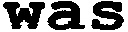

In [27]:
Image.fromarray(cleaneds[0])

In [14]:
from PIL import Image

In [11]:
cleaned=model.imageCleanSeg([testset[0][0]])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
cleaned.dtype

dtype('uint8')

In [61]:
cleaned=cleaned.astype('uint8')

In [62]:
cleaned

array([[[254, 255, 255, ..., 255, 255, 255],
        [255, 255, 253, ..., 255, 255, 254],
        [254, 254, 255, ..., 255, 253, 255],
        ...,
        [253, 255, 254, ..., 255, 255, 253],
        [255, 253, 255, ..., 254, 255, 255],
        [255, 254, 255, ..., 255, 253, 255]]], dtype=uint8)

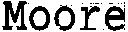

In [13]:
Image.fromarray(cleaned[0],'L')

NameError: name 'PIL' is not defined